# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

# FA: Keep the workspace awake
# Thx2: https://github.com/udacity/workspaces-student-support
from workspace_utils import active_session
time_of_save_time = 0 # Needed for preventing unwanted loading

# FA: moved torch imports here, otherwise loading difficult
import torch
import torch.nn as nn
import torch.nn.functional as F

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
using device:  cpu


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [3]:
# FA: Helper function
def get_time_string():
    return time.strftime('%Y%m%d%H%M%S')

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



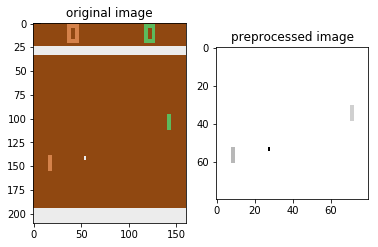

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv1 = nn.Conv2d(2, 4, kernel_size=(4,4), stride=(2,2), bias=False)
        self.conv2 = nn.Conv2d(4, 32, kernel_size=(5,5), stride=(2,2), bias=False)
        self.size=10368 
        
        # FA: fully connected layers
        self.fc1 = nn.Linear(self.size, 128, bias=True)
        self.drop = nn.Dropout(p = 0.2)
        self.fc2 = nn.Linear(128, 1, bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.sig(self.fc2(x))

# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


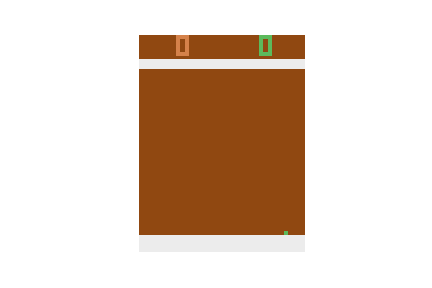
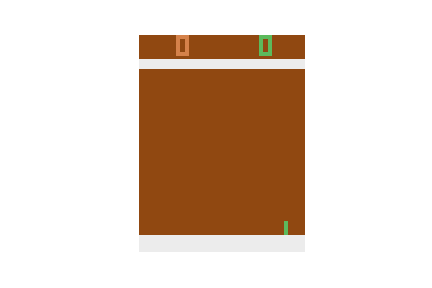
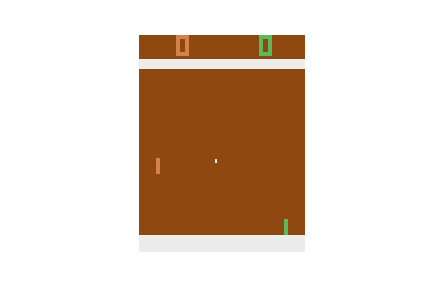
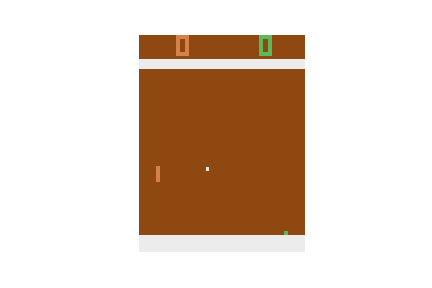
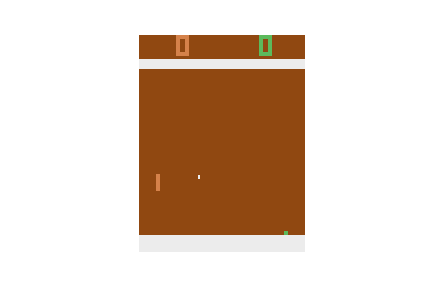
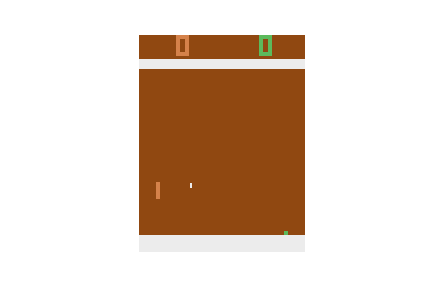
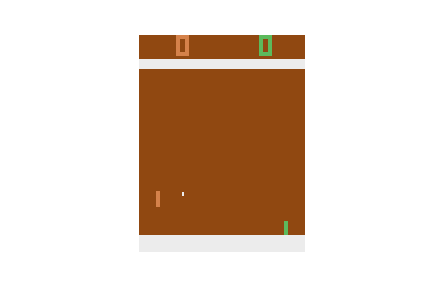
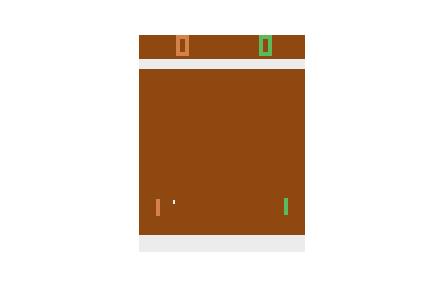
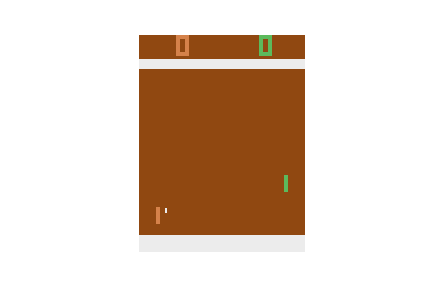
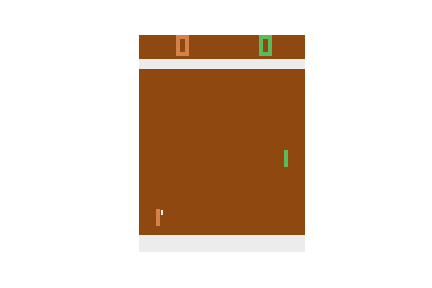
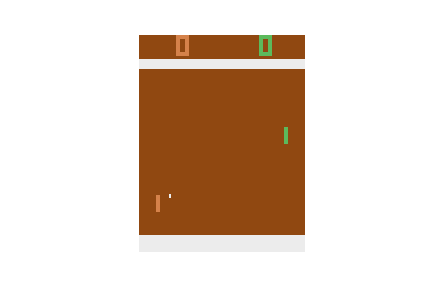
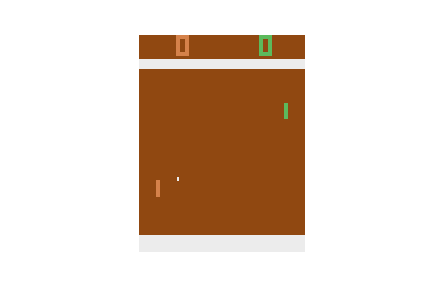
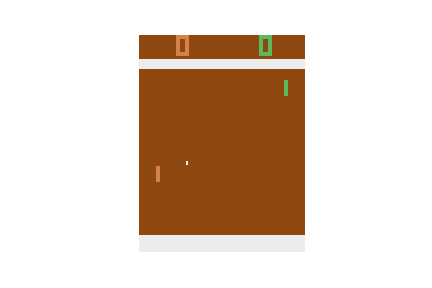
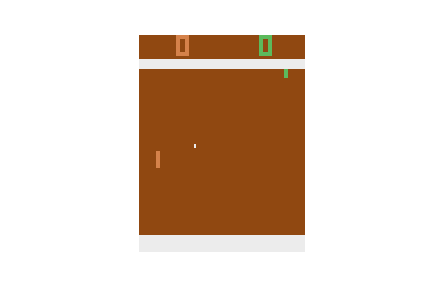
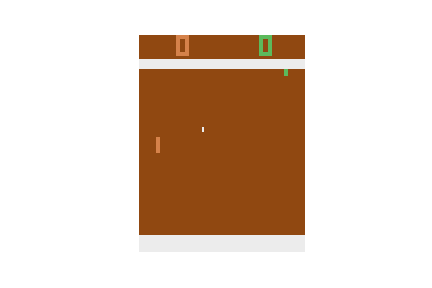
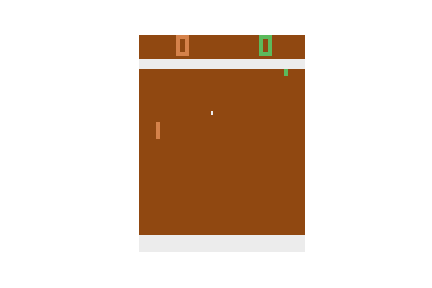
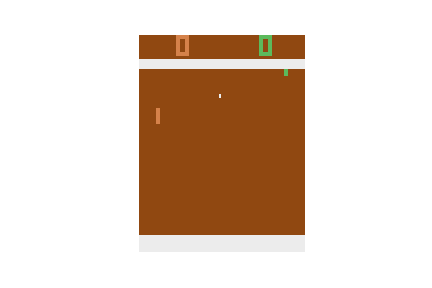
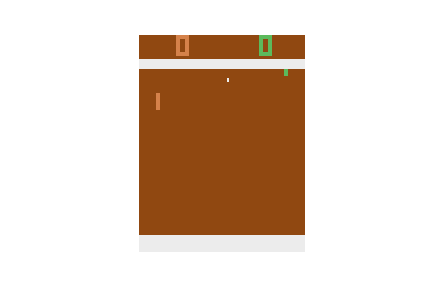
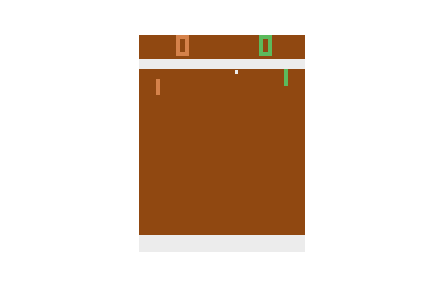
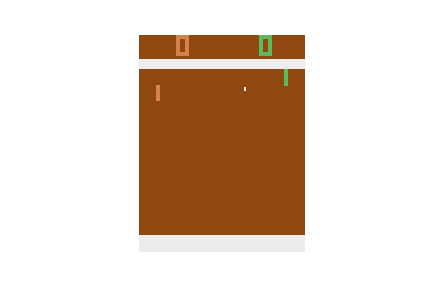
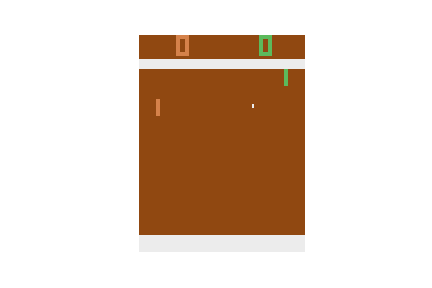
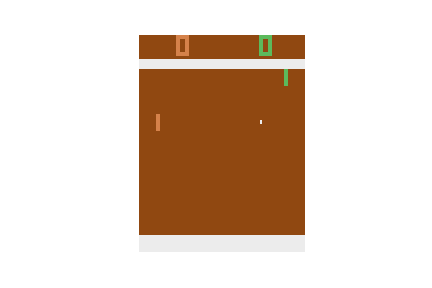
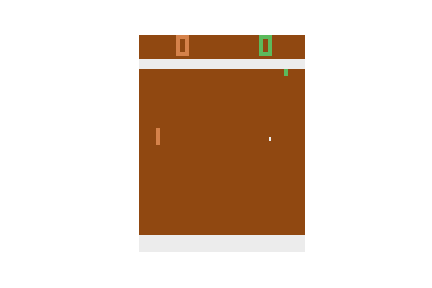
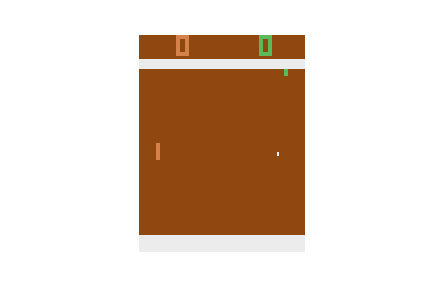
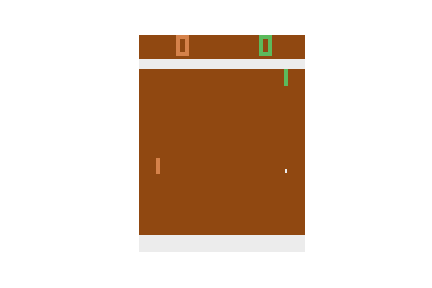
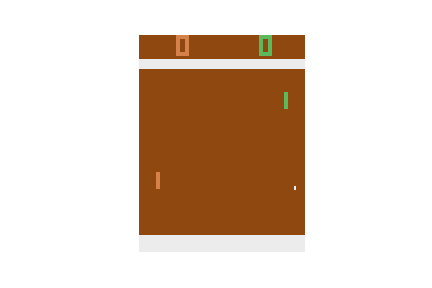
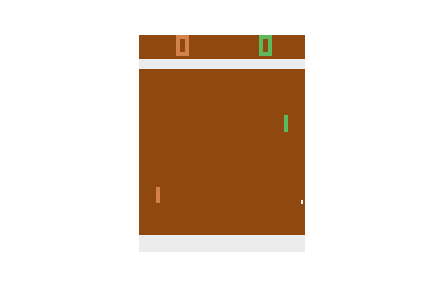
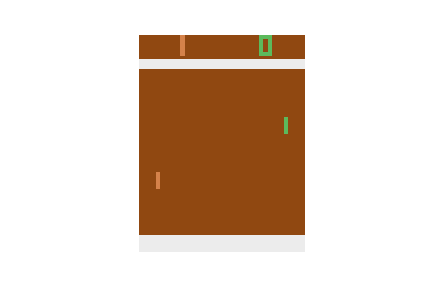
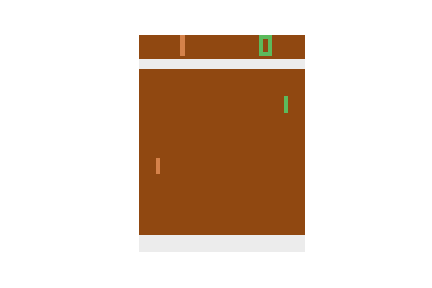
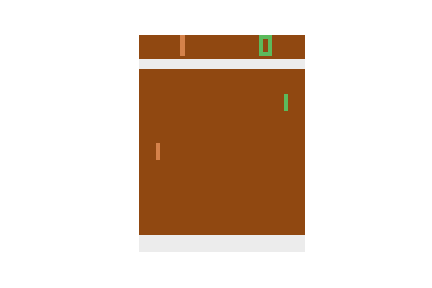
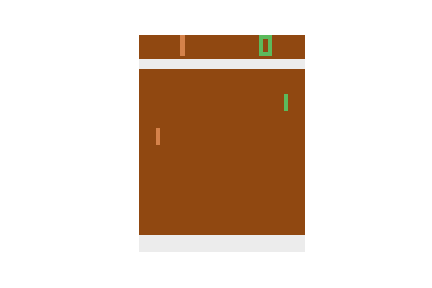
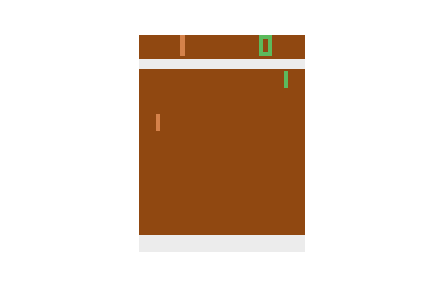
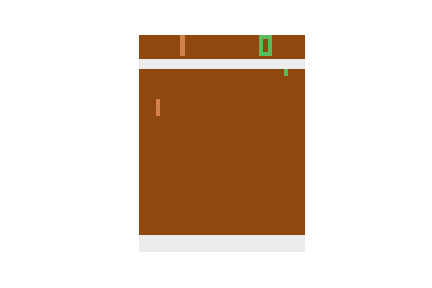
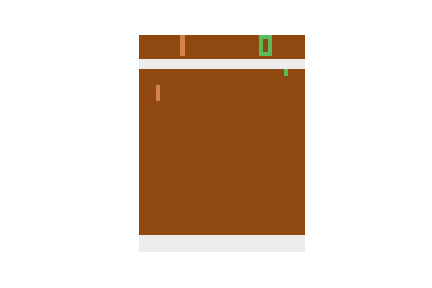
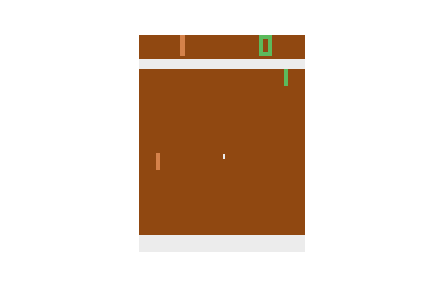
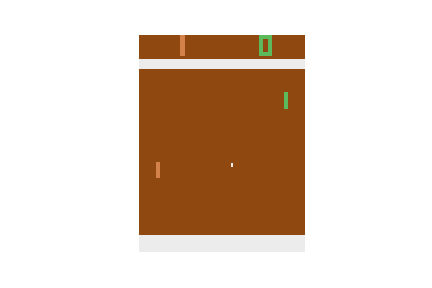
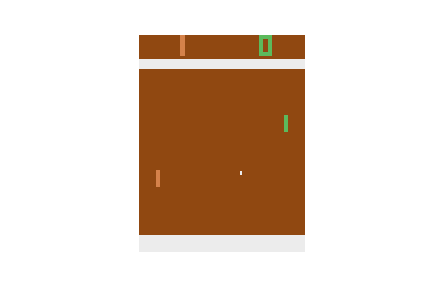
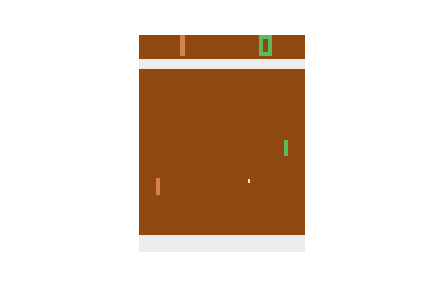
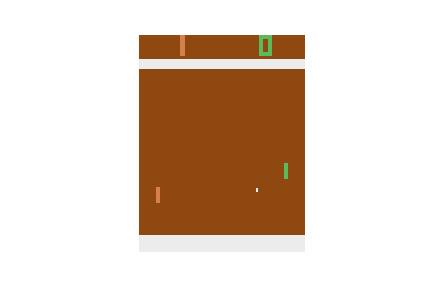
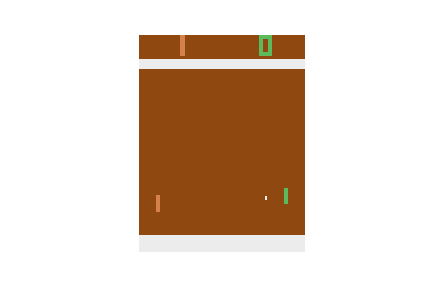
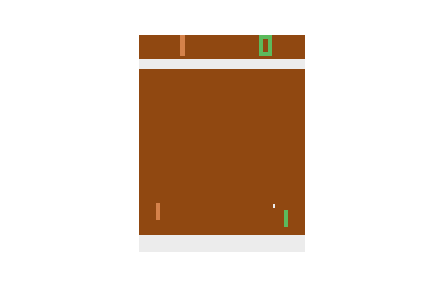
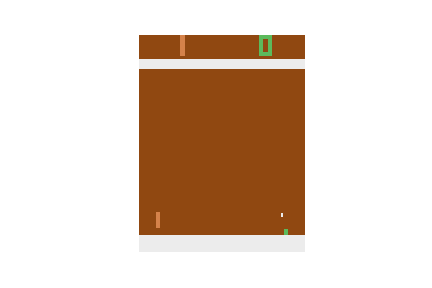
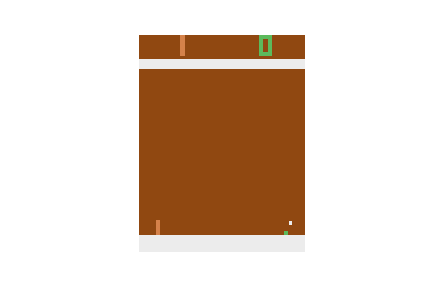
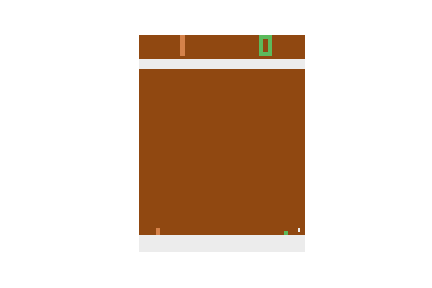
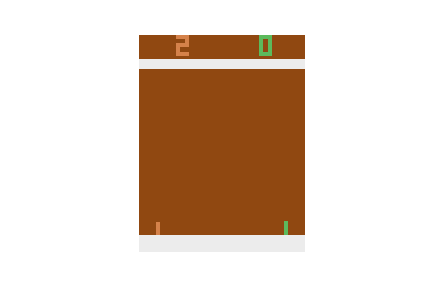
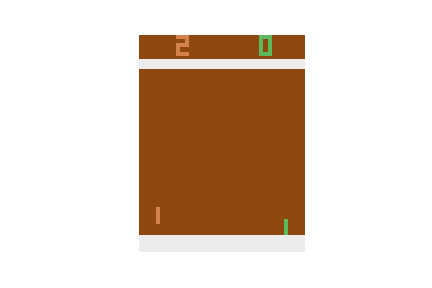
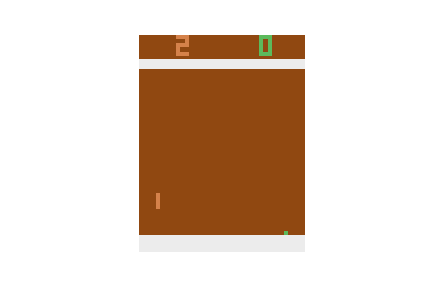
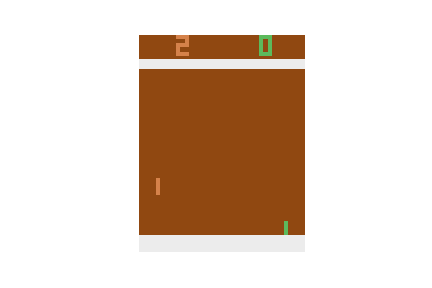
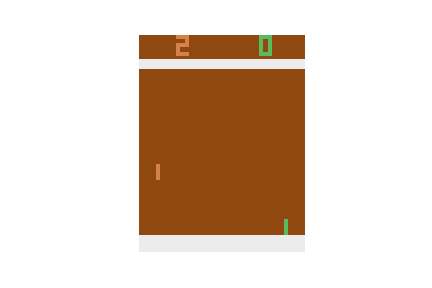
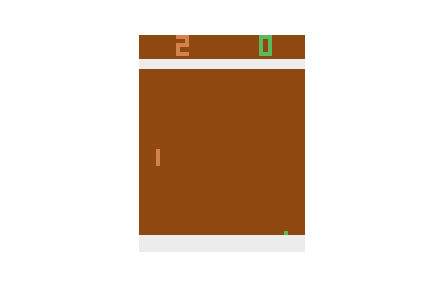
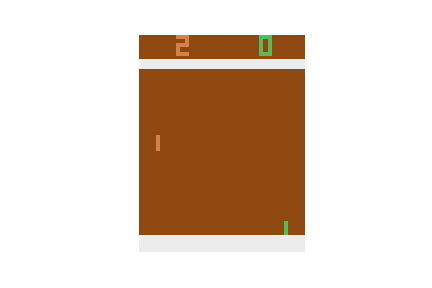
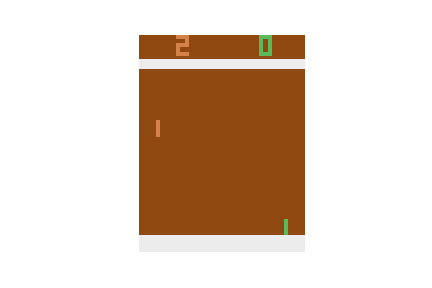
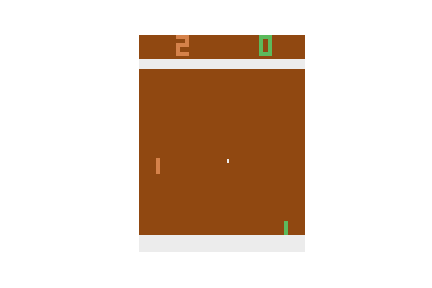
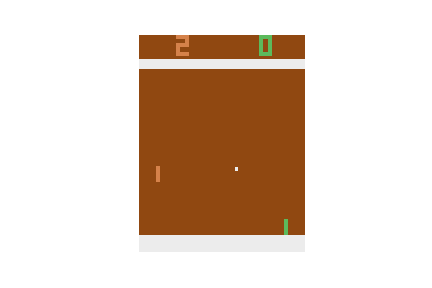
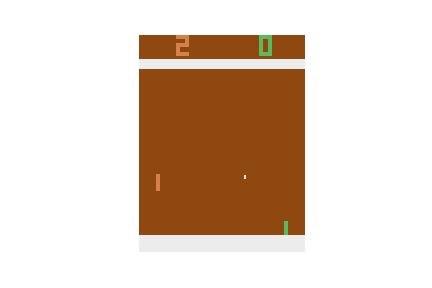
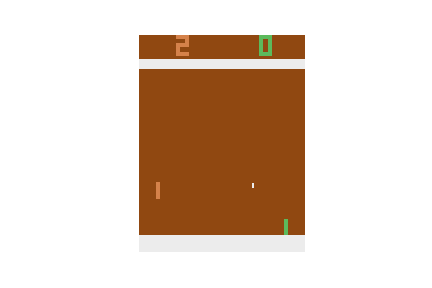
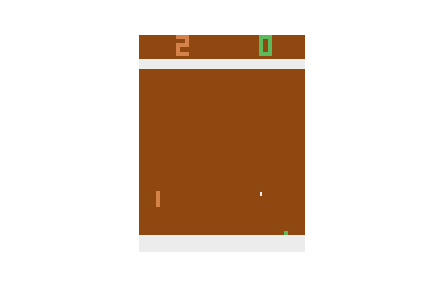
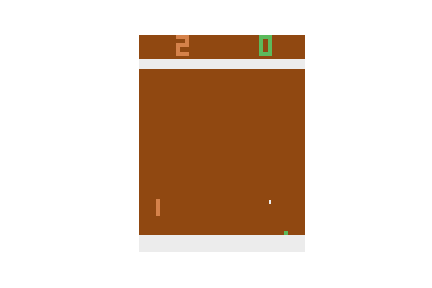
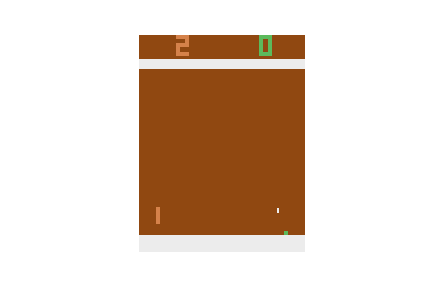
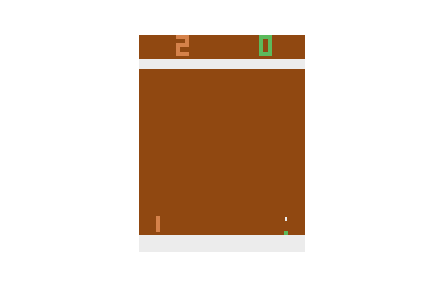
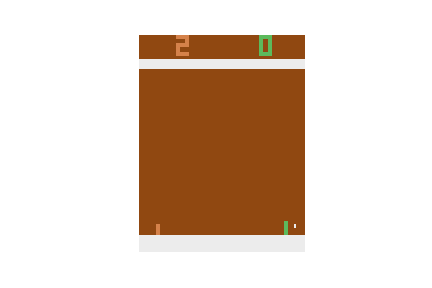
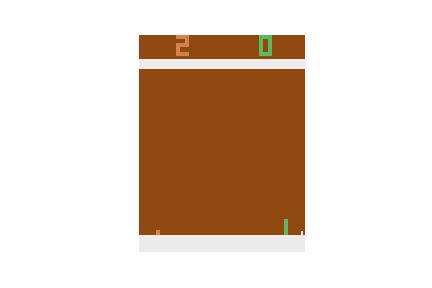
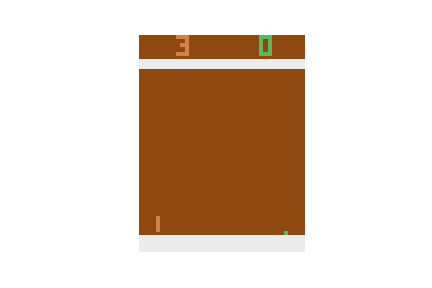
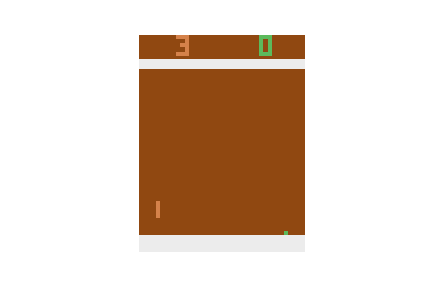
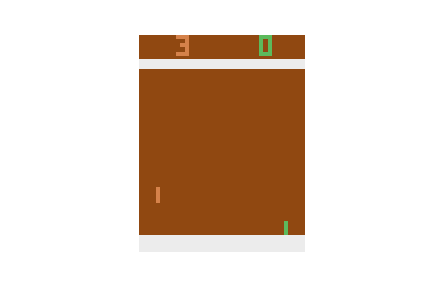
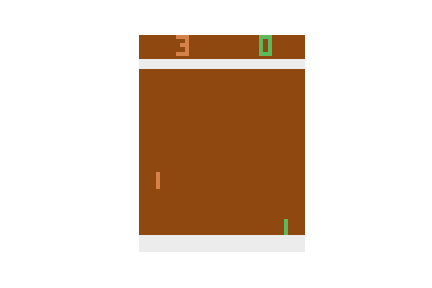
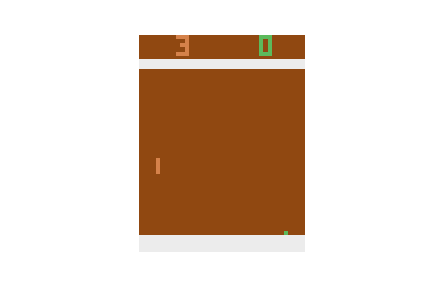
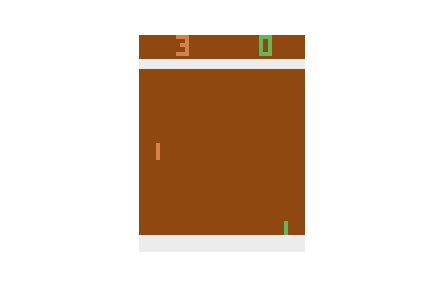
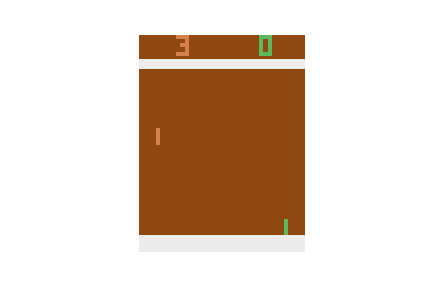
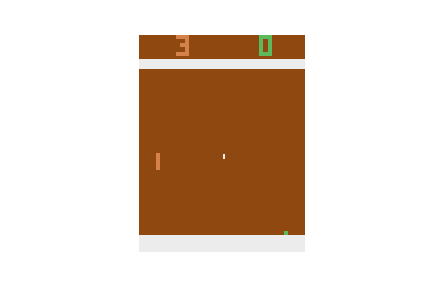
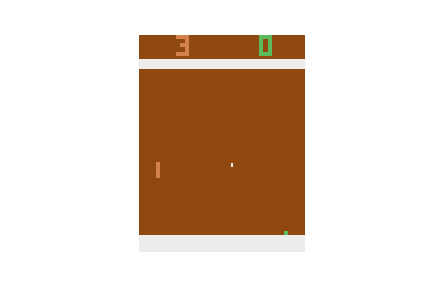
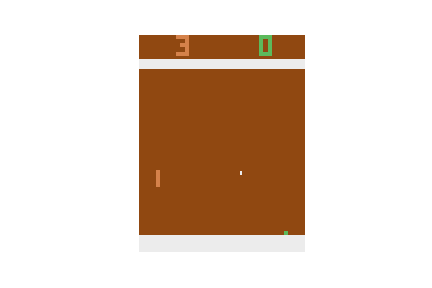
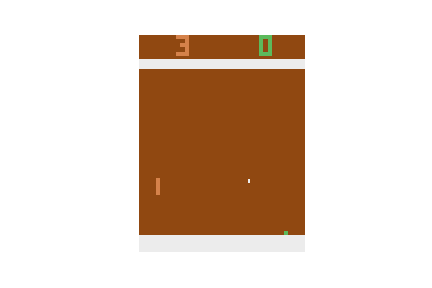
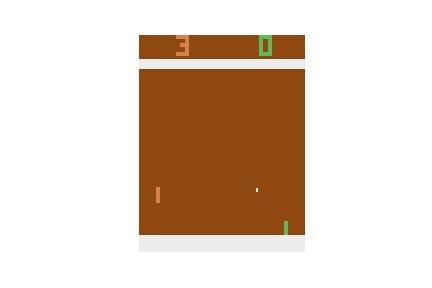
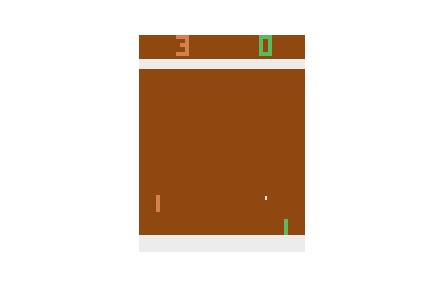
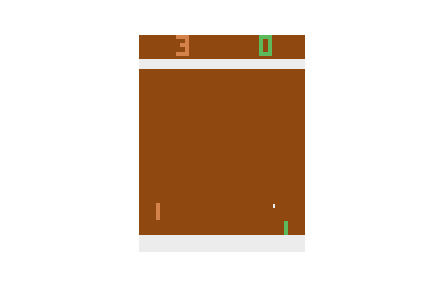
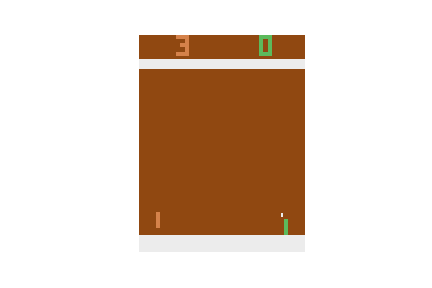
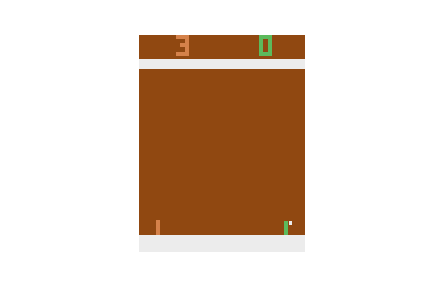
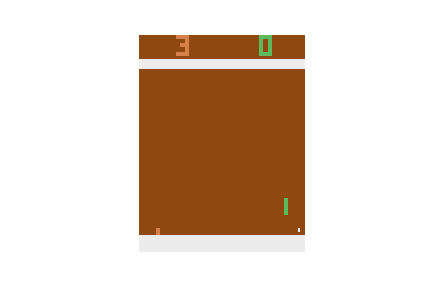
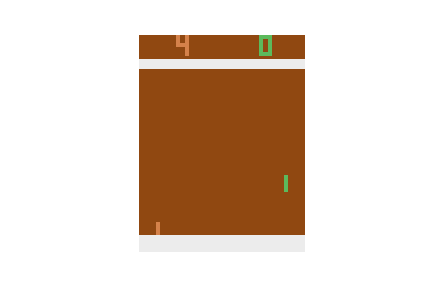
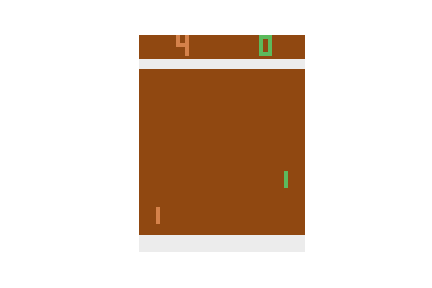
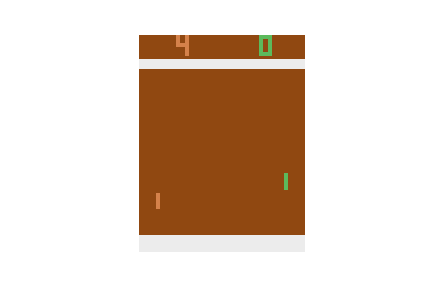
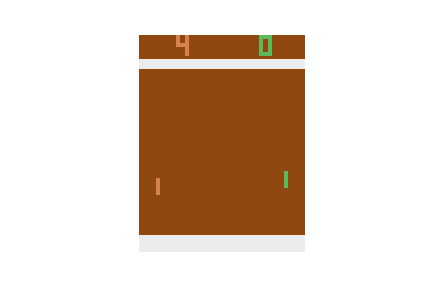
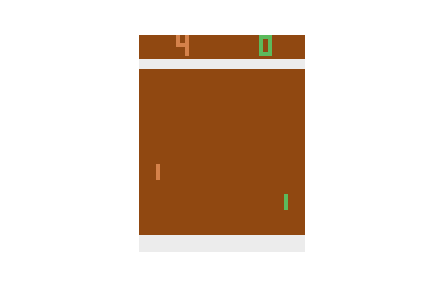
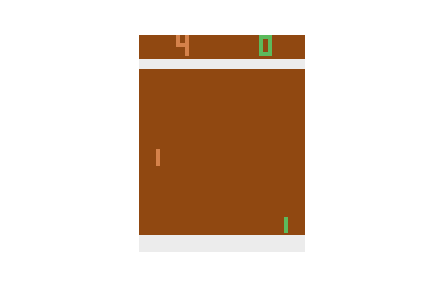
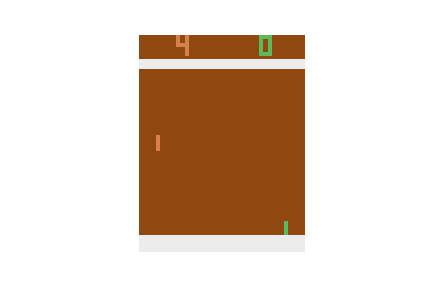
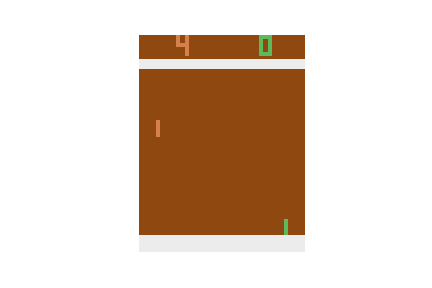
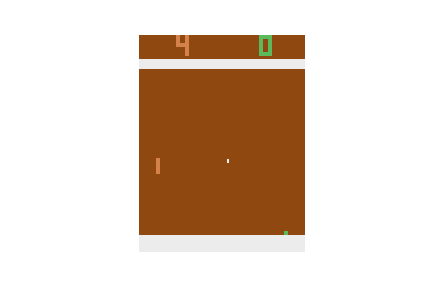
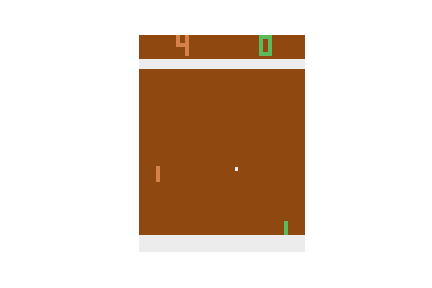
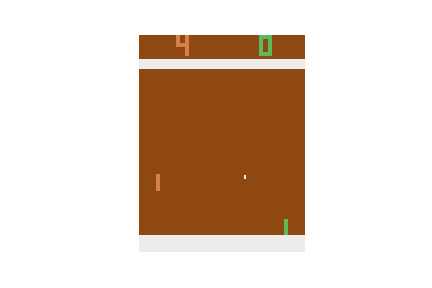
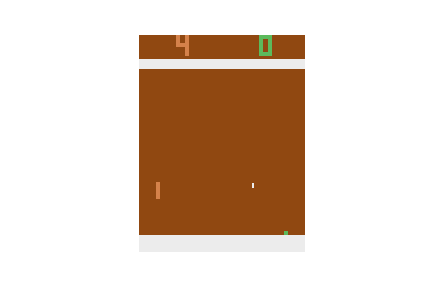
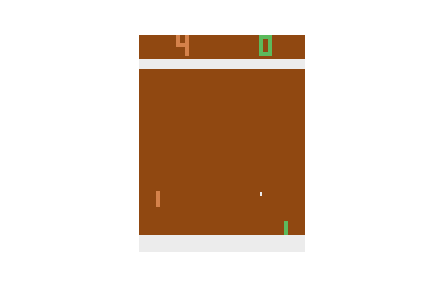
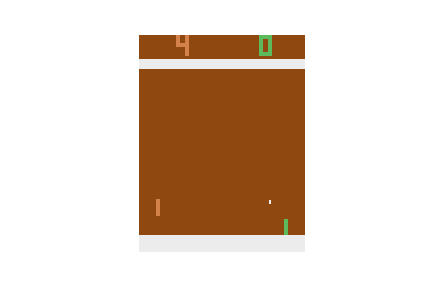
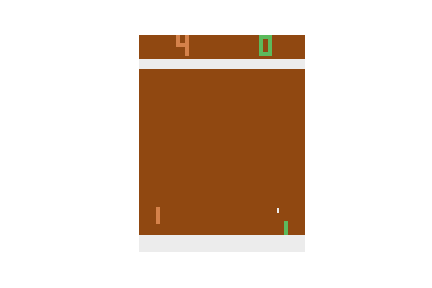
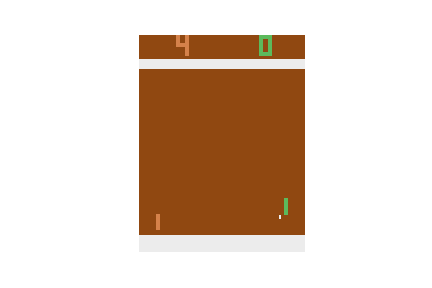
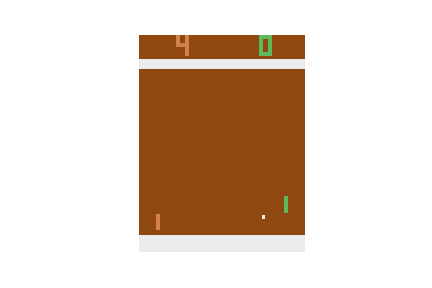
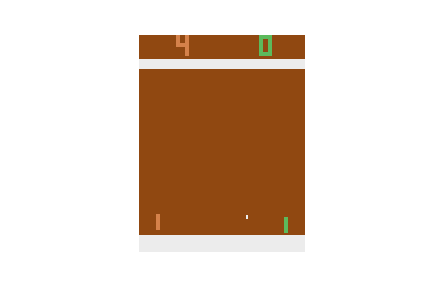
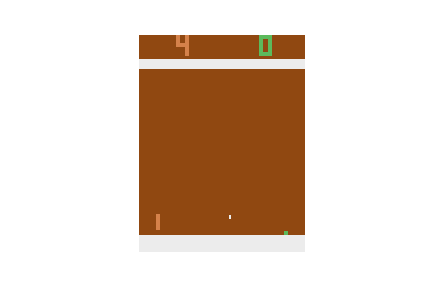
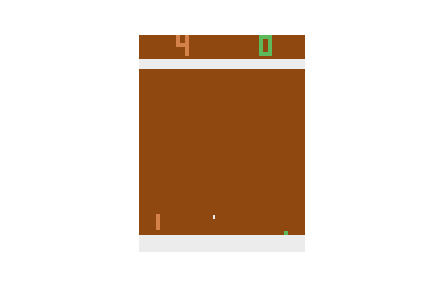
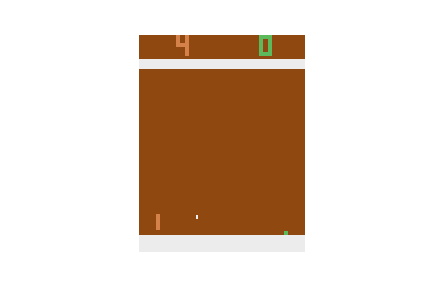
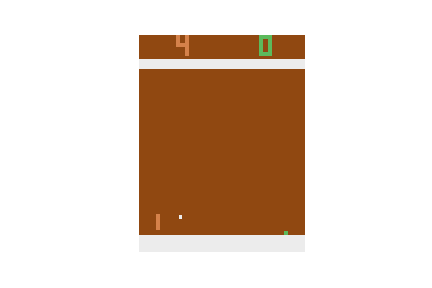
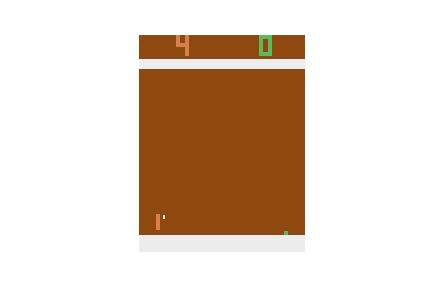
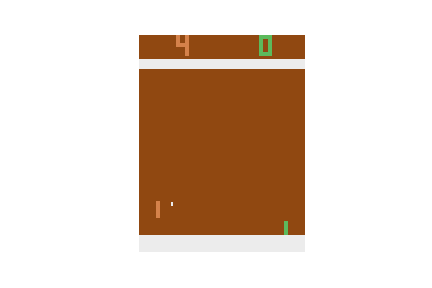
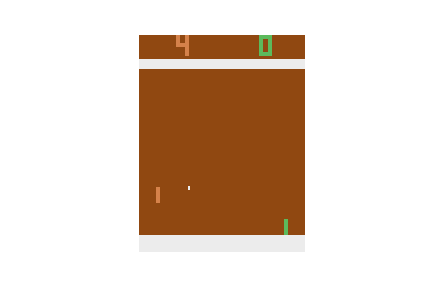
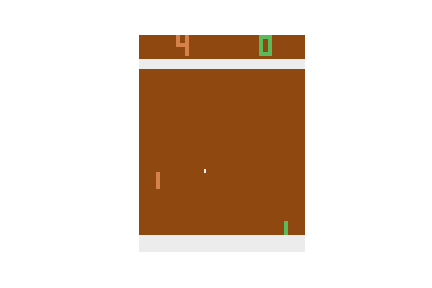
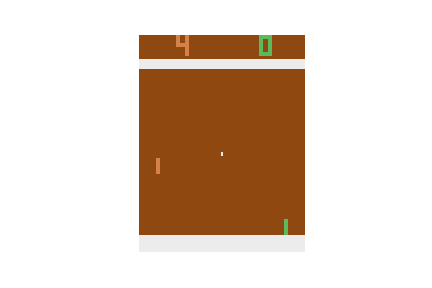
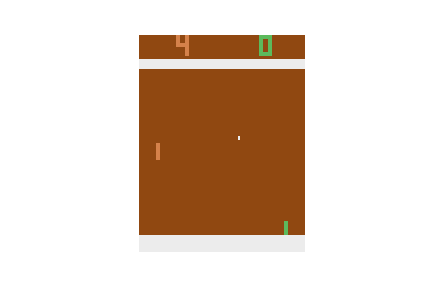
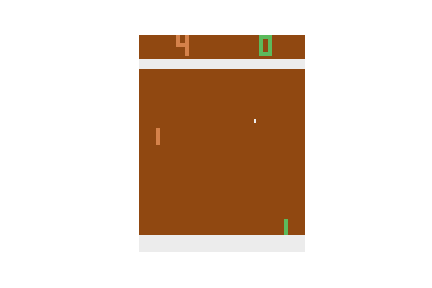
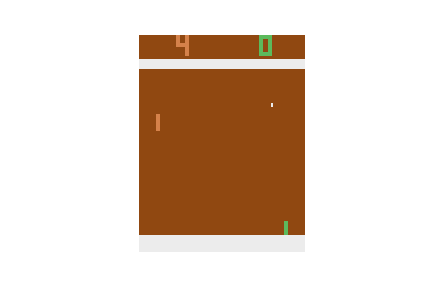
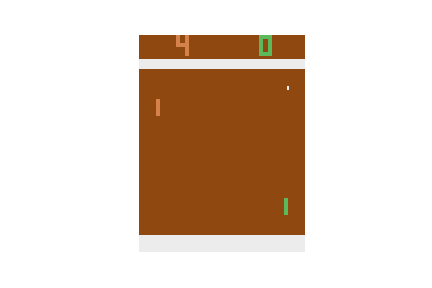
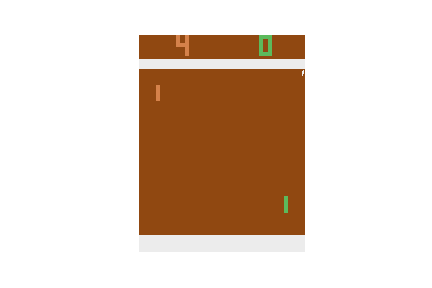
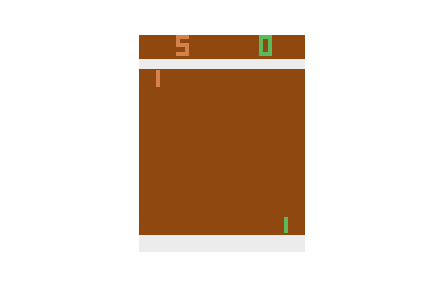
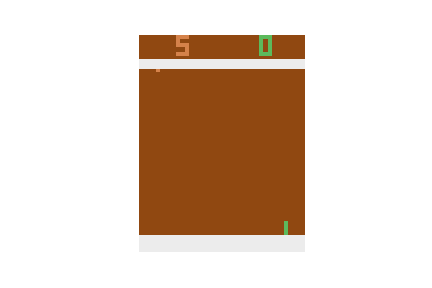
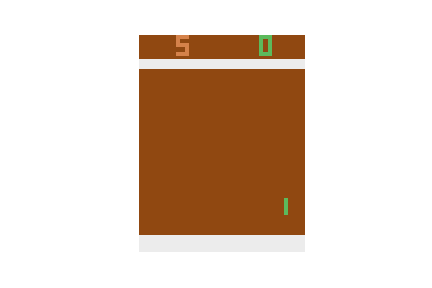
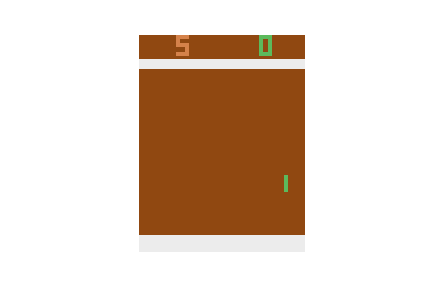
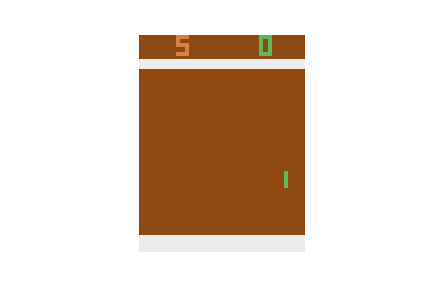
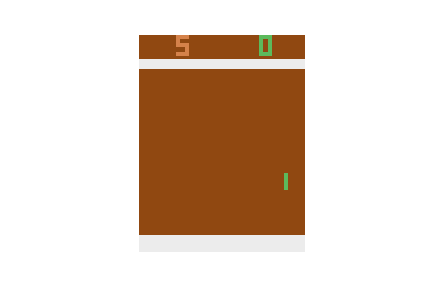
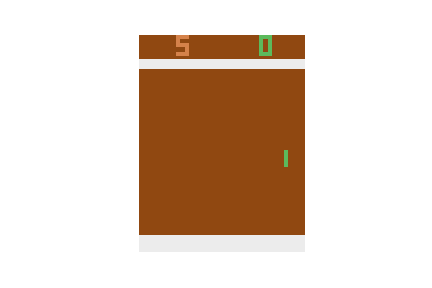
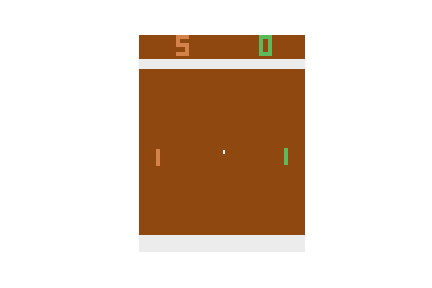
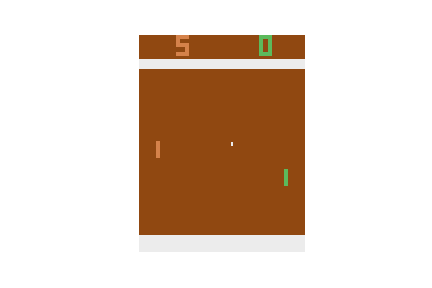
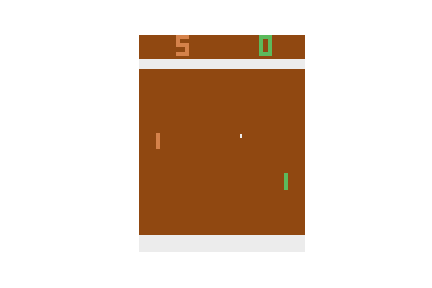
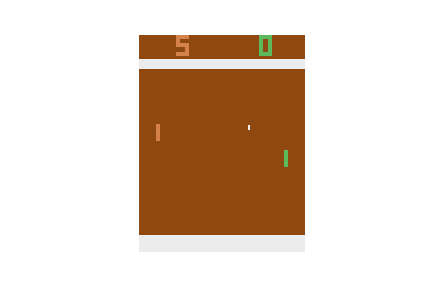
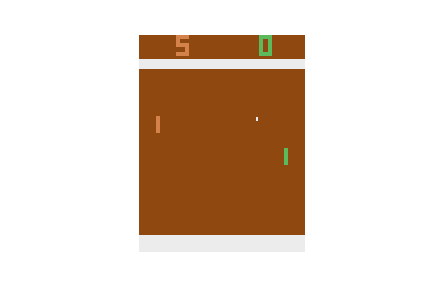
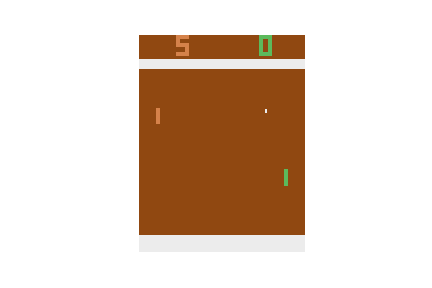
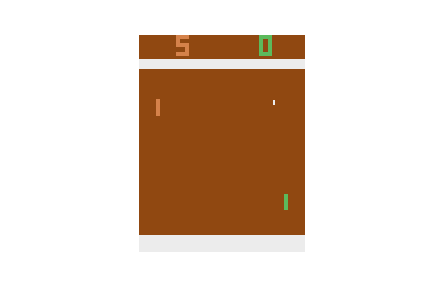
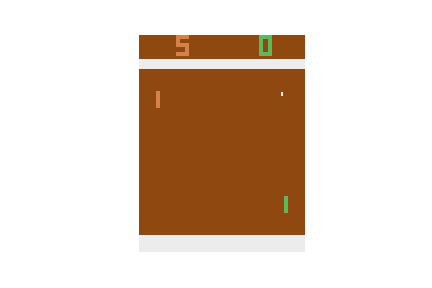
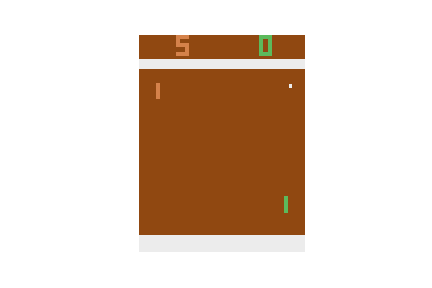
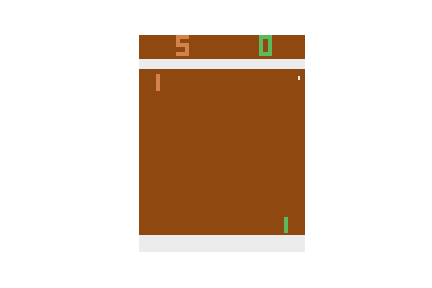
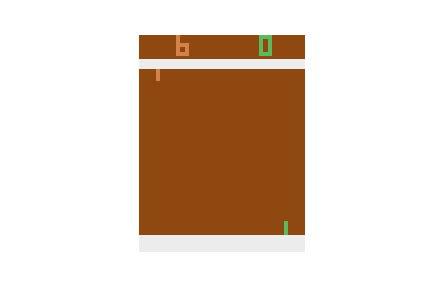
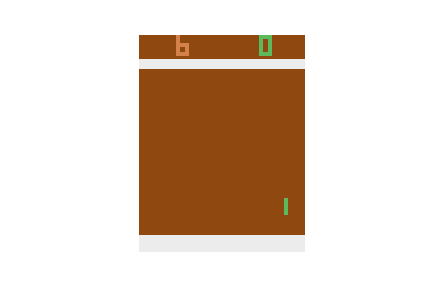
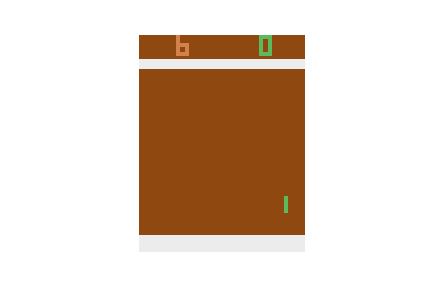
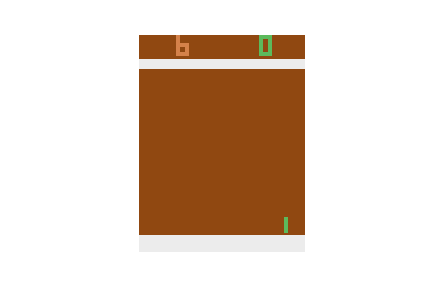
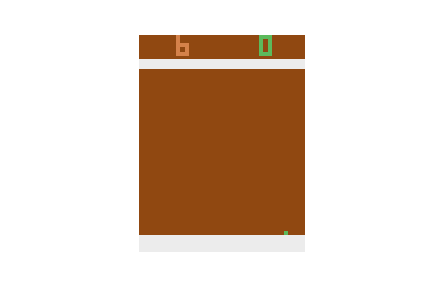
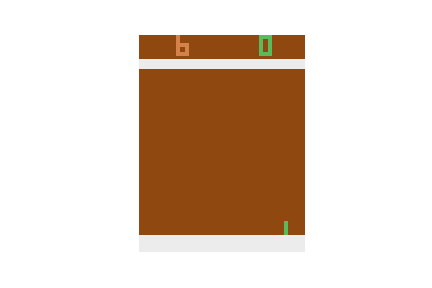
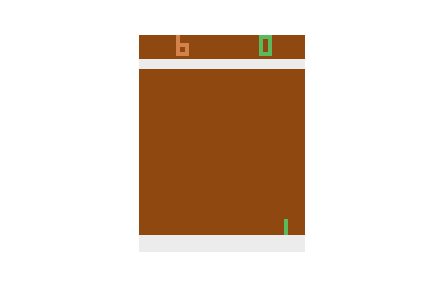
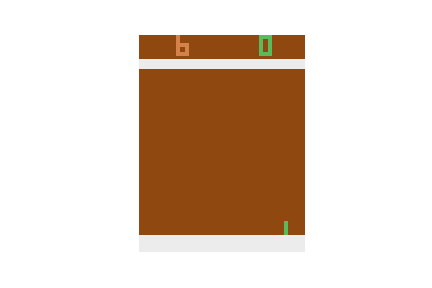
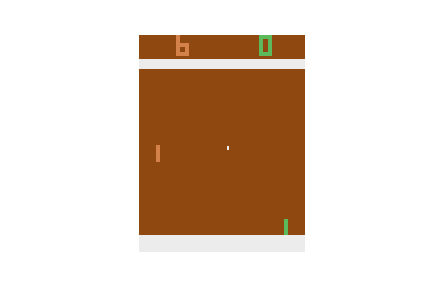
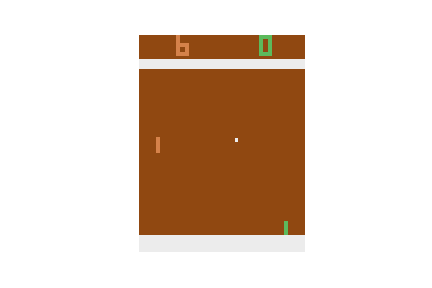
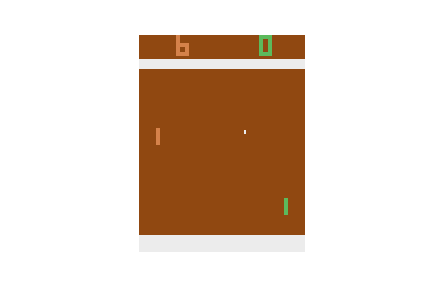
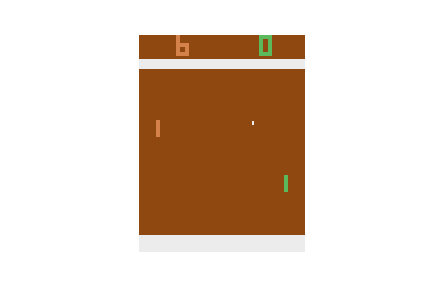
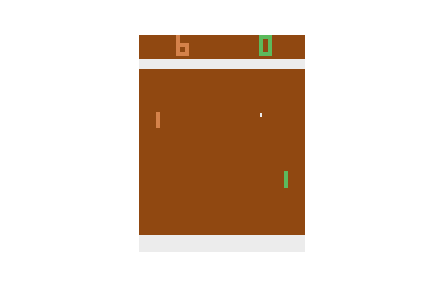
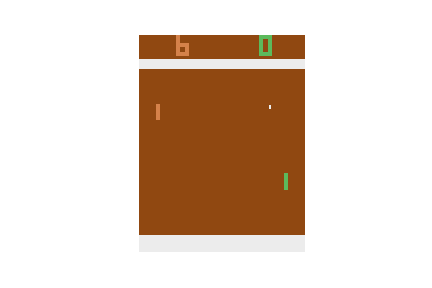
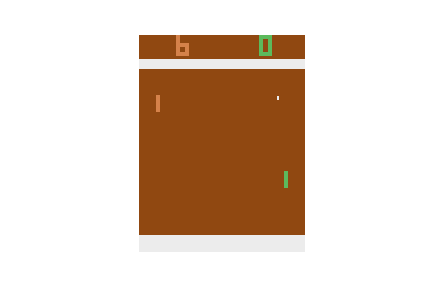
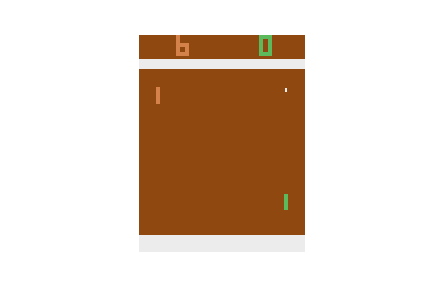
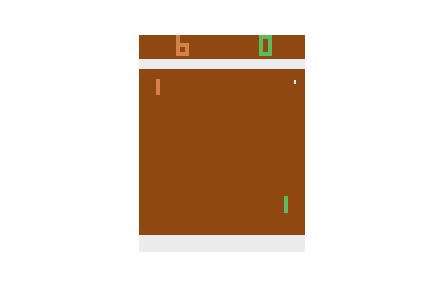
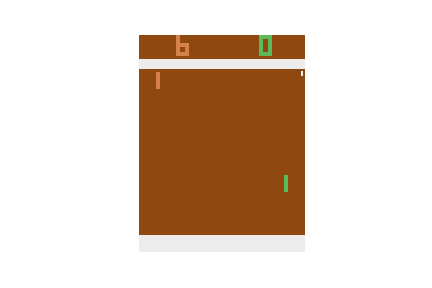
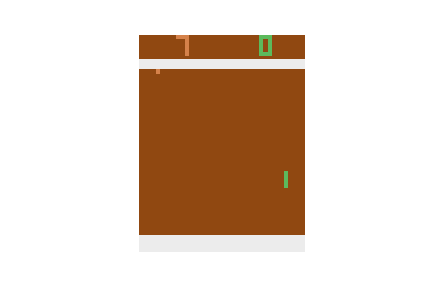
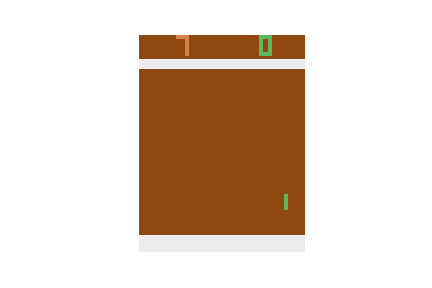
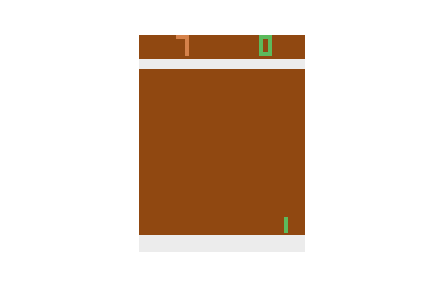
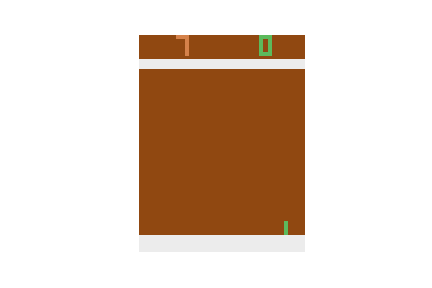
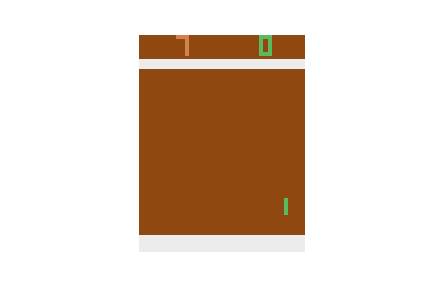
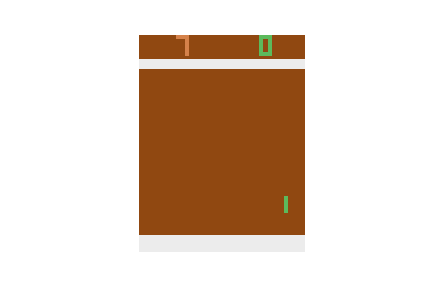
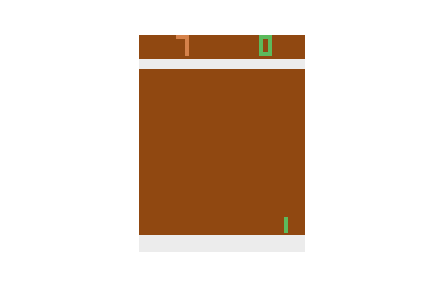
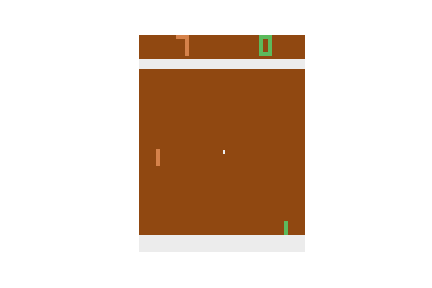
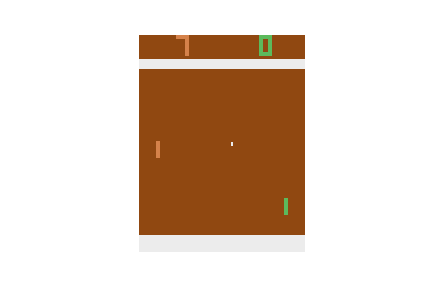
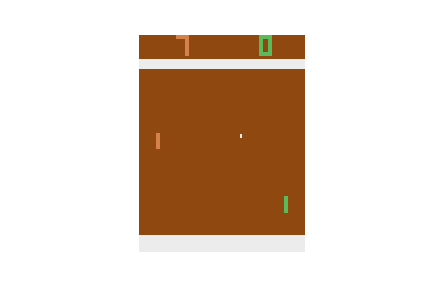
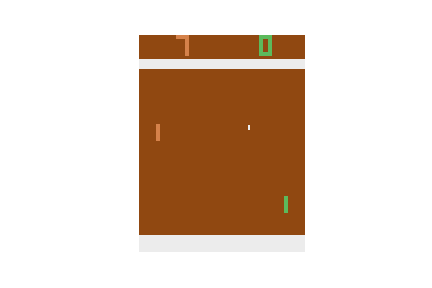
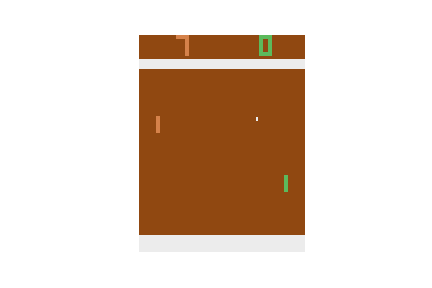
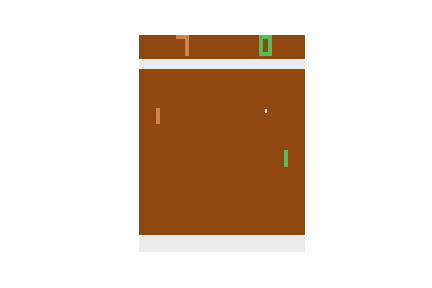
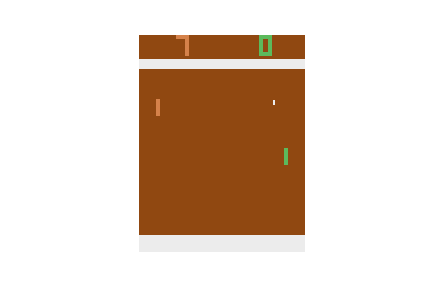
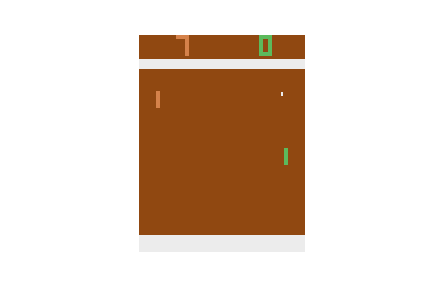
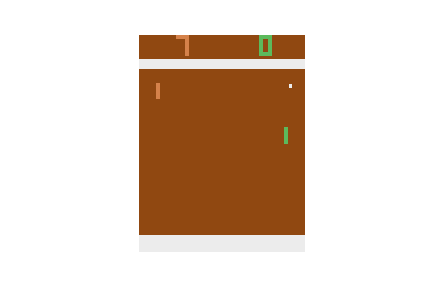
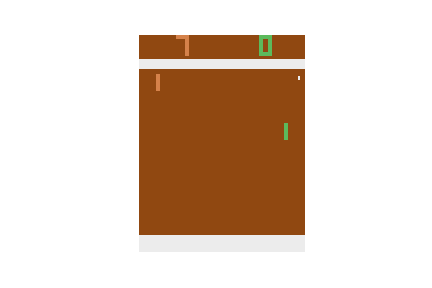
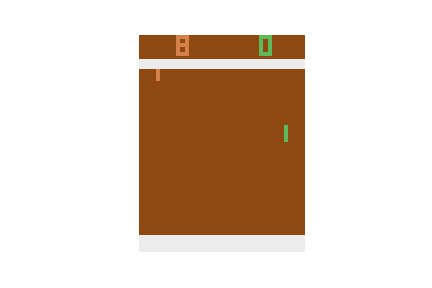
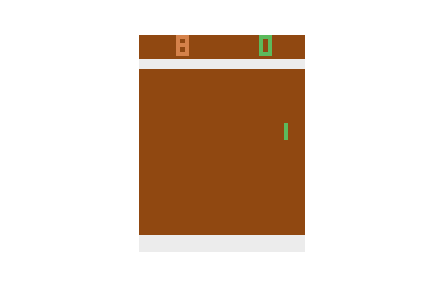
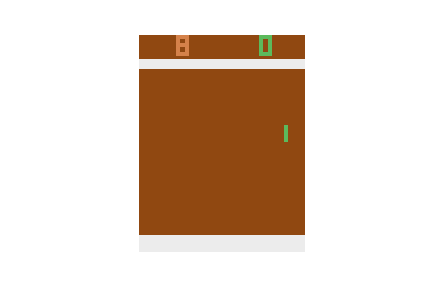
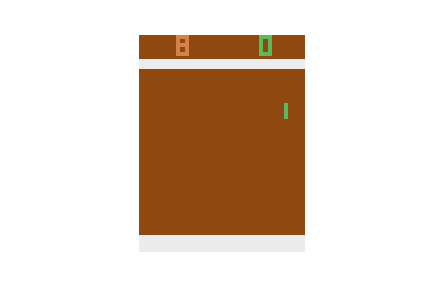
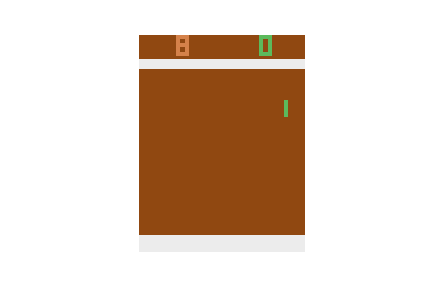
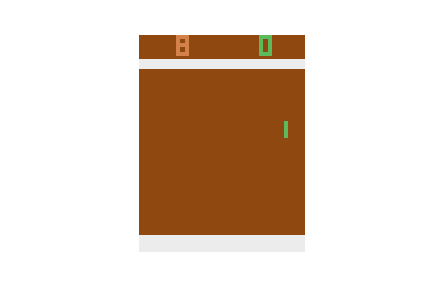
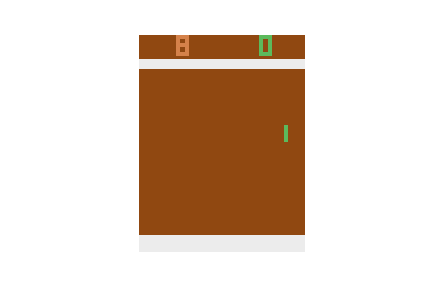
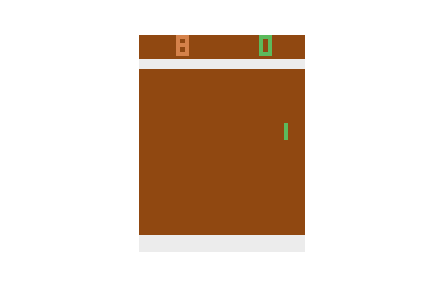
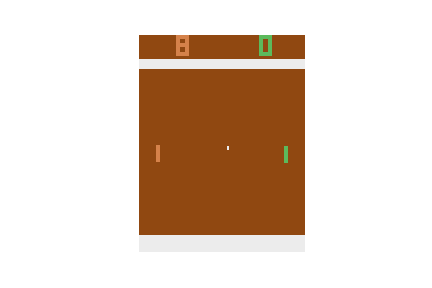
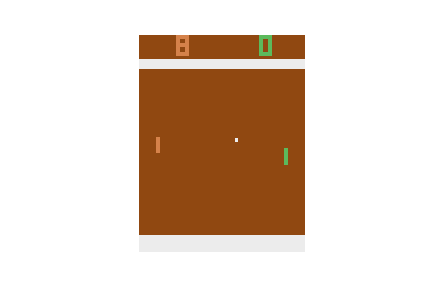
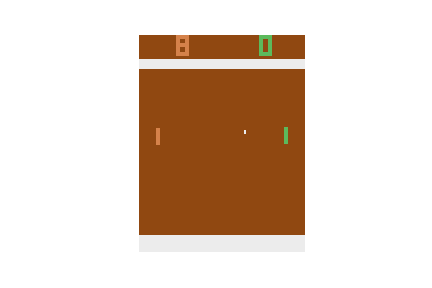
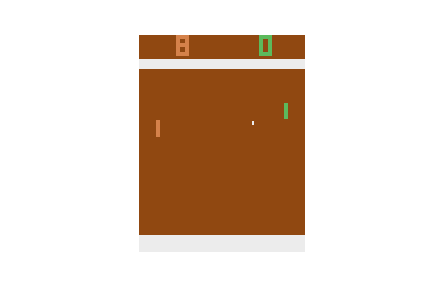
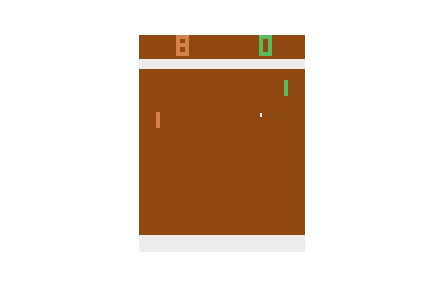
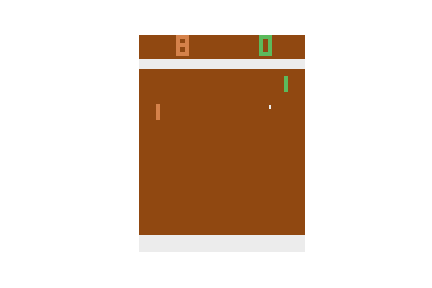
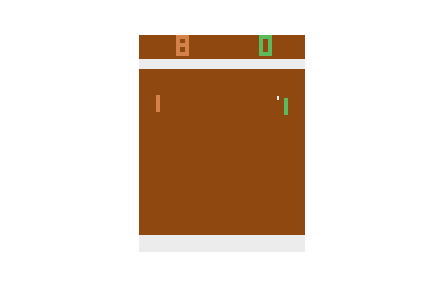
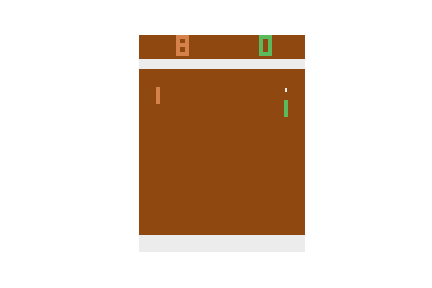
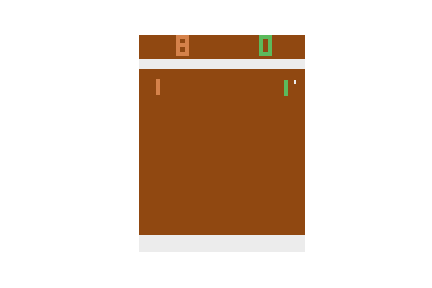
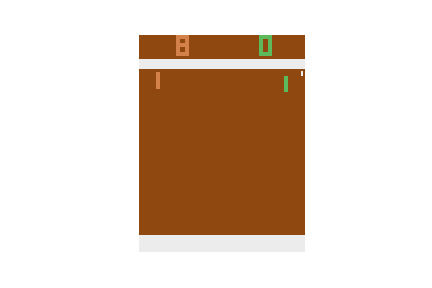
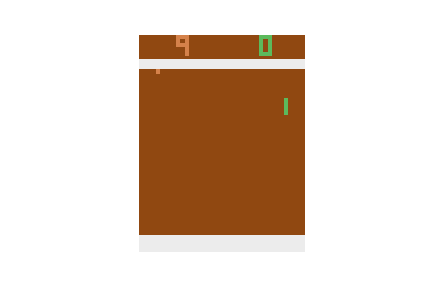
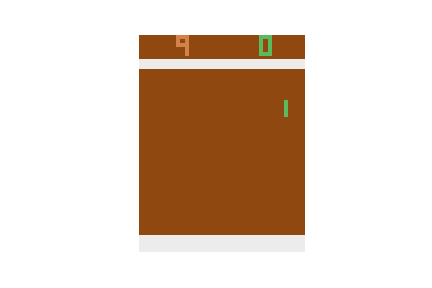
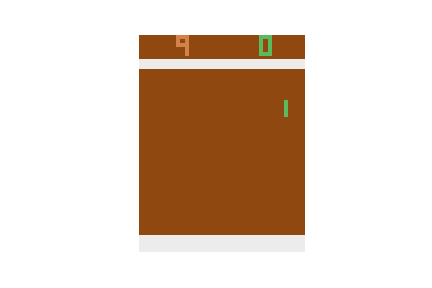
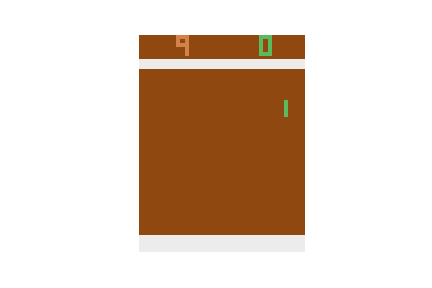
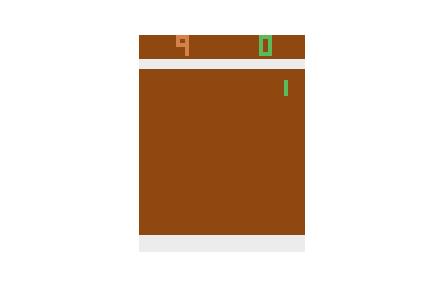
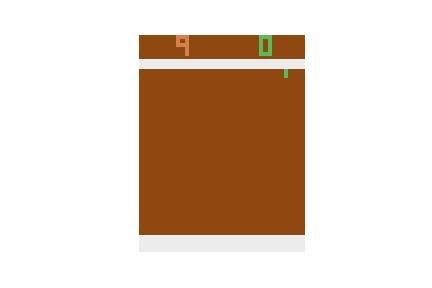
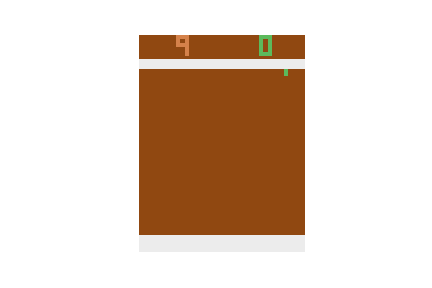
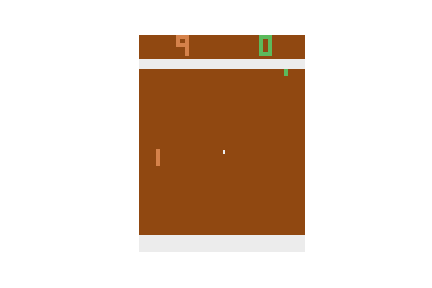
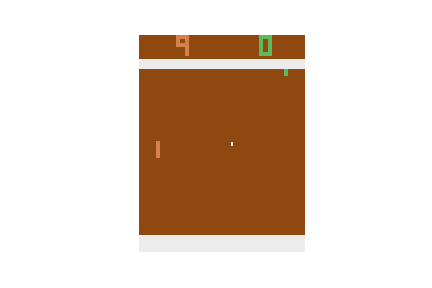
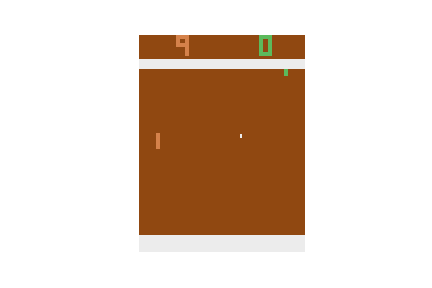
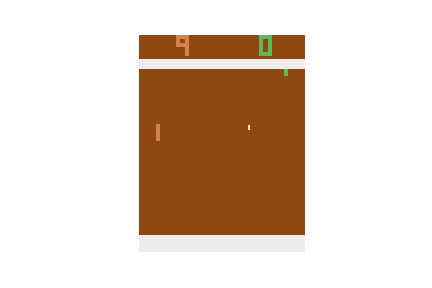
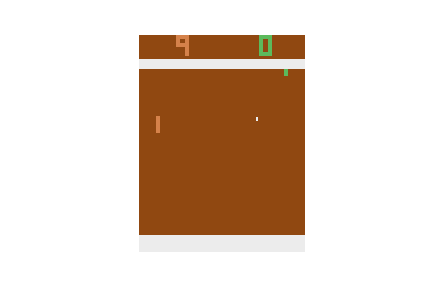
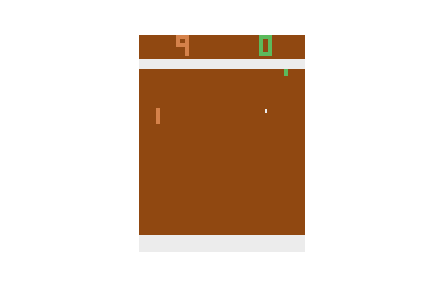
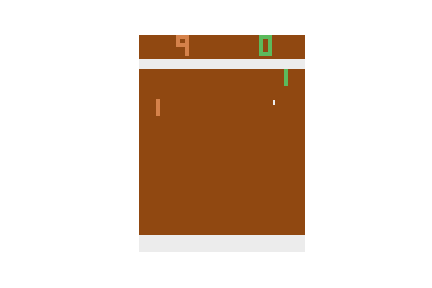
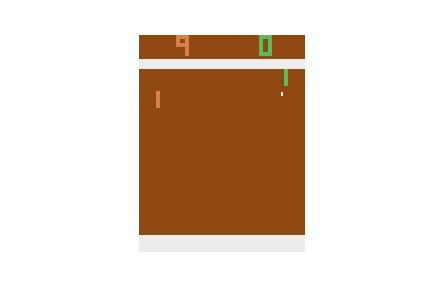
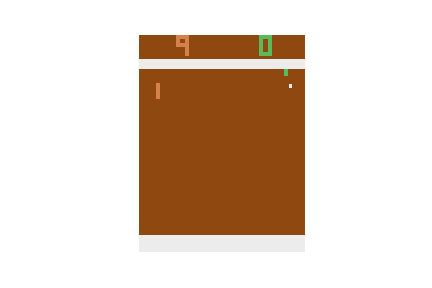
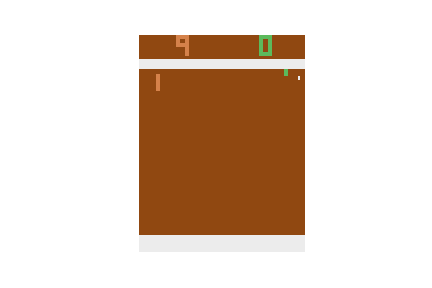
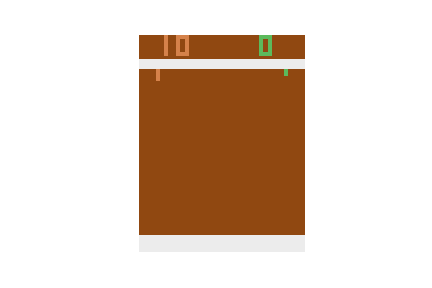
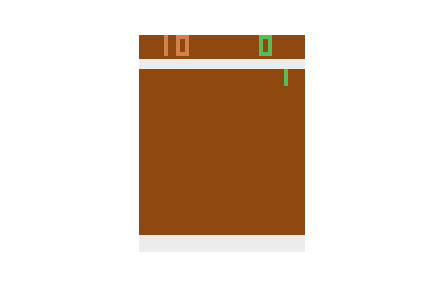

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
#episode = 500
episode = 600 # Because 20% dropout 20% more episodes

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

# FA: Keep the Udacity workspace awake!
with active_session():   
    for e in range(episode):

        # collect trajectories
        old_probs, states, actions, rewards = \
            pong_utils.collect_trajectories(envs, policy, tmax=tmax)

        total_rewards = np.sum(rewards, axis=0)


        # gradient ascent step
        for _ in range(SGD_epoch):

            # uncomment to utilize your own clipped function!
            # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

            L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                              epsilon=epsilon, beta=beta)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces as time goes on
        epsilon*=.999

        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995

        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))

        # display some progress every 20 iterations
        if (e+1)%20 ==0 :
            print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)

        # update progress widget bar
        timer.update(e+1)
    
timer.finish()

Episode: 20, score: -13.500000
[-12. -14. -13. -13. -13. -16. -12. -15.]


Episode: 40, score: -14.625000
[-16. -14. -17. -15. -12. -12. -16. -15.]


Episode: 60, score: -14.500000
[-15. -16. -17. -16. -13. -12. -12. -15.]


Episode: 80, score: -12.375000
[ -8. -13. -15. -12. -10. -14. -13. -14.]


Episode: 100, score: -14.000000
[-13. -11. -16. -16. -13. -15. -15. -13.]


Episode: 120, score: -13.125000
[-15. -13. -13. -11. -15. -12. -12. -14.]


Episode: 140, score: -11.125000
[ -6. -12.  -9. -11. -13. -11. -13. -14.]


Episode: 160, score: -9.000000
[-11.  -5. -11.  -8. -13.  -8.  -9.  -7.]


Episode: 180, score: -8.375000
[ -9.  -3. -11. -11.  -7.  -9.  -9.  -8.]


Episode: 200, score: -7.750000
[-10.  -3.  -7.  -7.  -4. -12.  -9. -10.]


Episode: 220, score: -6.000000
[-7. -4. -2. -3. -9. -6. -8. -9.]


Episode: 240, score: -2.000000
[-1. -1. -7. -2. -1. -2. -1. -1.]


Episode: 260, score: -2.500000
[-2. -1. -4. -4. -3. -1. -1. -4.]


Episode: 280, score: -3.750000
[-1. -1. -6. -5.  0. -4. -7. -6.]


Episode: 300, score: -2.250000
[-1. -7. -1. -5. -1. -1. -1. -1.]


Episode: 320, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 340, score: -1.750000
[ 0. -2. -7. -1. -1. -1.  0. -2.]


Episode: 360, score: -1.375000
[-1. -1. -3. -1. -1. -1. -2. -1.]


Episode: 380, score: -1.750000
[-7. -1. -1. -1. -1. -1. -1. -1.]


Episode: 400, score: -1.375000
[-1. -1. -1. -1. -1. -1. -4. -1.]


Episode: 420, score: -0.875000
[-1. -1. -1.  0. -1. -1. -1. -1.]


Episode: 440, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 460, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 480, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 500, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 520, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 540, score: -0.875000
[ 0. -1. -1. -1. -1. -1. -1. -1.]


Episode: 560, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 580, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


Episode: 600, score: -0.875000
[-1.  0. -1. -1. -1. -1. -1. -1.]



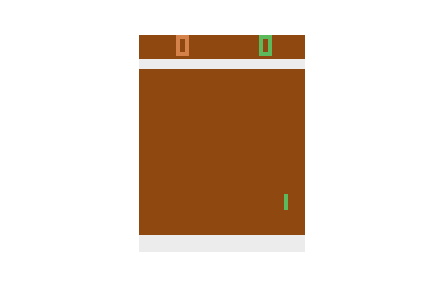
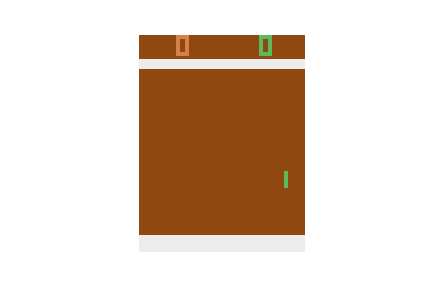
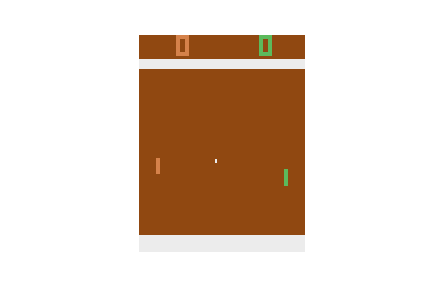
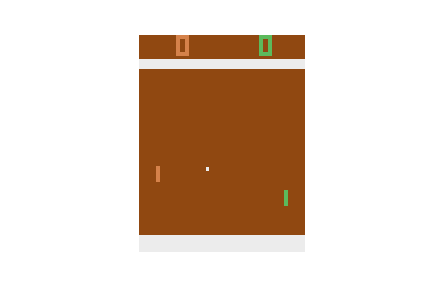
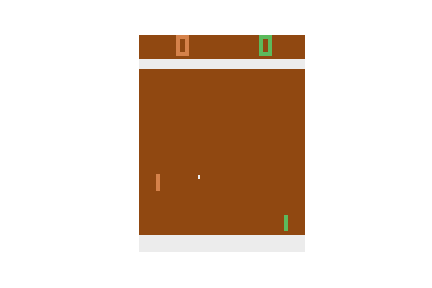
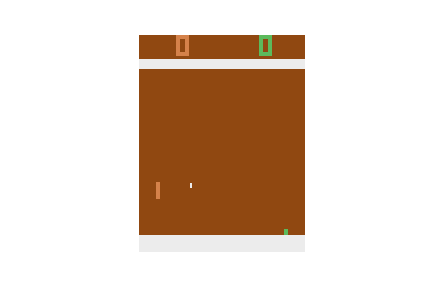
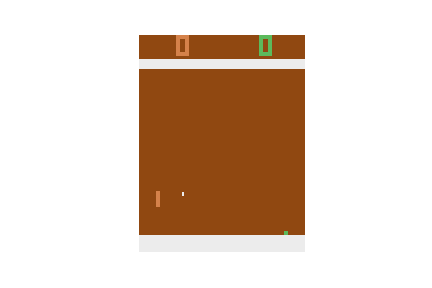
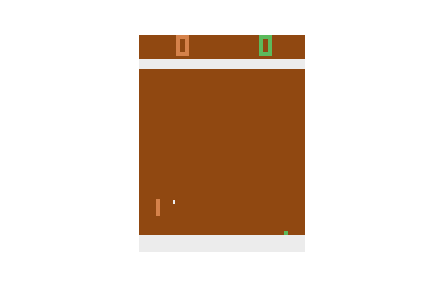
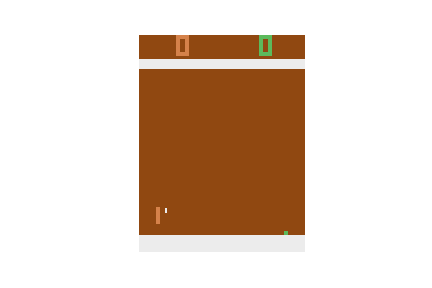
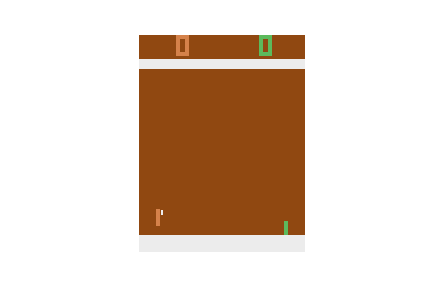
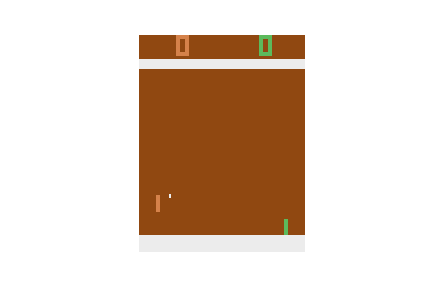
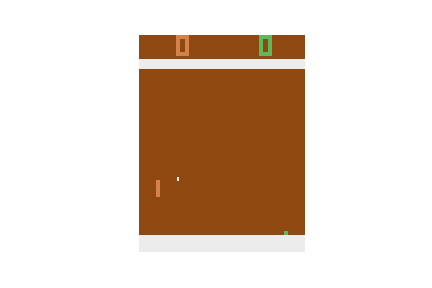
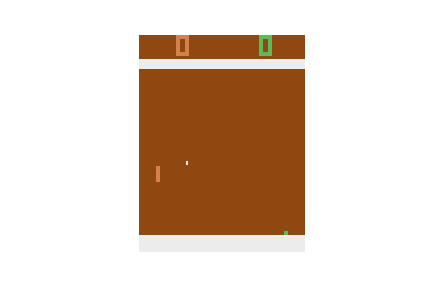
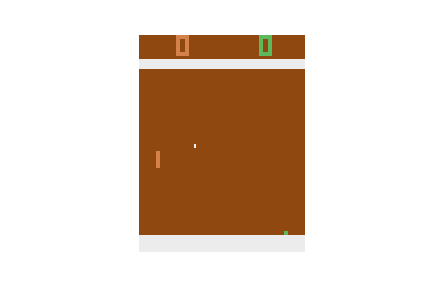
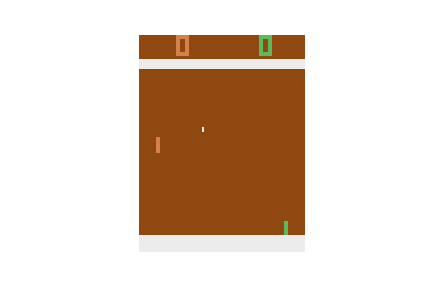
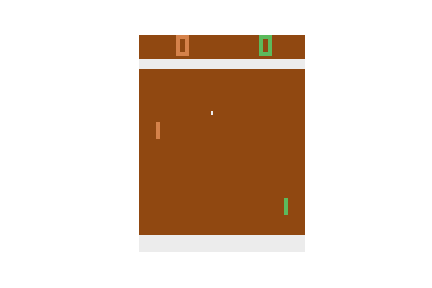
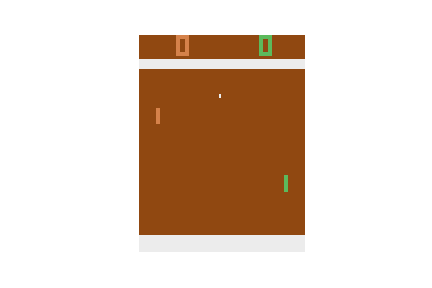
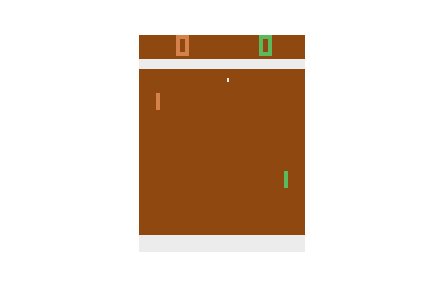
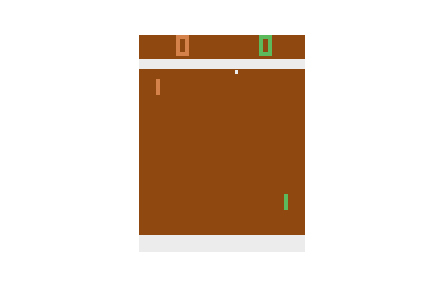
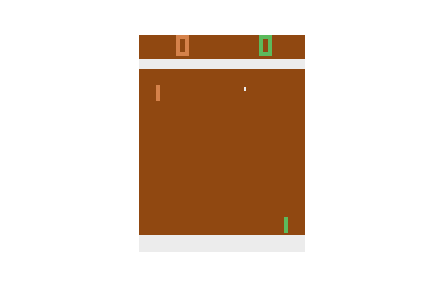
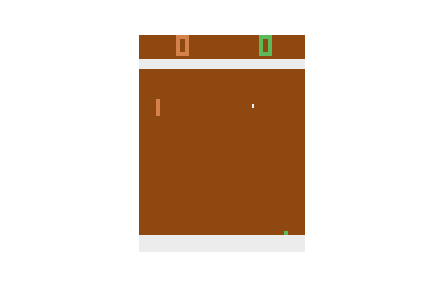
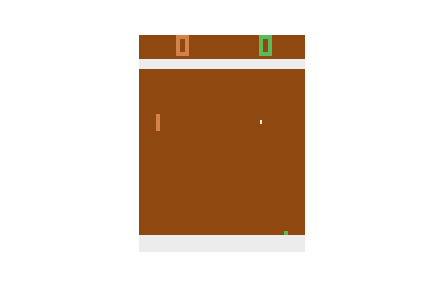
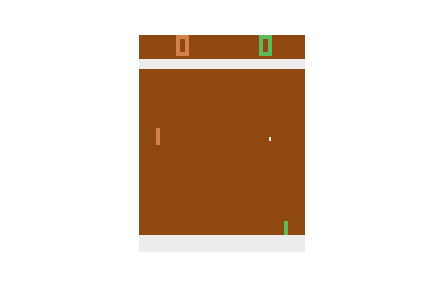
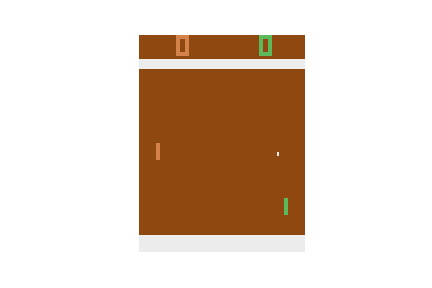
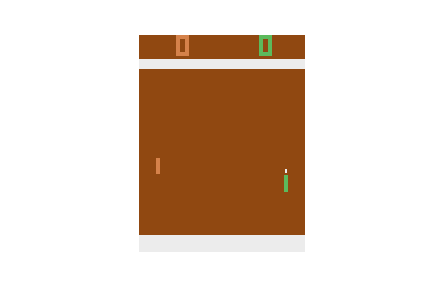
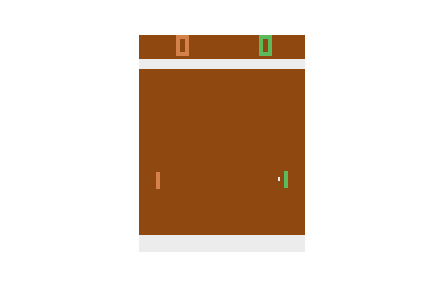
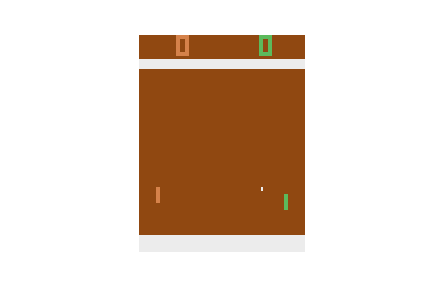
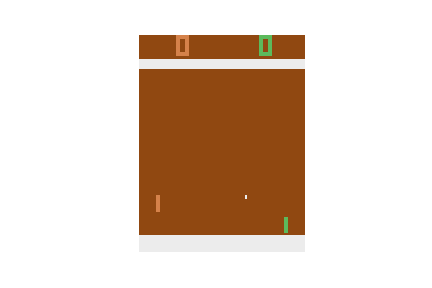
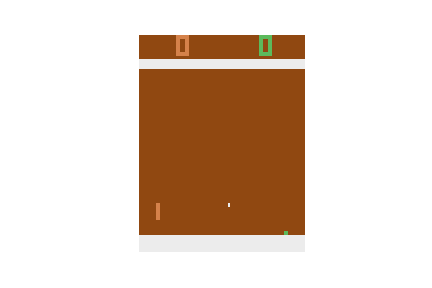
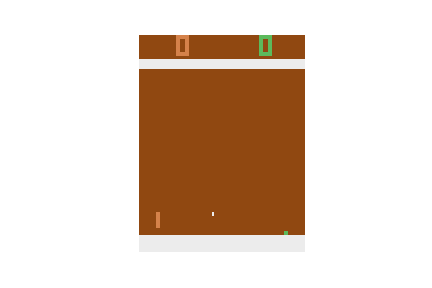
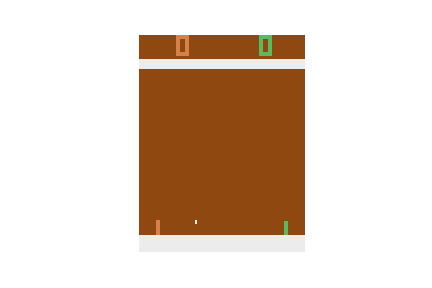
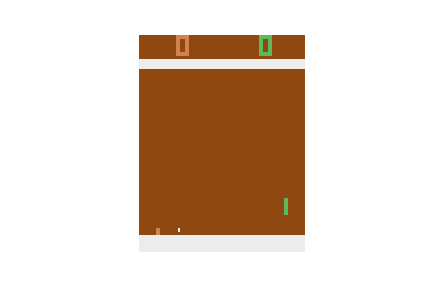
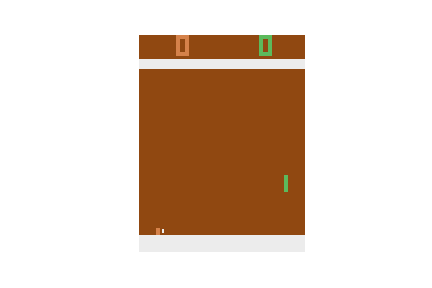
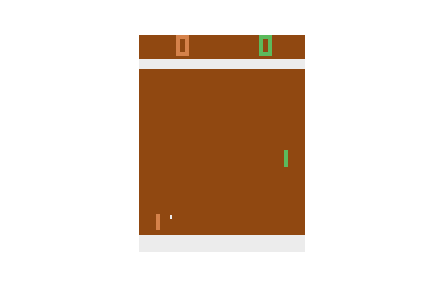
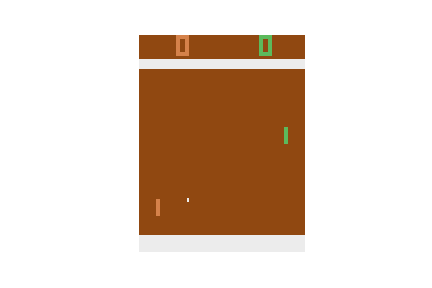
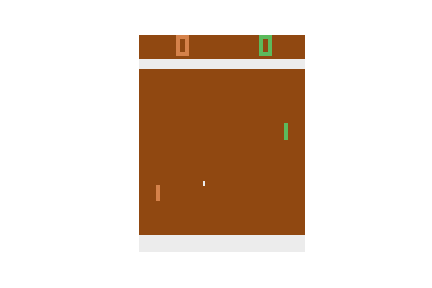
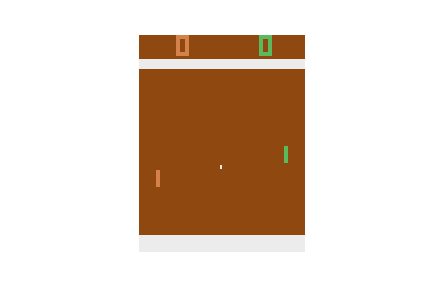
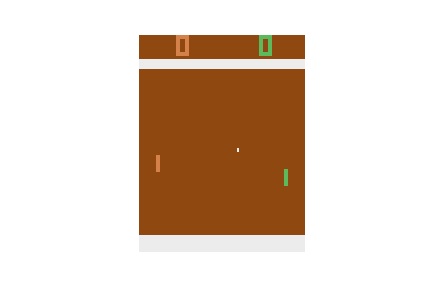
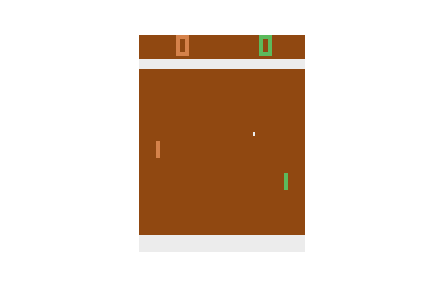
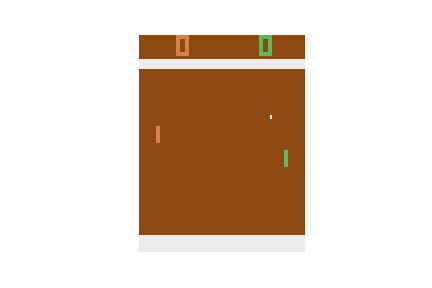
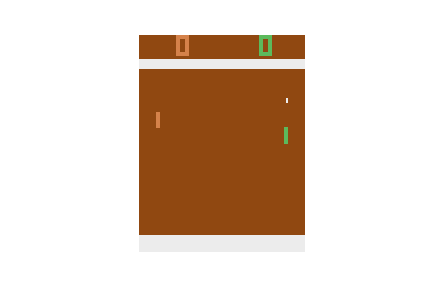
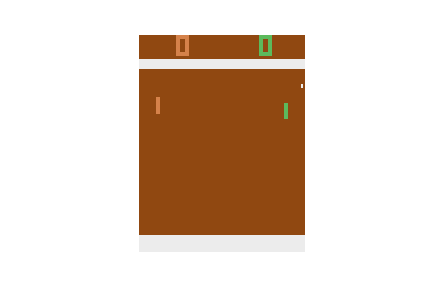
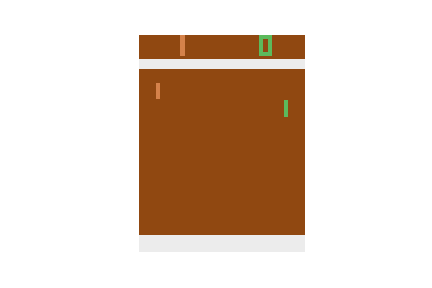
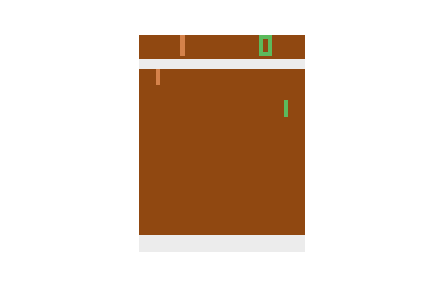
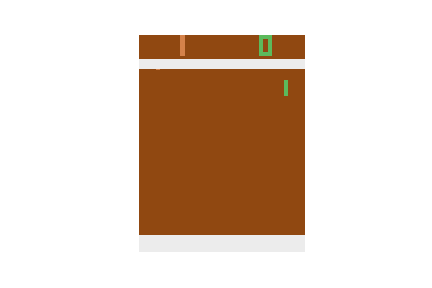
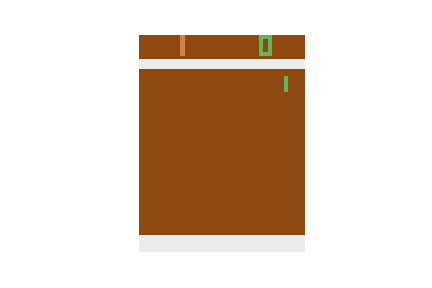
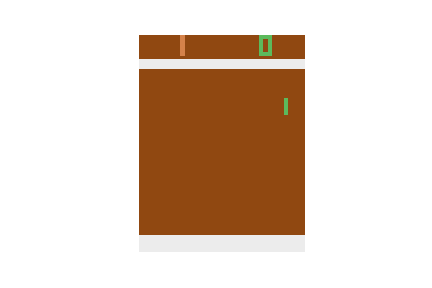
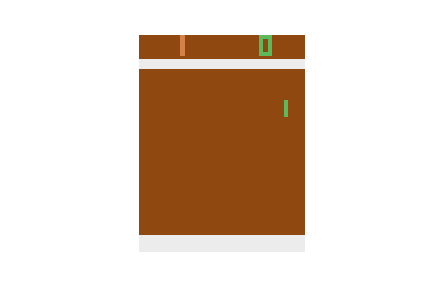
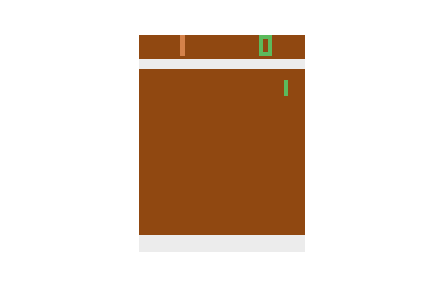
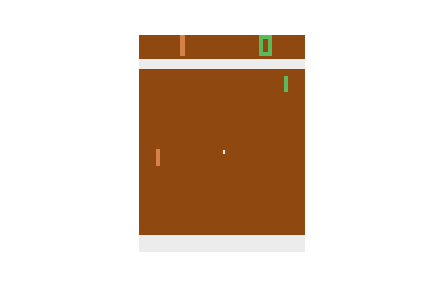
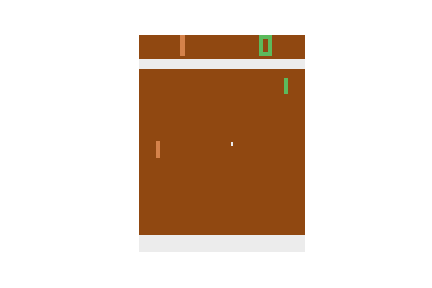
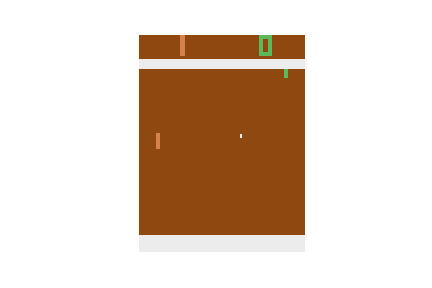
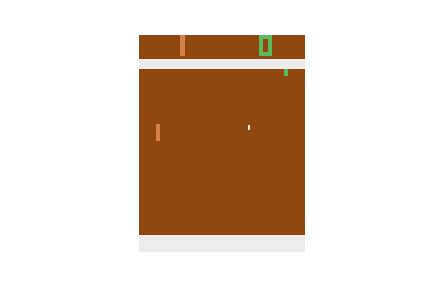
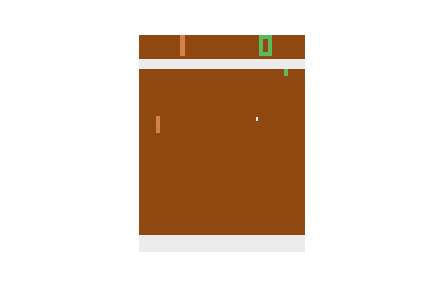
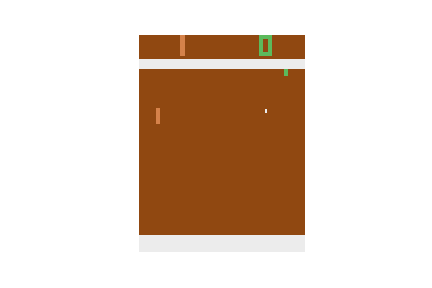
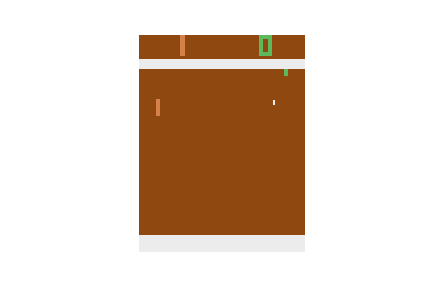
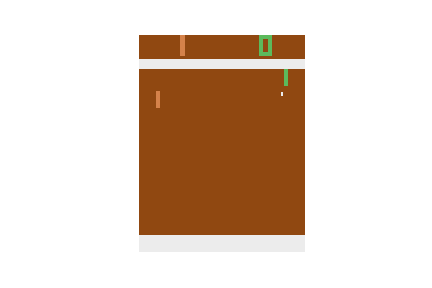
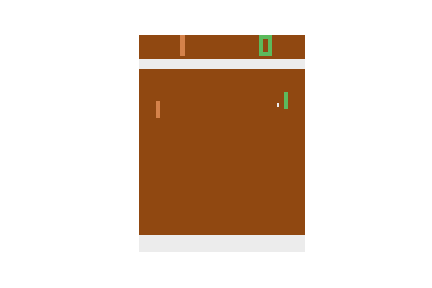
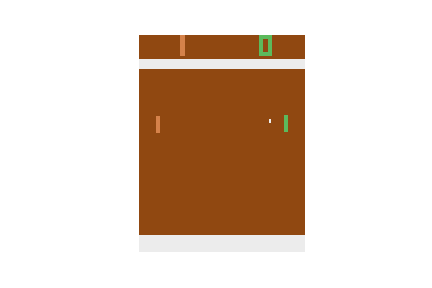
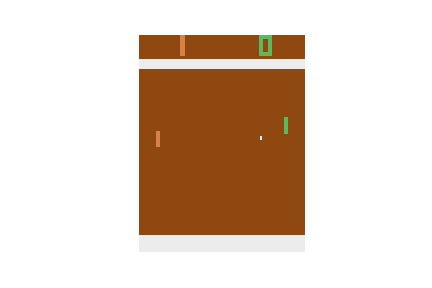
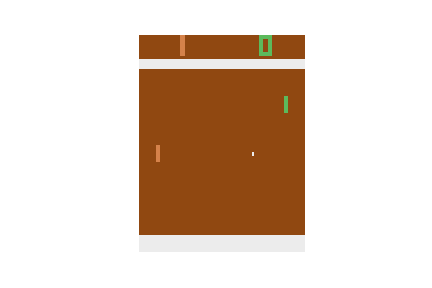
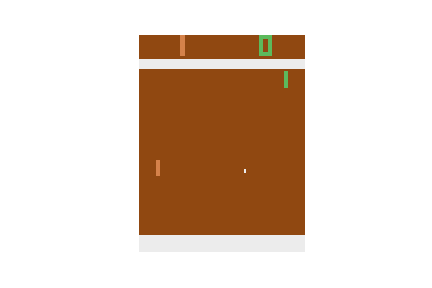
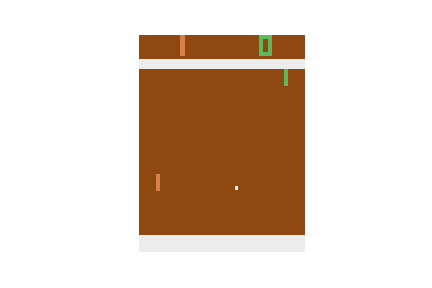
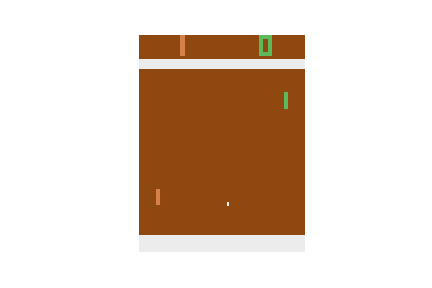
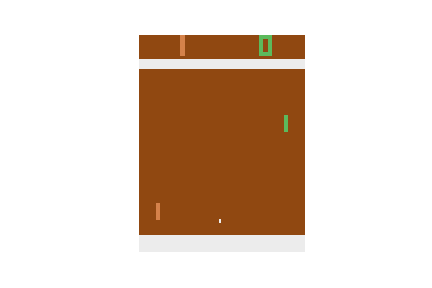
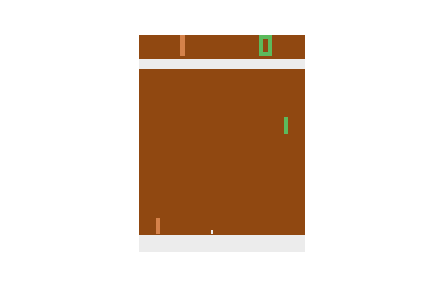
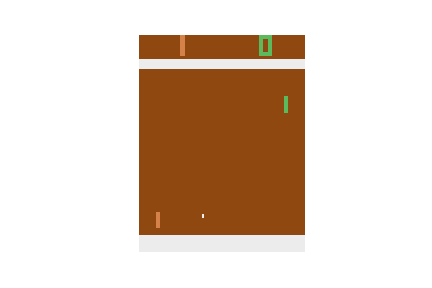
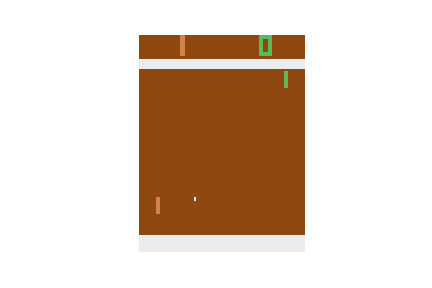
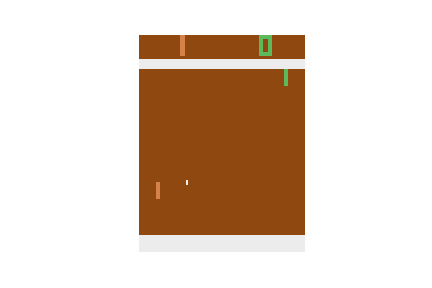
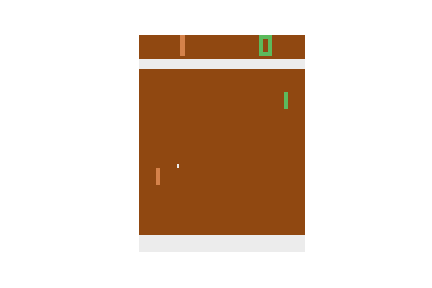
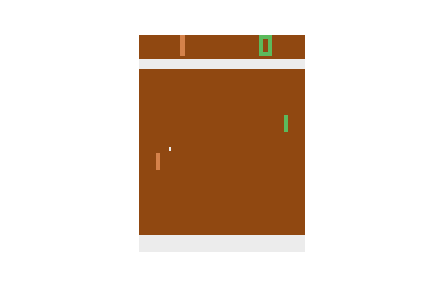
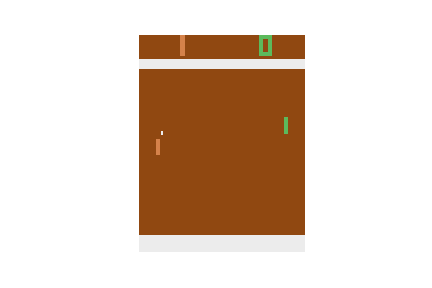
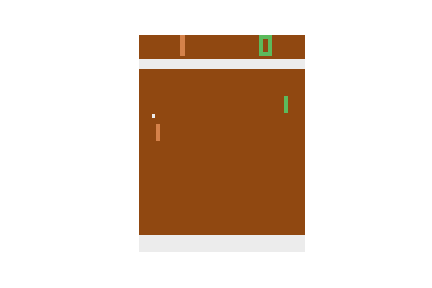
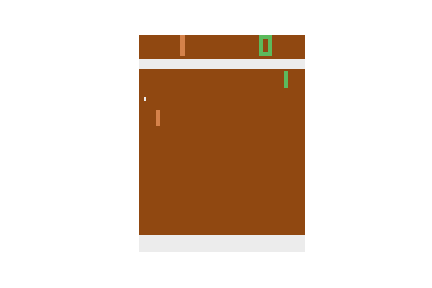
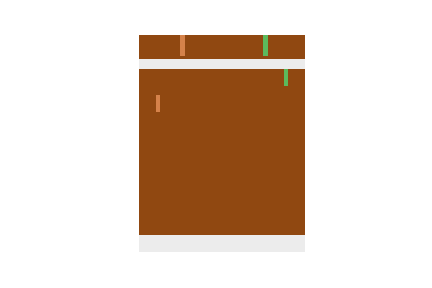
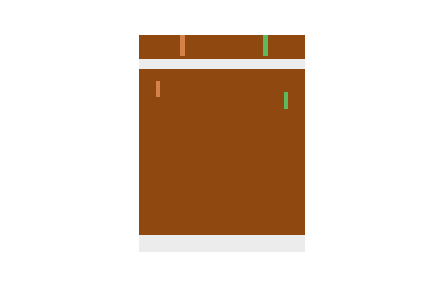
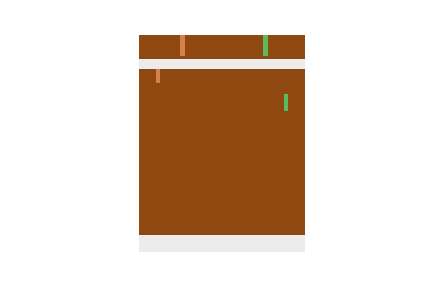
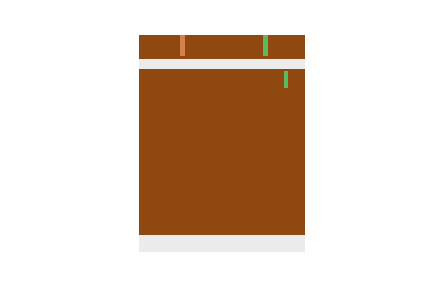
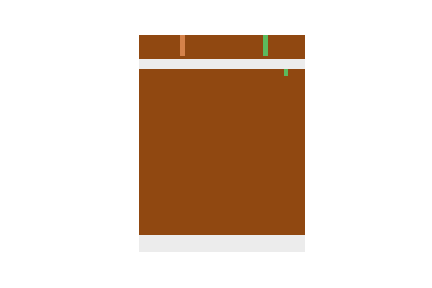
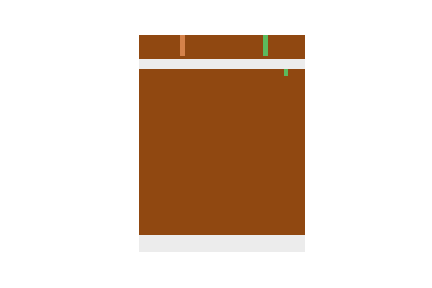
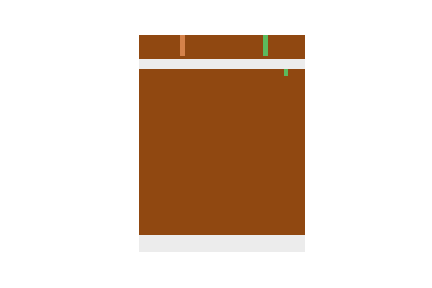
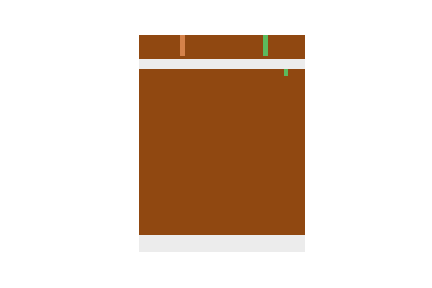
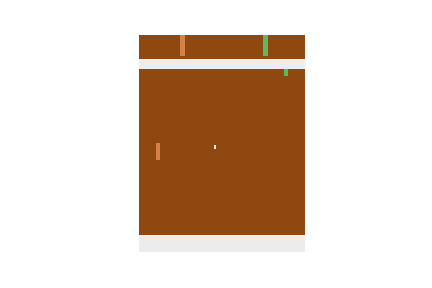
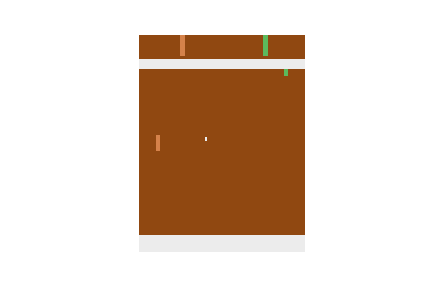
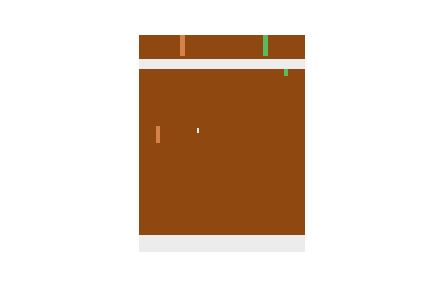
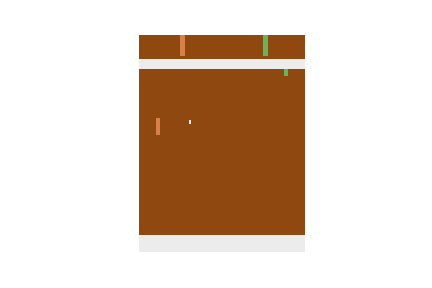
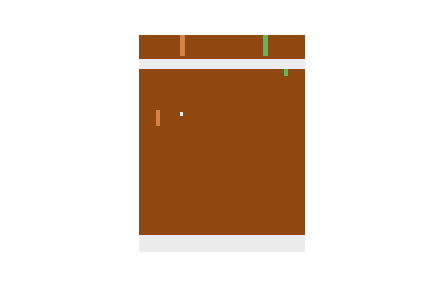
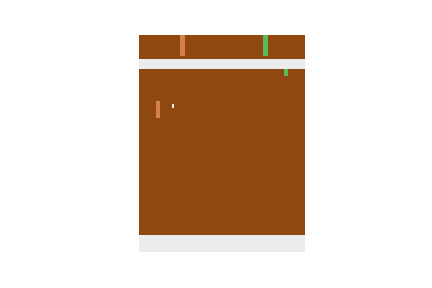
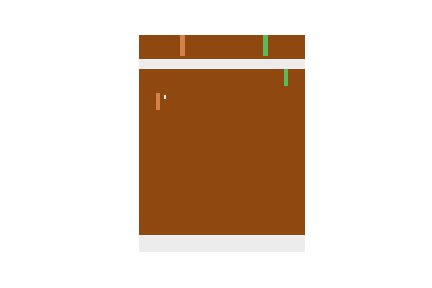
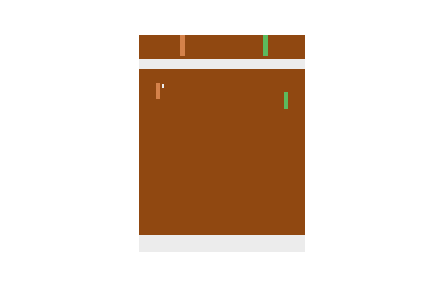
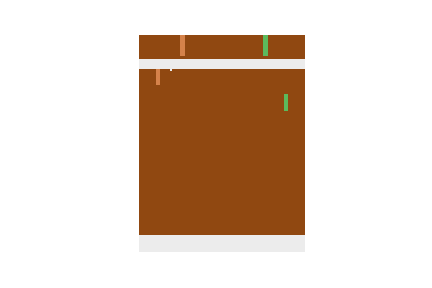
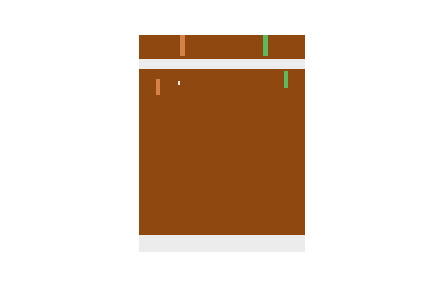
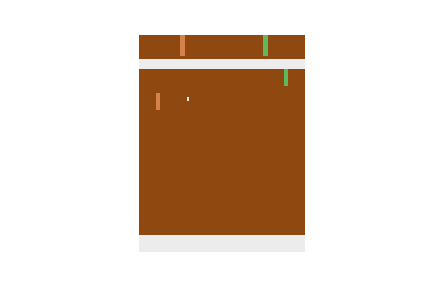
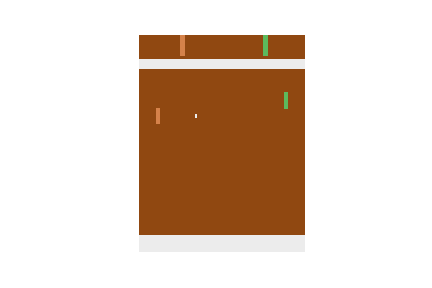
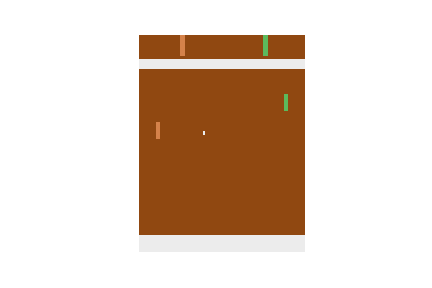
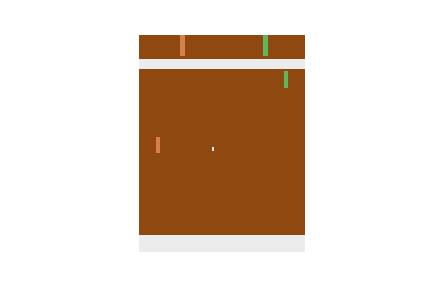
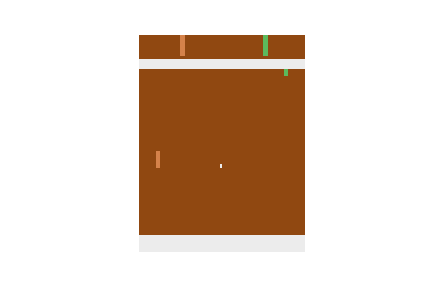
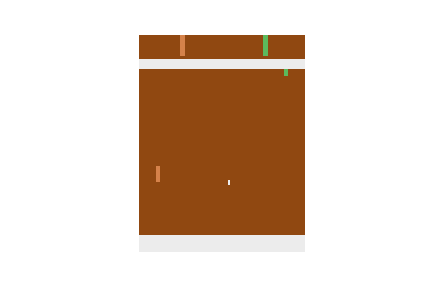
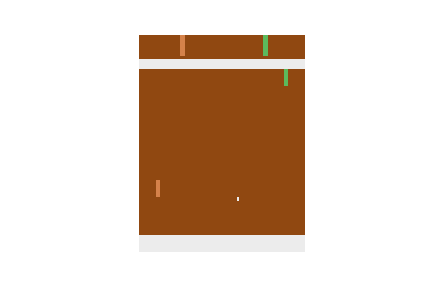
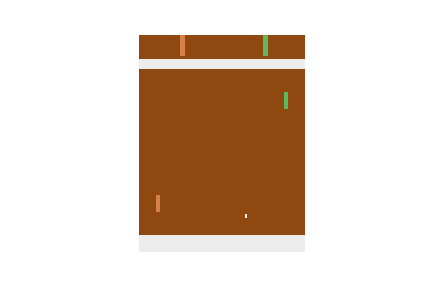
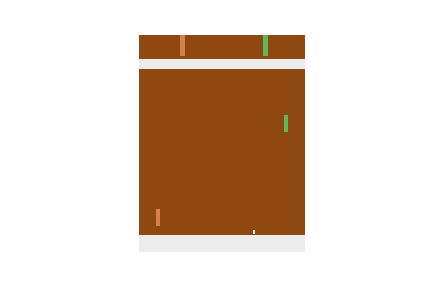
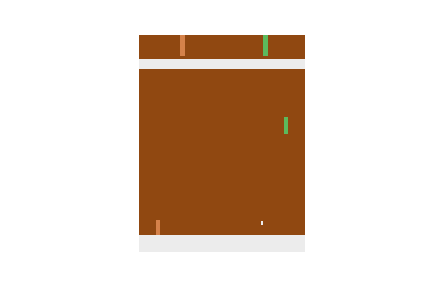
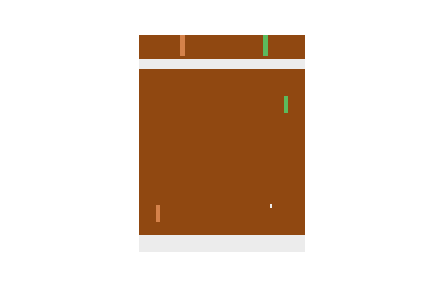
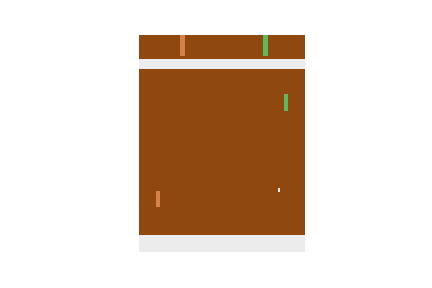
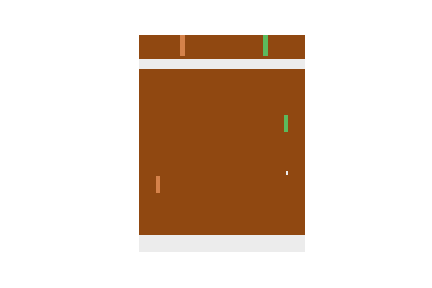
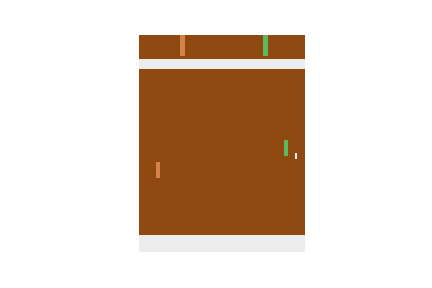
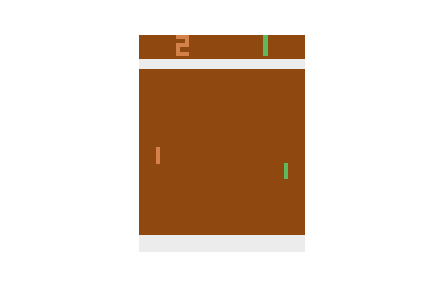
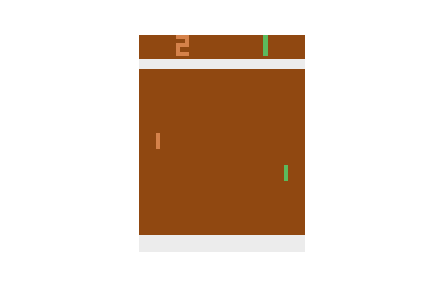
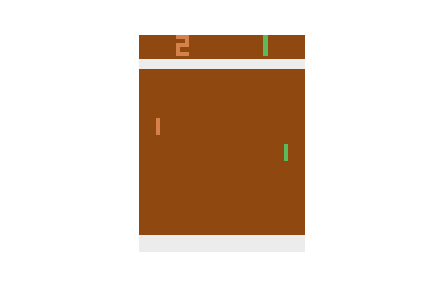
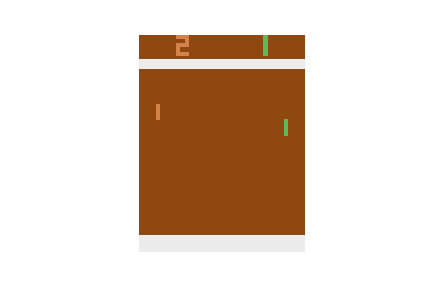
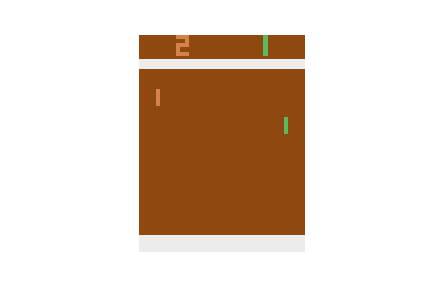
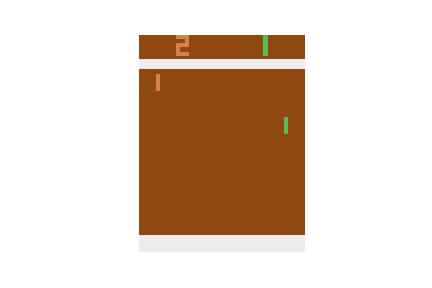
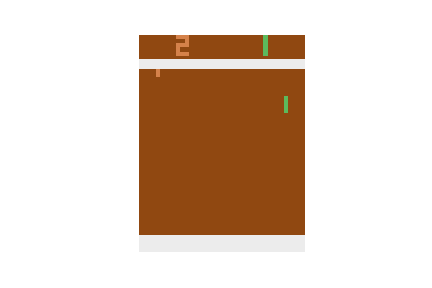
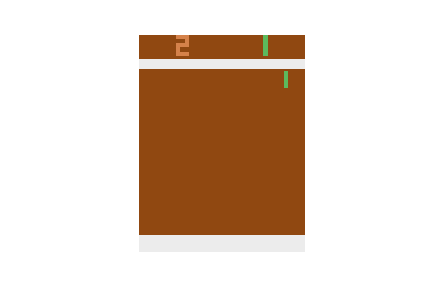
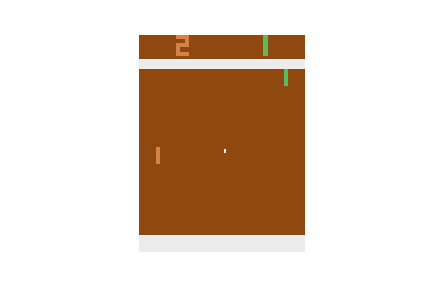
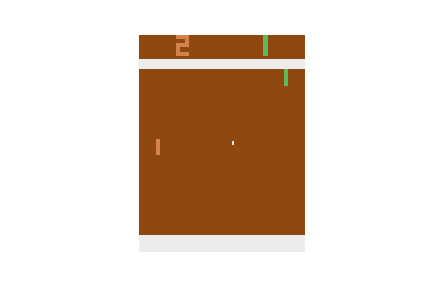
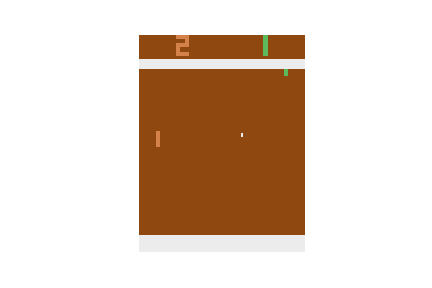
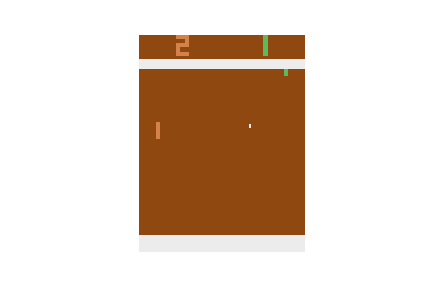
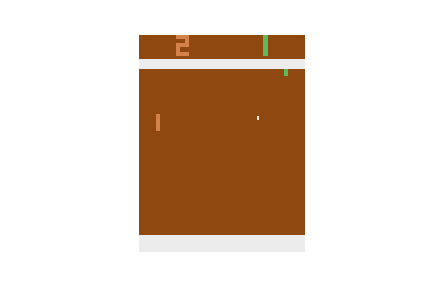
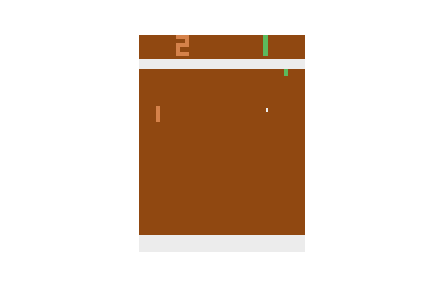
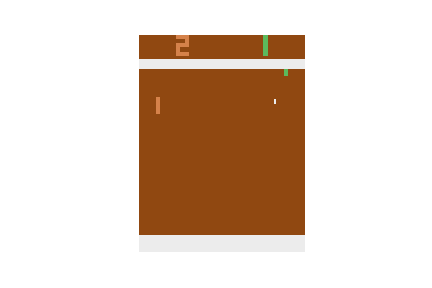
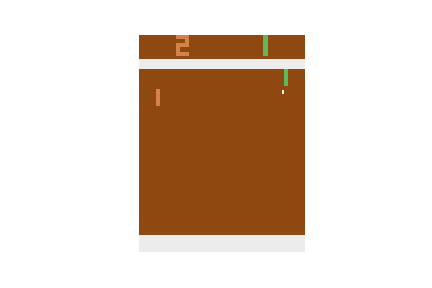
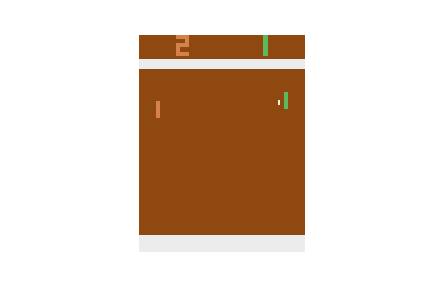
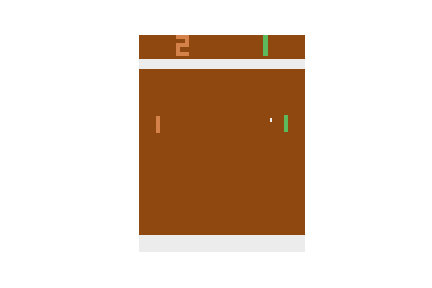
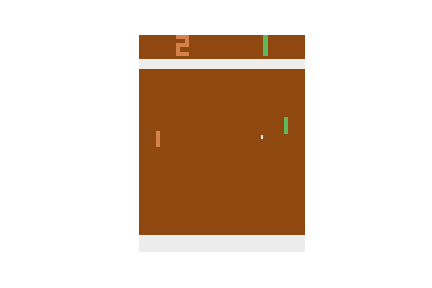
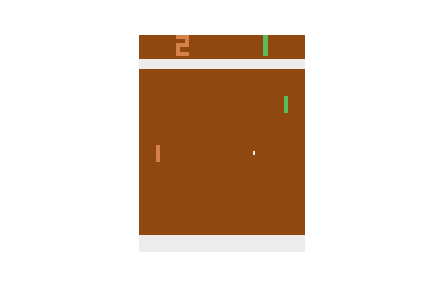
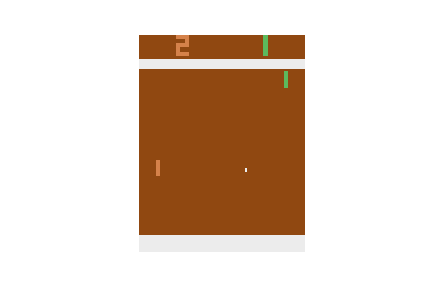
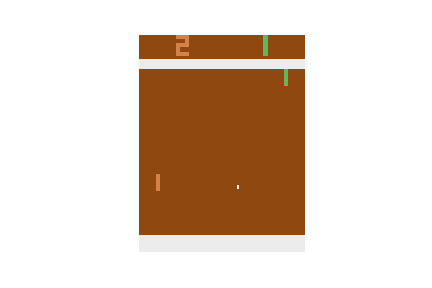
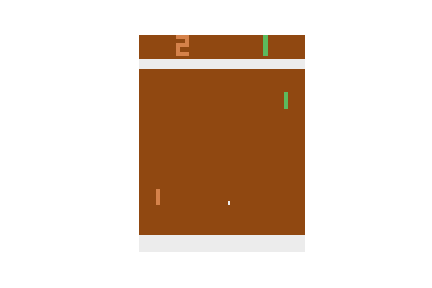
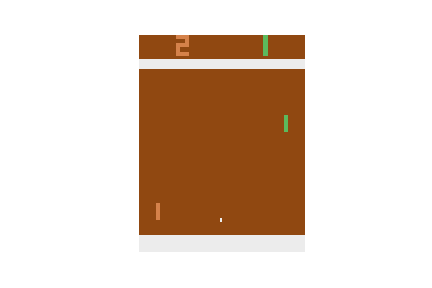
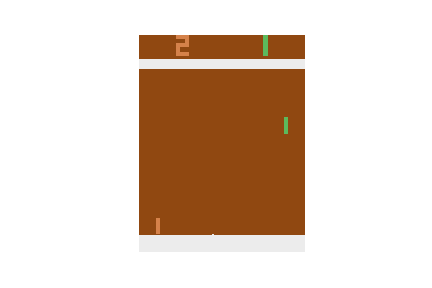
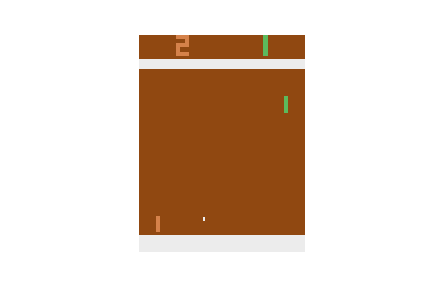
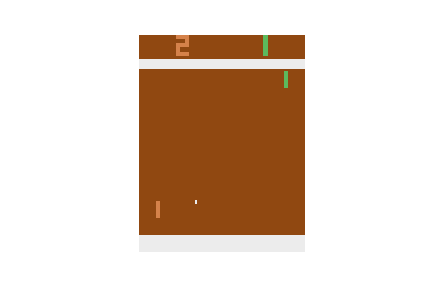
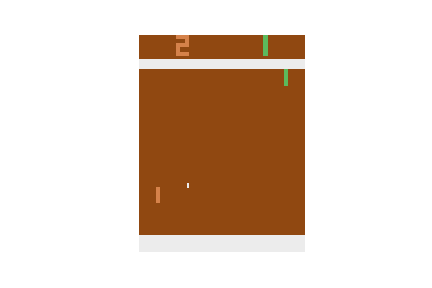
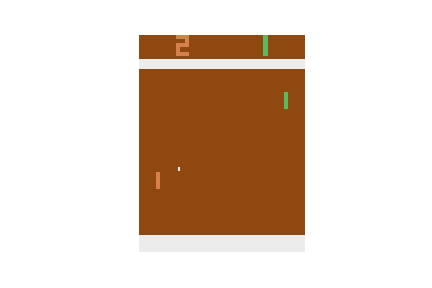
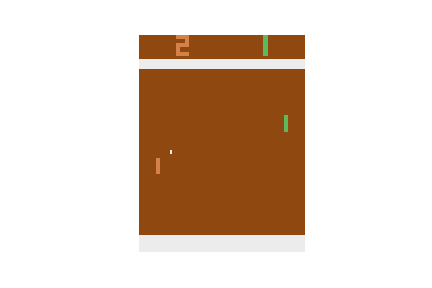
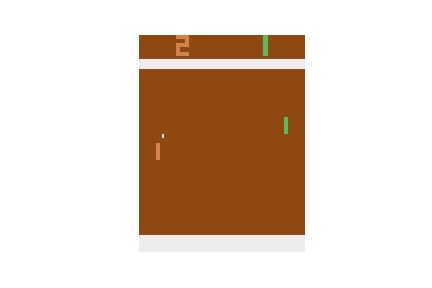
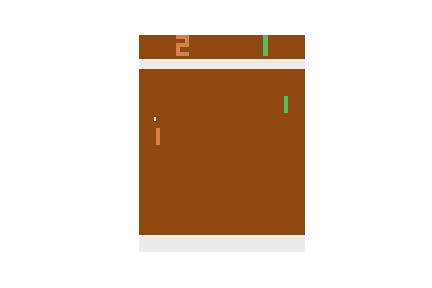
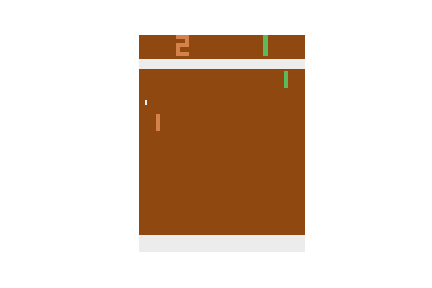
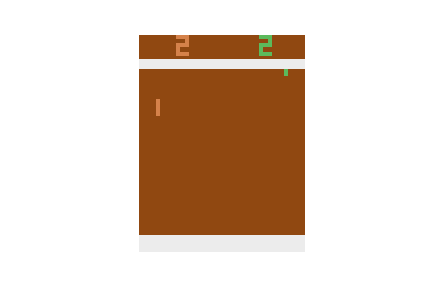
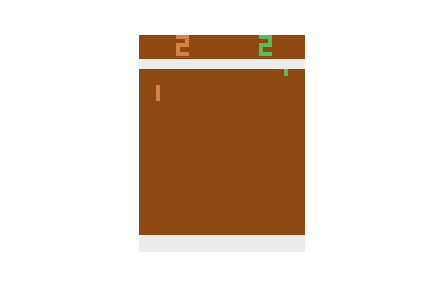
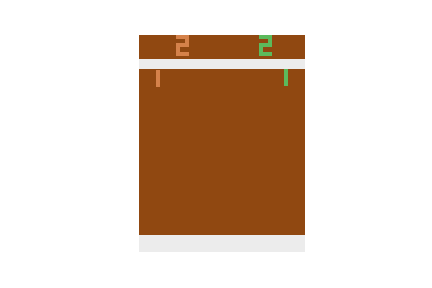
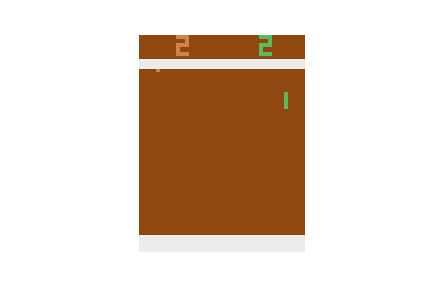
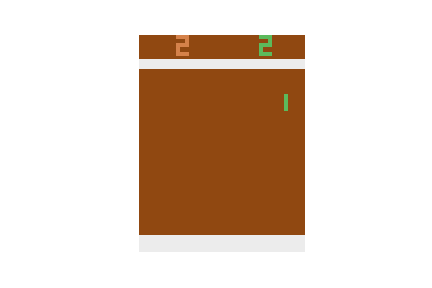
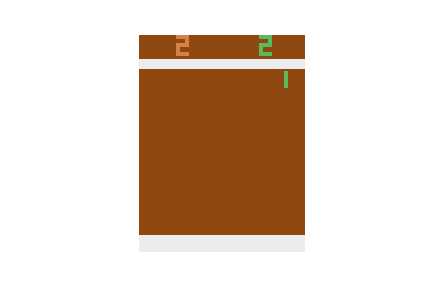
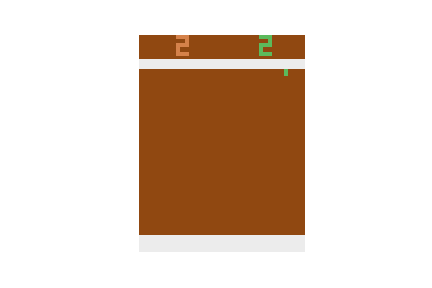
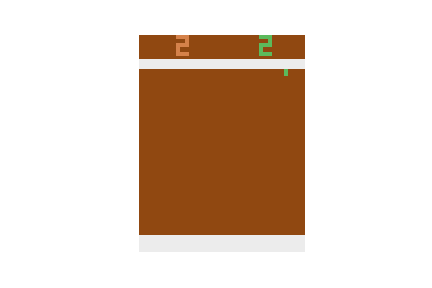
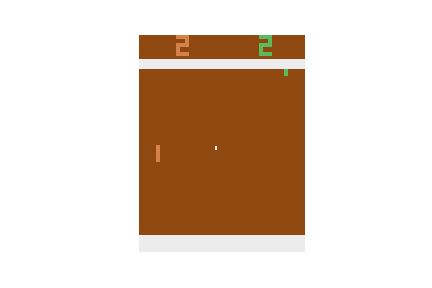
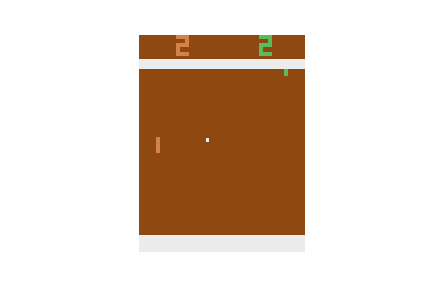
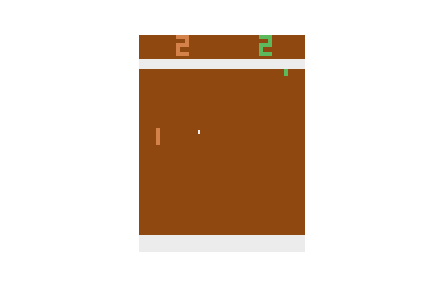
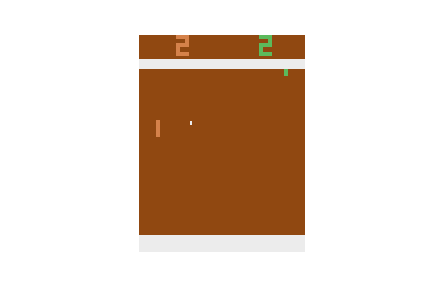
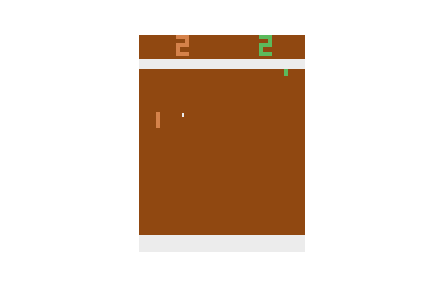
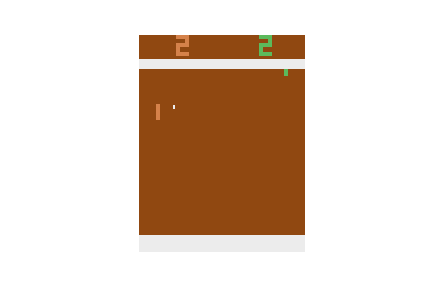
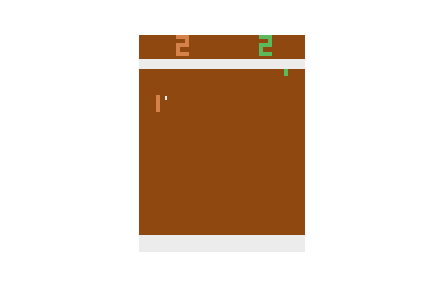
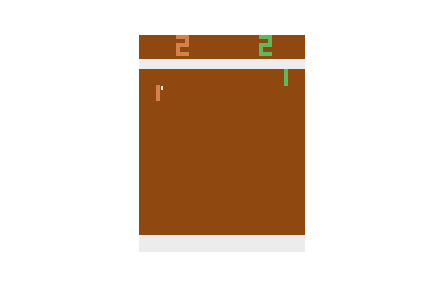
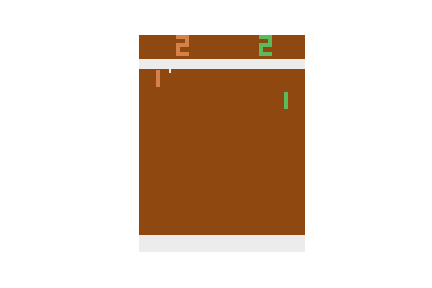
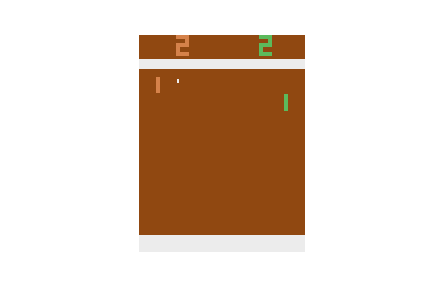
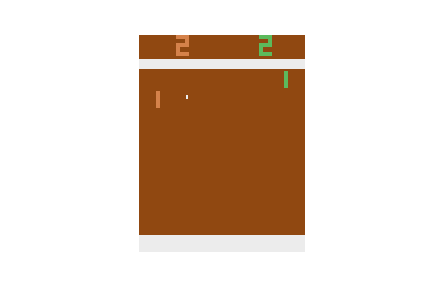
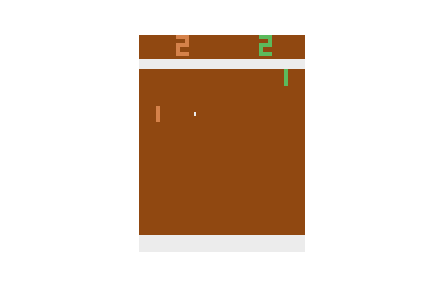
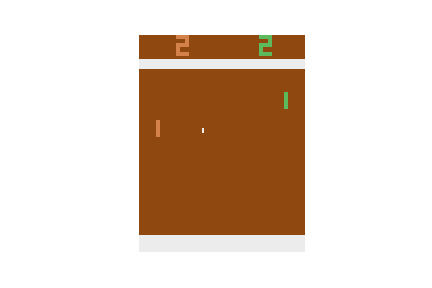
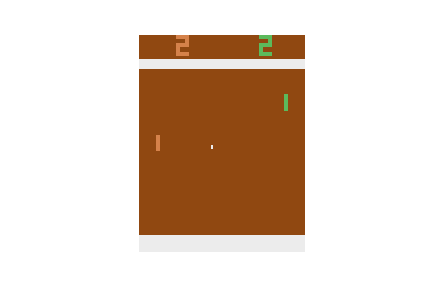
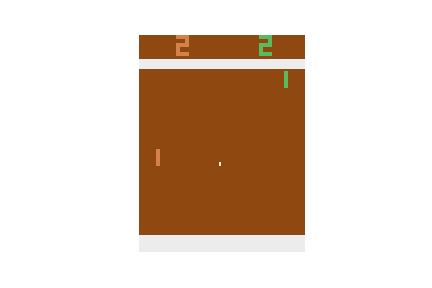
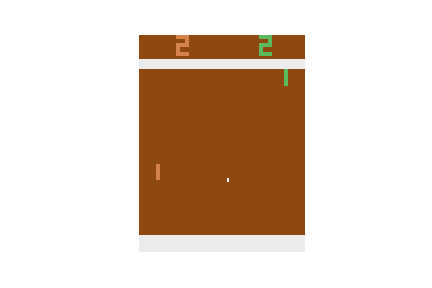
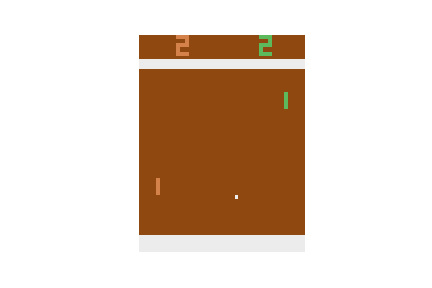
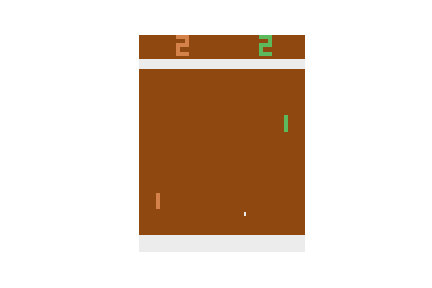
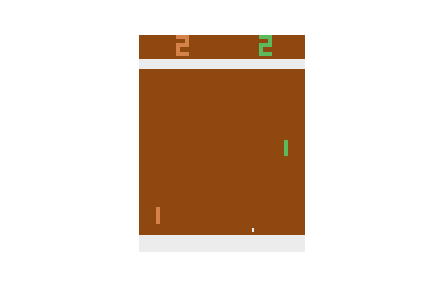
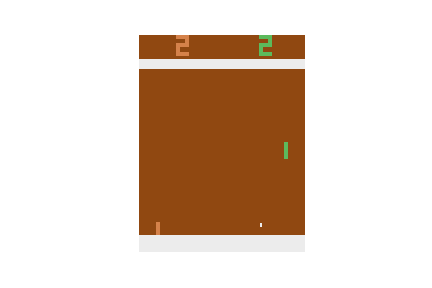
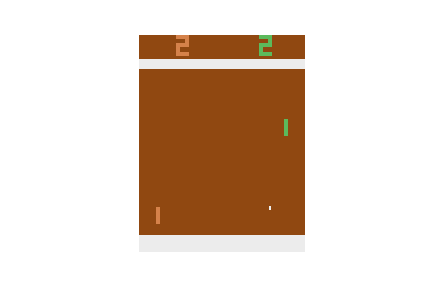
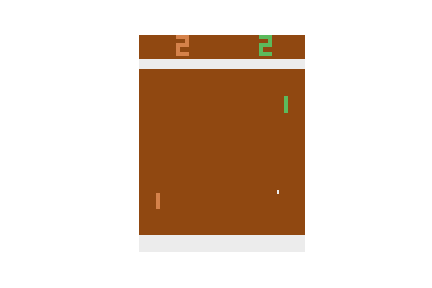
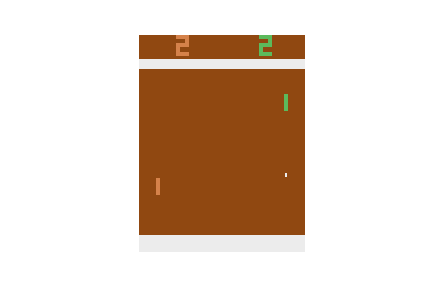
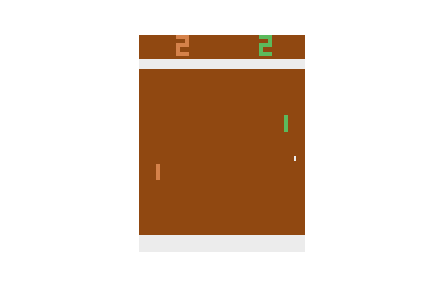
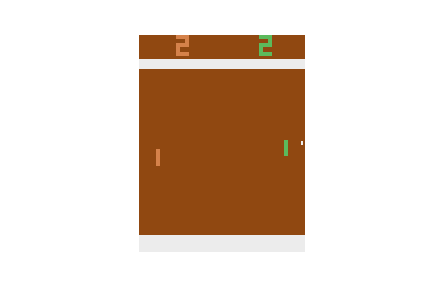
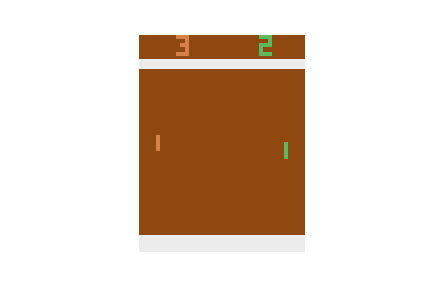
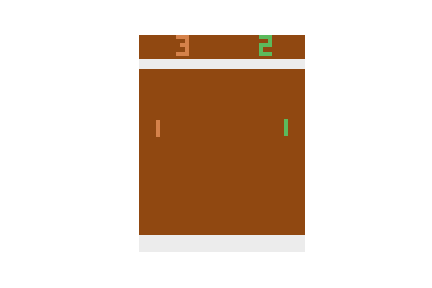
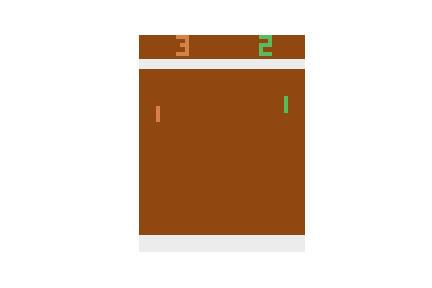
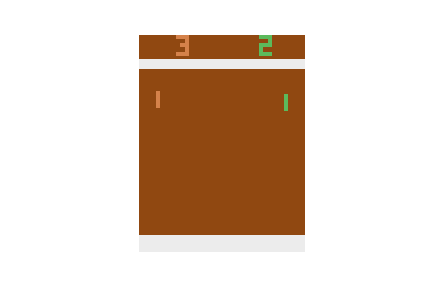
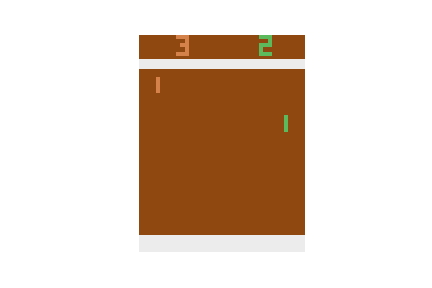
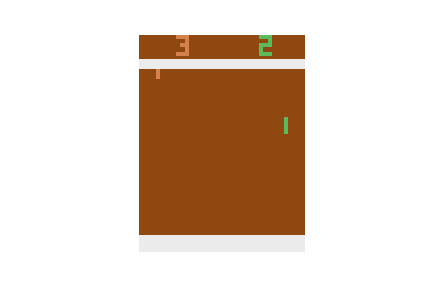
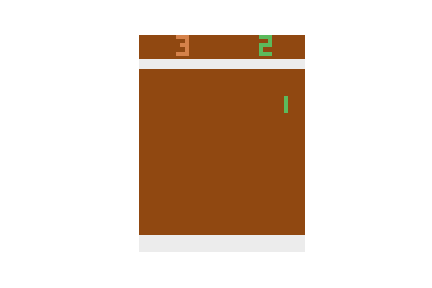
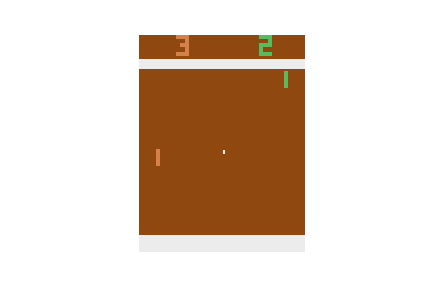
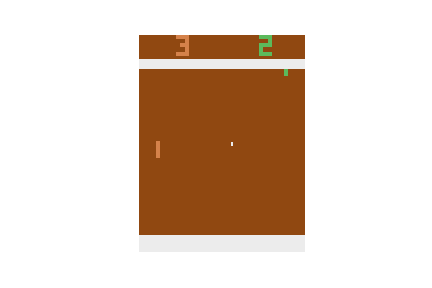
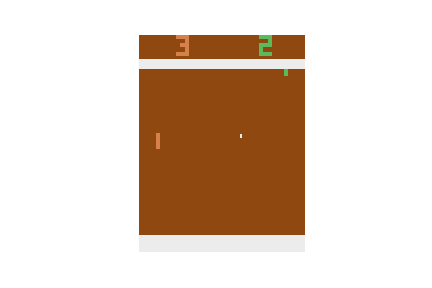
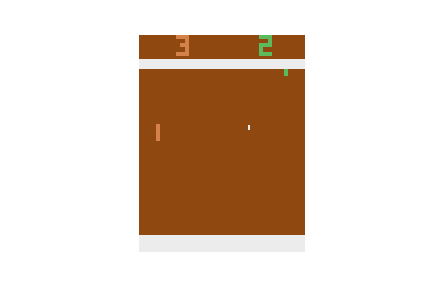
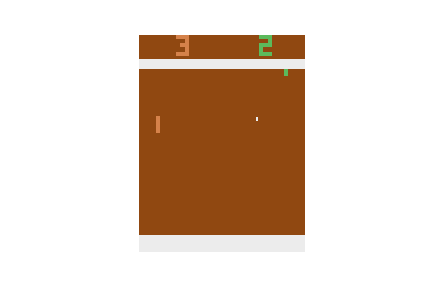
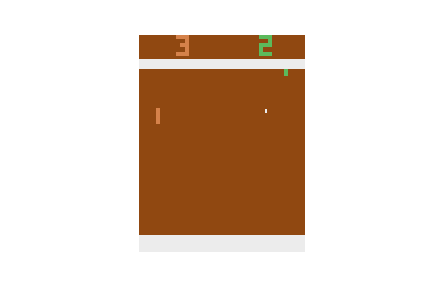
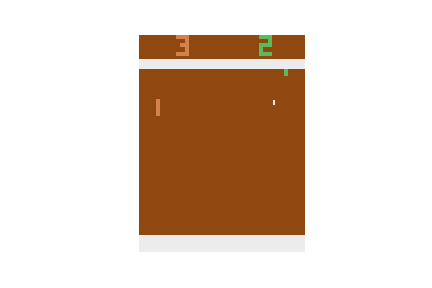
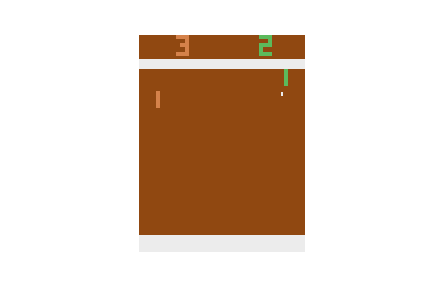
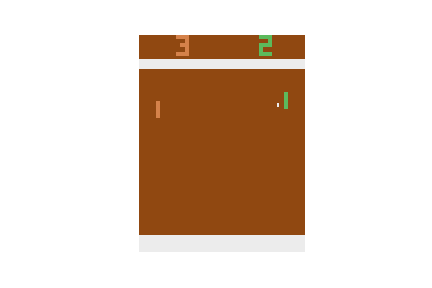
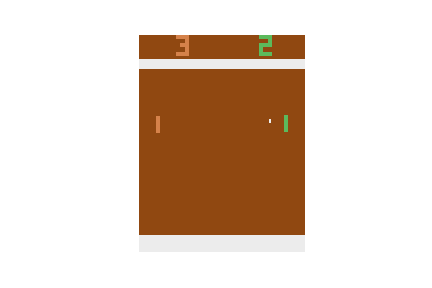
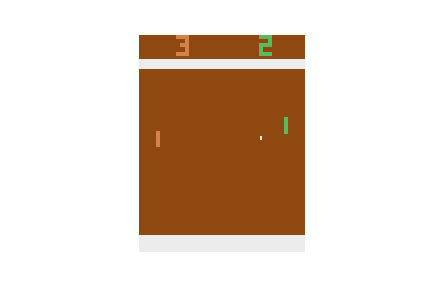
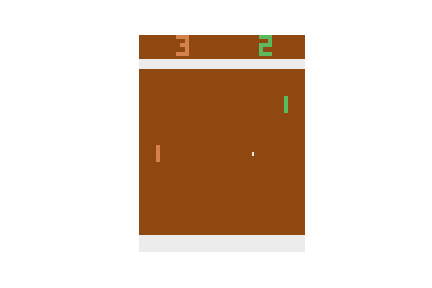
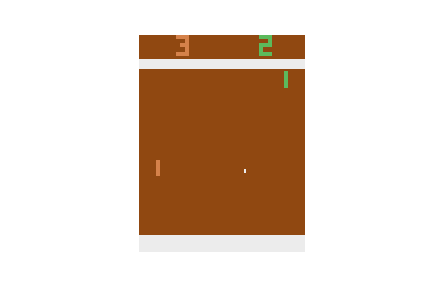
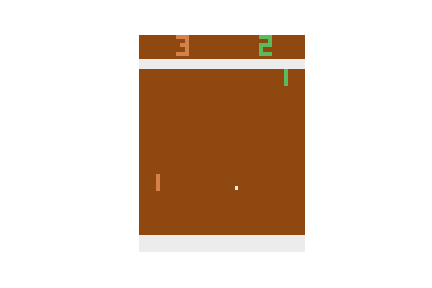
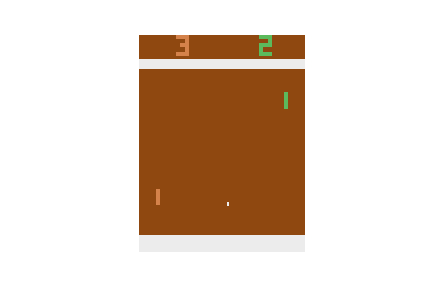
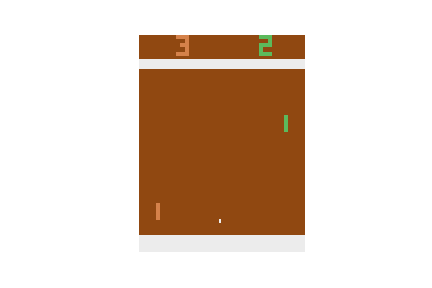
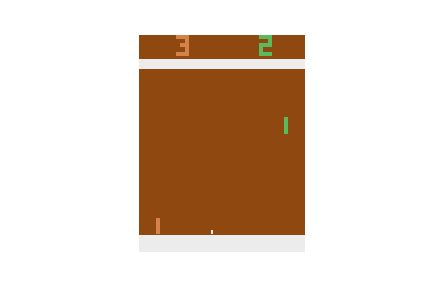
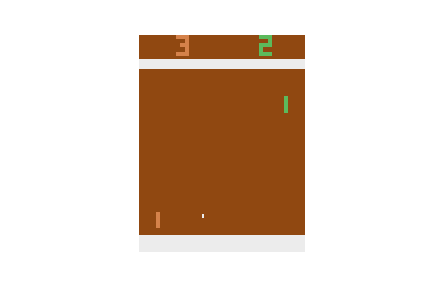
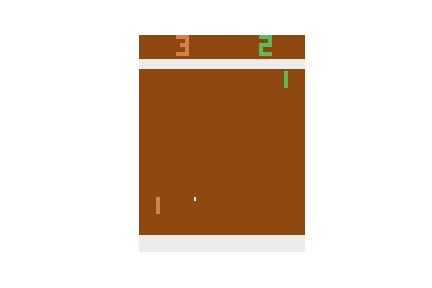
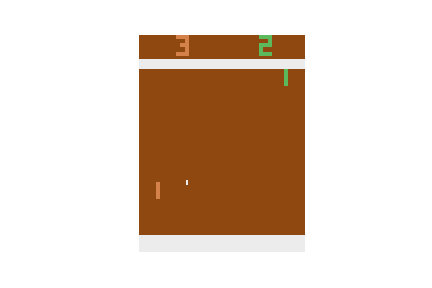
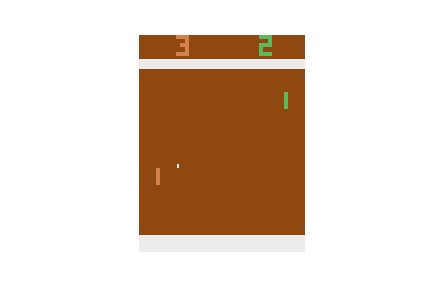

In [8]:
pong_utils.play(env, policy, time=200) 

In [11]:
# save your policy!
time_of_save_string = get_time_string()
time_of_save_time = time.time()
torch.save(policy, f'PPO-{time_of_save_string}.policy')
print(f'Timestamp: {time_of_save_string}')


Timestamp: 20200725120549


CPU



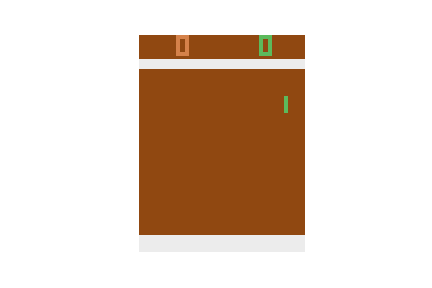
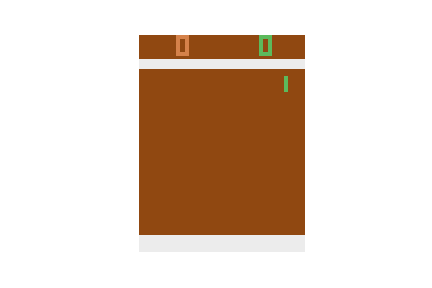
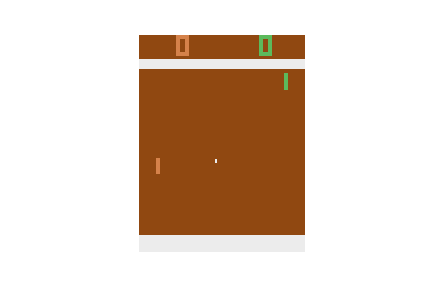
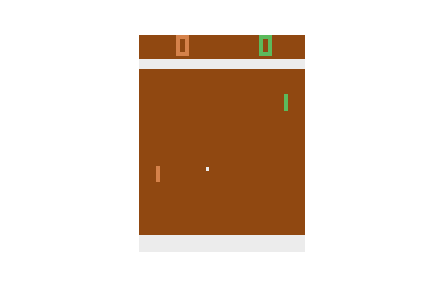
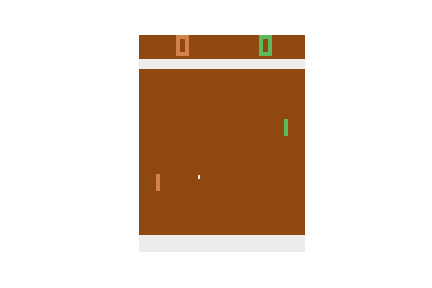
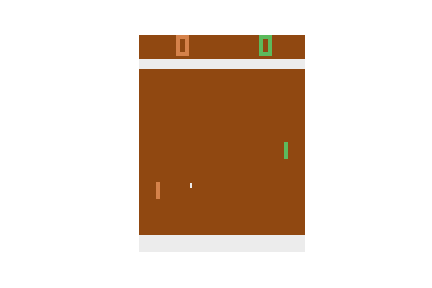
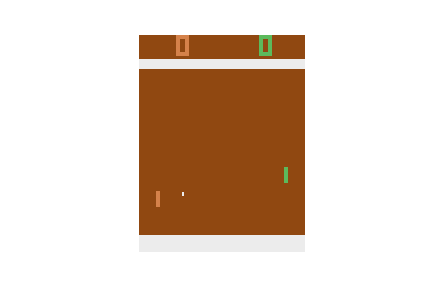
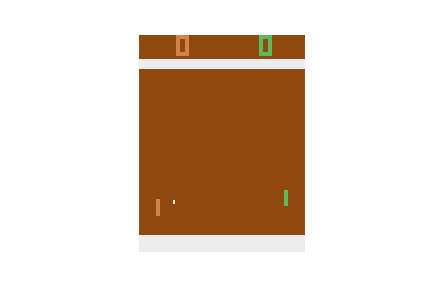
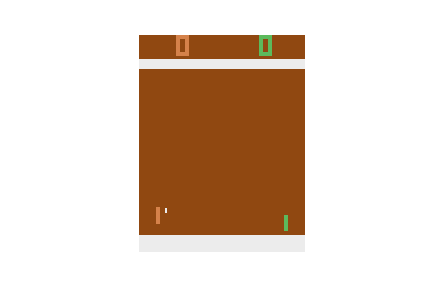
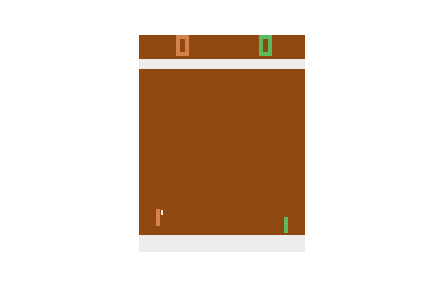
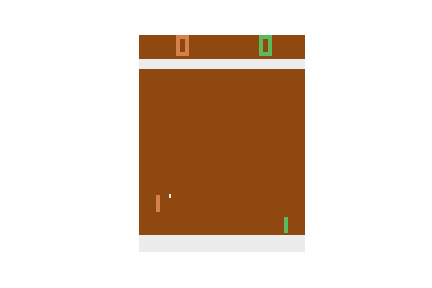
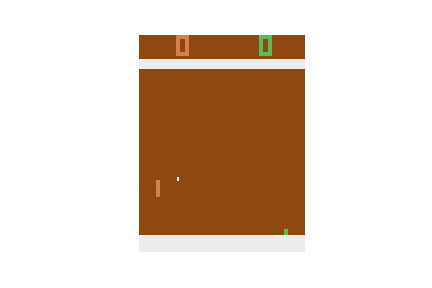
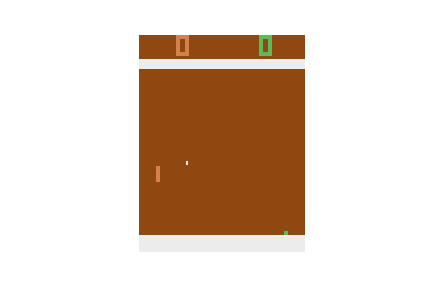
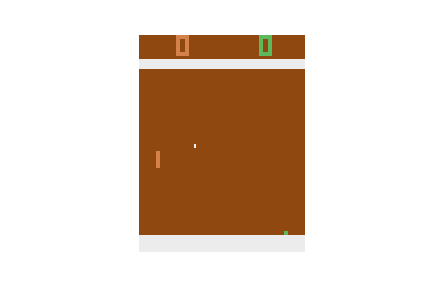
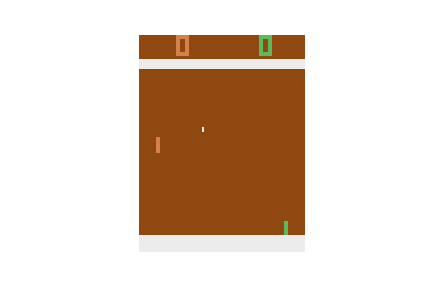
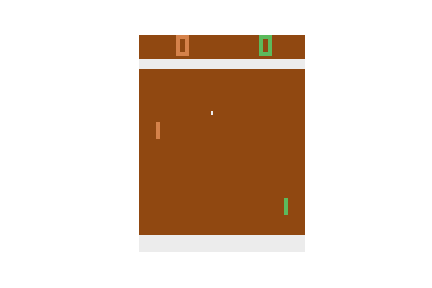
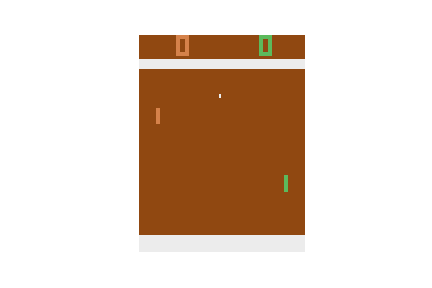
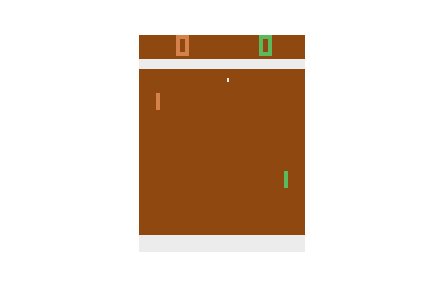
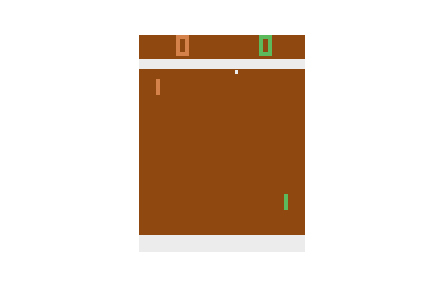
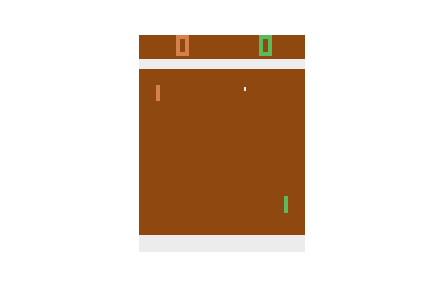
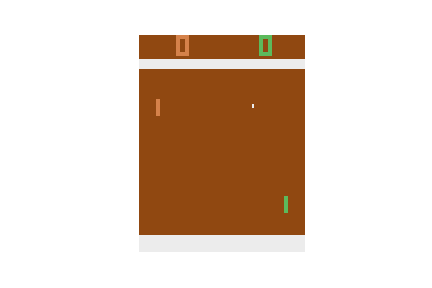
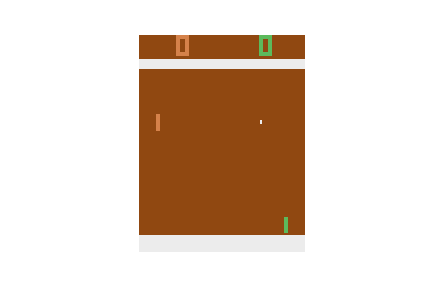
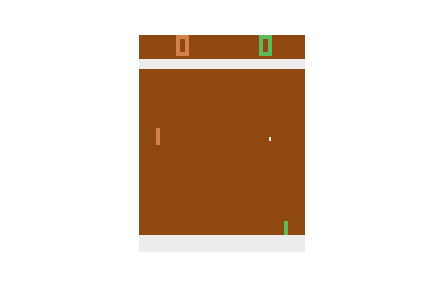
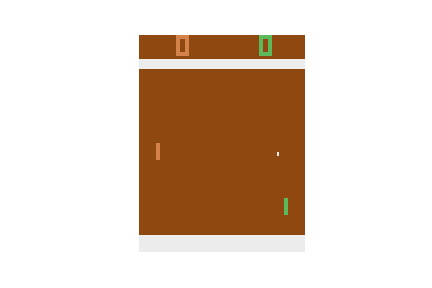
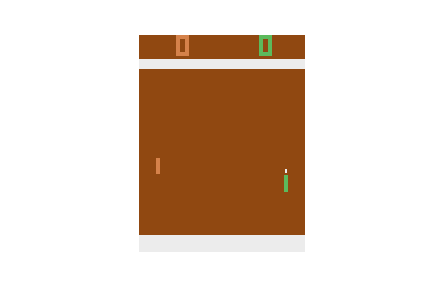
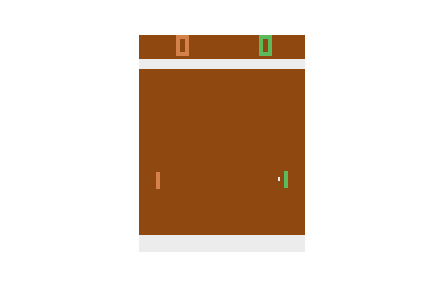
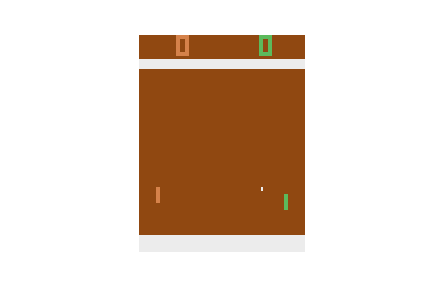
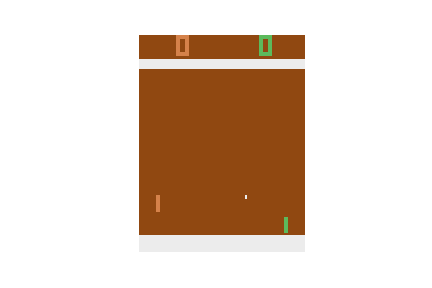
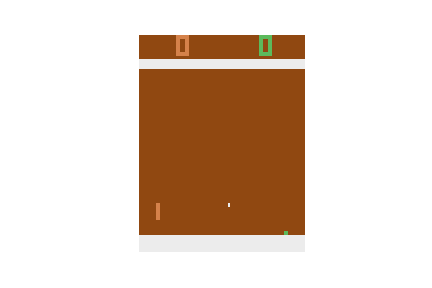
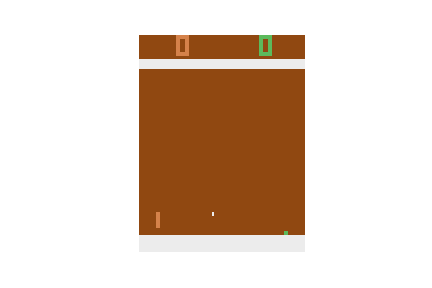
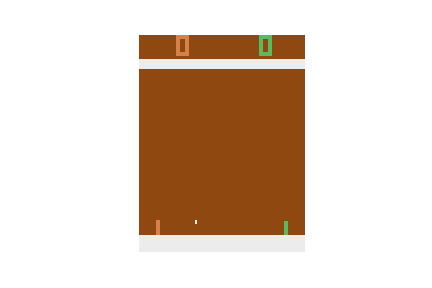
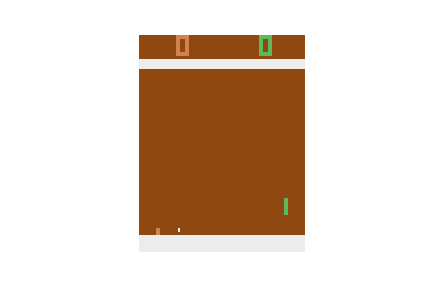
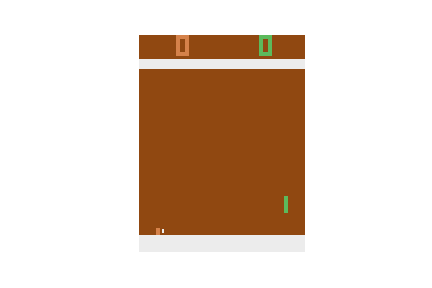
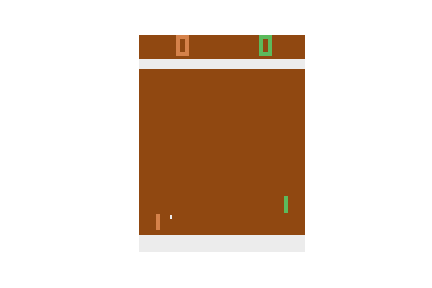
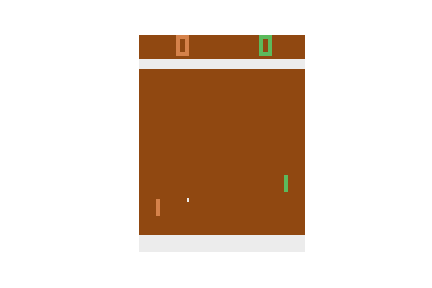
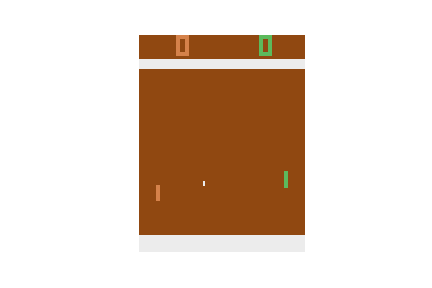
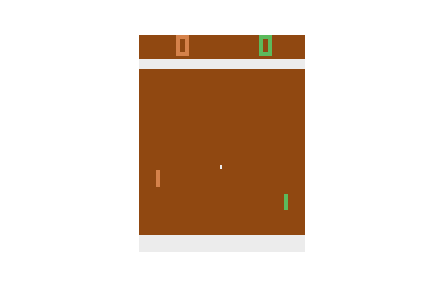
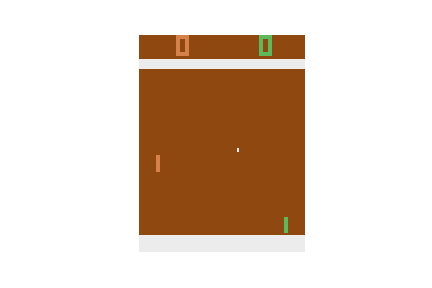
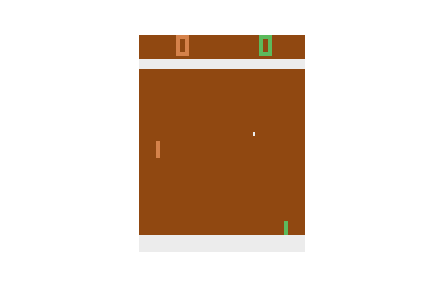
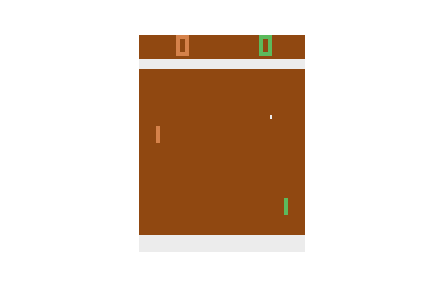
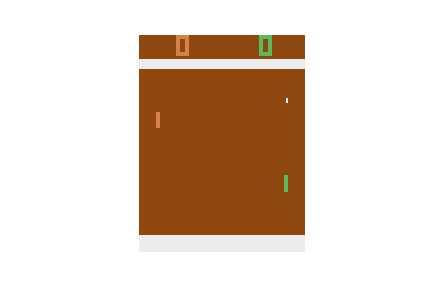
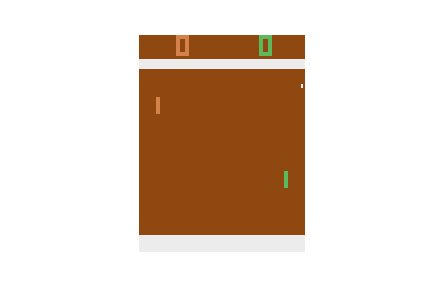
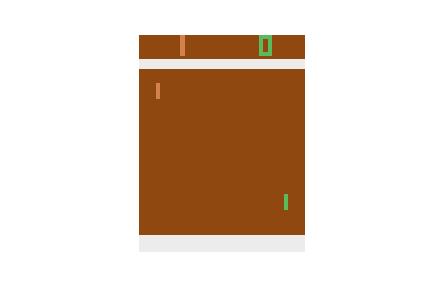
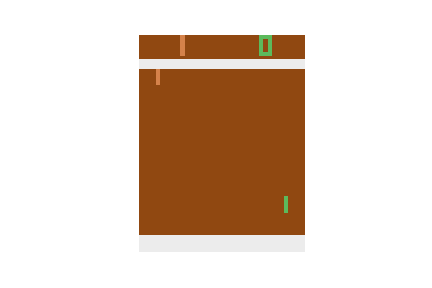
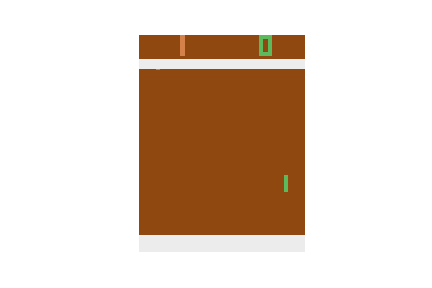
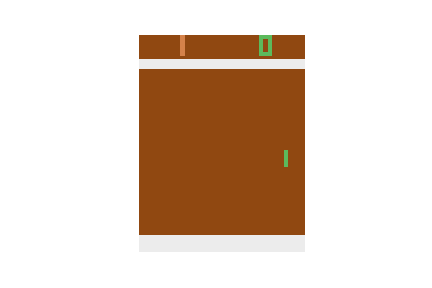
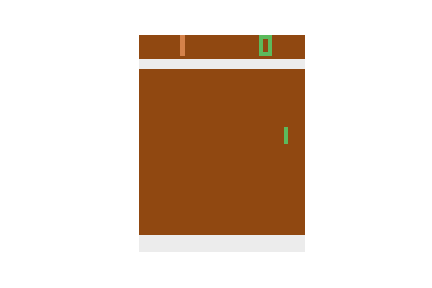
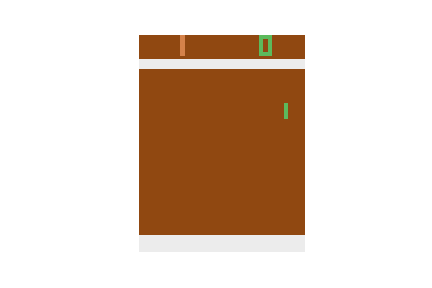
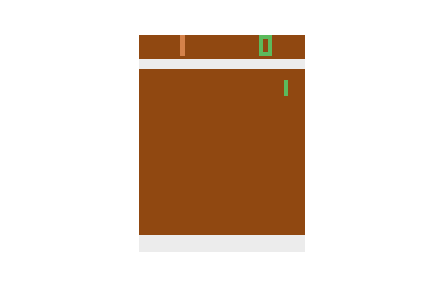
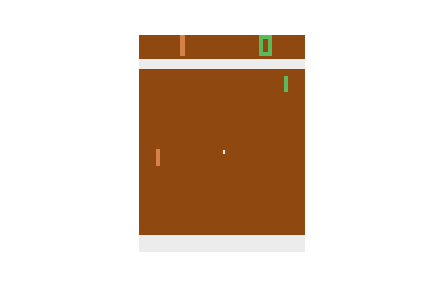
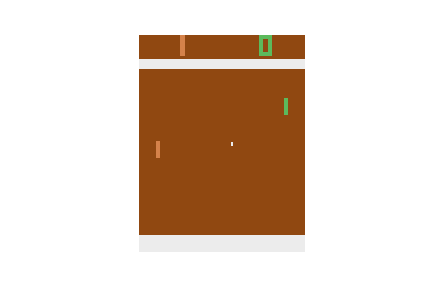
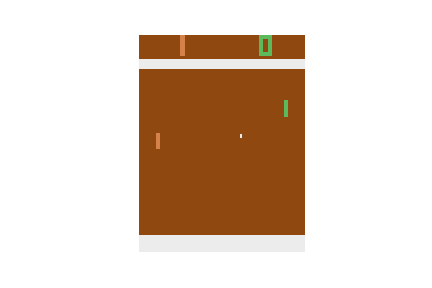
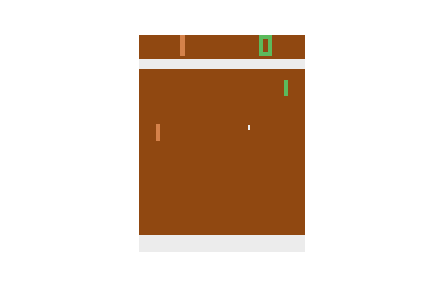
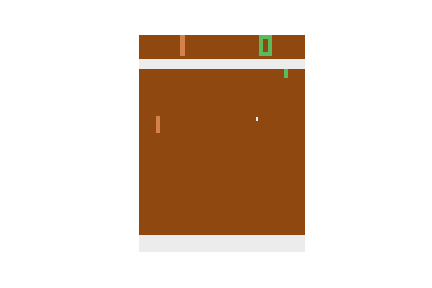
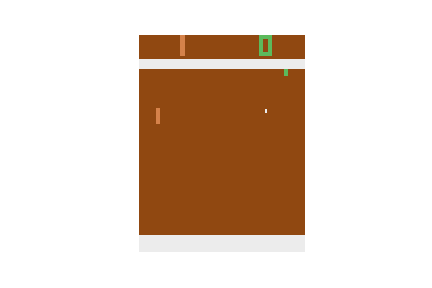
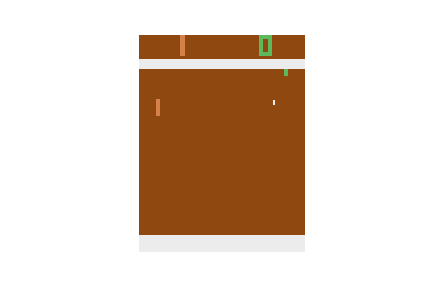
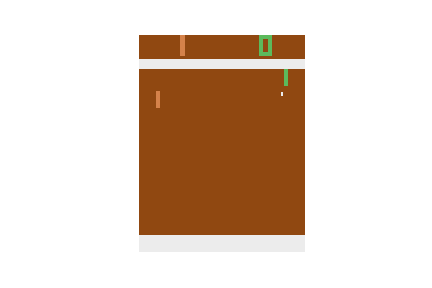
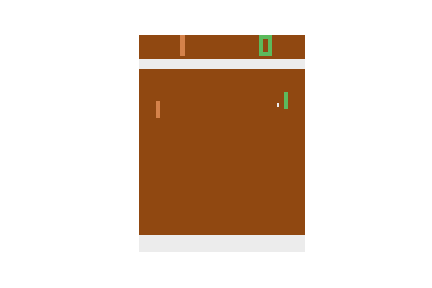
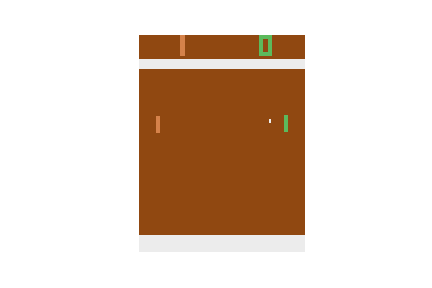
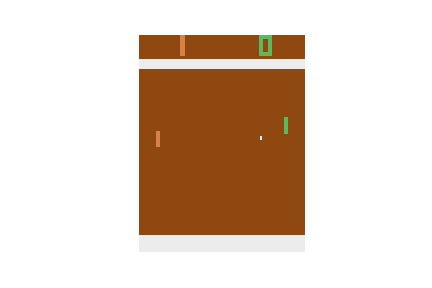
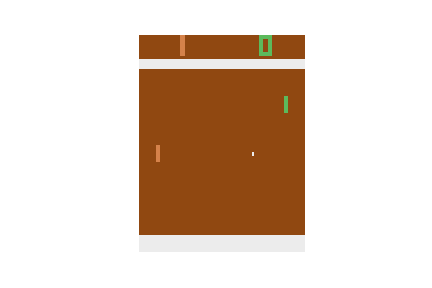
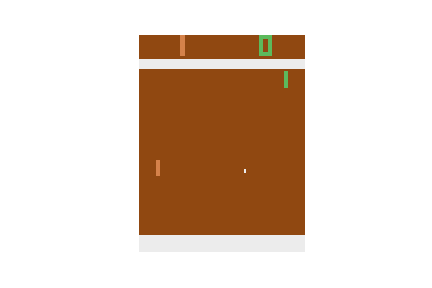
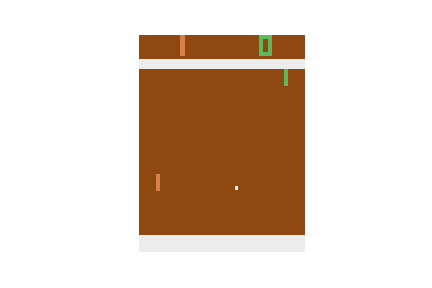
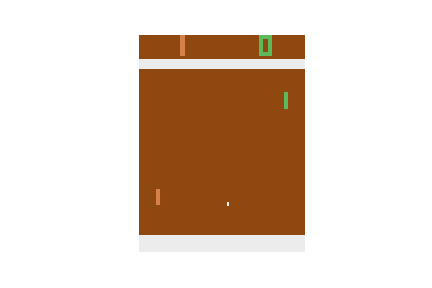
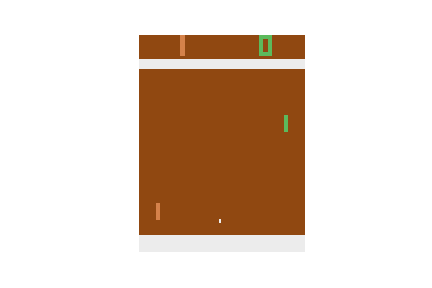
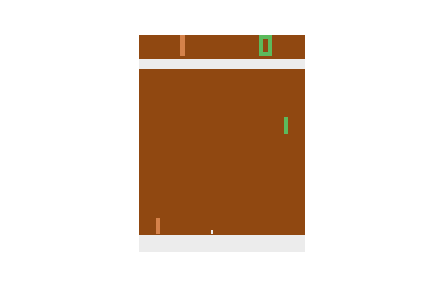
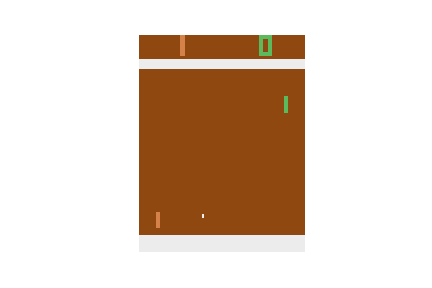
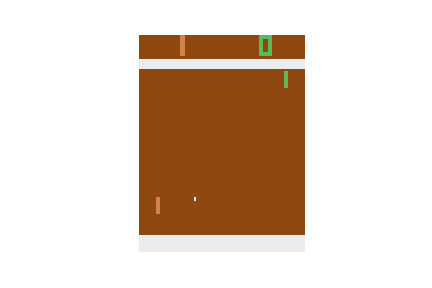
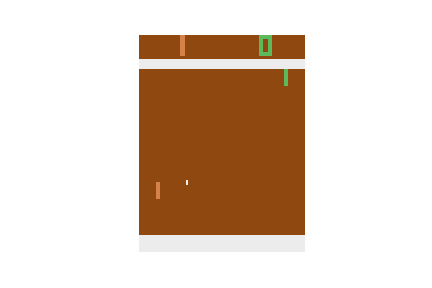
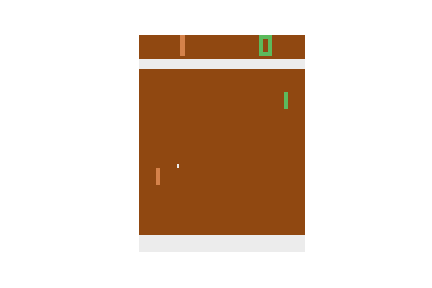
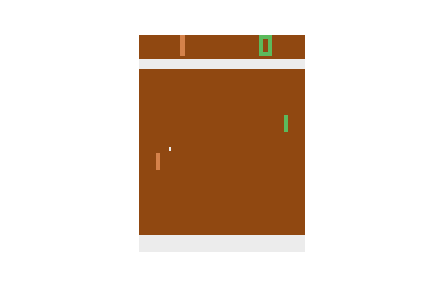
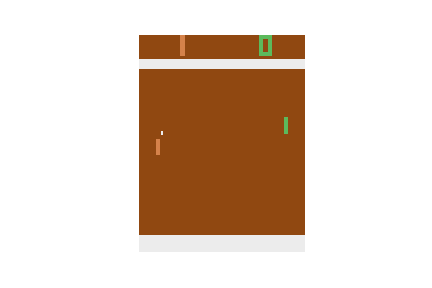
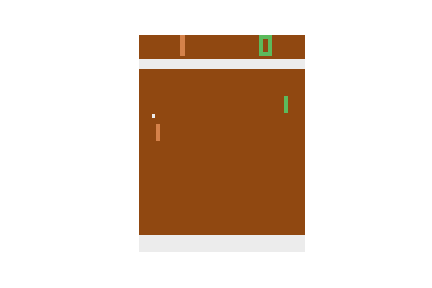
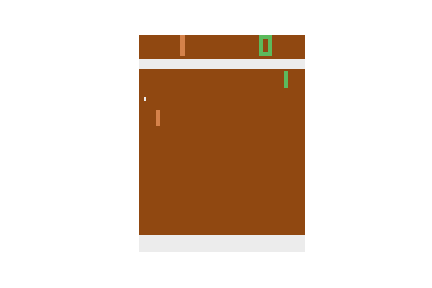
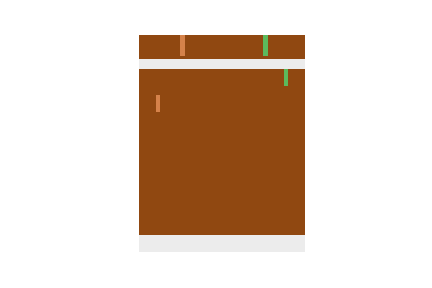
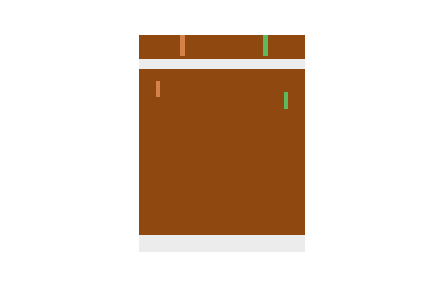
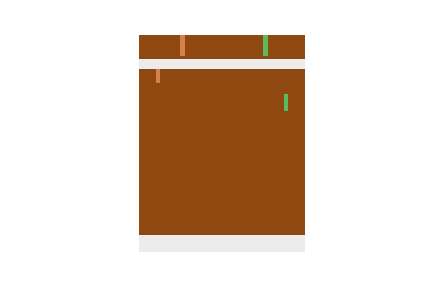
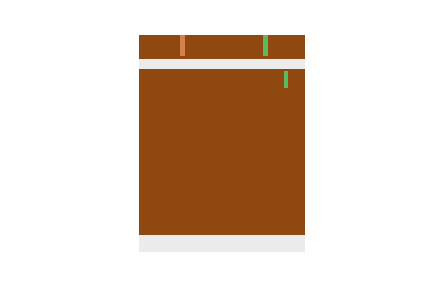
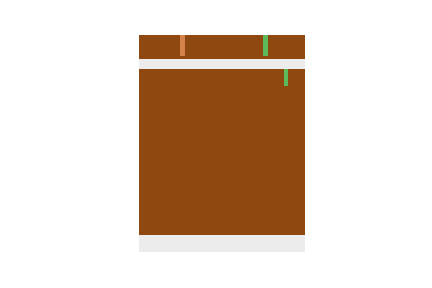
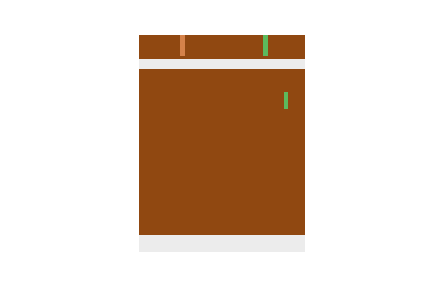
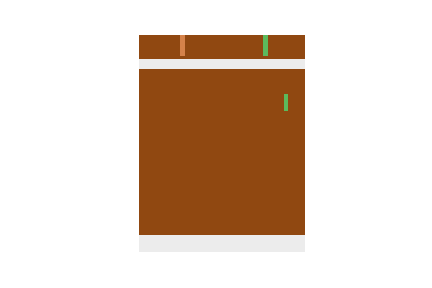
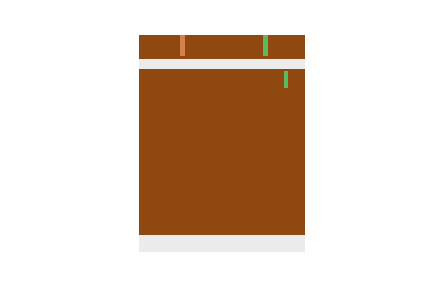
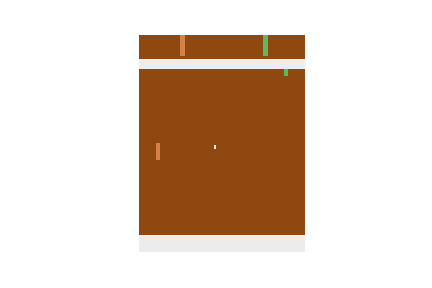
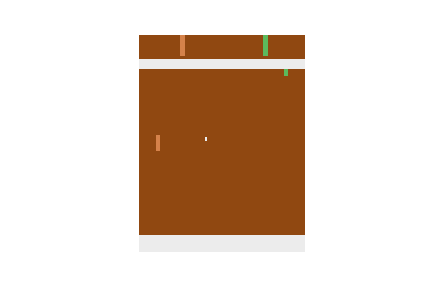
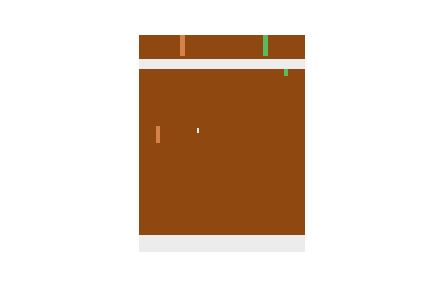
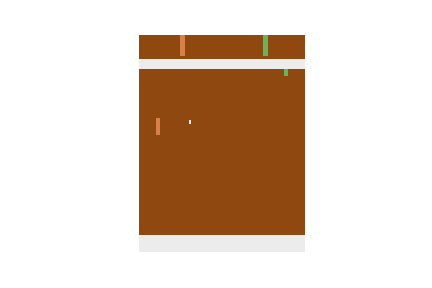
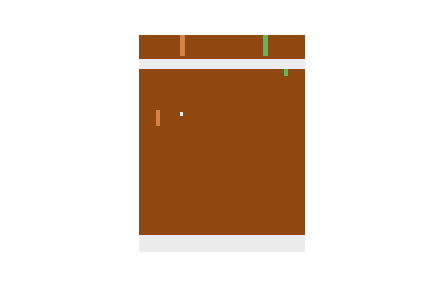
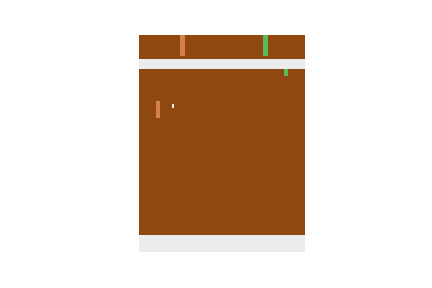
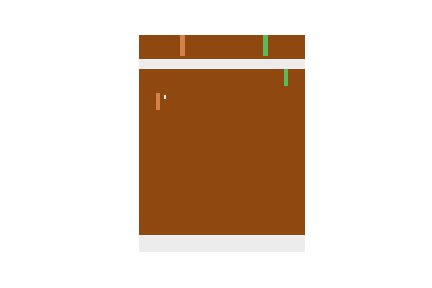
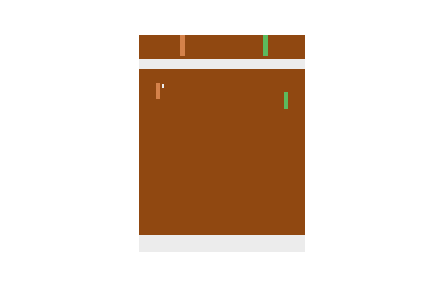
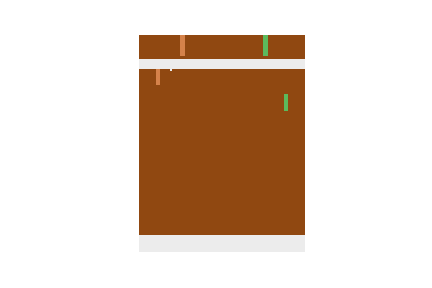
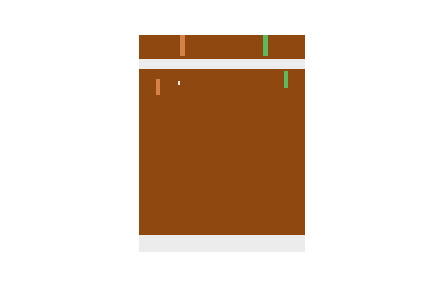
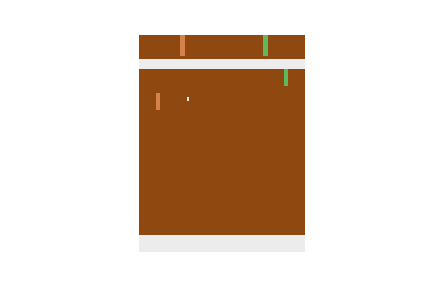
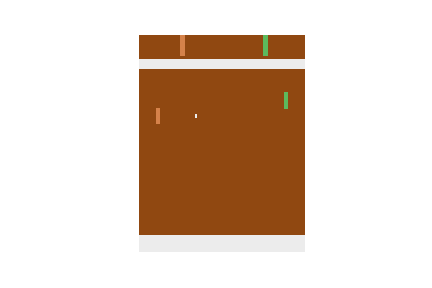
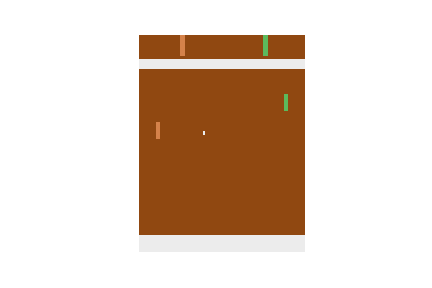
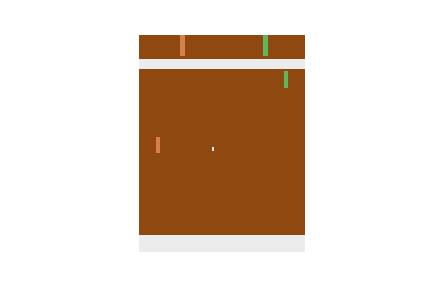
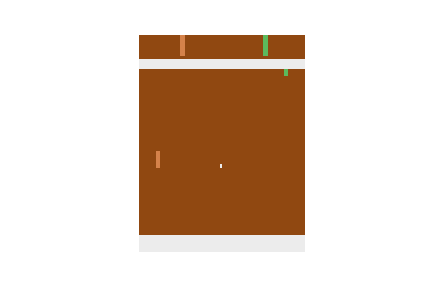
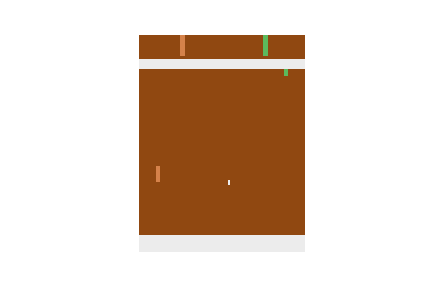
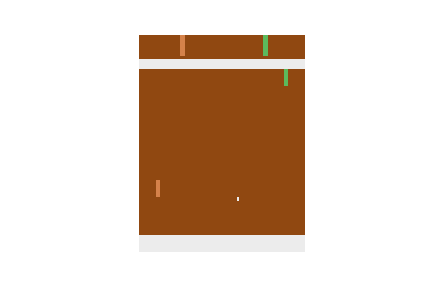
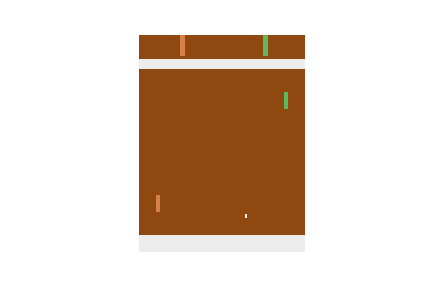
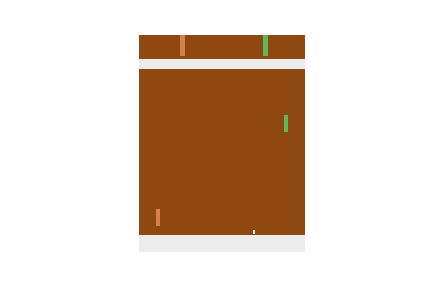
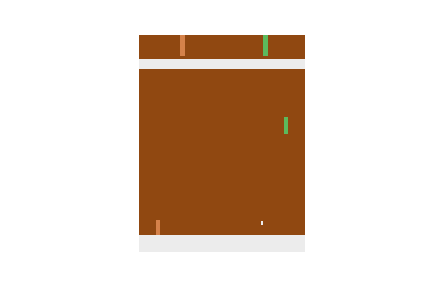
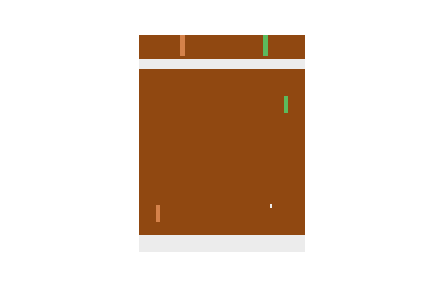
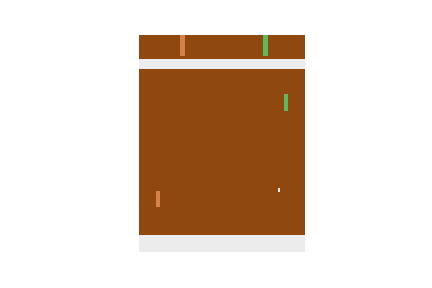
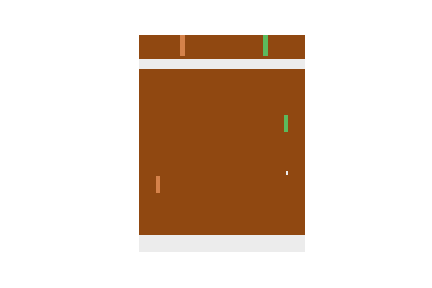
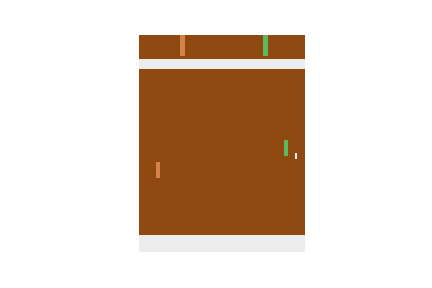
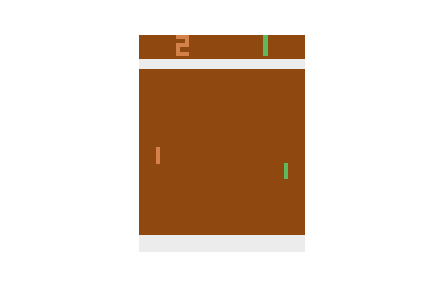
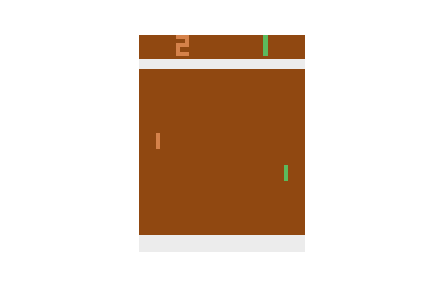
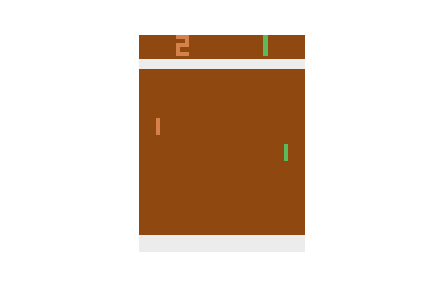
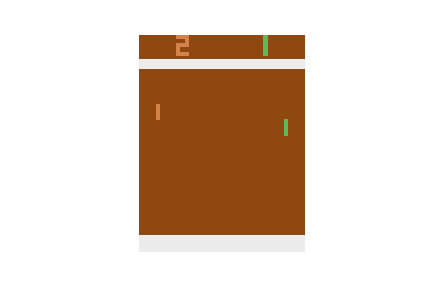
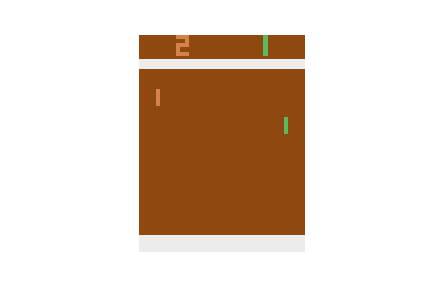
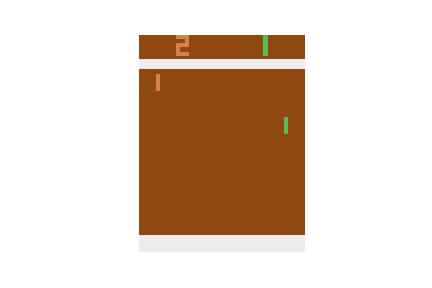
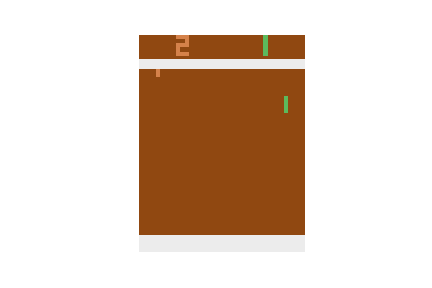
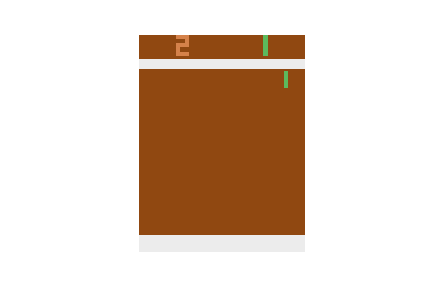
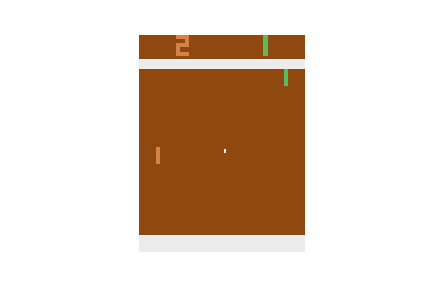
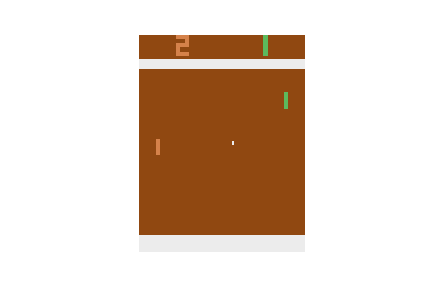
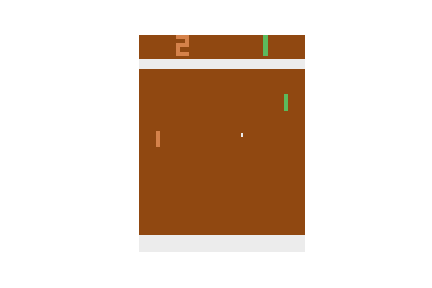
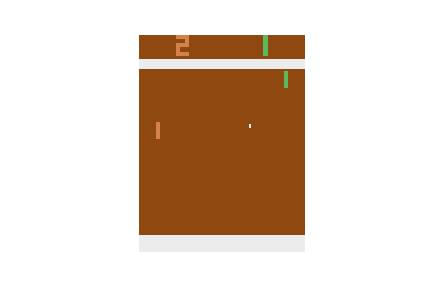
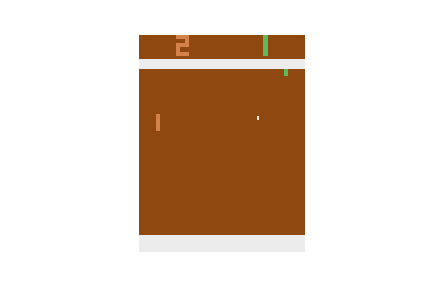
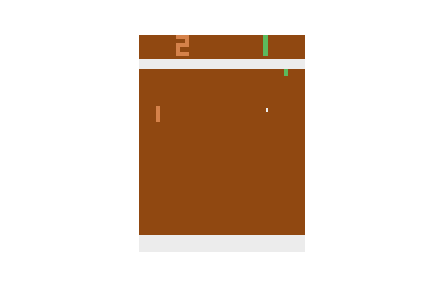
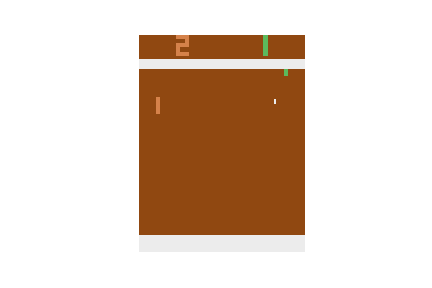
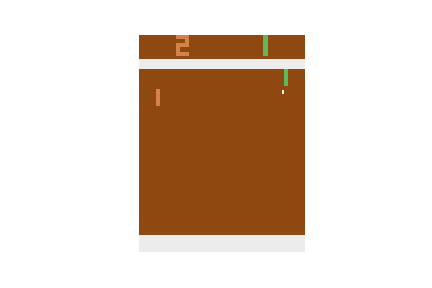
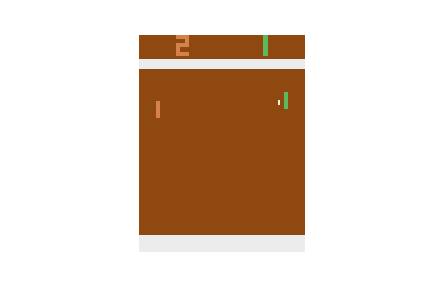
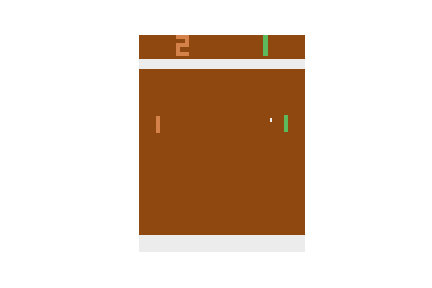
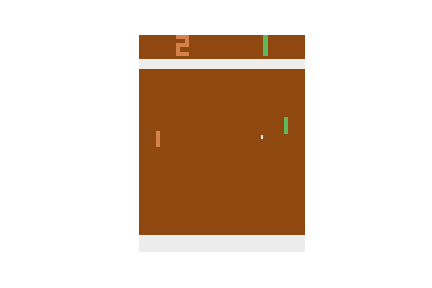
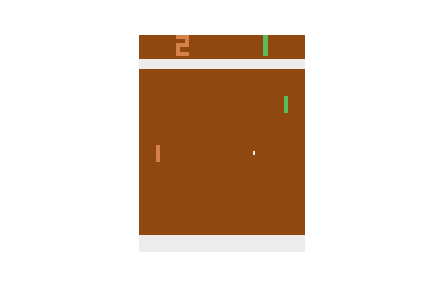
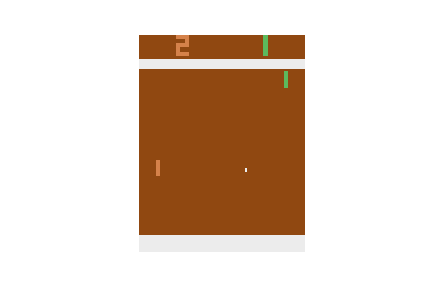
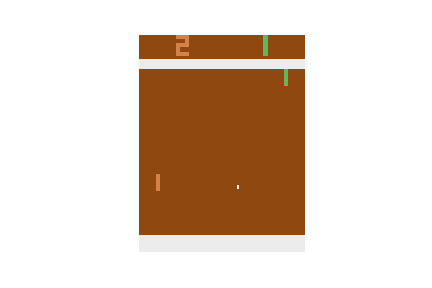
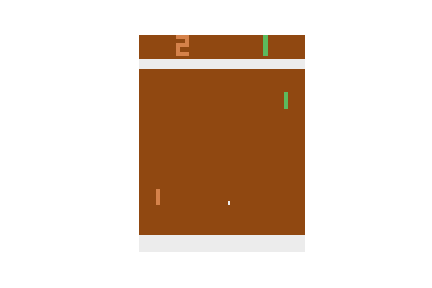
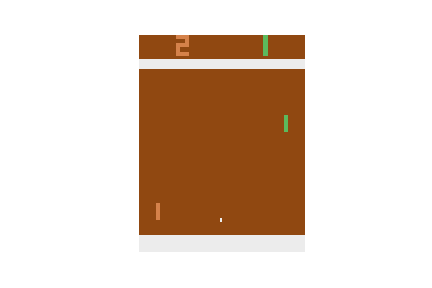
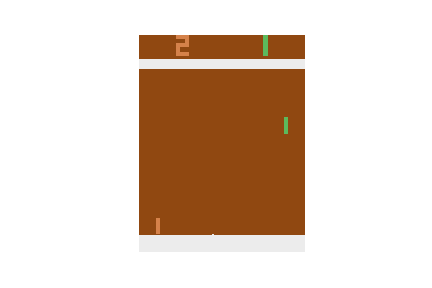
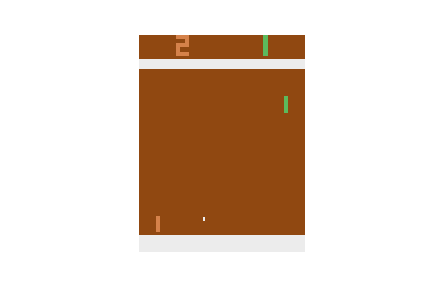
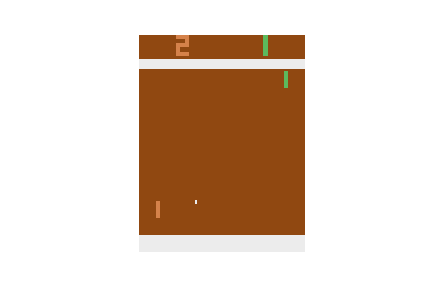
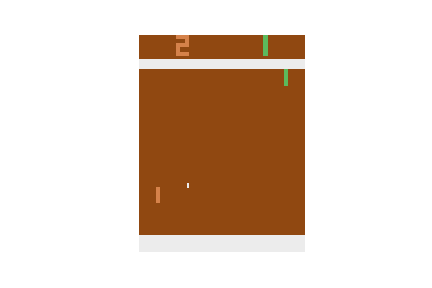
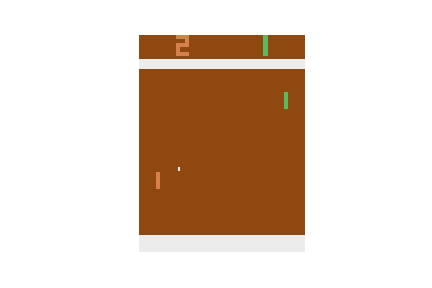
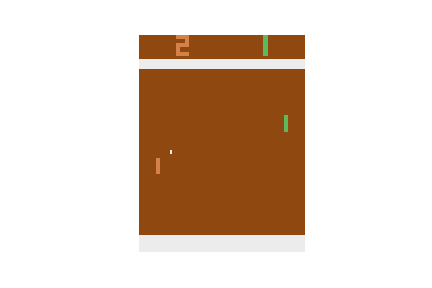
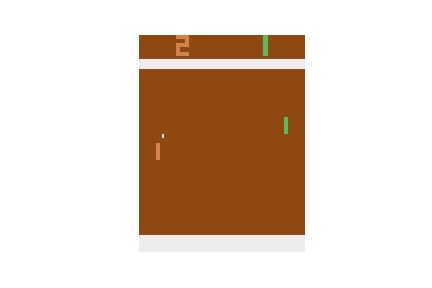
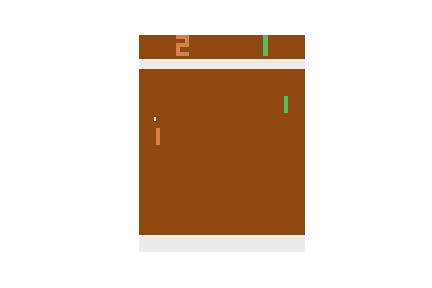
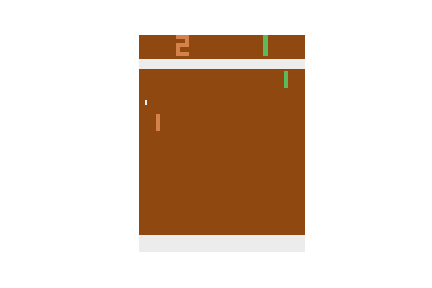
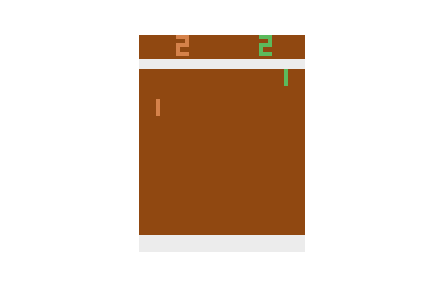
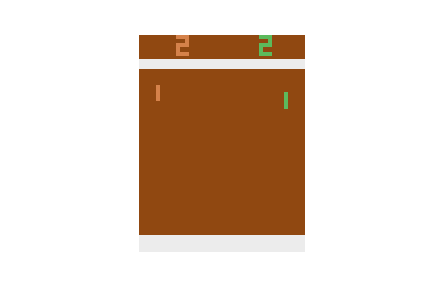
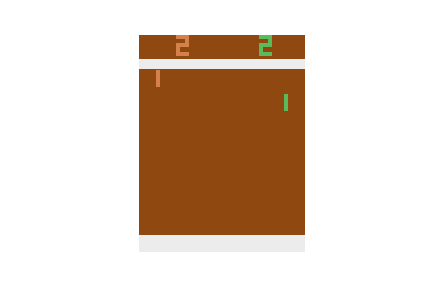
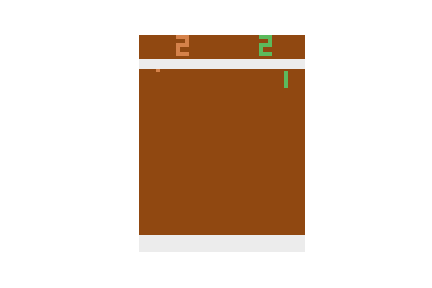
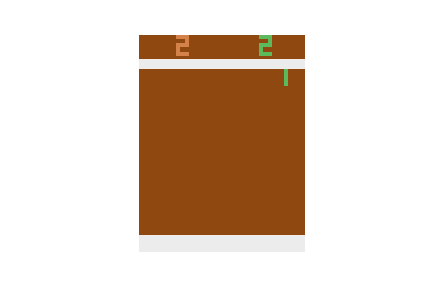
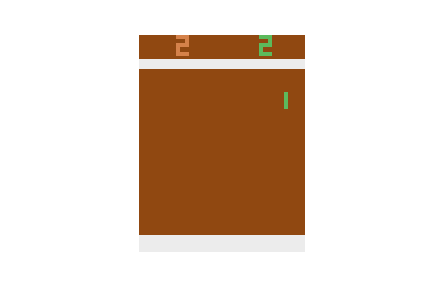
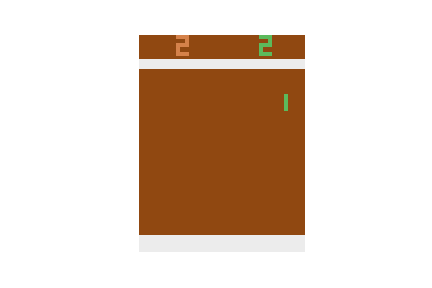
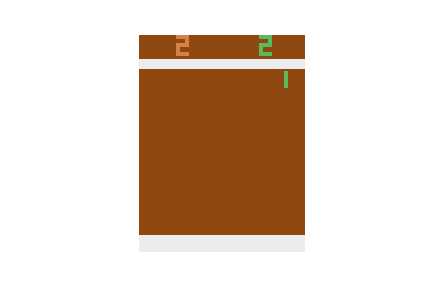
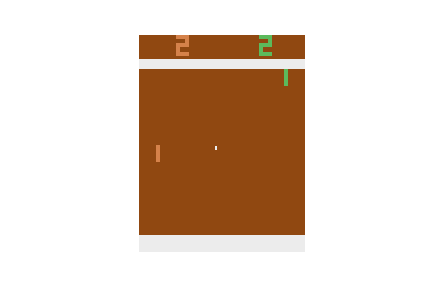
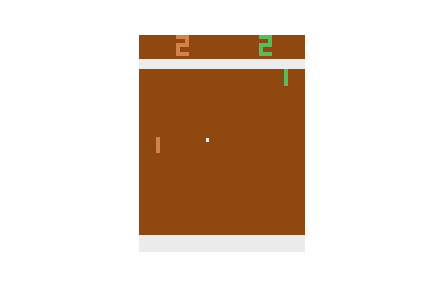
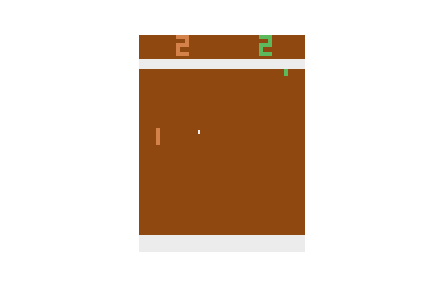
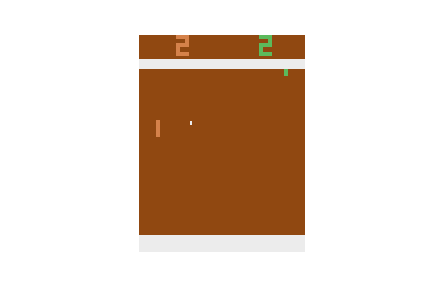
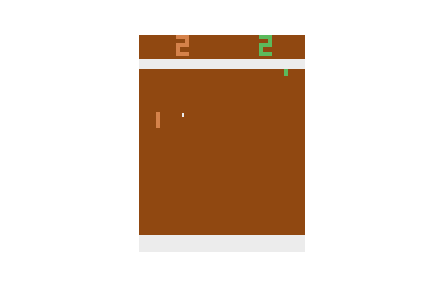
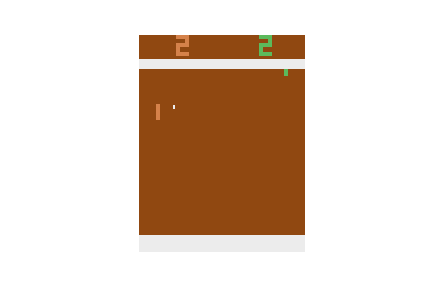
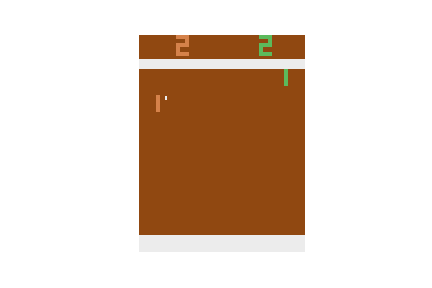
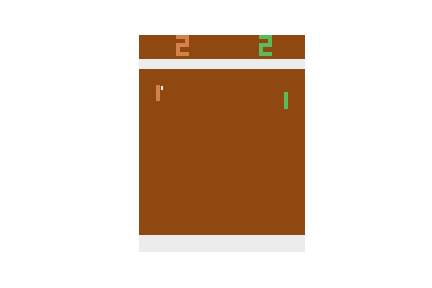
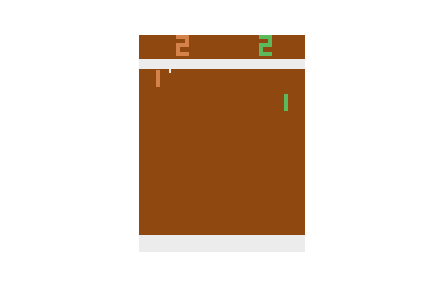
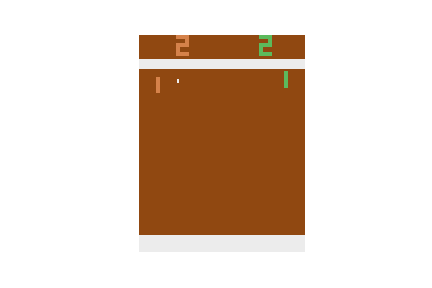
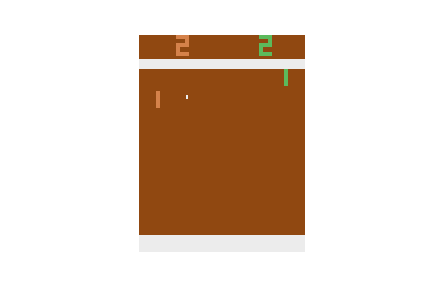
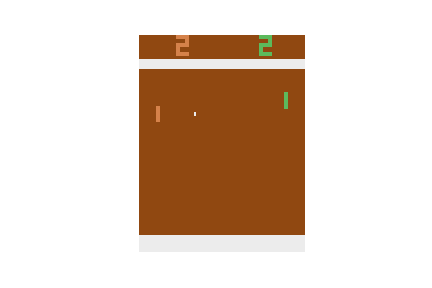
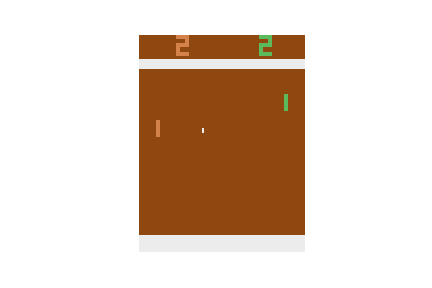
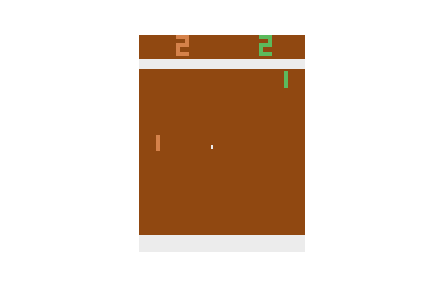
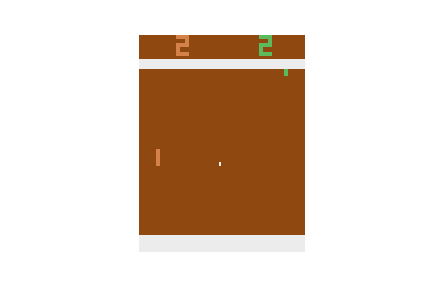
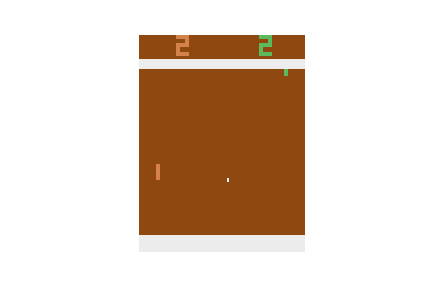
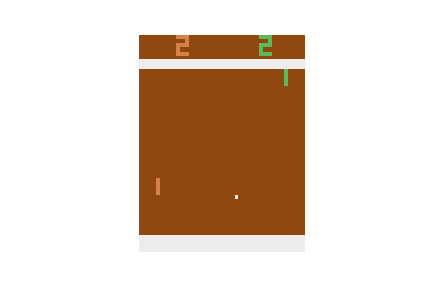
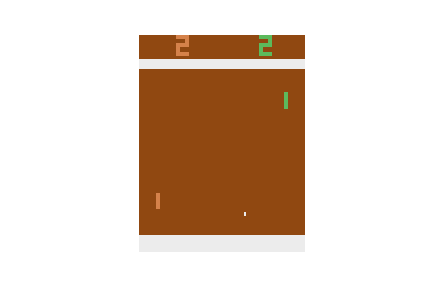
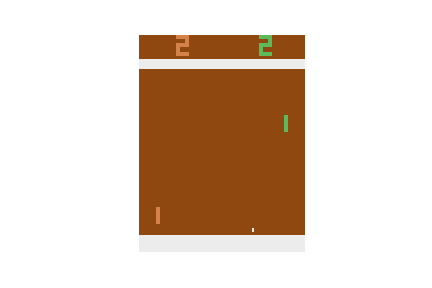
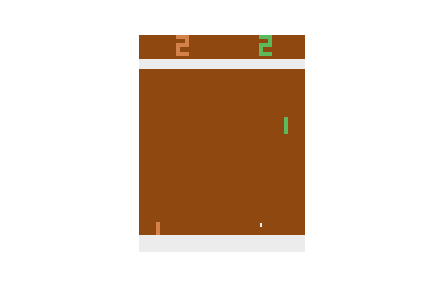
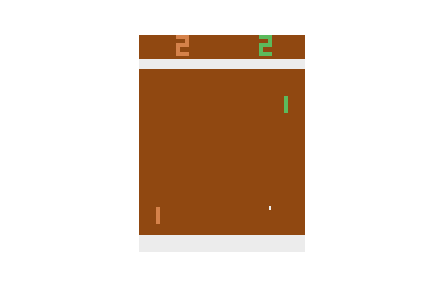
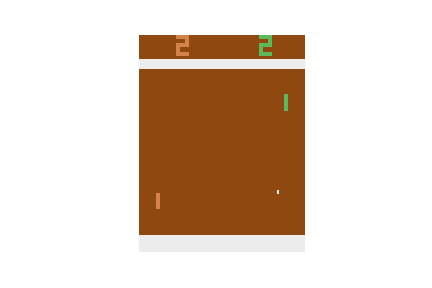
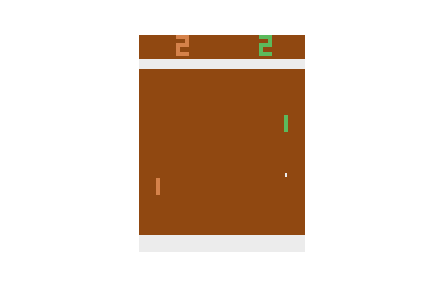
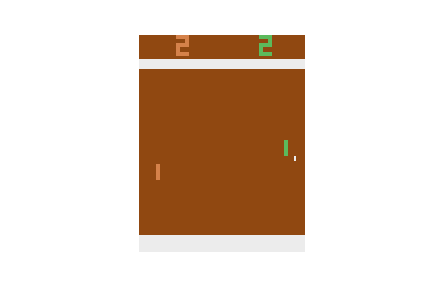
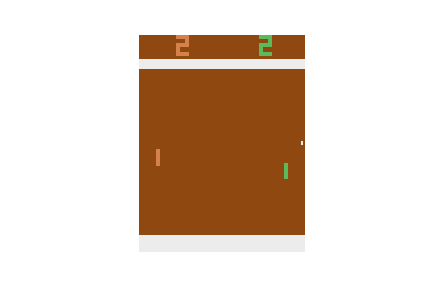
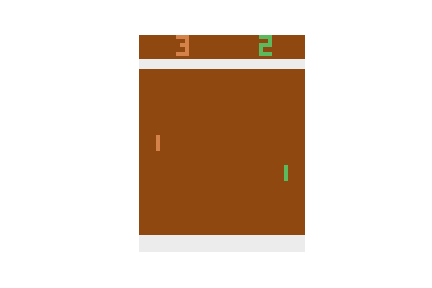
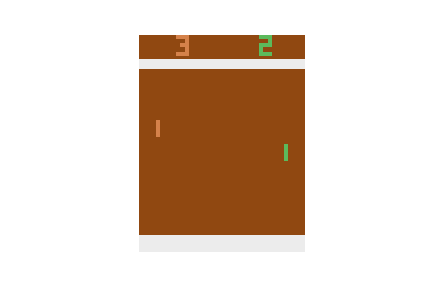
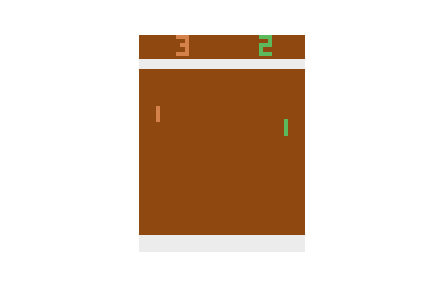
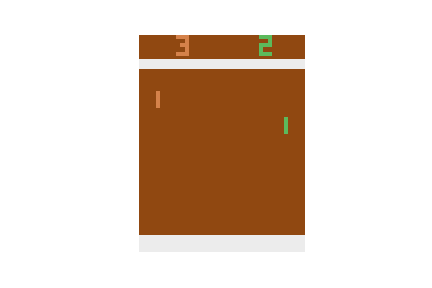
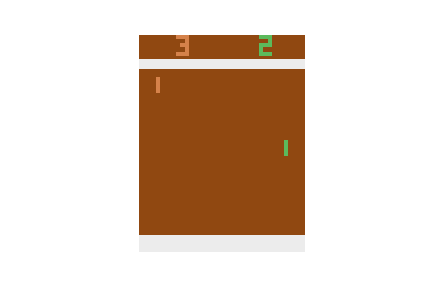
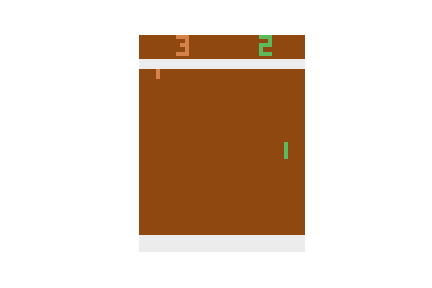
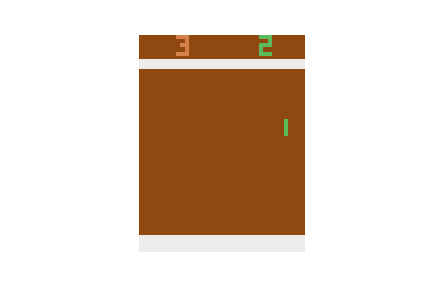
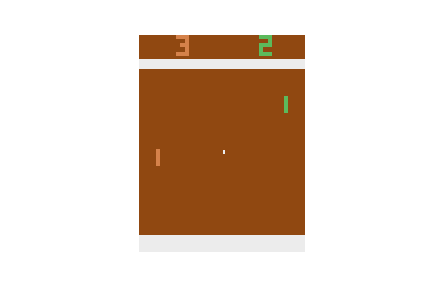
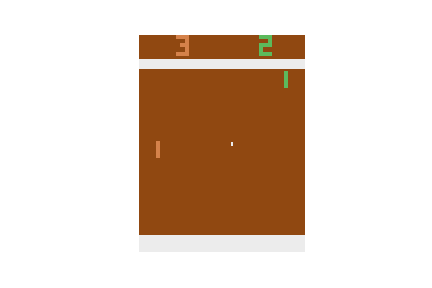
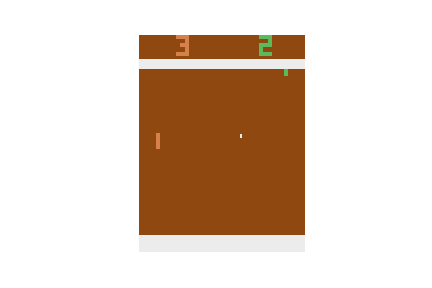
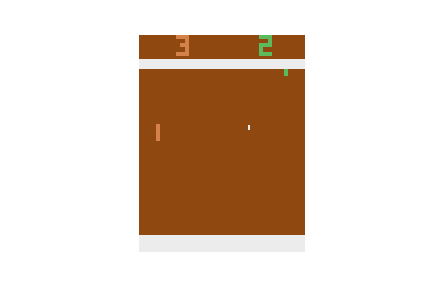
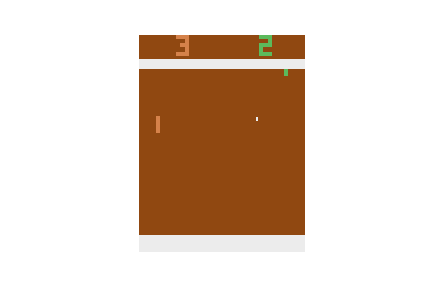
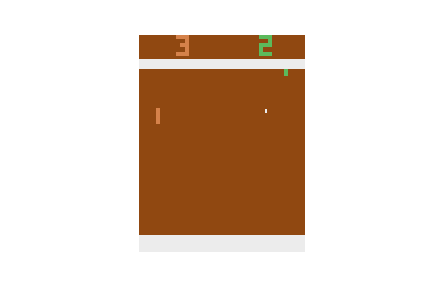
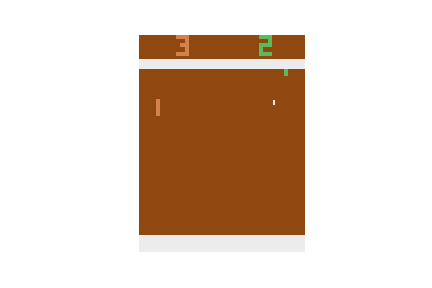
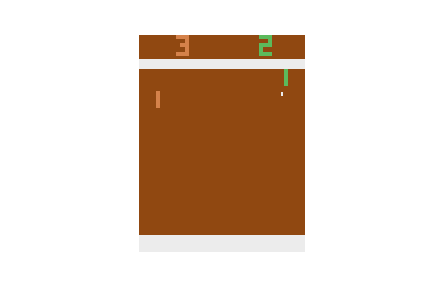
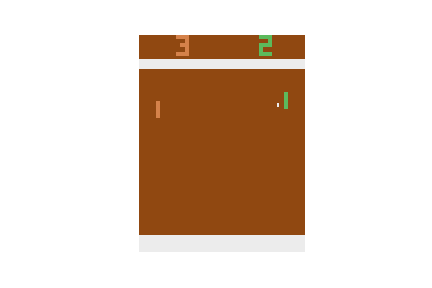
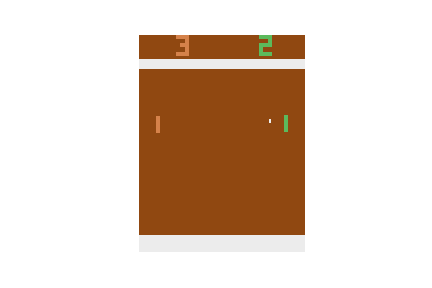
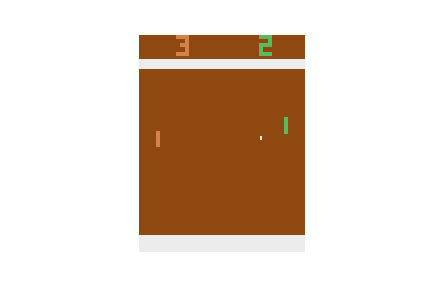
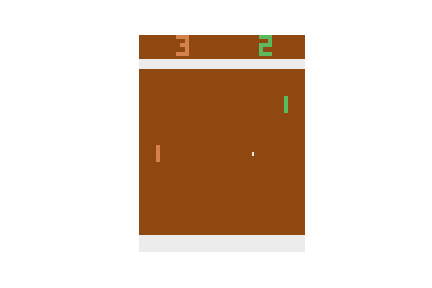
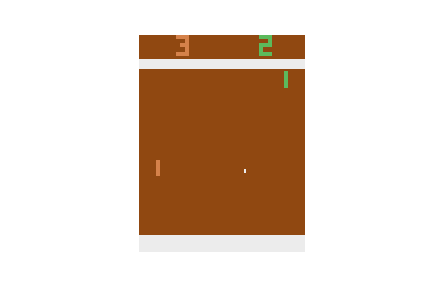
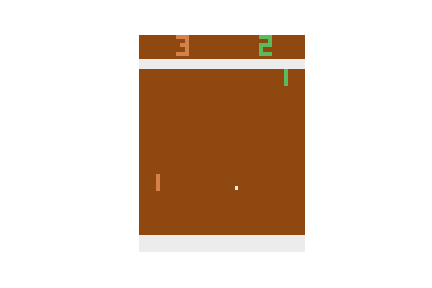
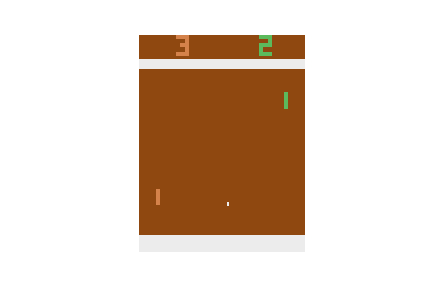
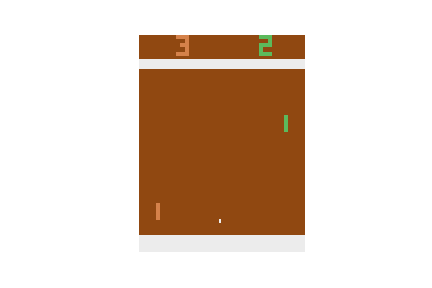
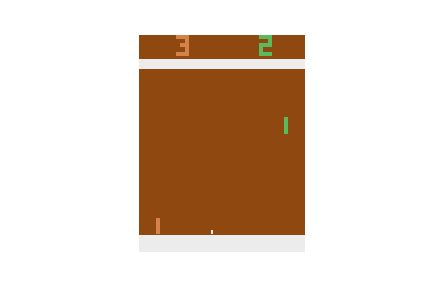
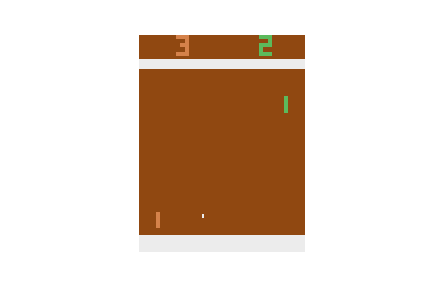
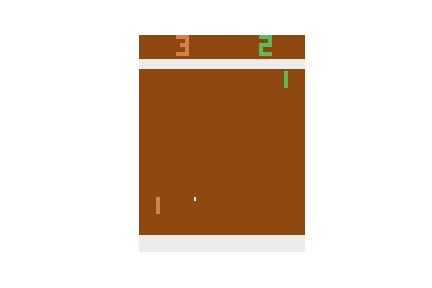
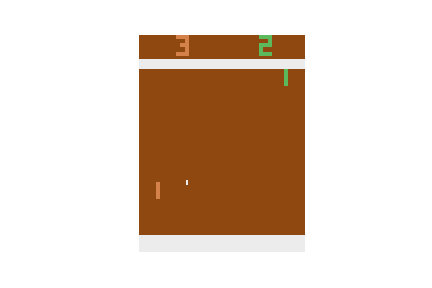
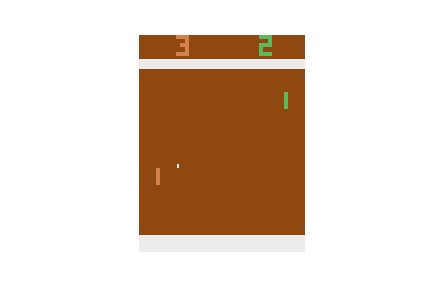
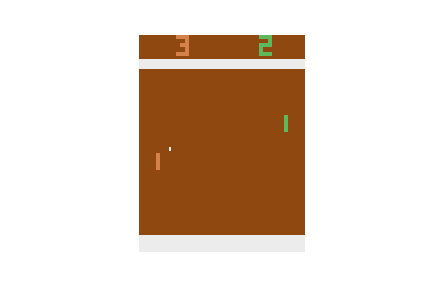
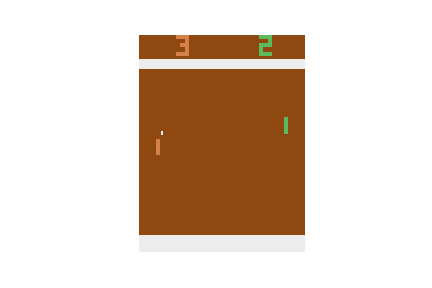
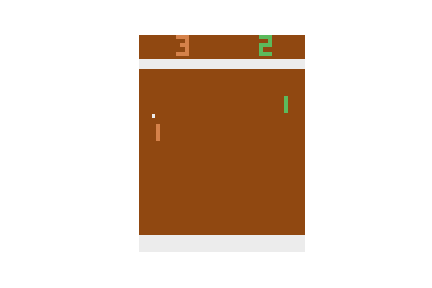
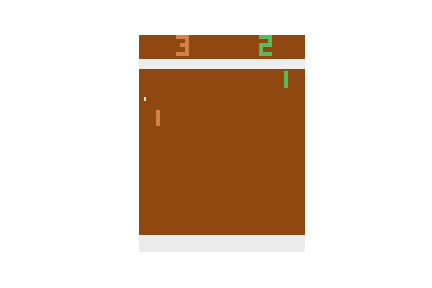
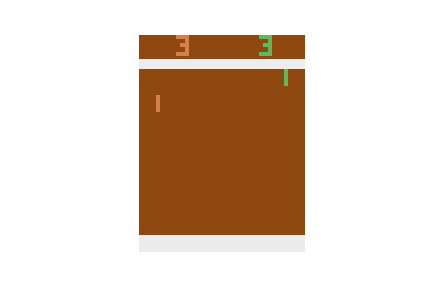
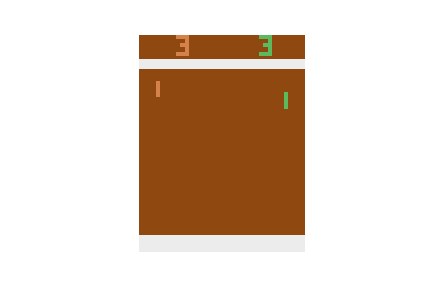
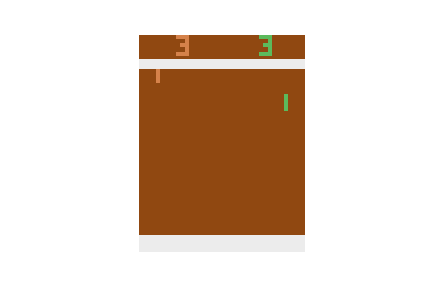
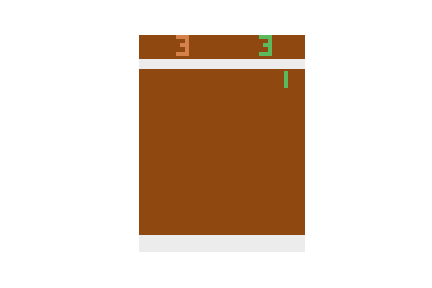
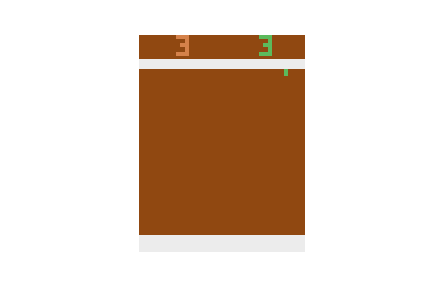
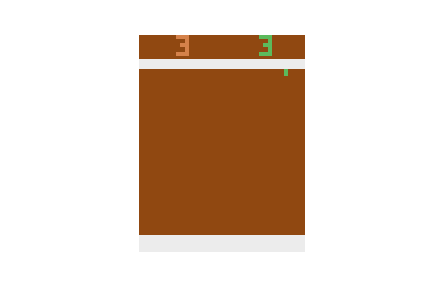
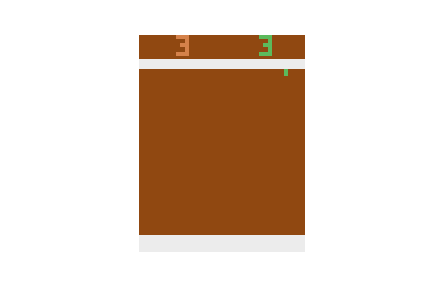
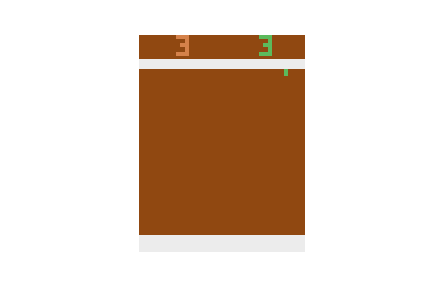
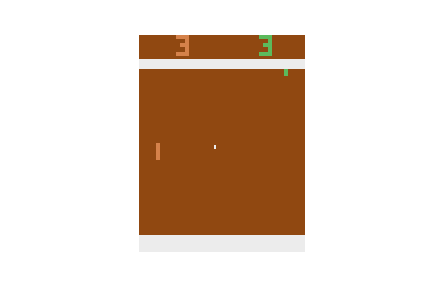
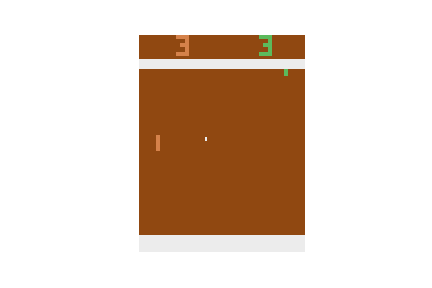
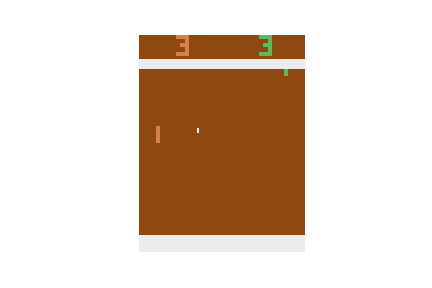
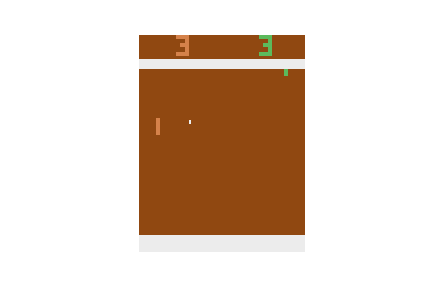
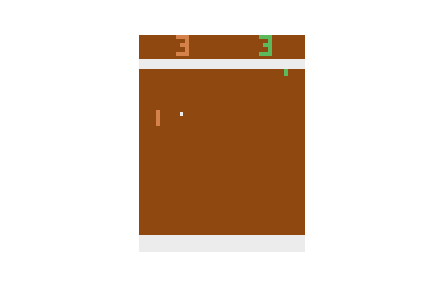
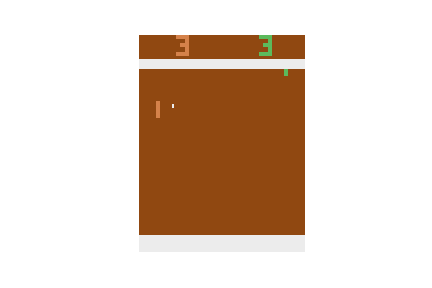
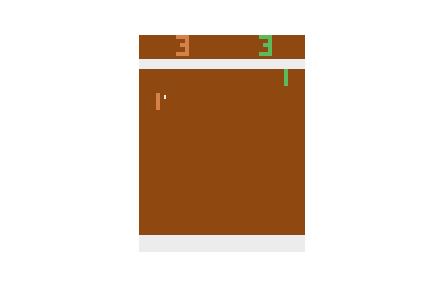
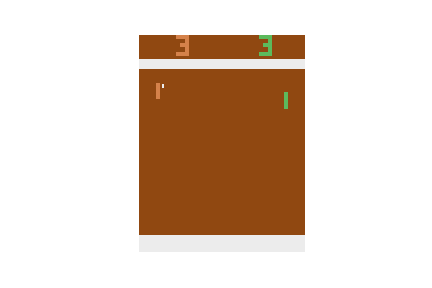
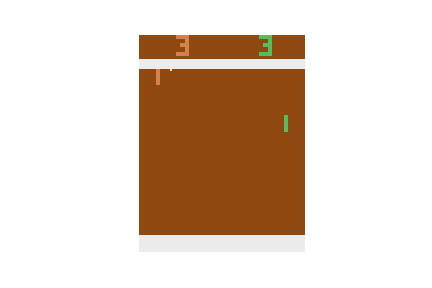
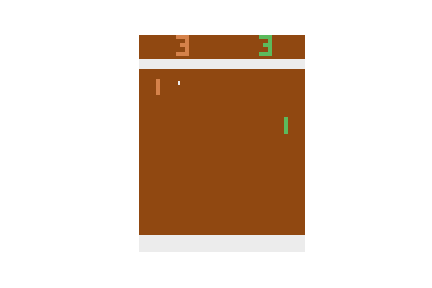
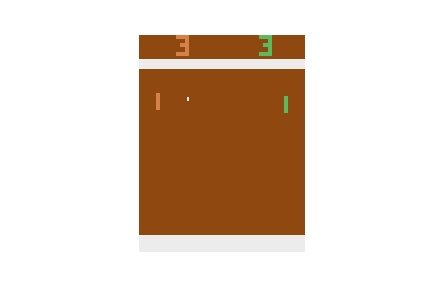
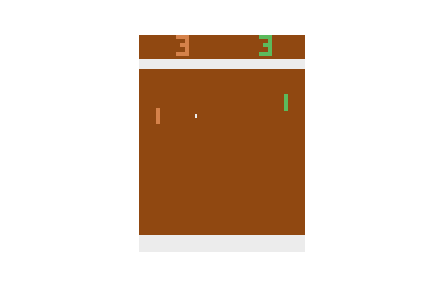
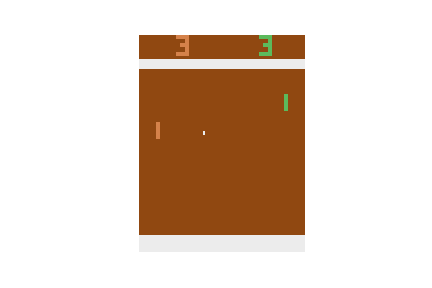
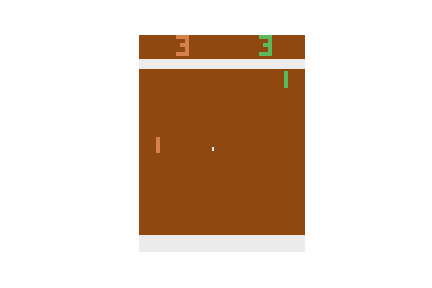
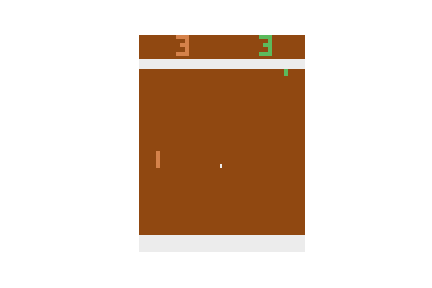
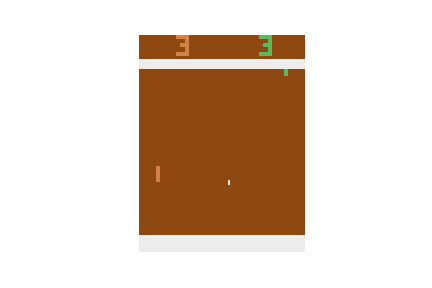
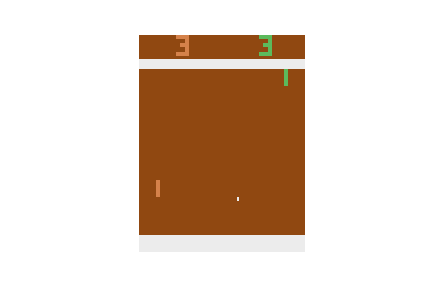
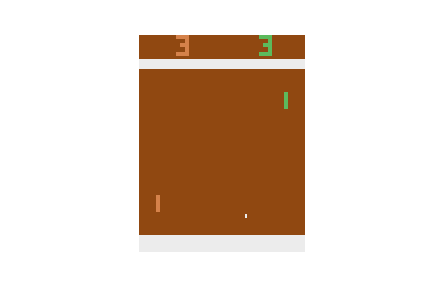
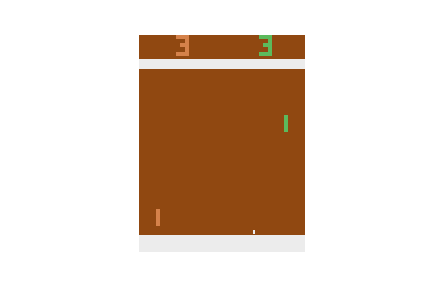
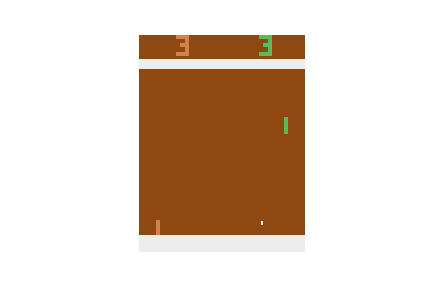
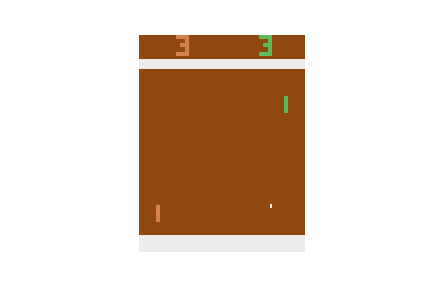
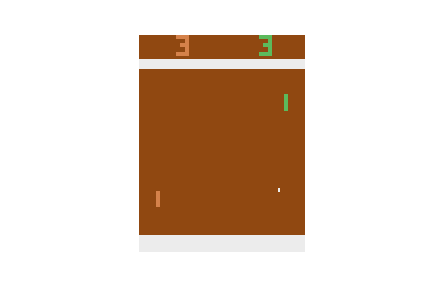
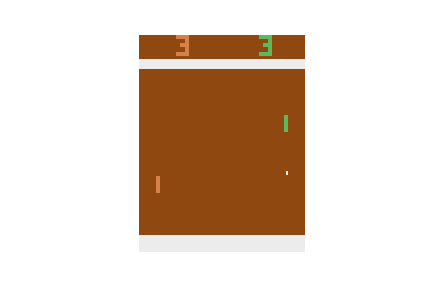
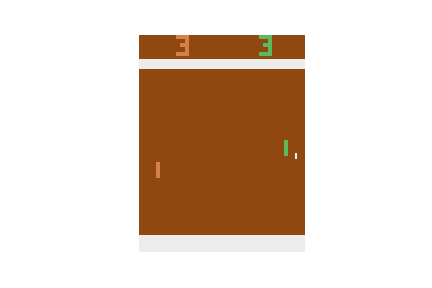
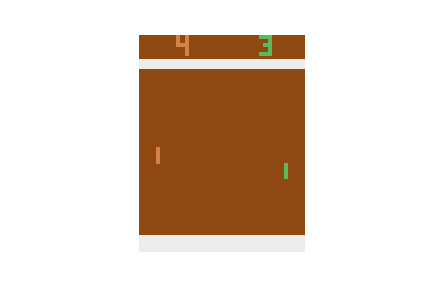
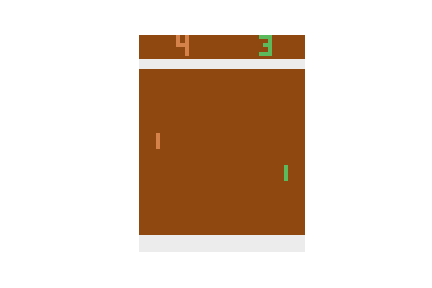
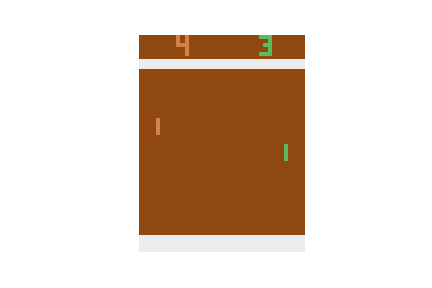
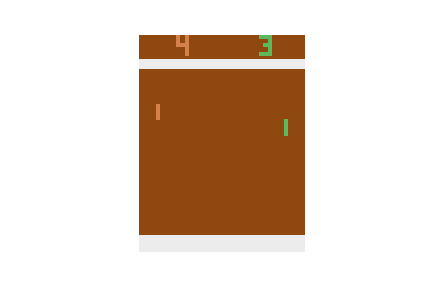
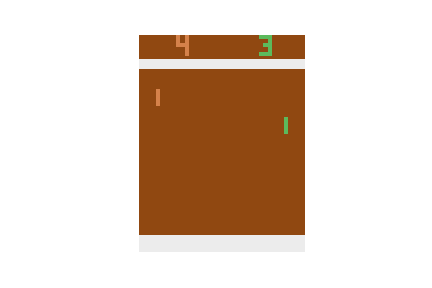
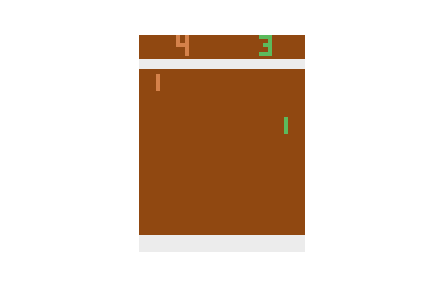
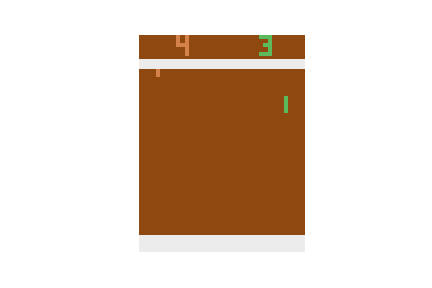
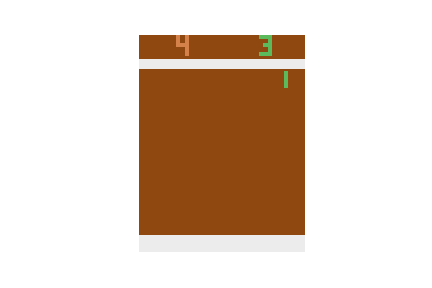
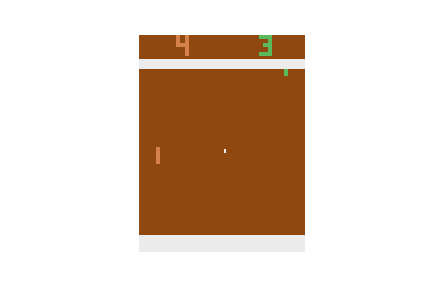
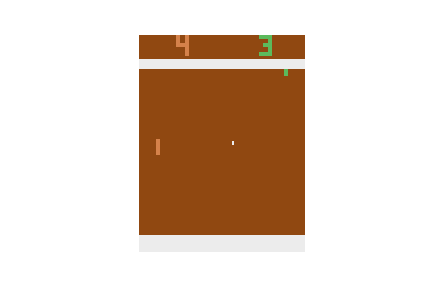
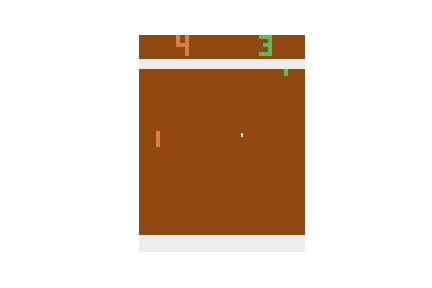
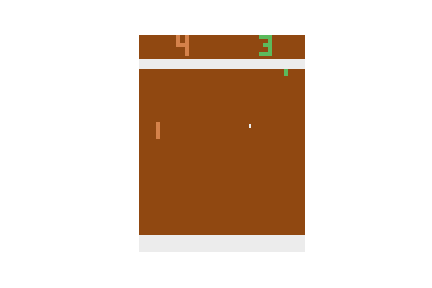
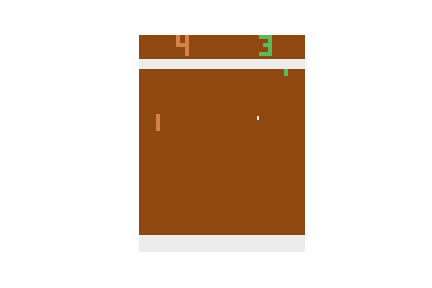
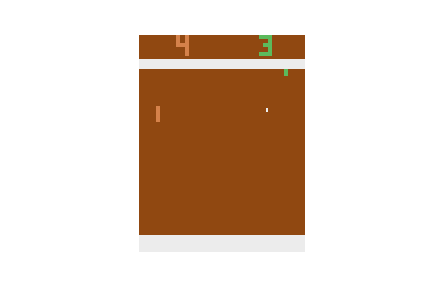
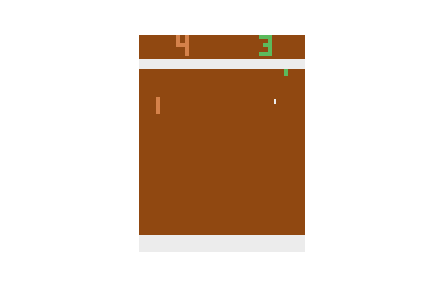
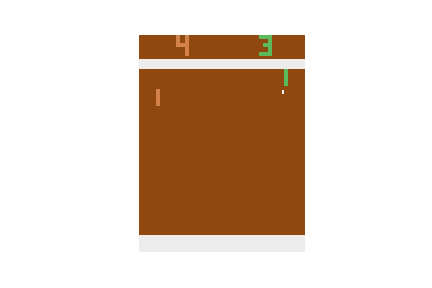
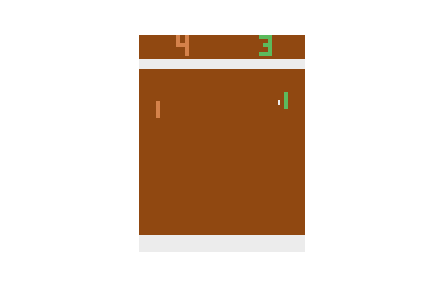
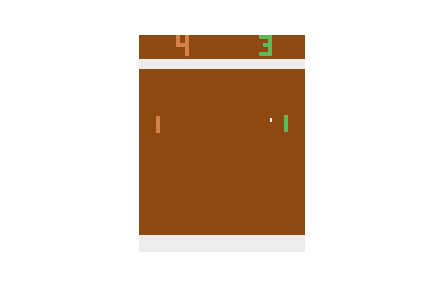
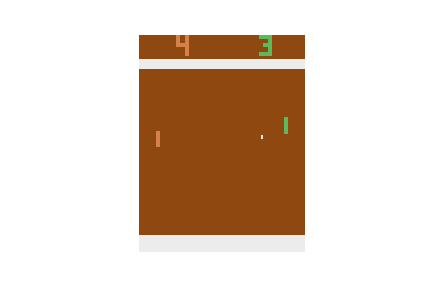
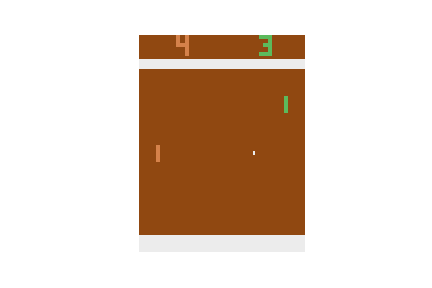
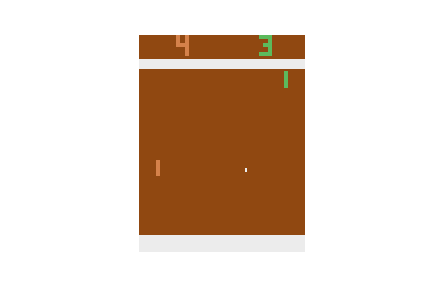
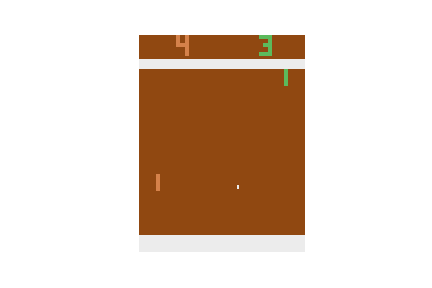
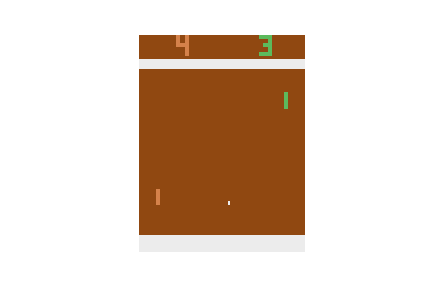
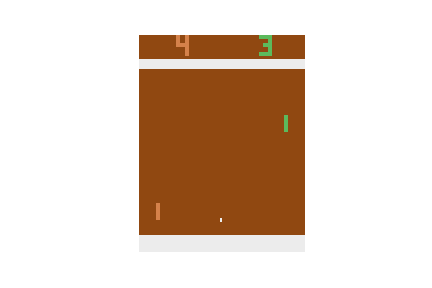
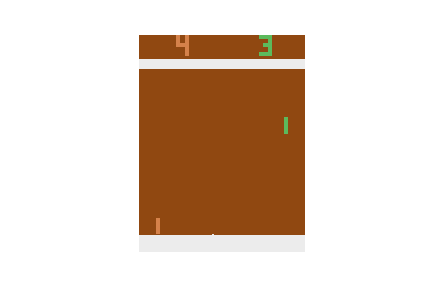
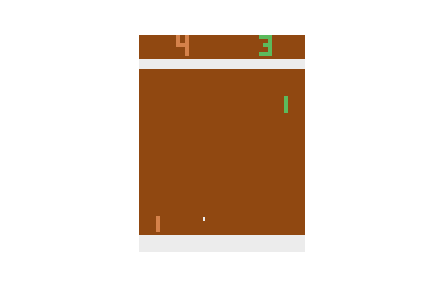
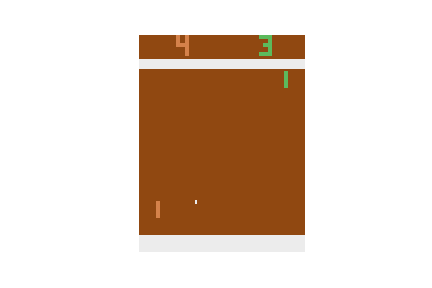
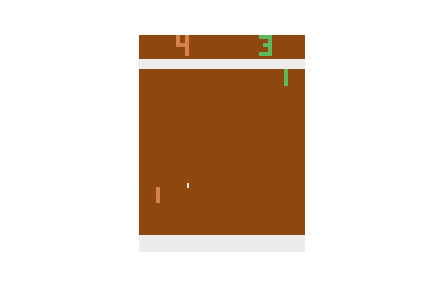
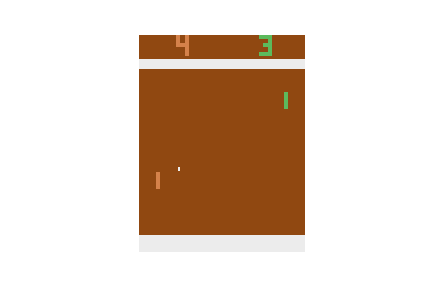
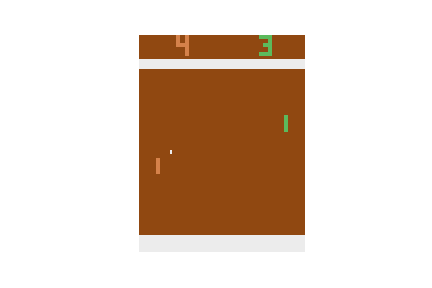
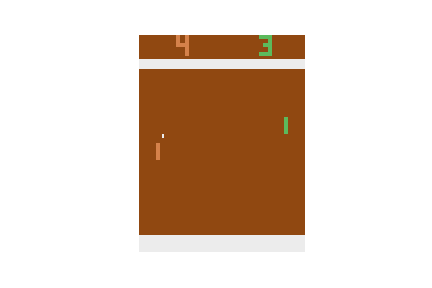
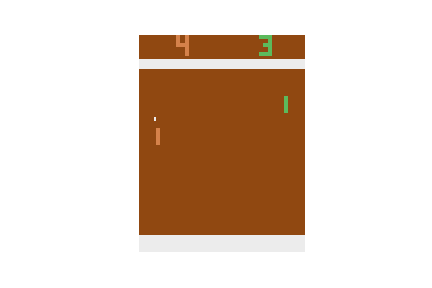
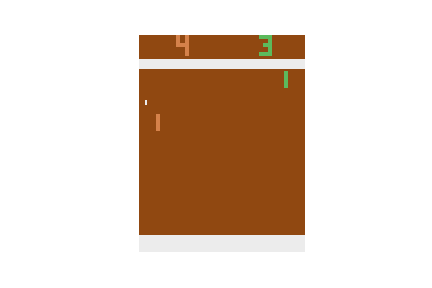
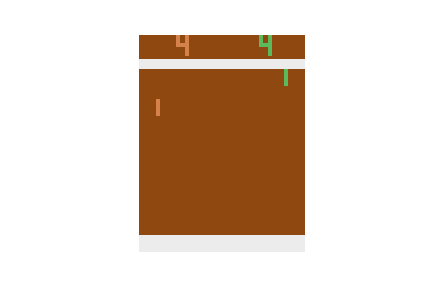
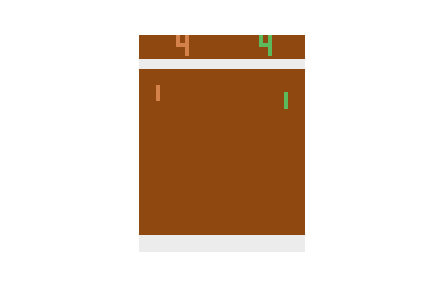
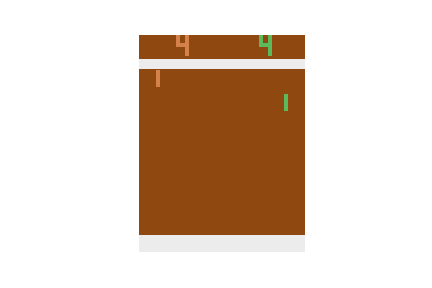
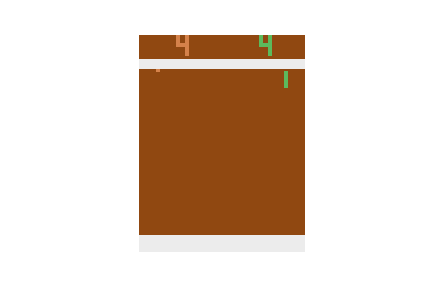
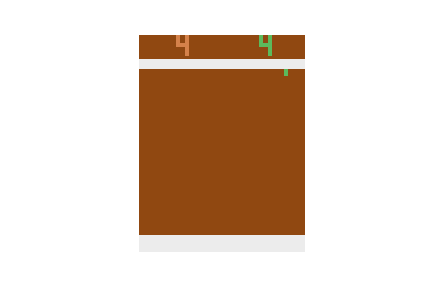
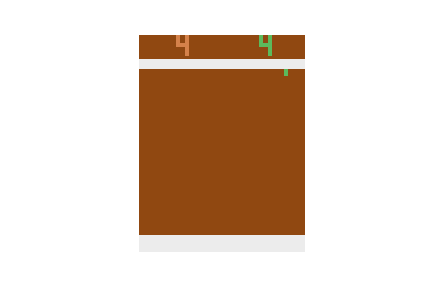
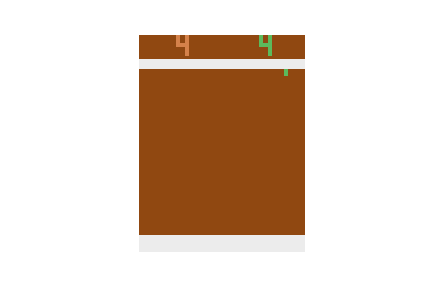
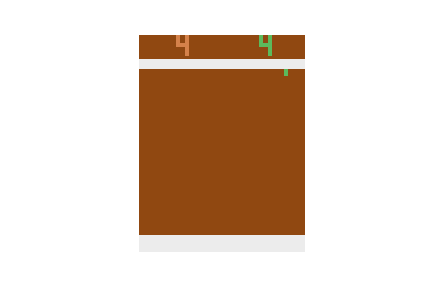
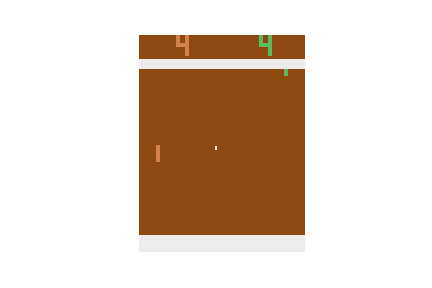
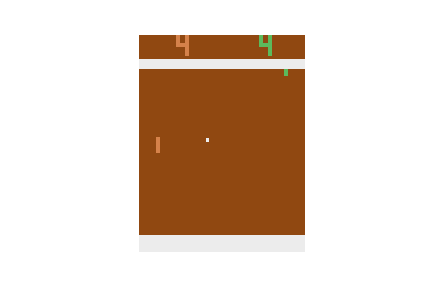
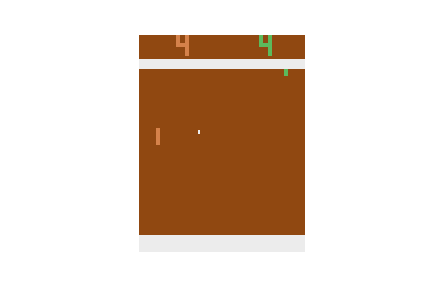
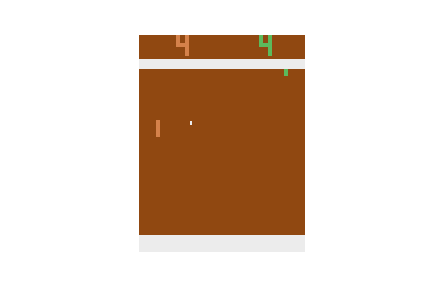
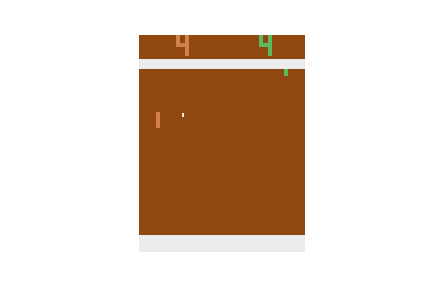
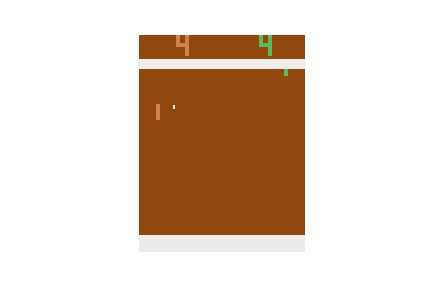
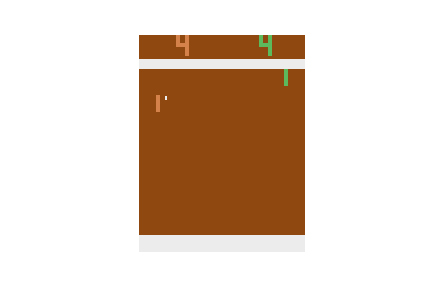
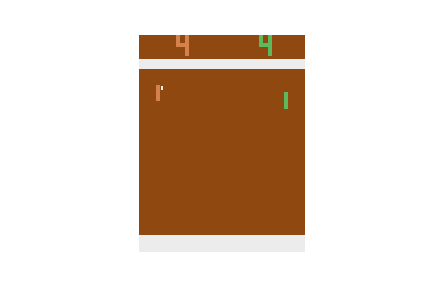
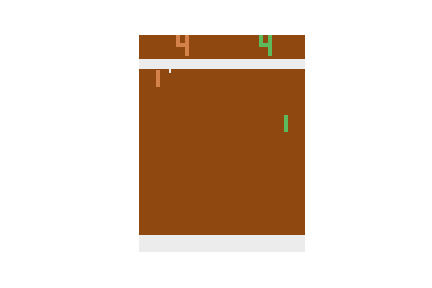
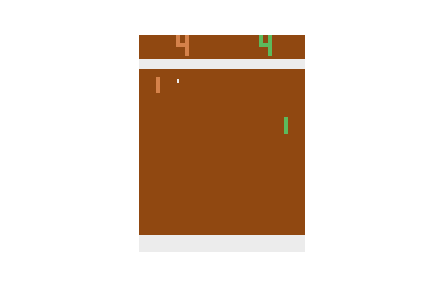
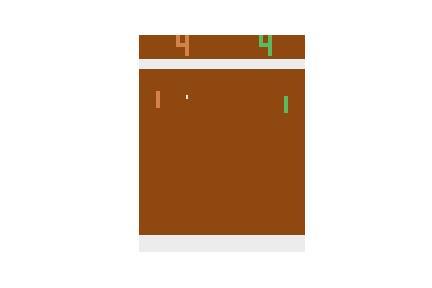
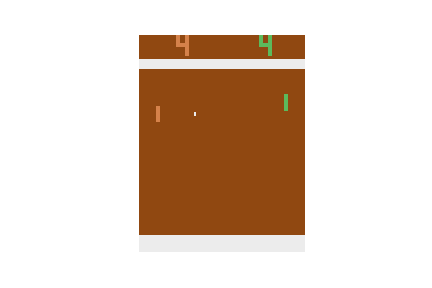
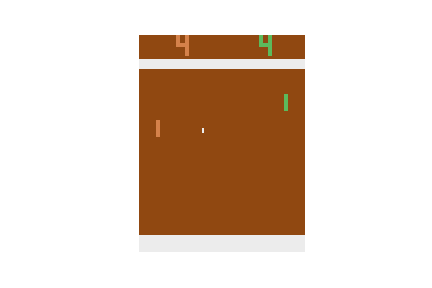
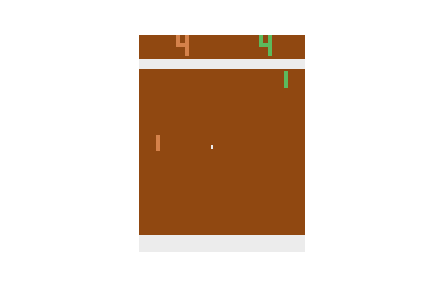
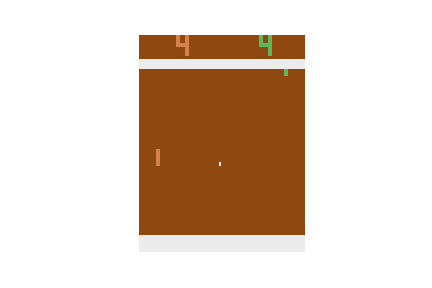
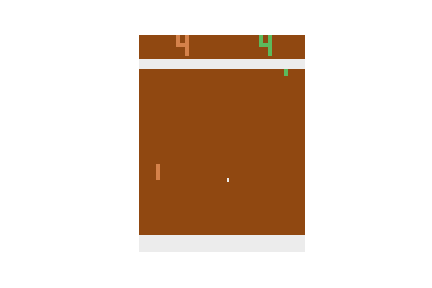
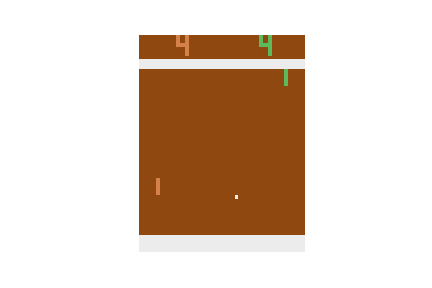
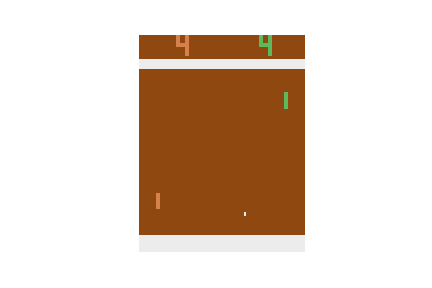
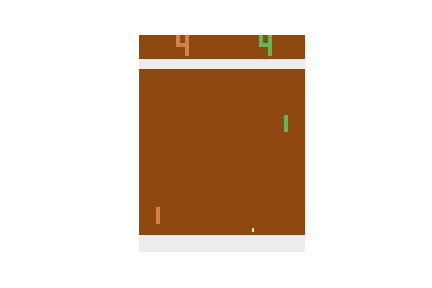
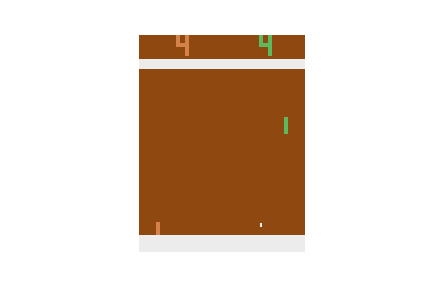
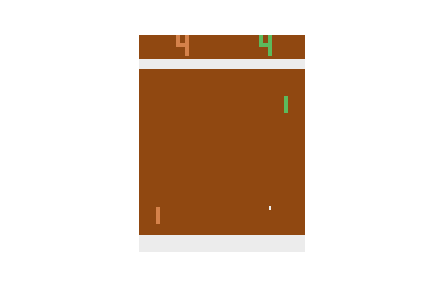
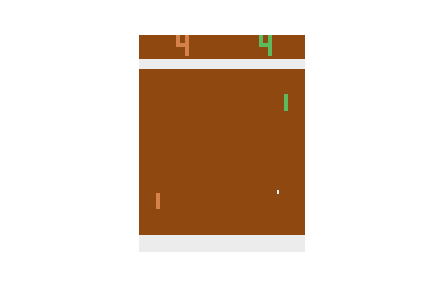
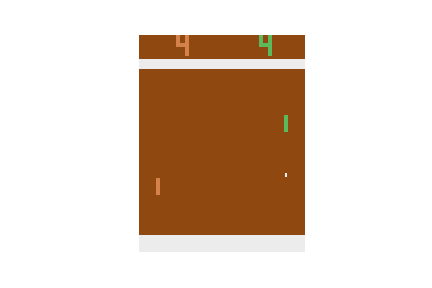
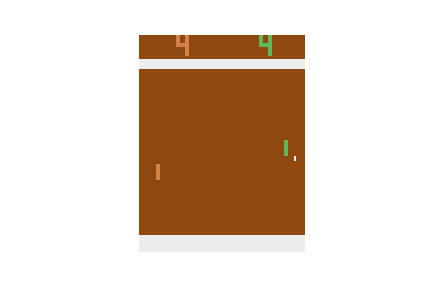
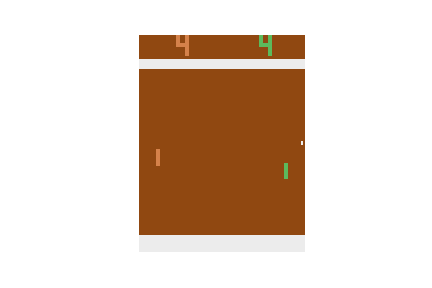
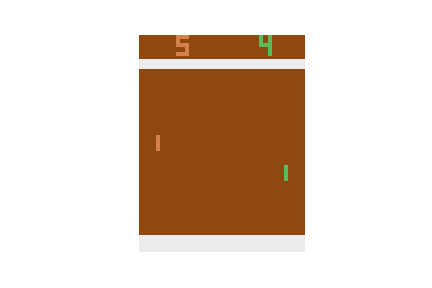
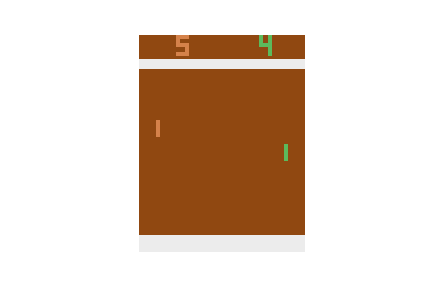
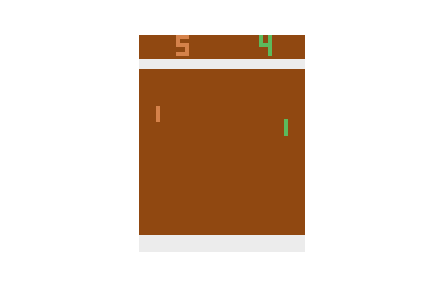
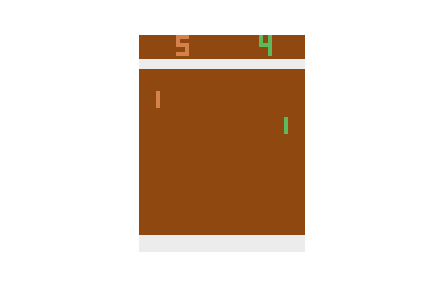
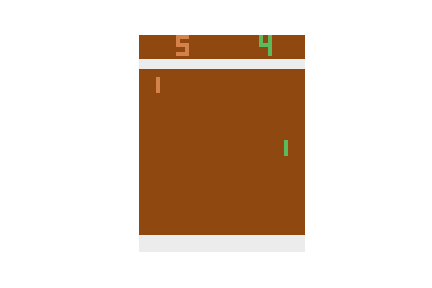
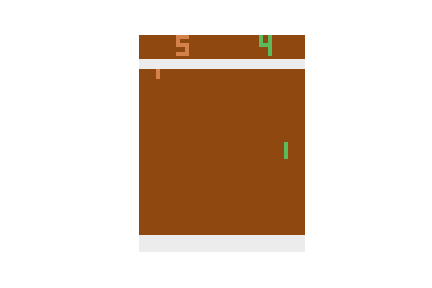
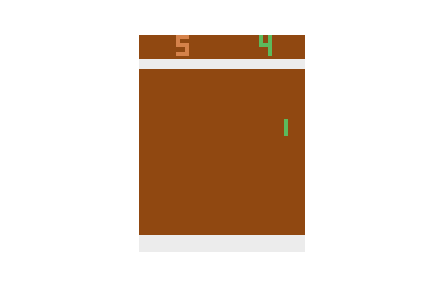
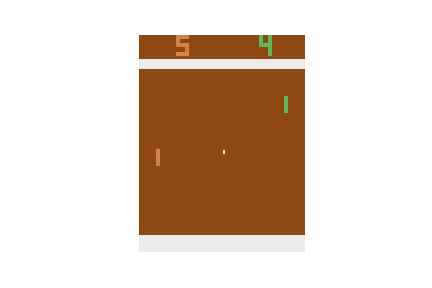
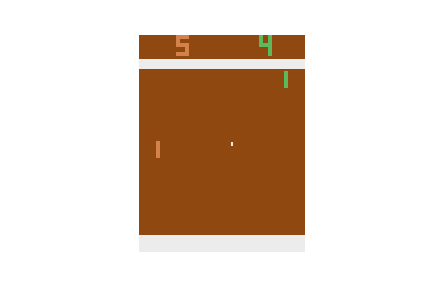
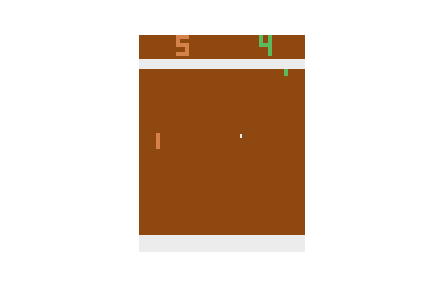
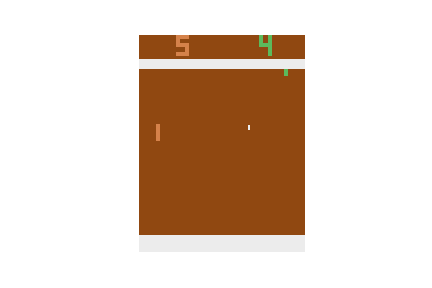
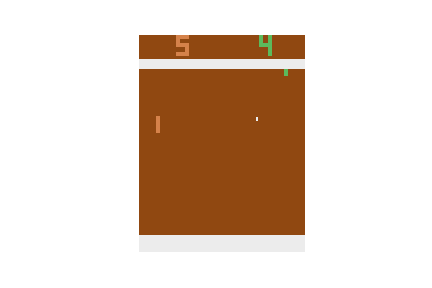
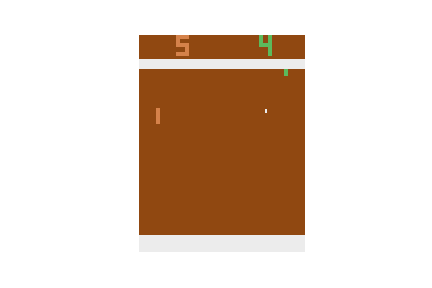
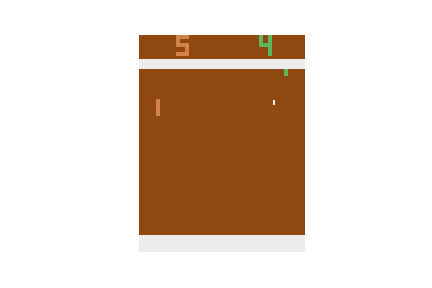
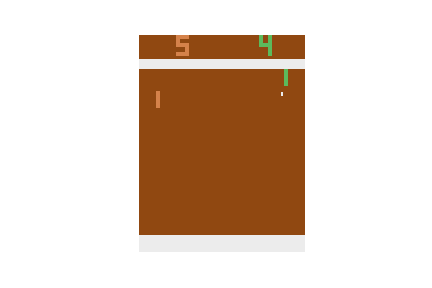
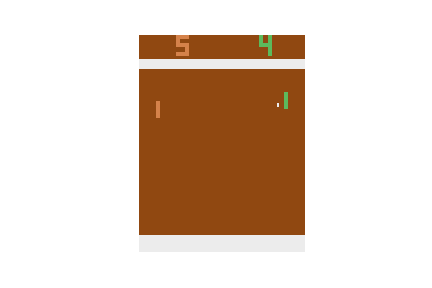
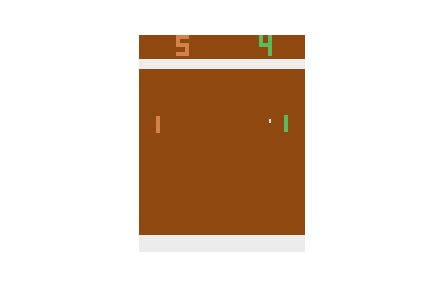
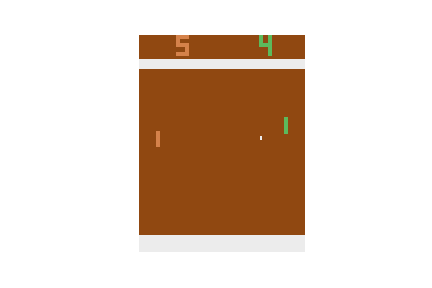
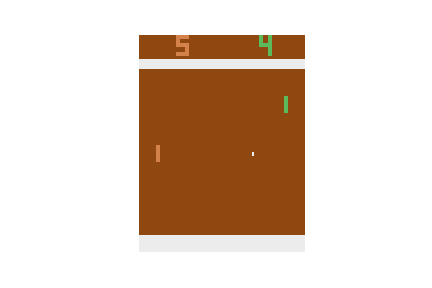
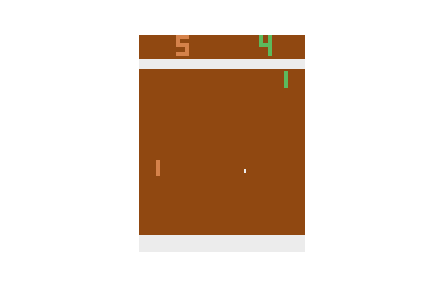
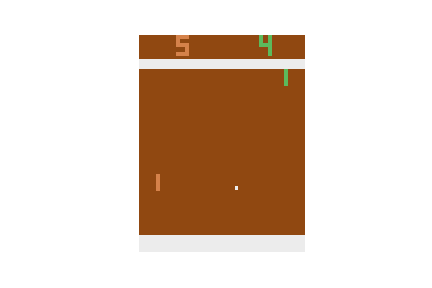
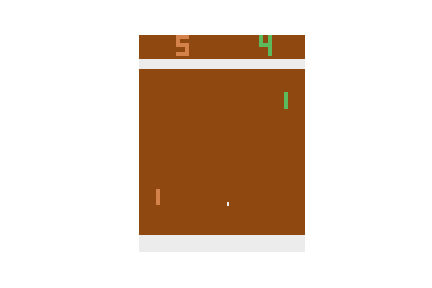
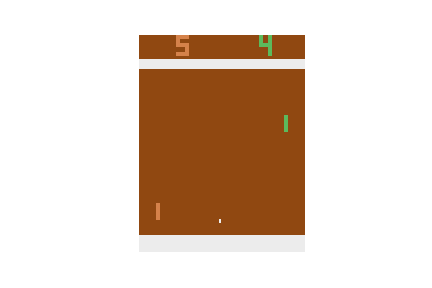
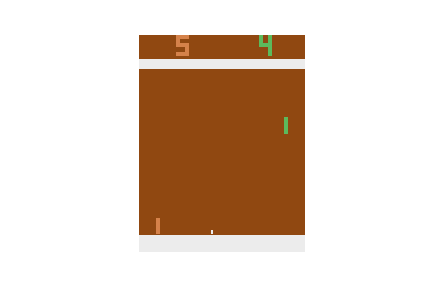
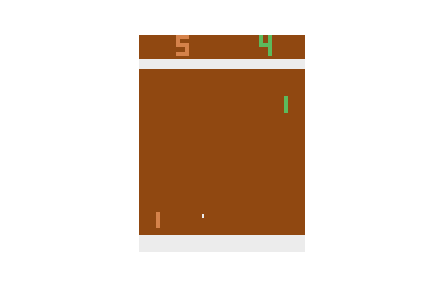
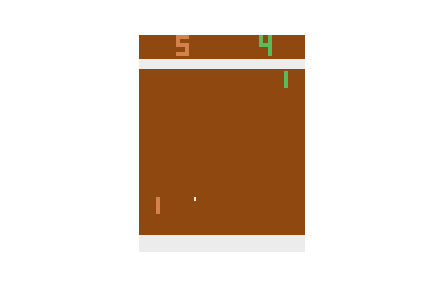
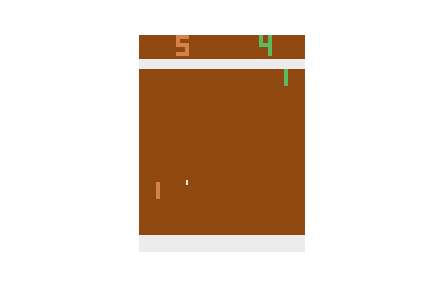
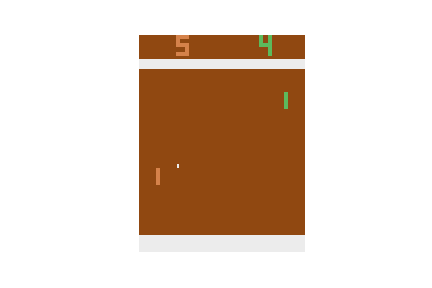
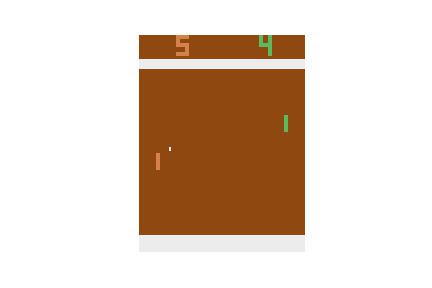
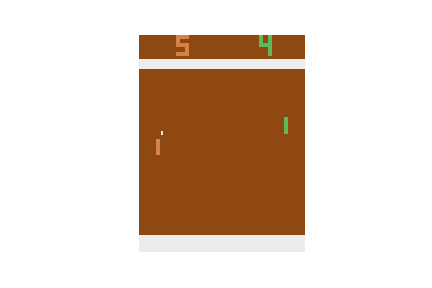
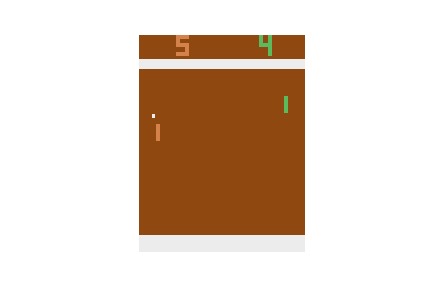
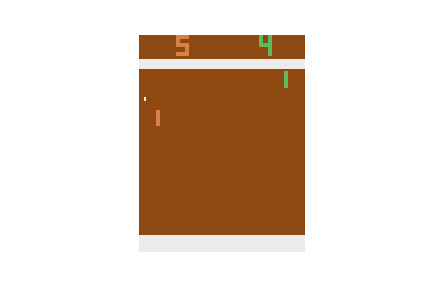
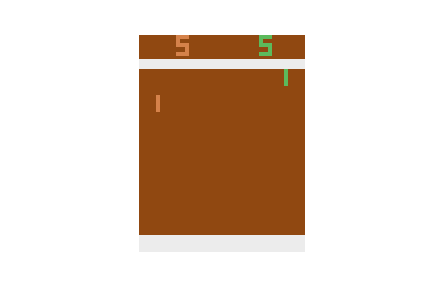
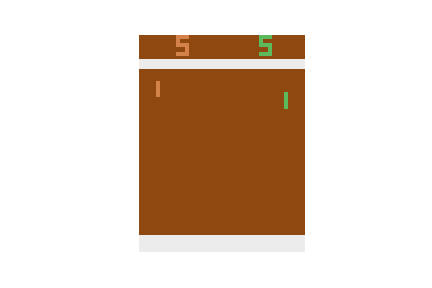
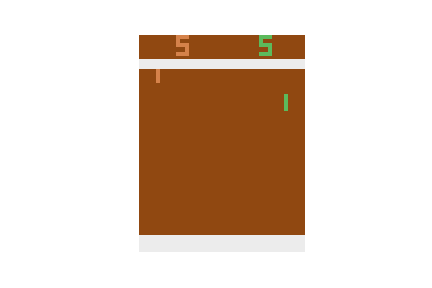
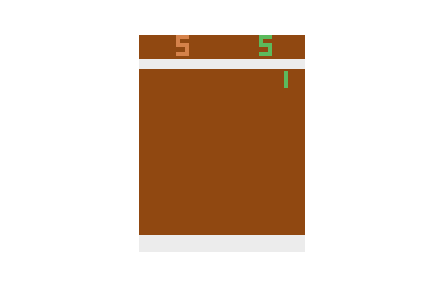
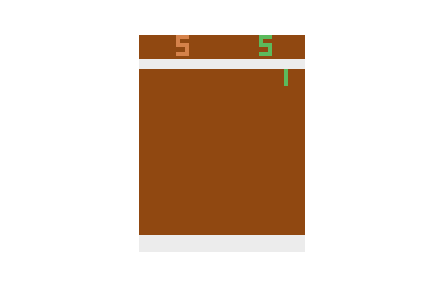
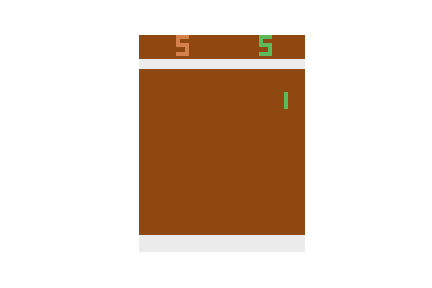
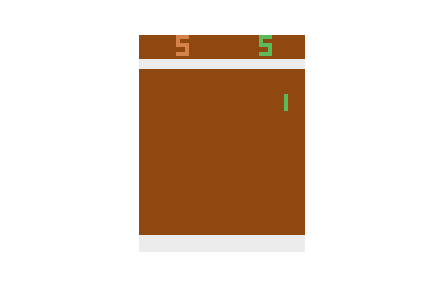
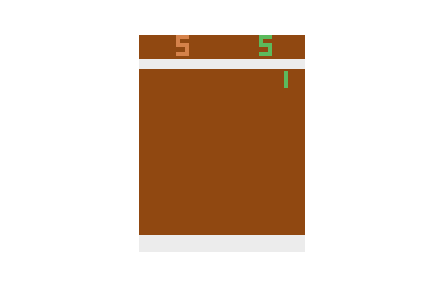
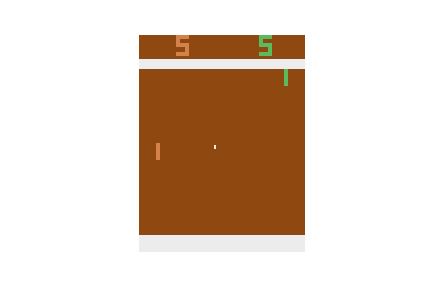
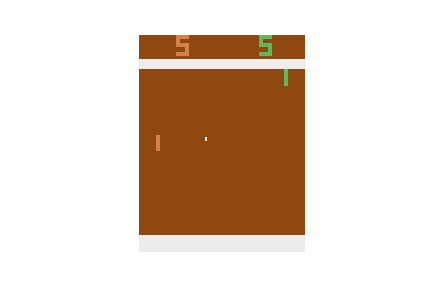
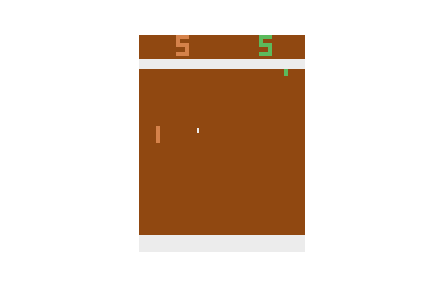
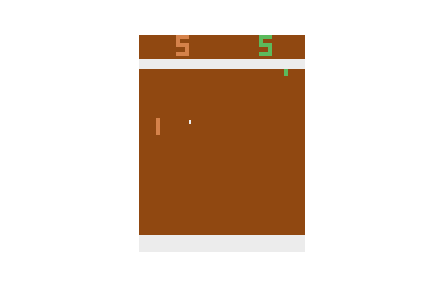
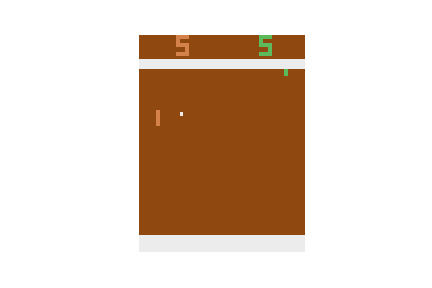
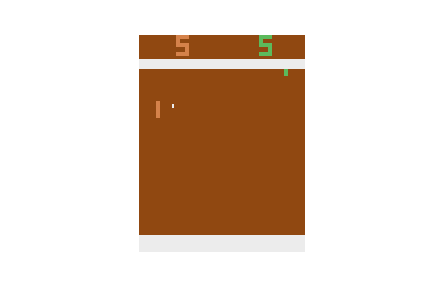
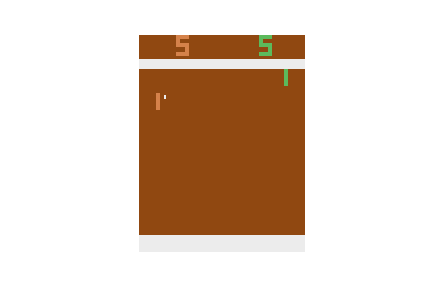
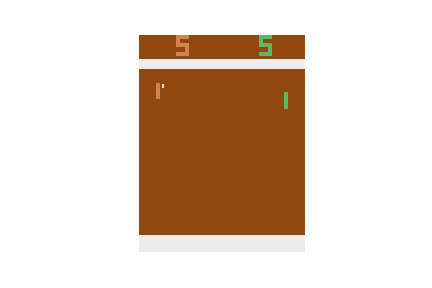
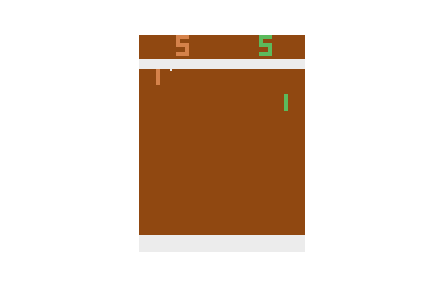
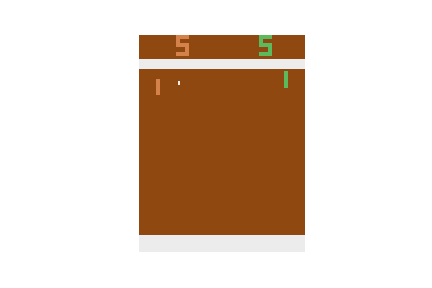
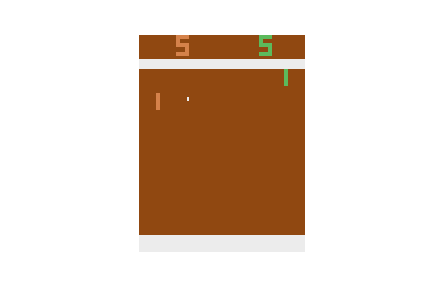
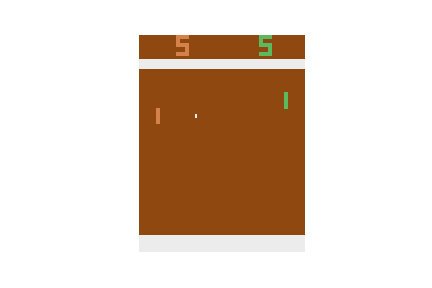
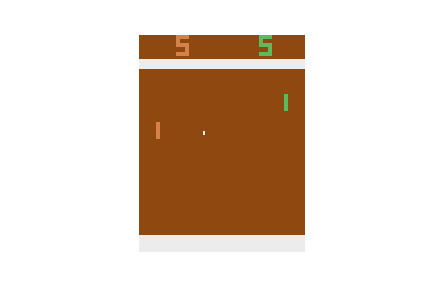
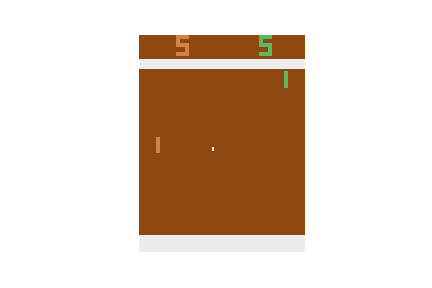
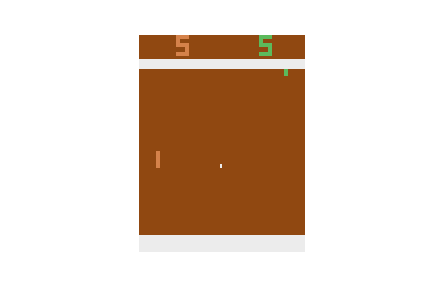
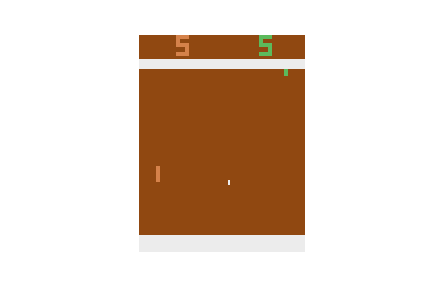
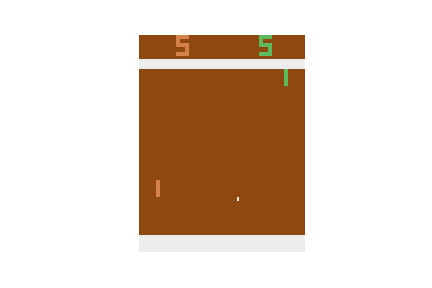
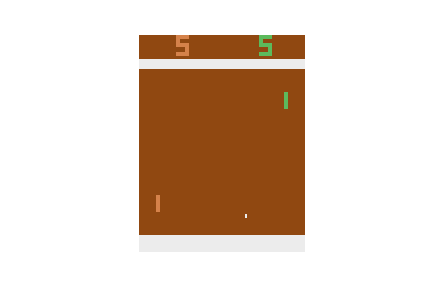
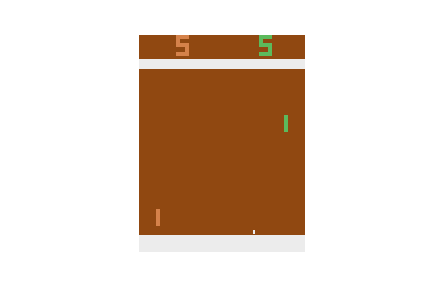
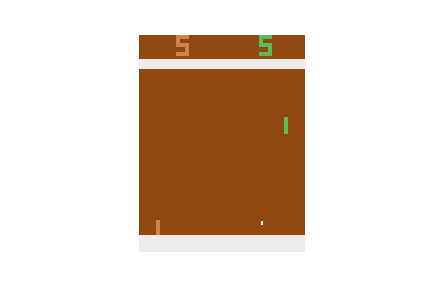
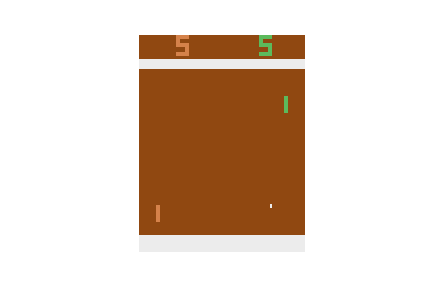
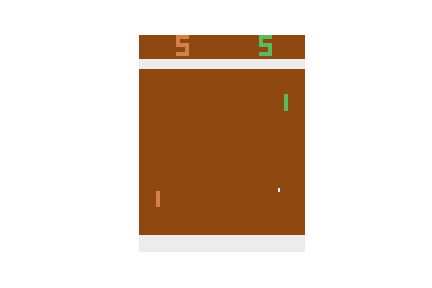
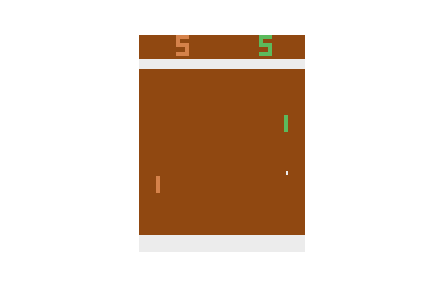
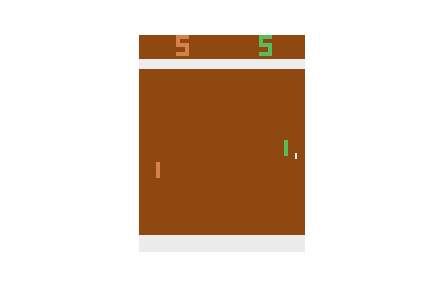
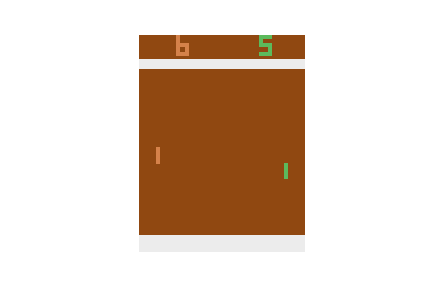
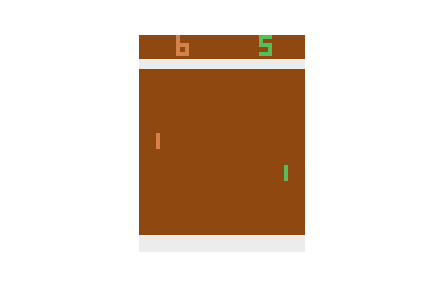
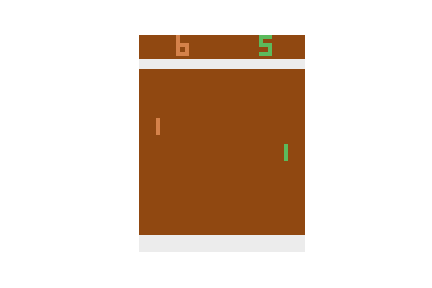
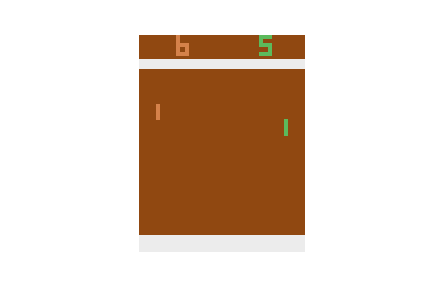
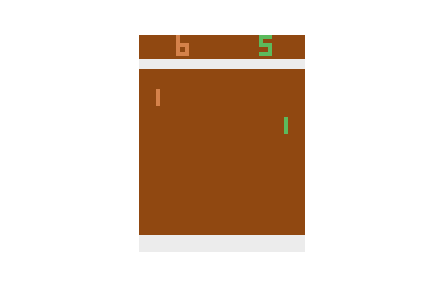
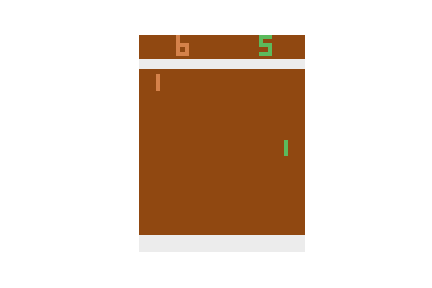
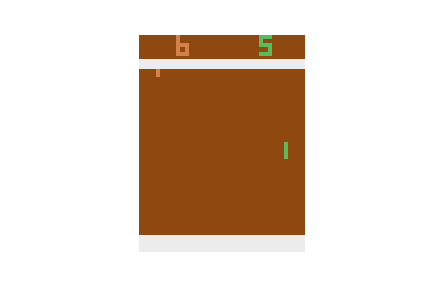
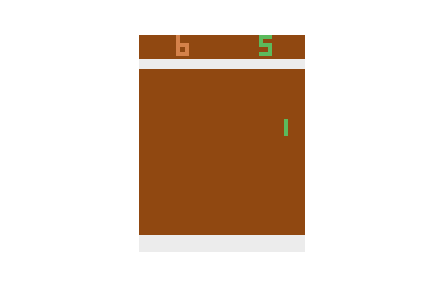
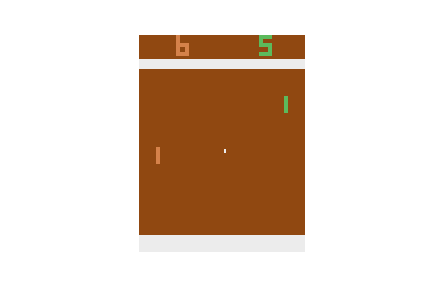
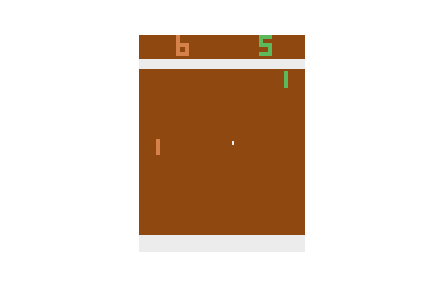
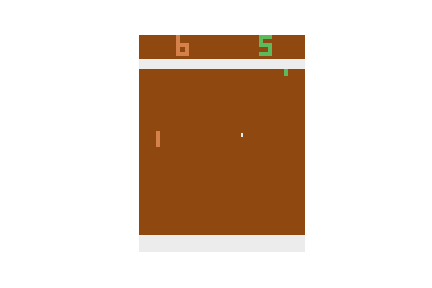
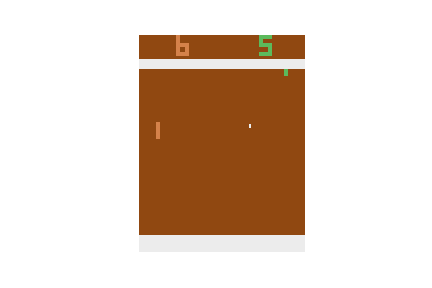
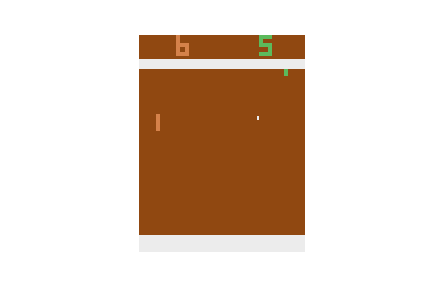
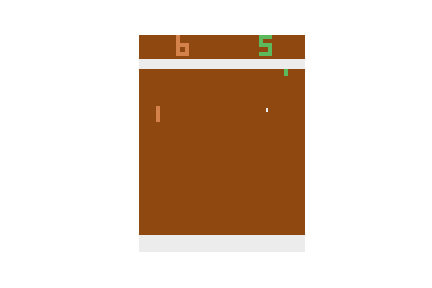
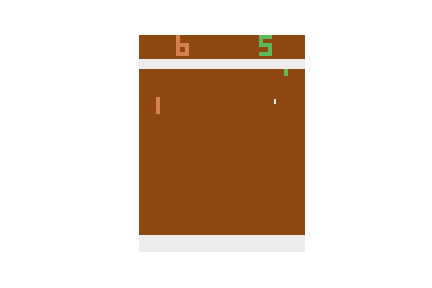
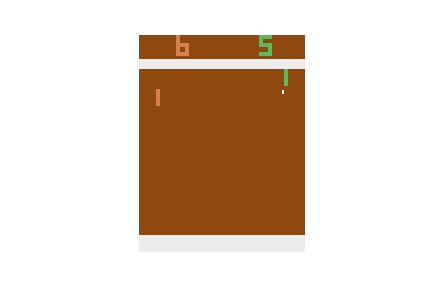
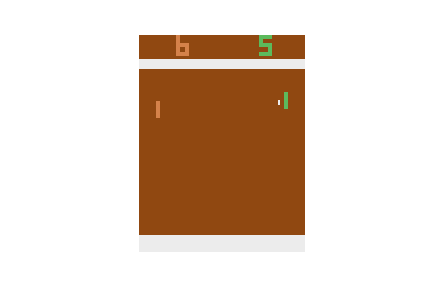
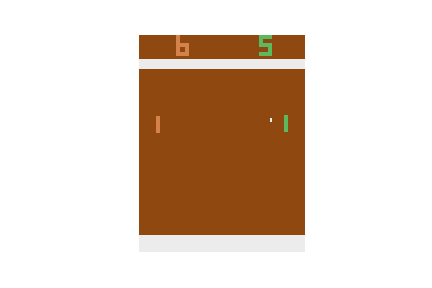
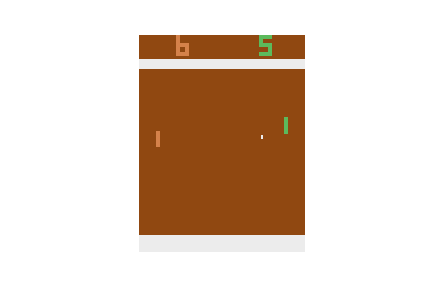
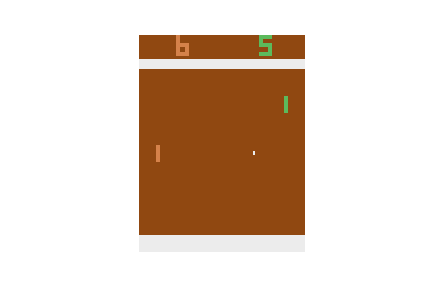
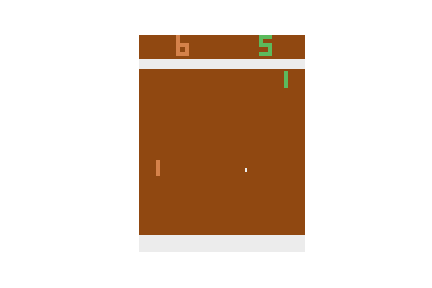
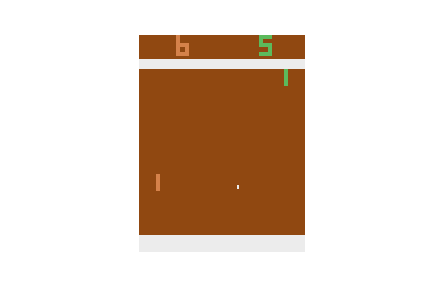
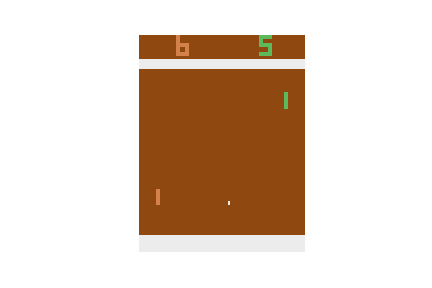
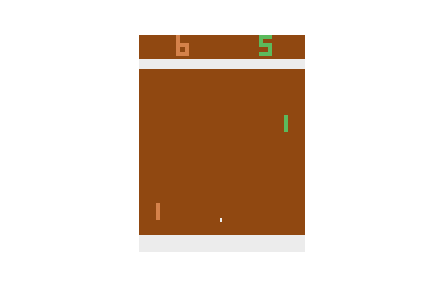
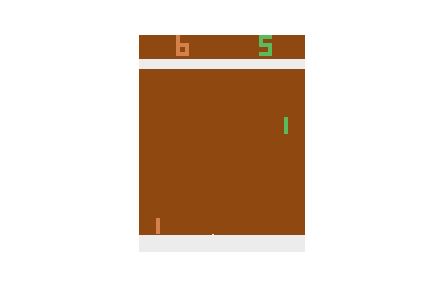
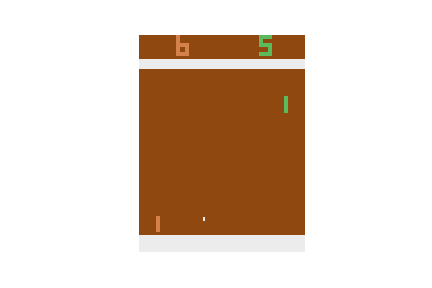
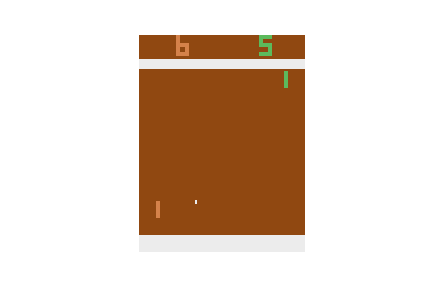
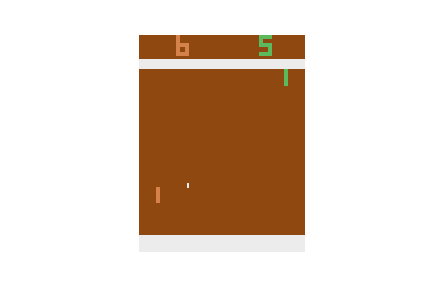
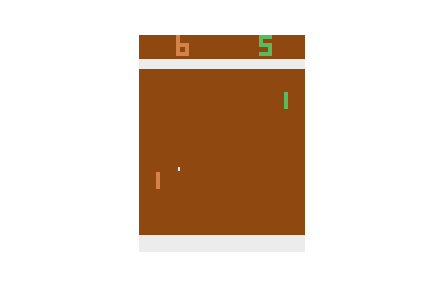
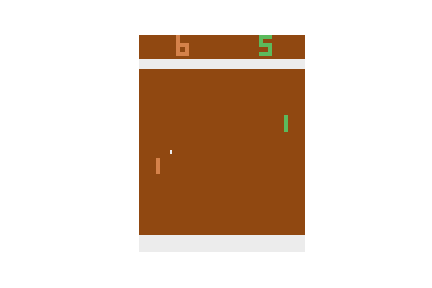
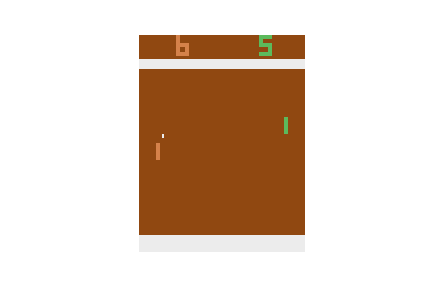
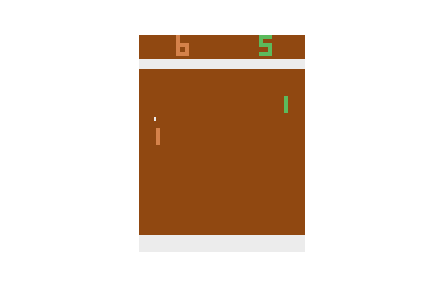
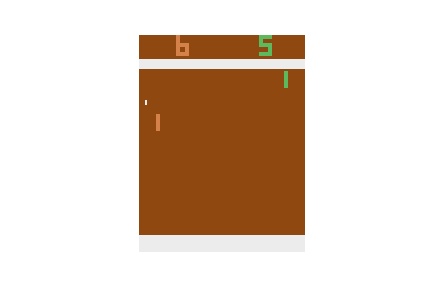
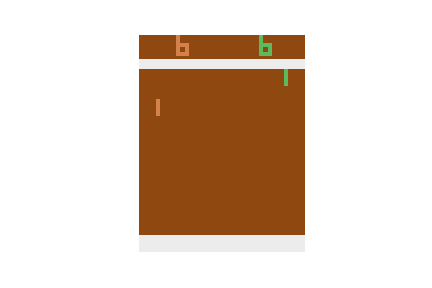
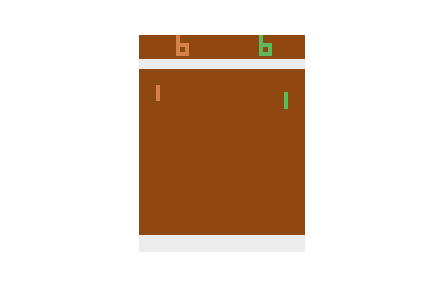
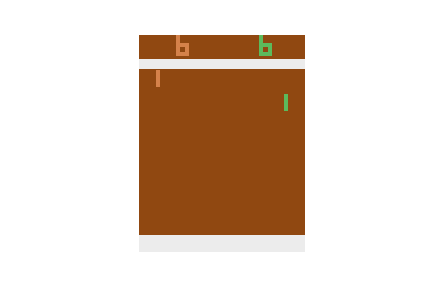
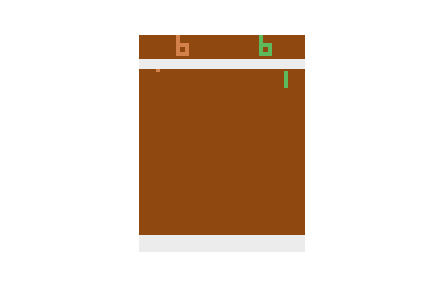
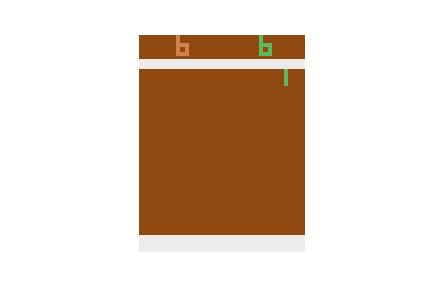
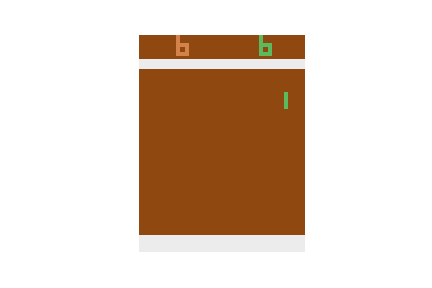
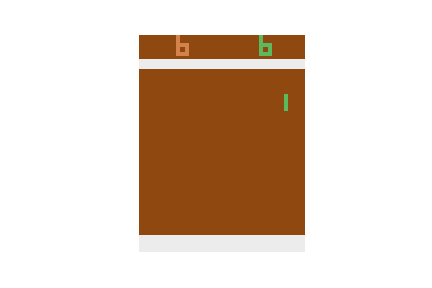
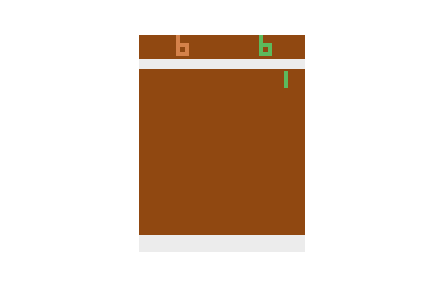
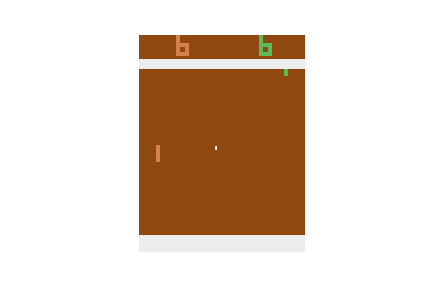
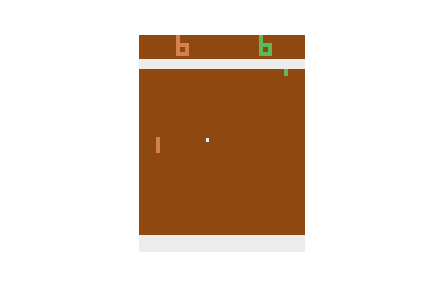
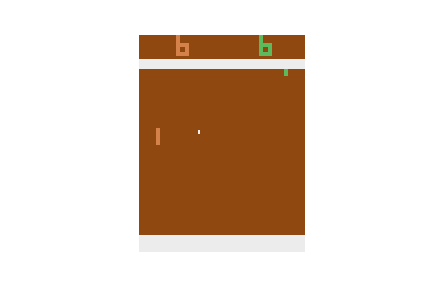
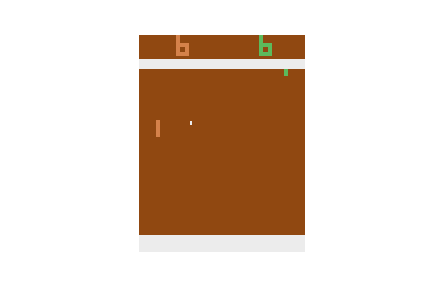
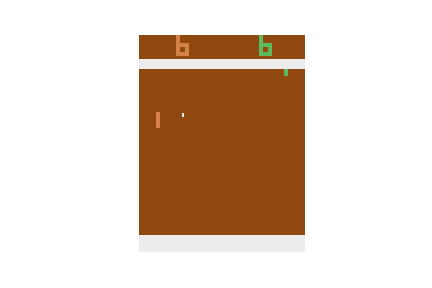
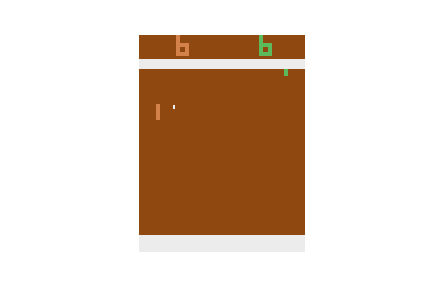
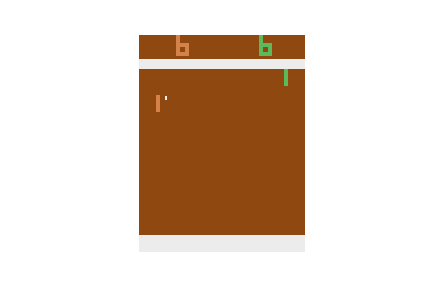
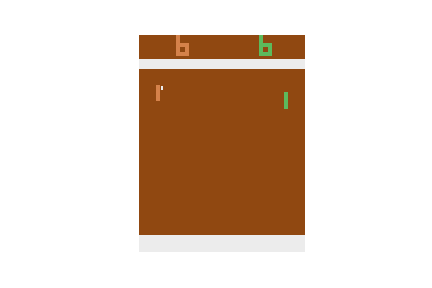
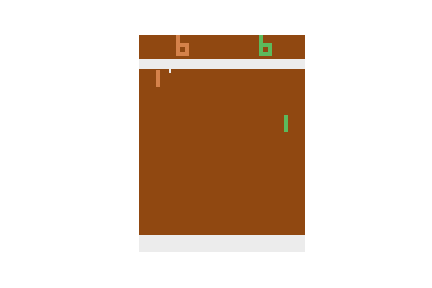
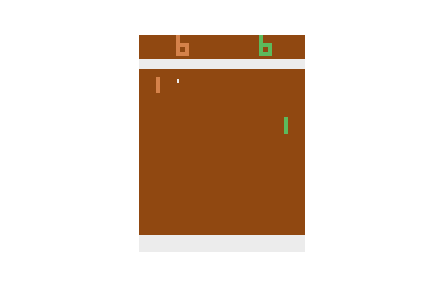
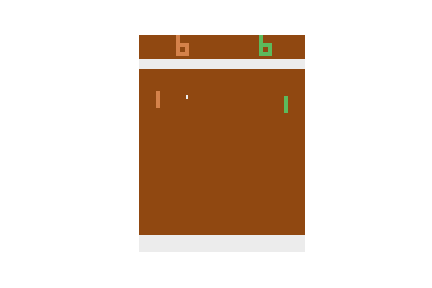
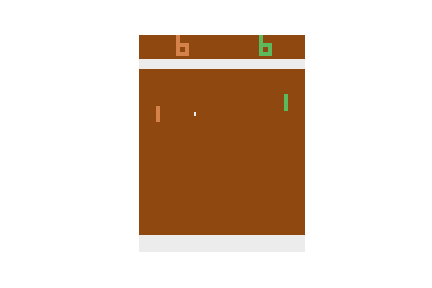
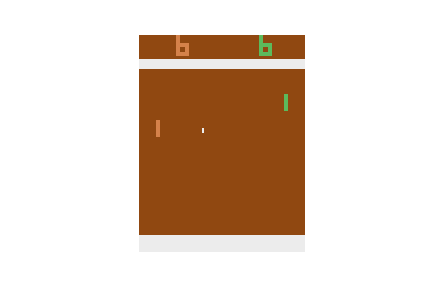
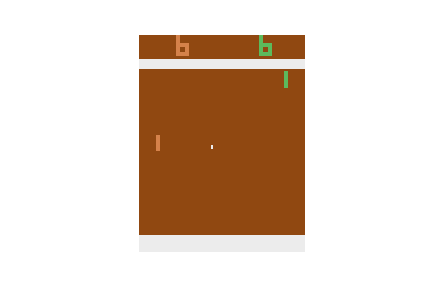
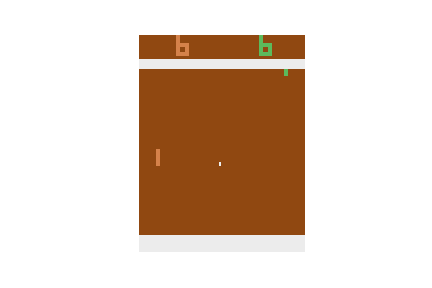
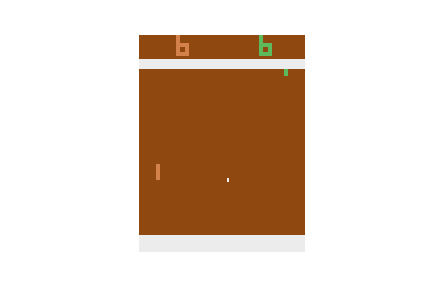
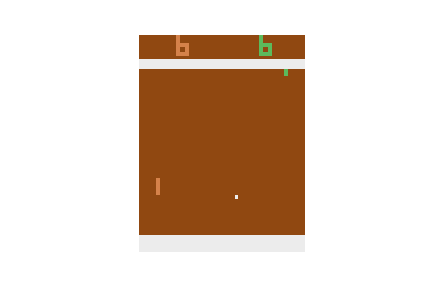
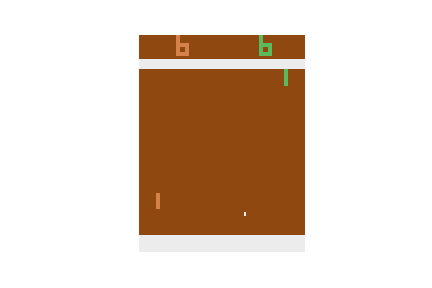
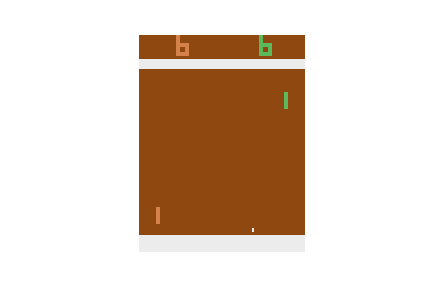
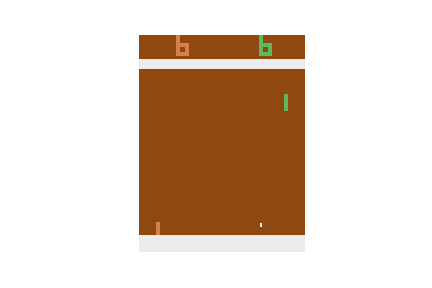
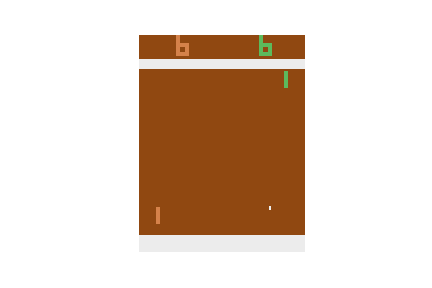
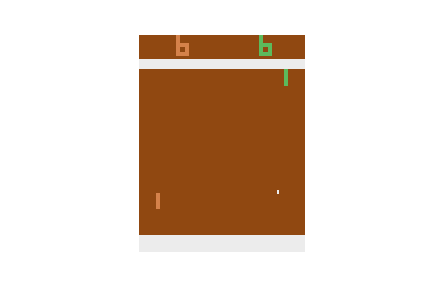
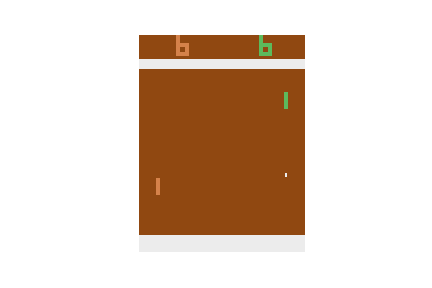
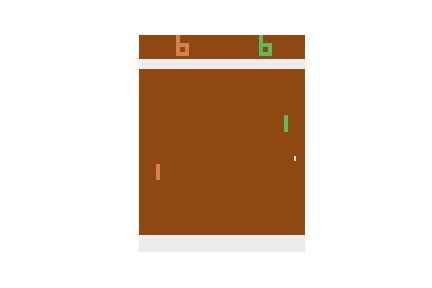
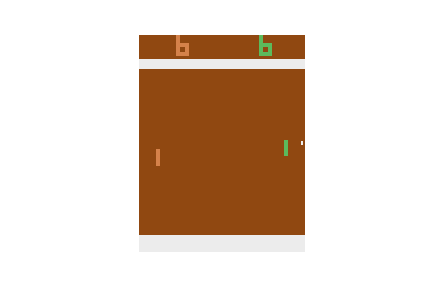
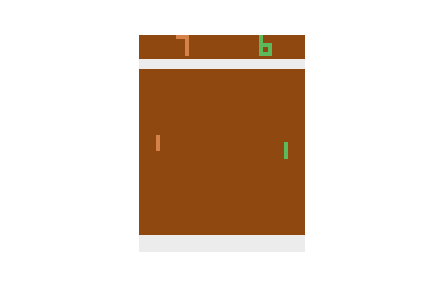
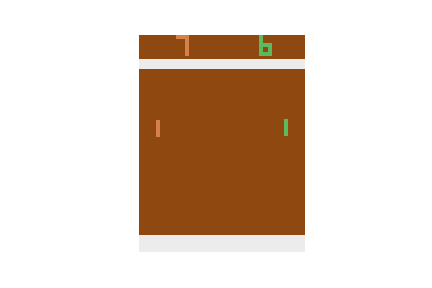
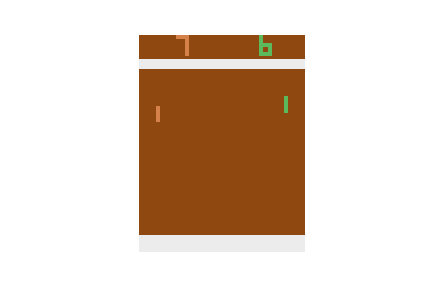
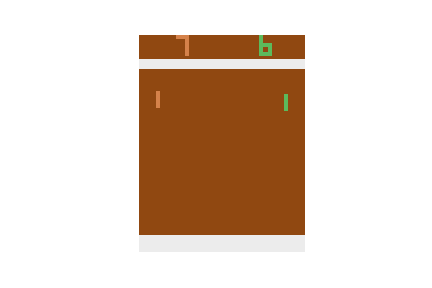
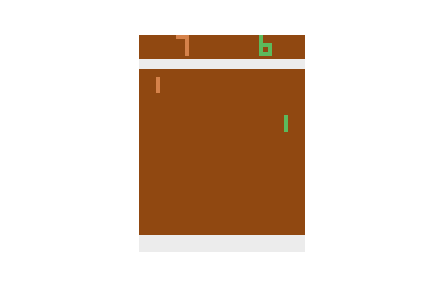
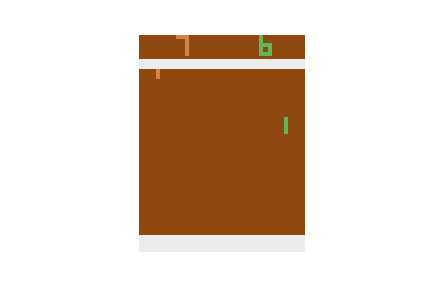
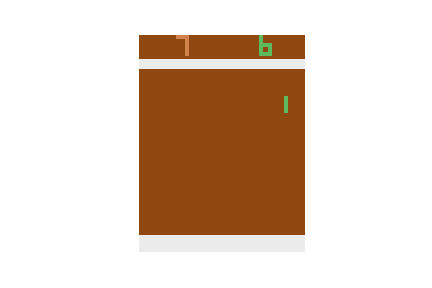
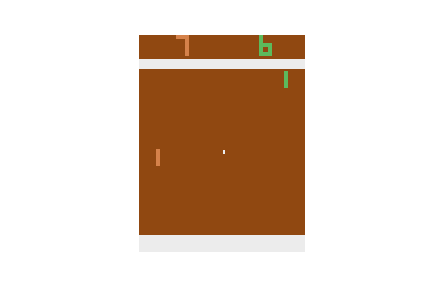
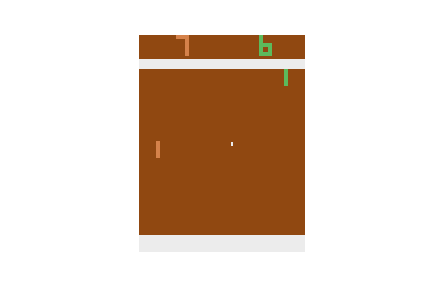
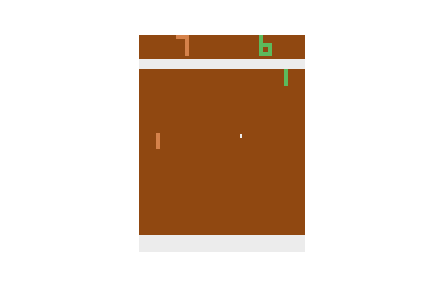
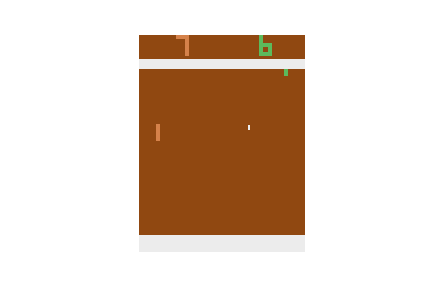
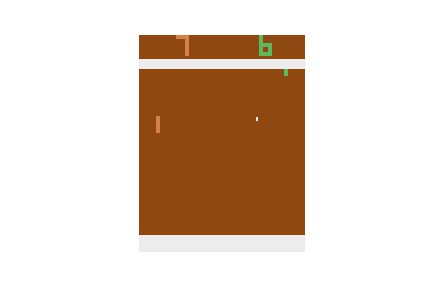
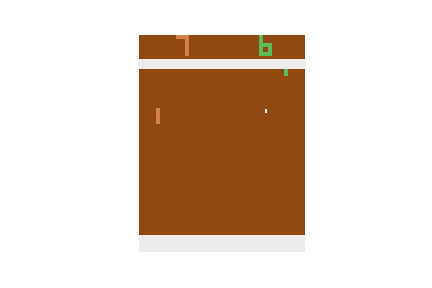
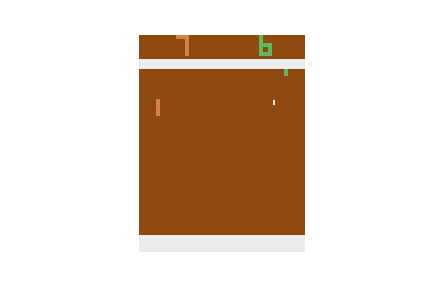
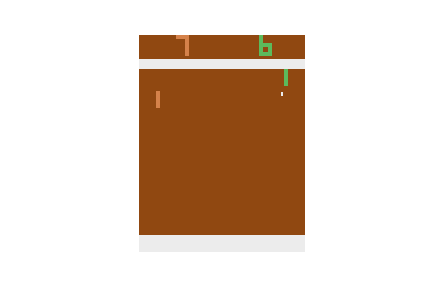
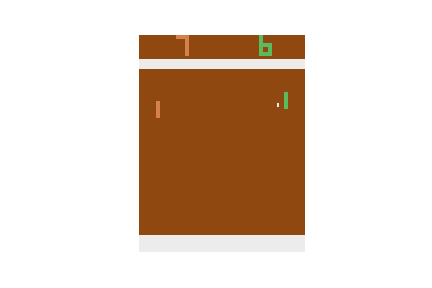
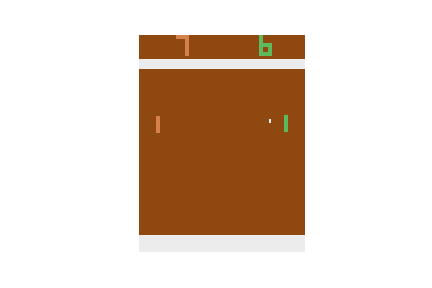
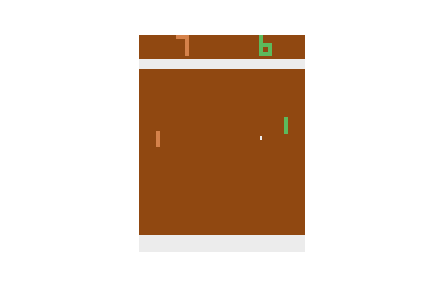
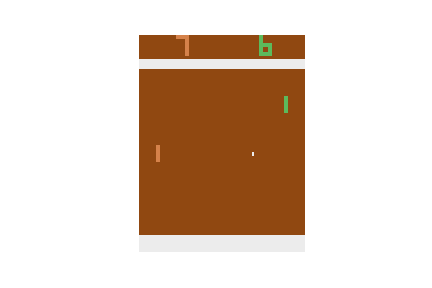
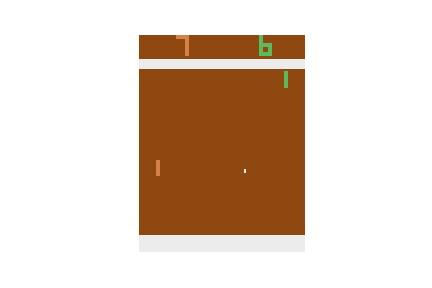
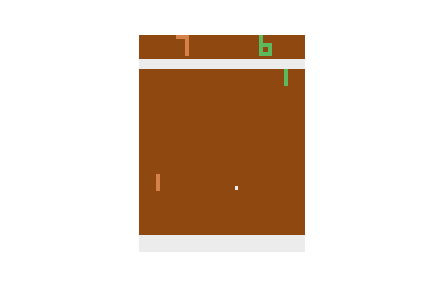
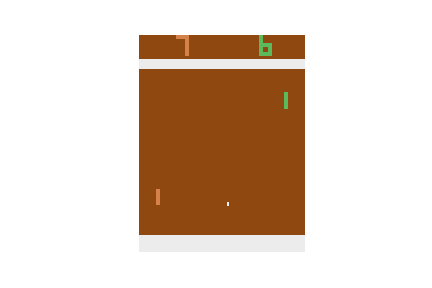
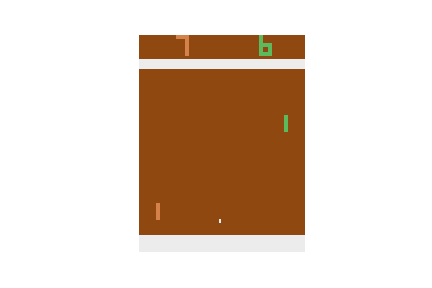
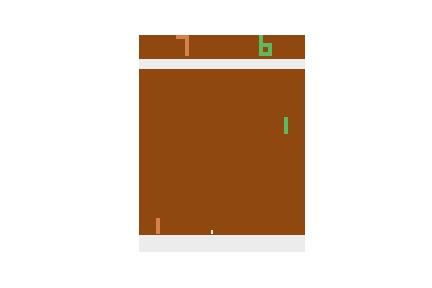
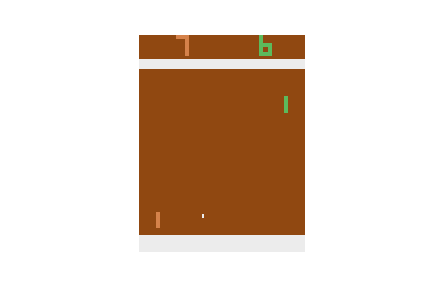
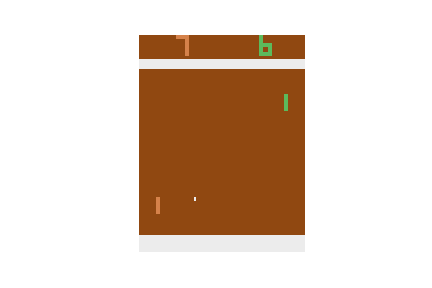
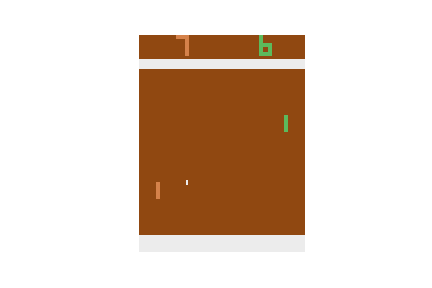
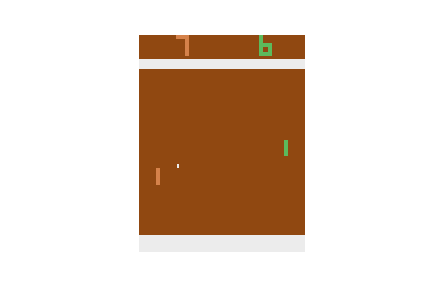
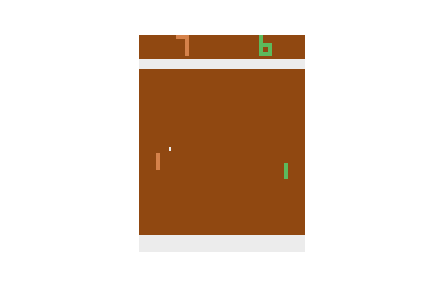
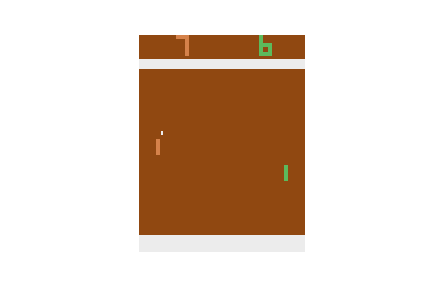
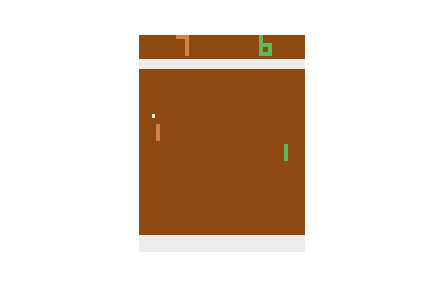
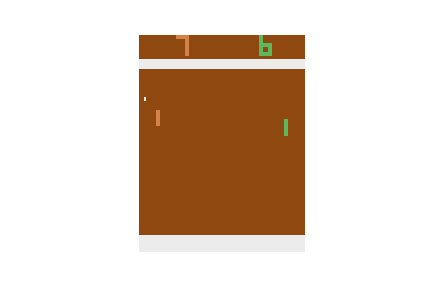
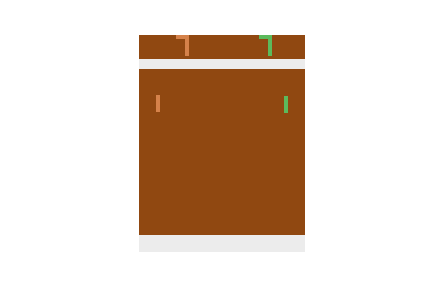
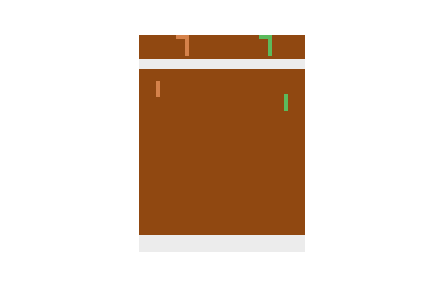
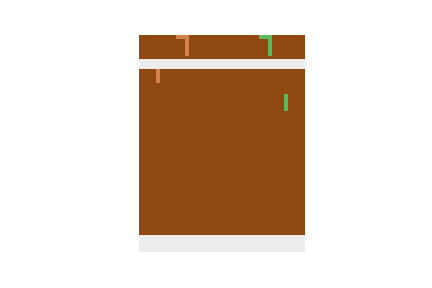
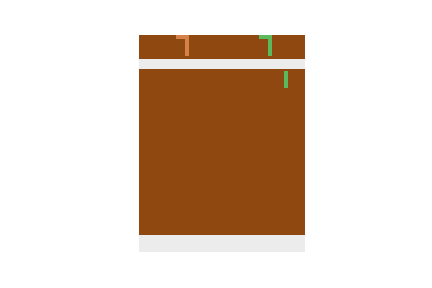
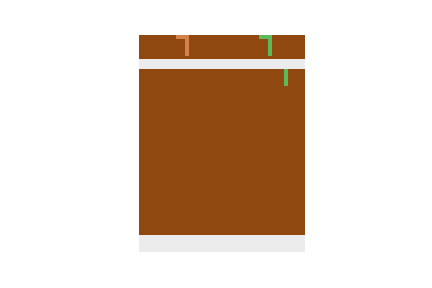
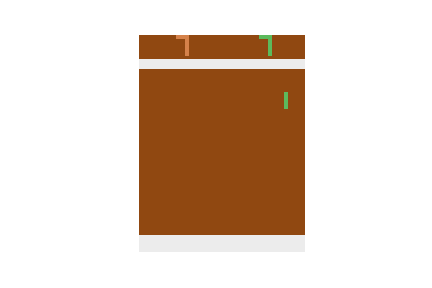
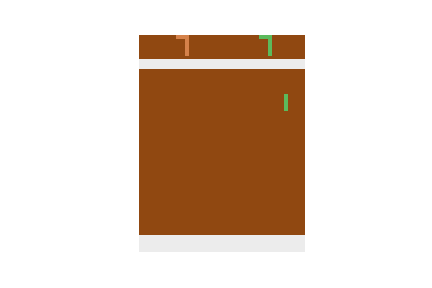
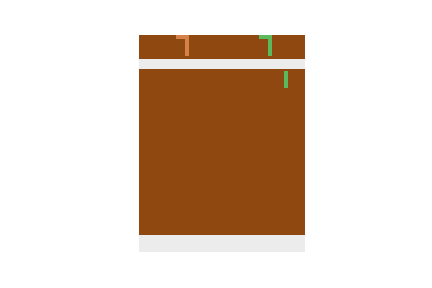
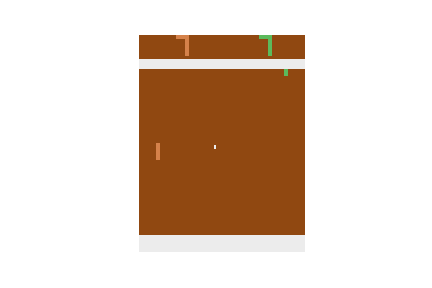
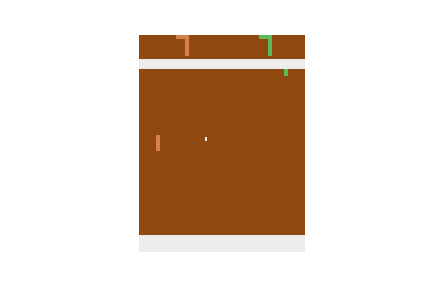
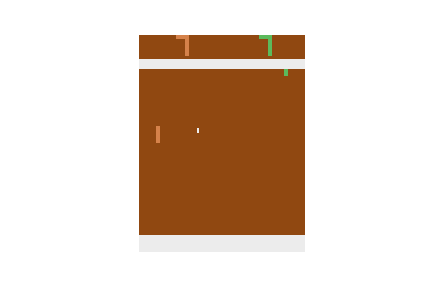
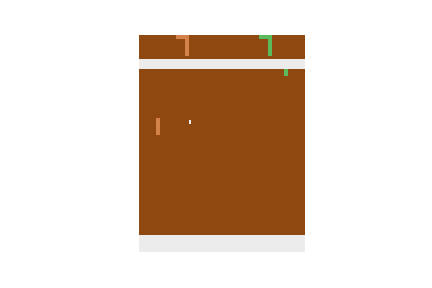
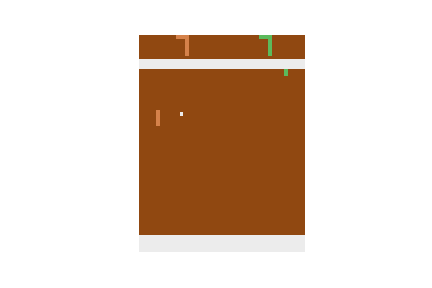
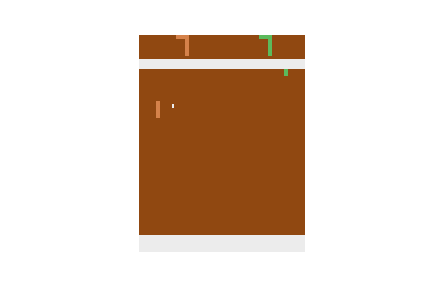
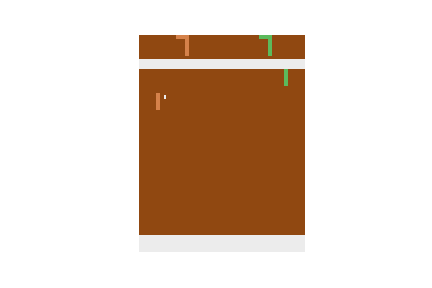
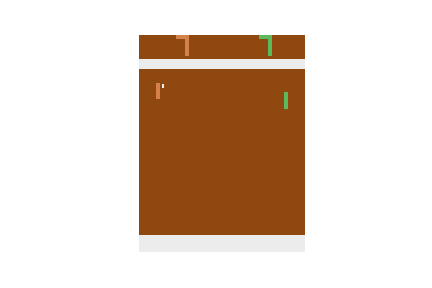
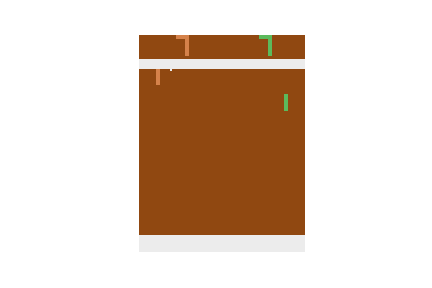
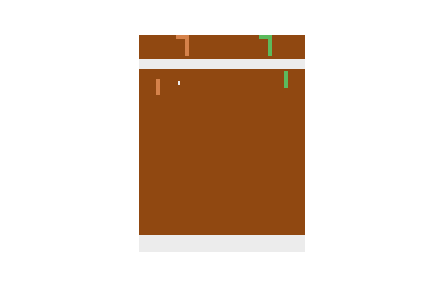
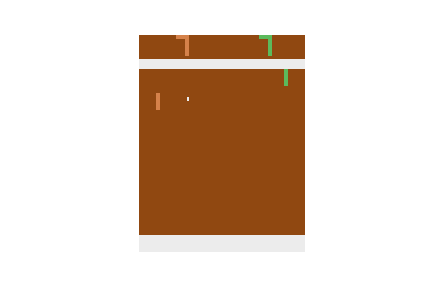
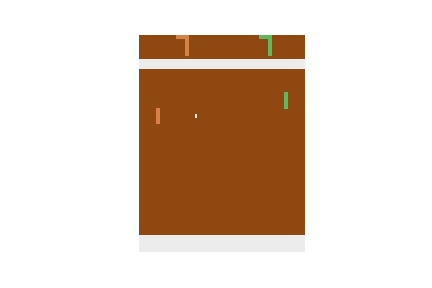
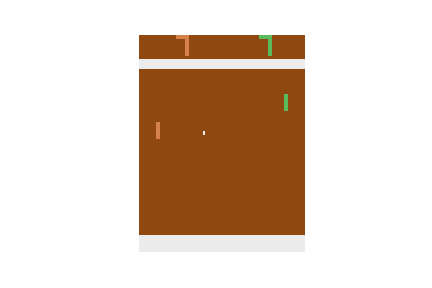
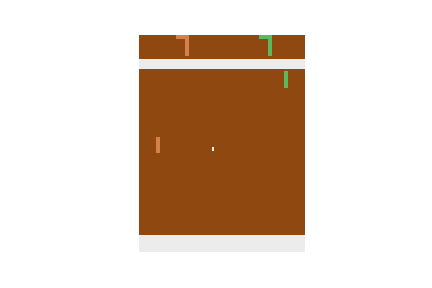
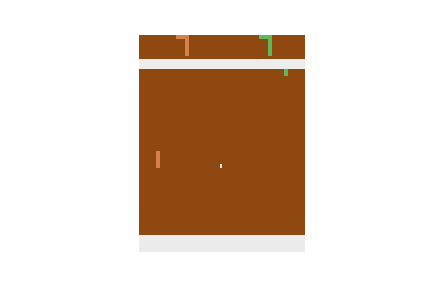
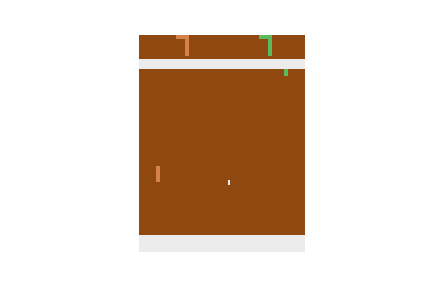
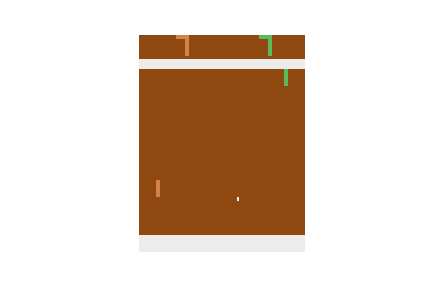
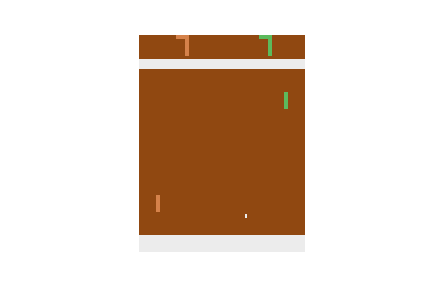
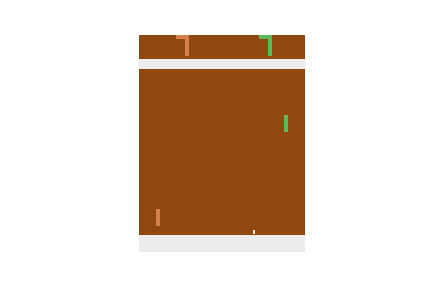
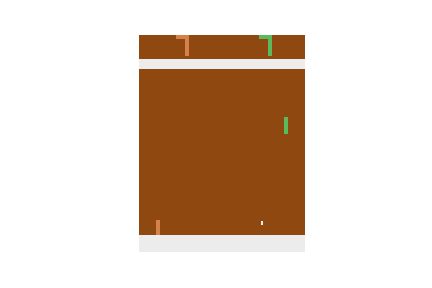
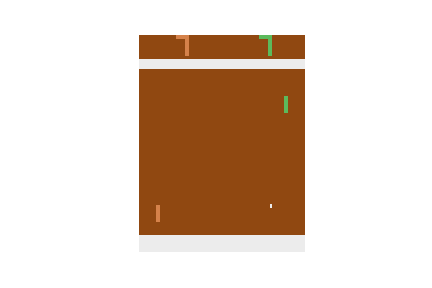
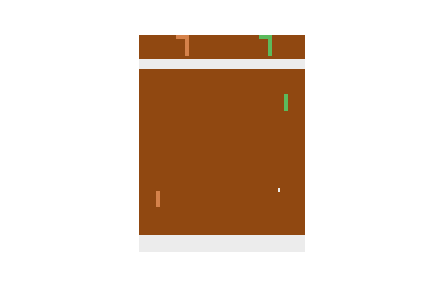
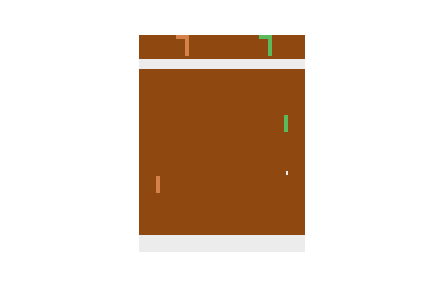
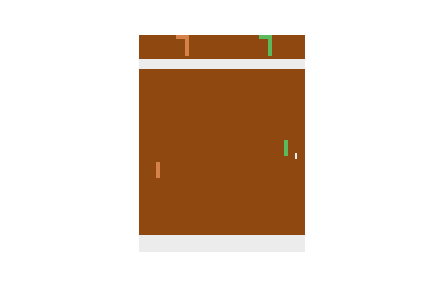
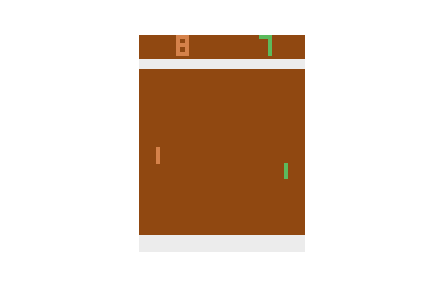
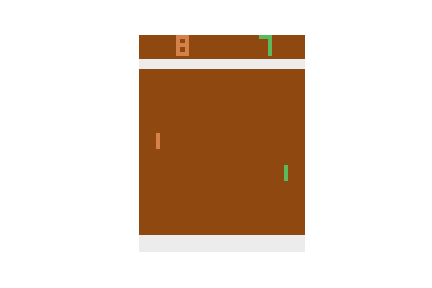
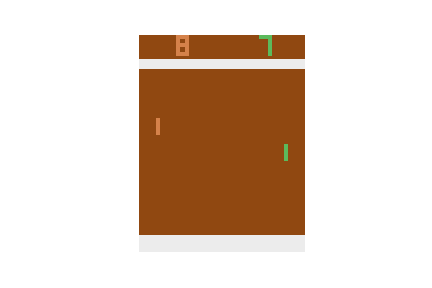
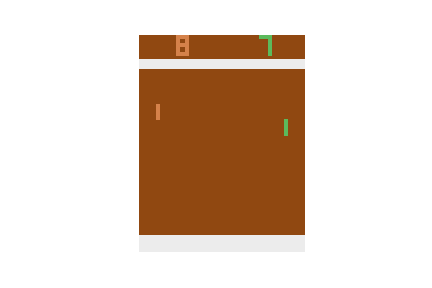
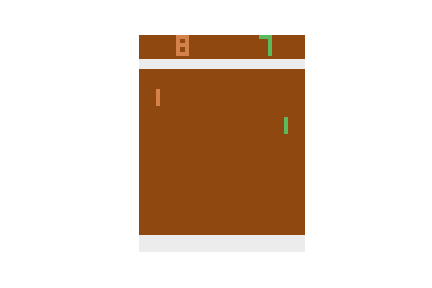
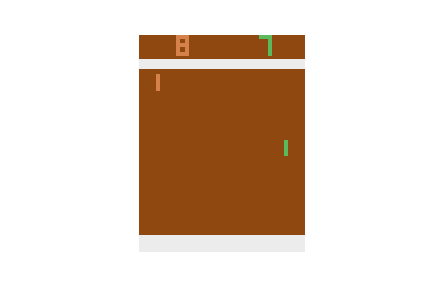
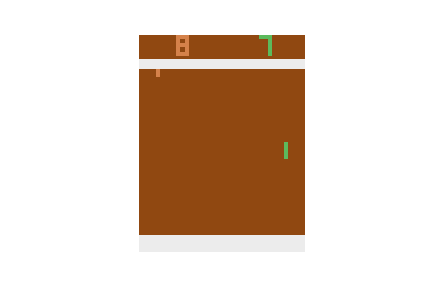
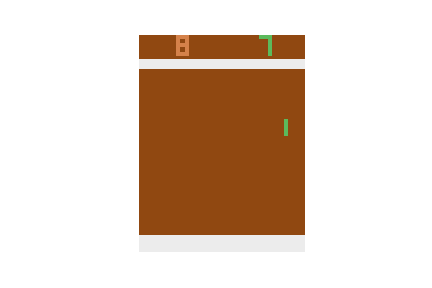
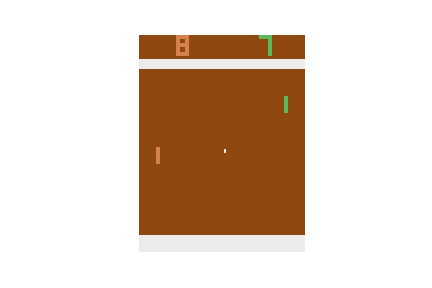
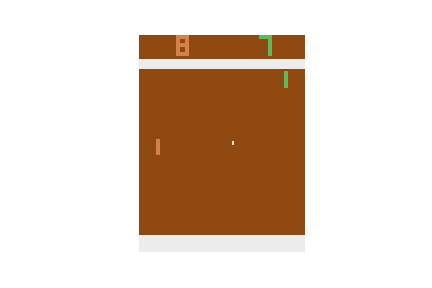
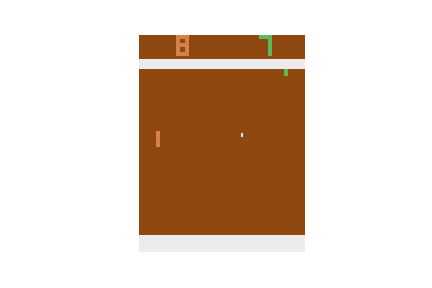
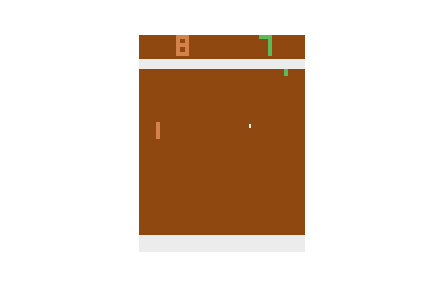
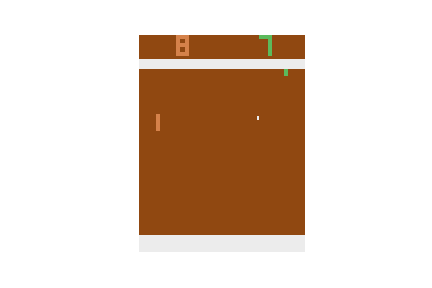
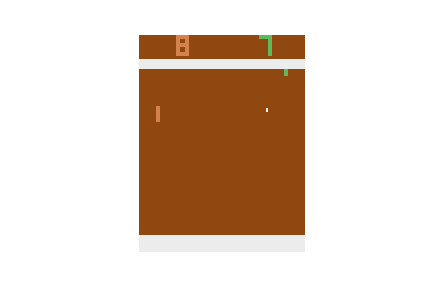
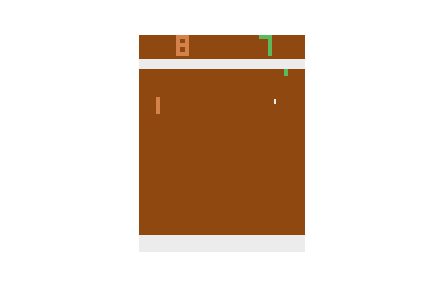
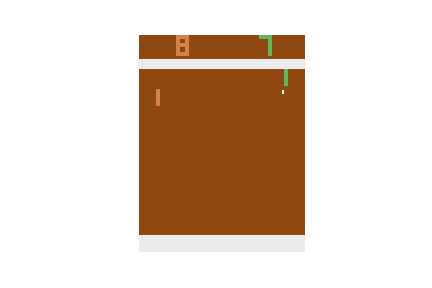
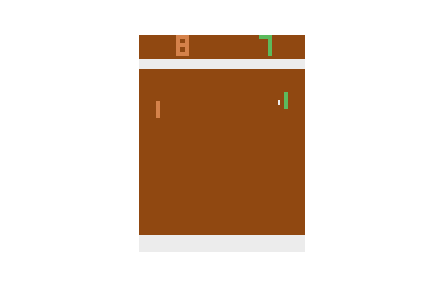
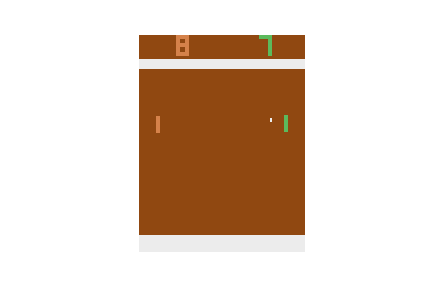
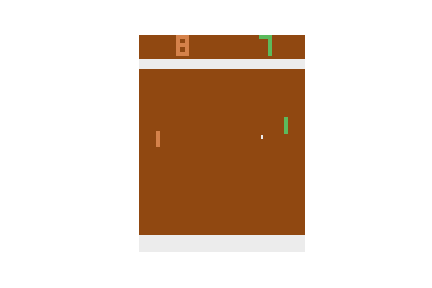
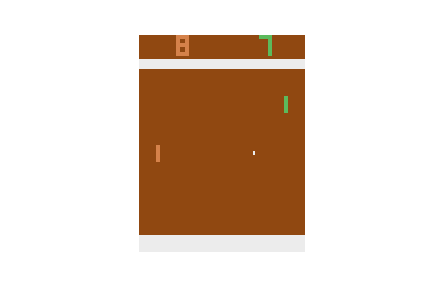
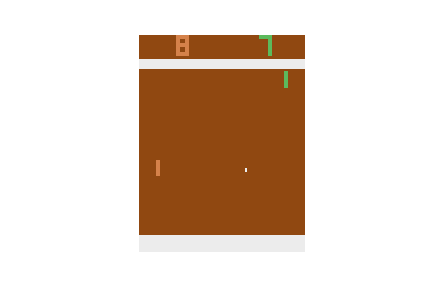
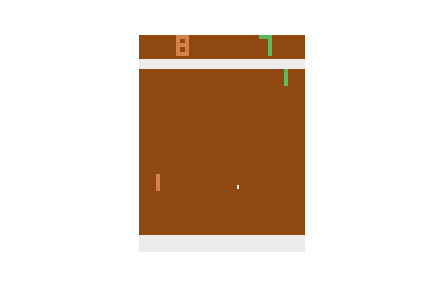
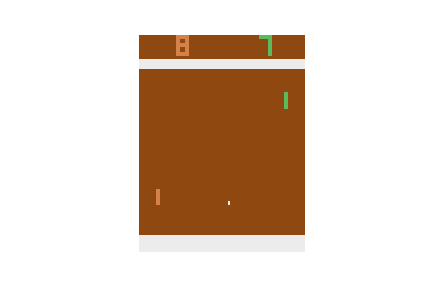
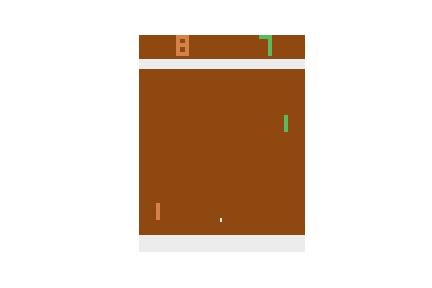
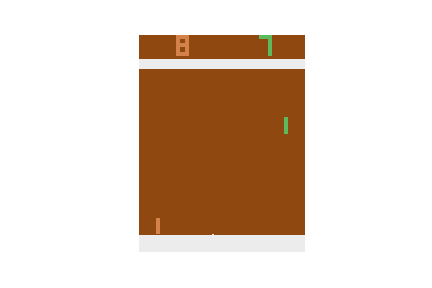
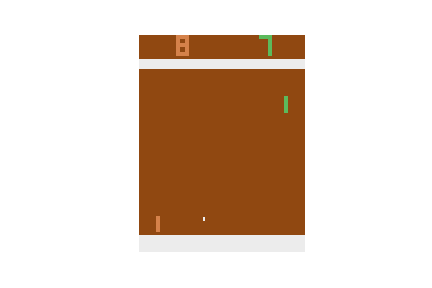
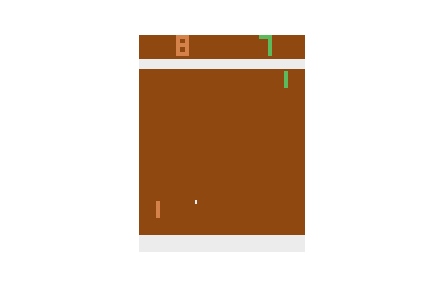
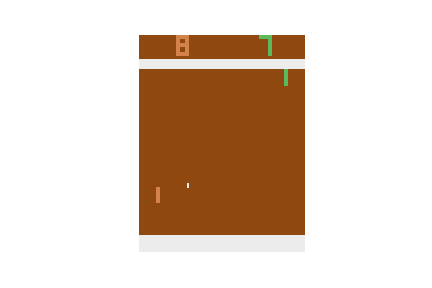
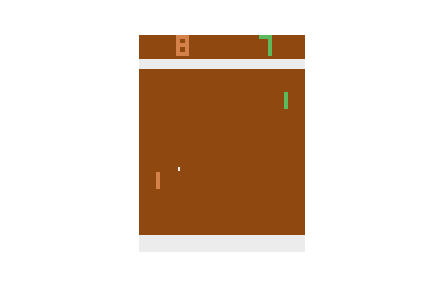
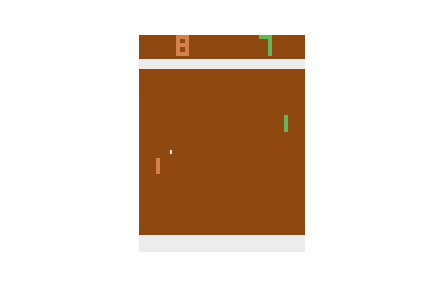
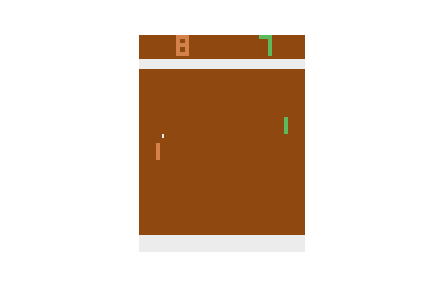
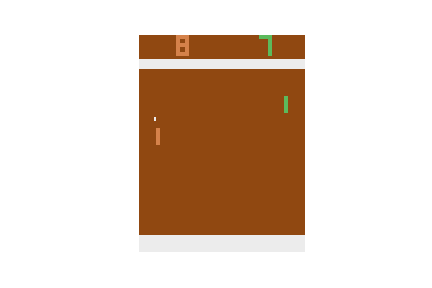
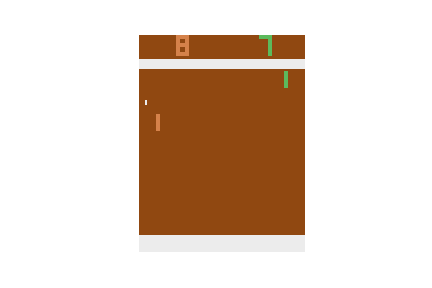
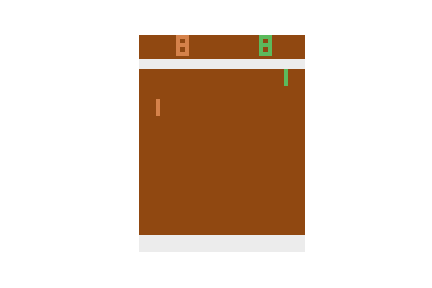
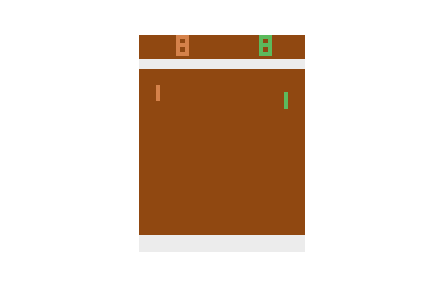
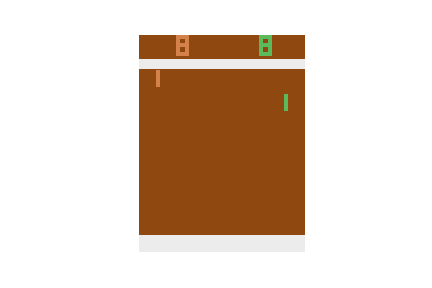
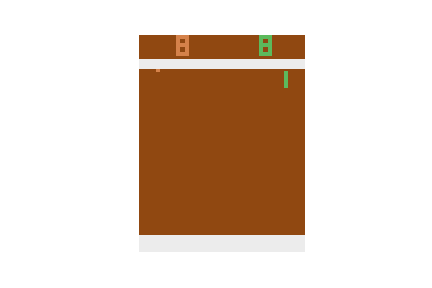
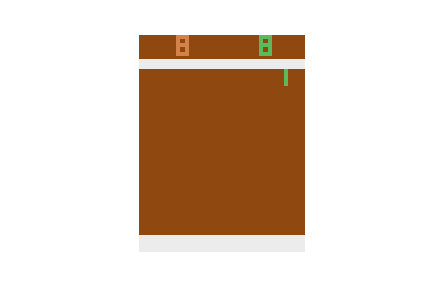
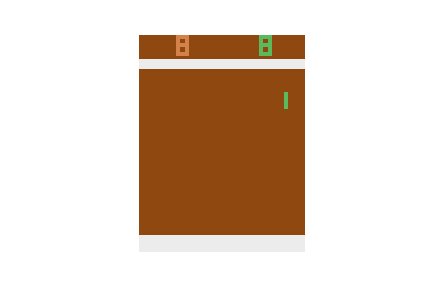
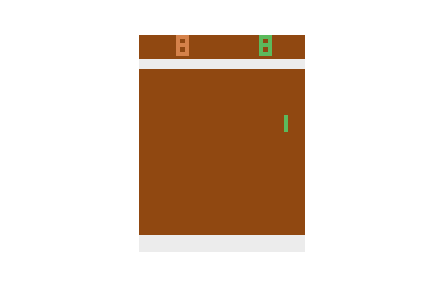
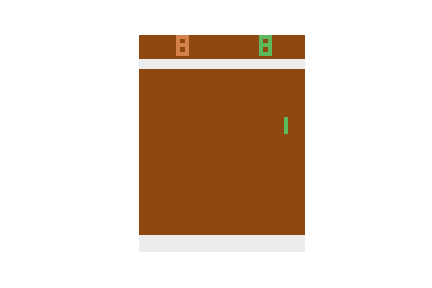
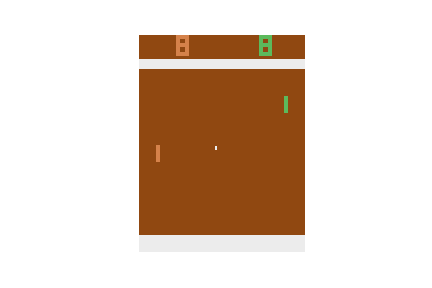
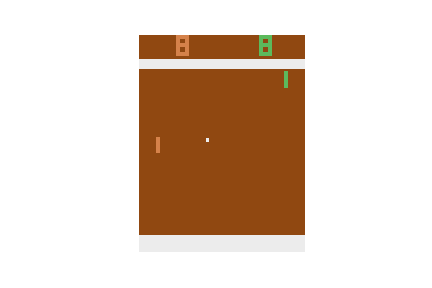
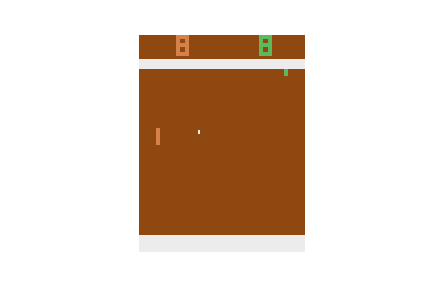
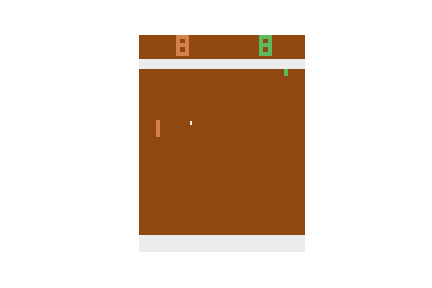
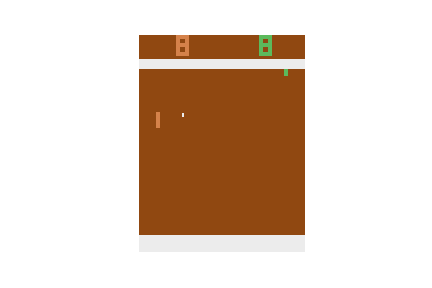
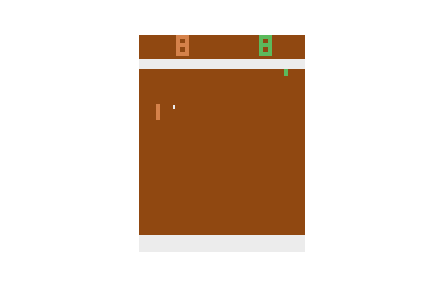
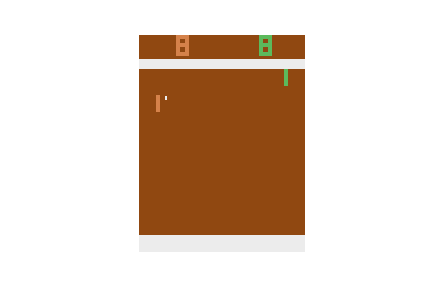
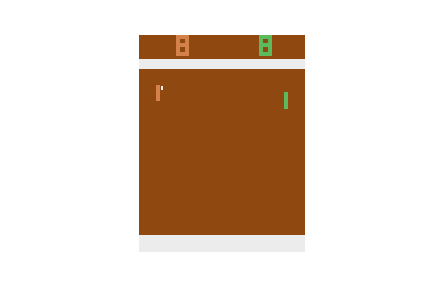
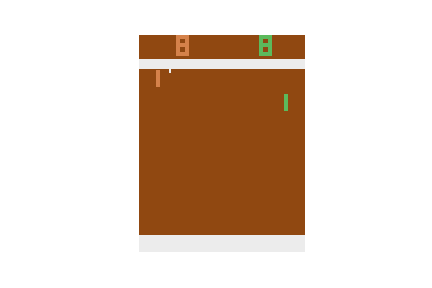
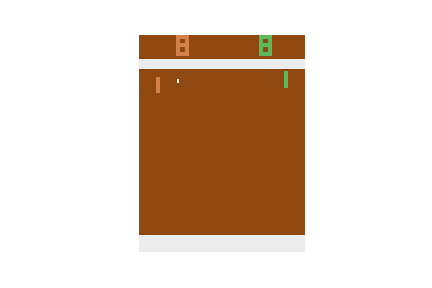
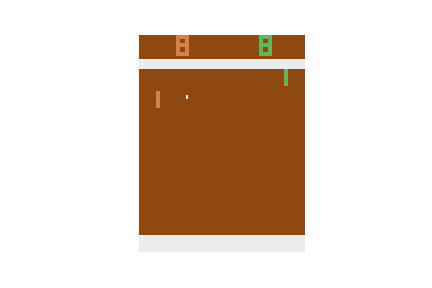
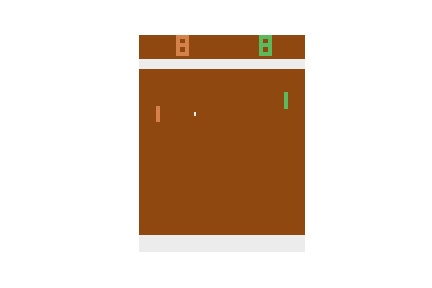
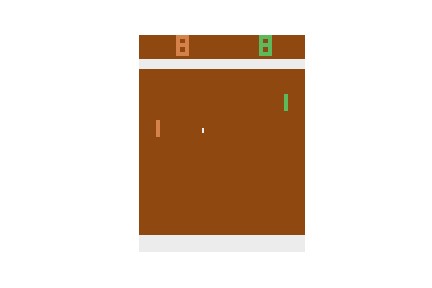
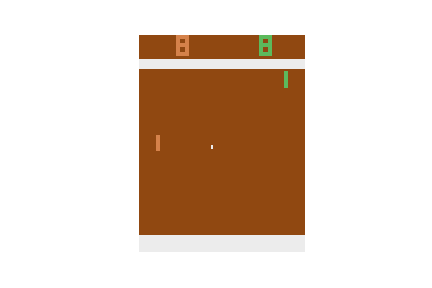
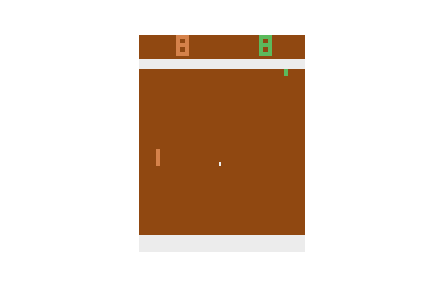
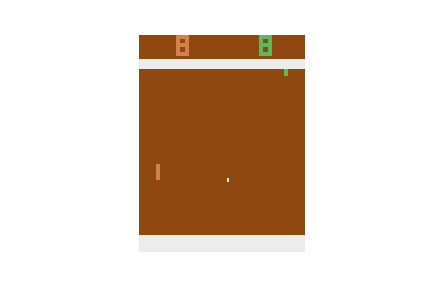
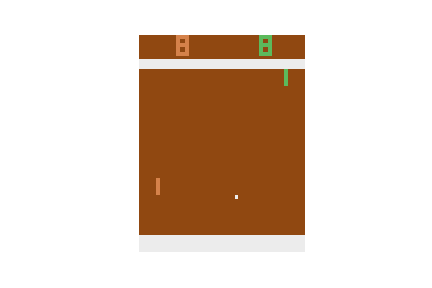
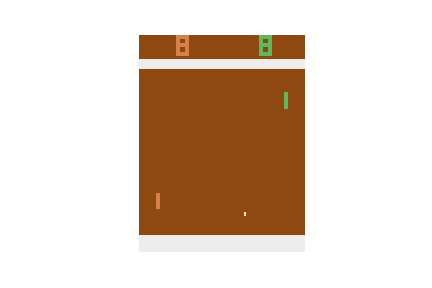
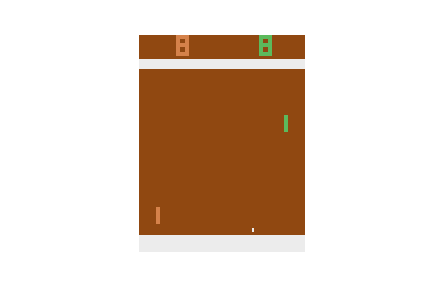
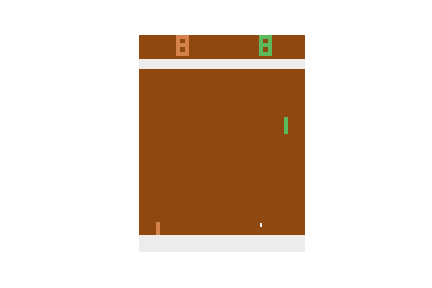
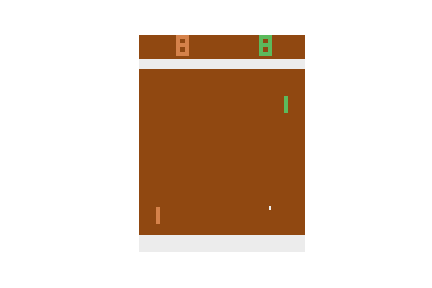
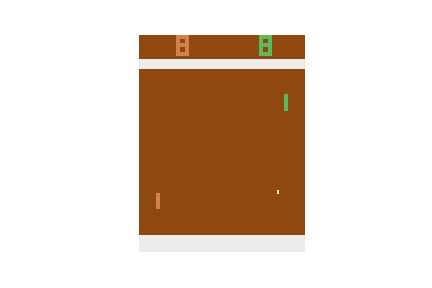
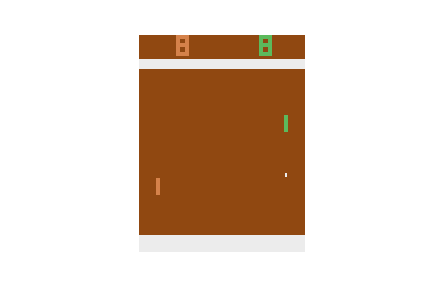
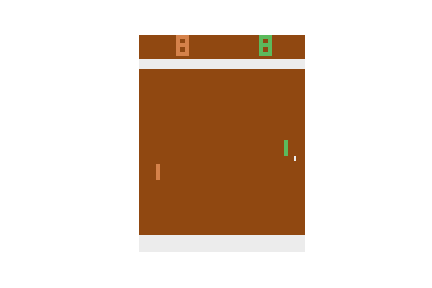
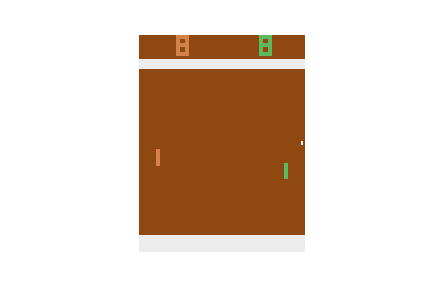
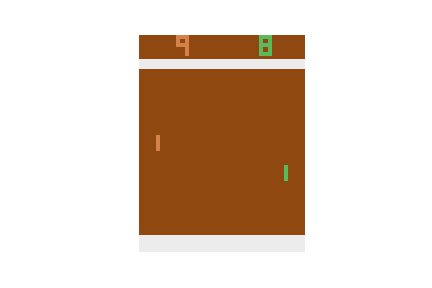
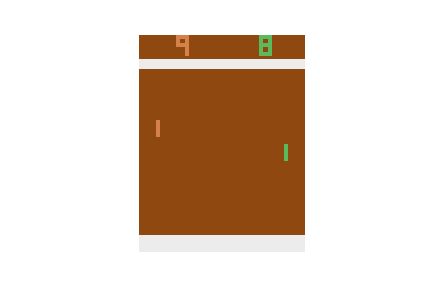
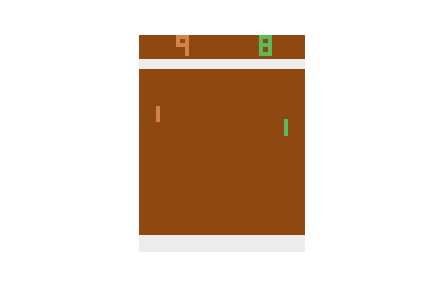
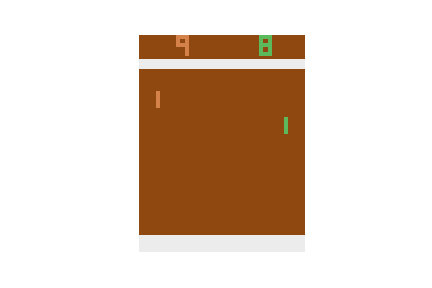
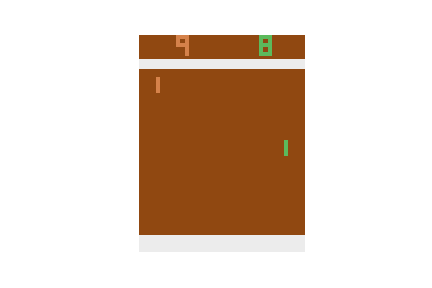
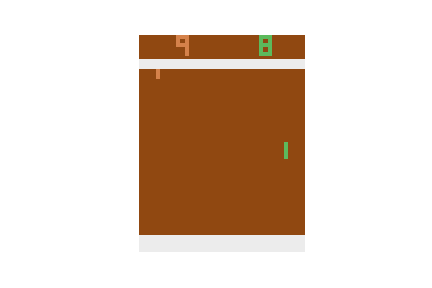
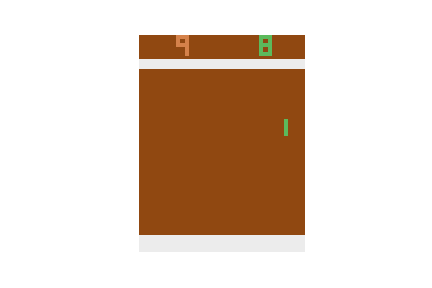
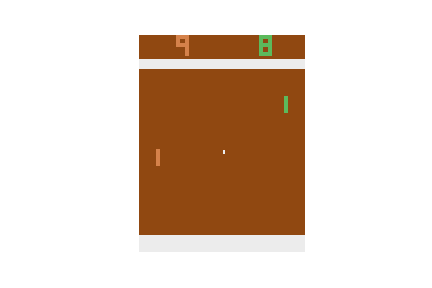
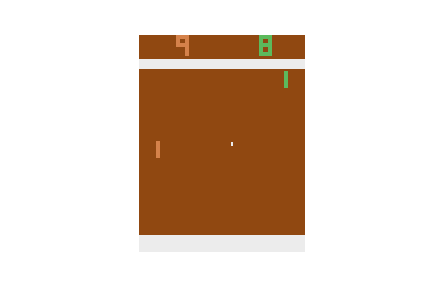
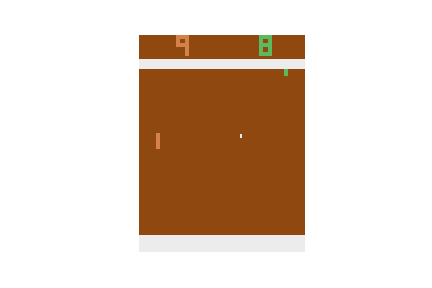
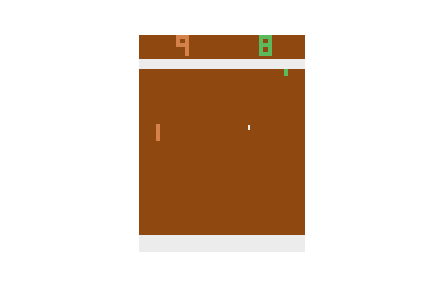
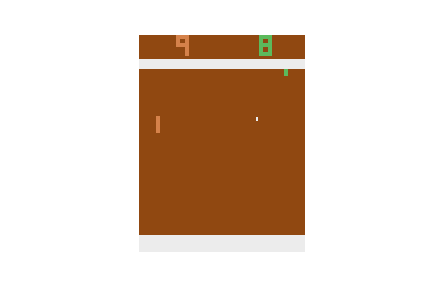
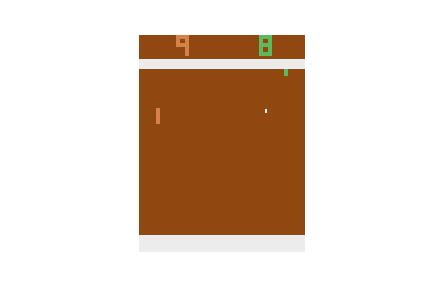
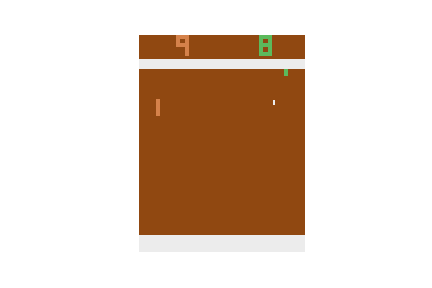
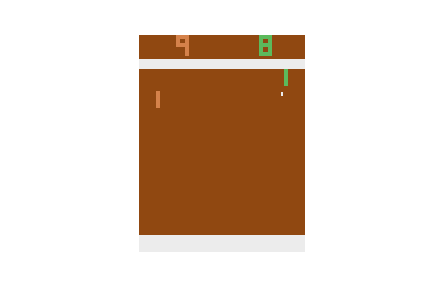
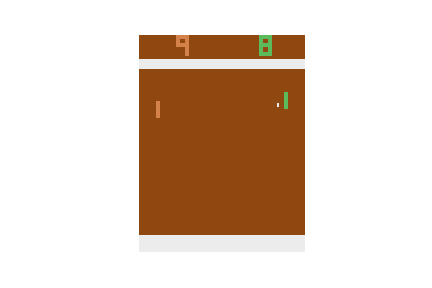
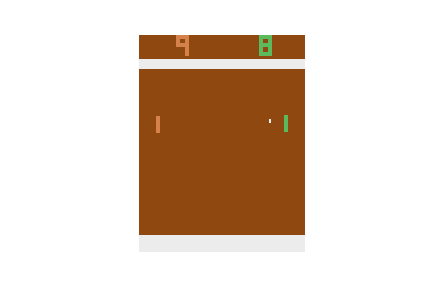
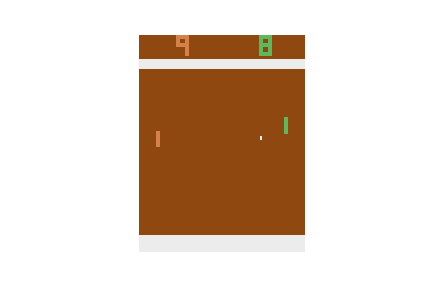
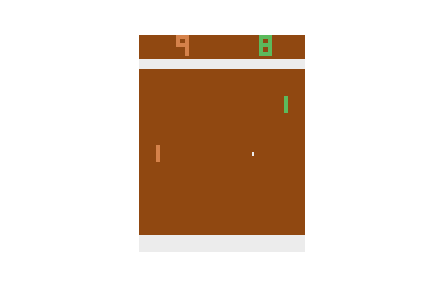
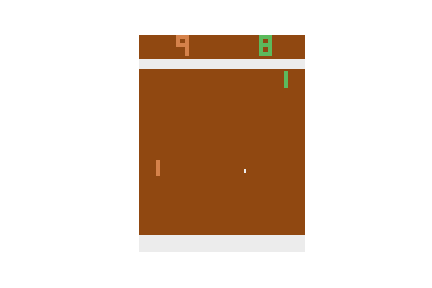
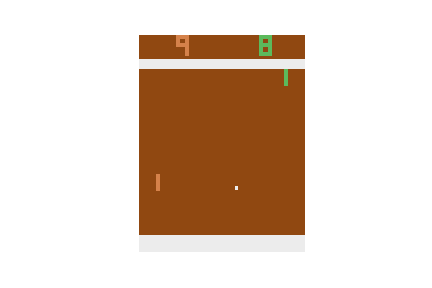
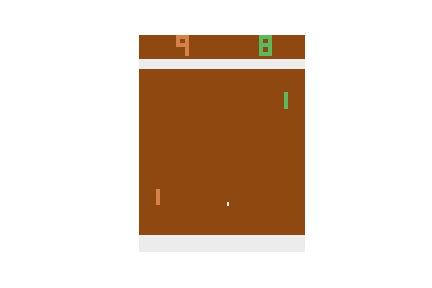
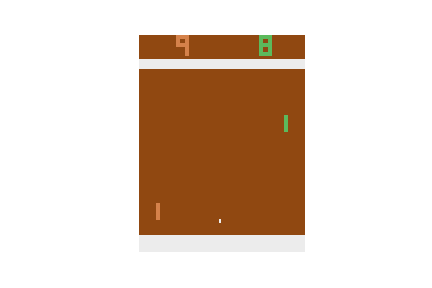
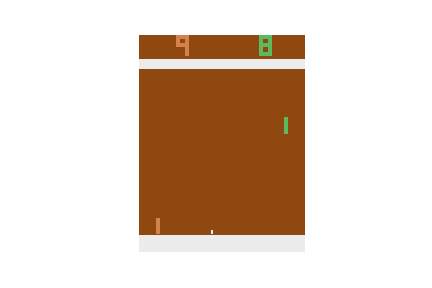
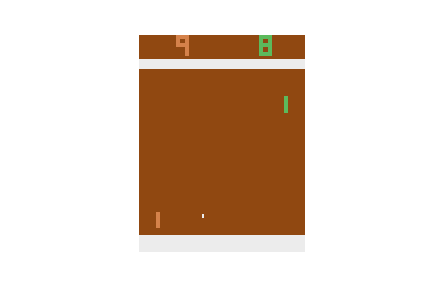
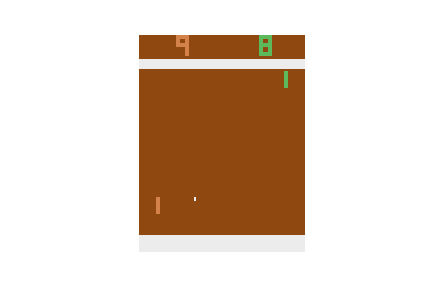
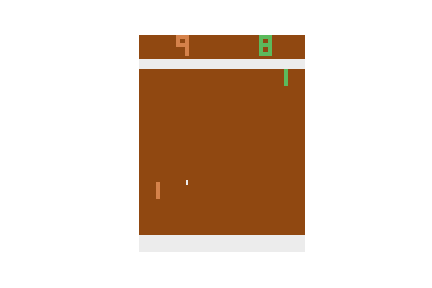
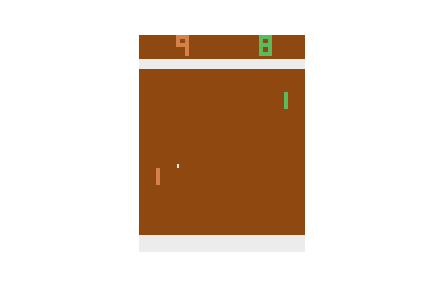
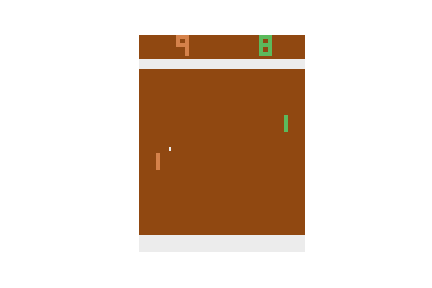
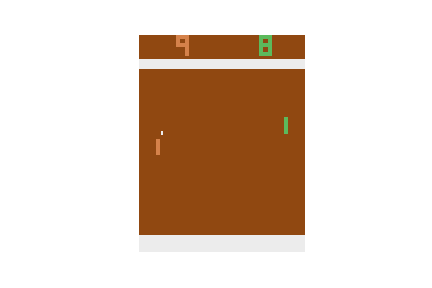
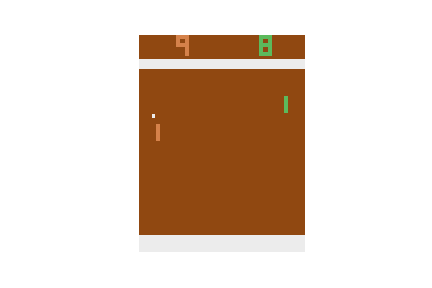
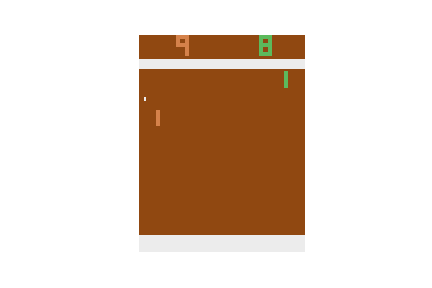
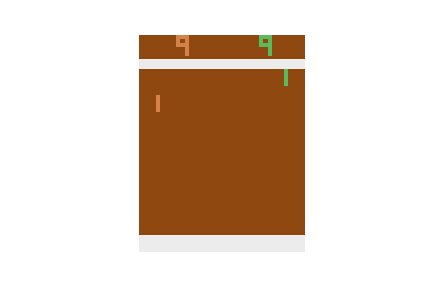
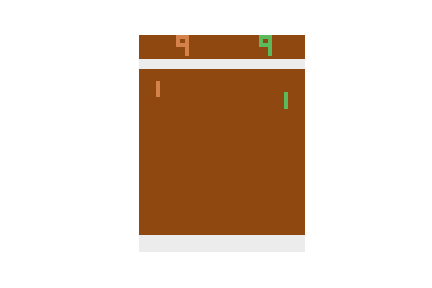
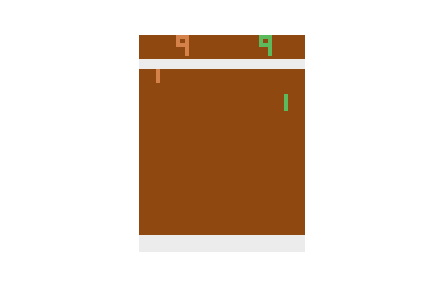
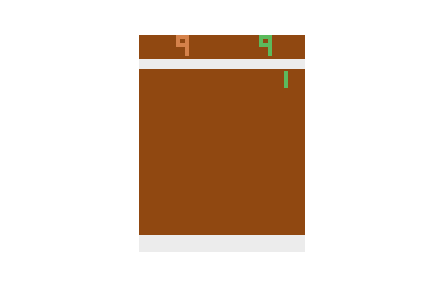
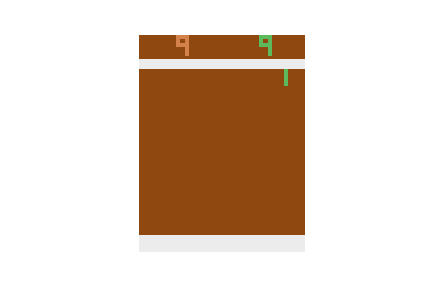
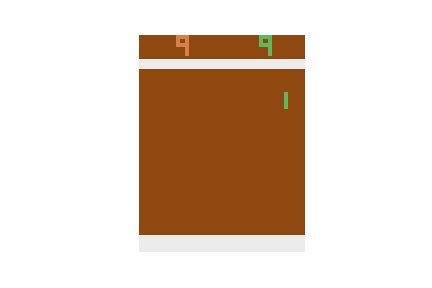
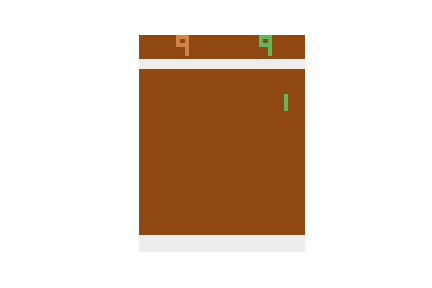
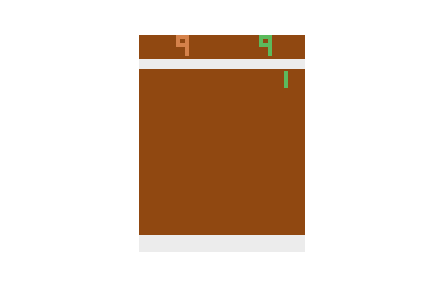
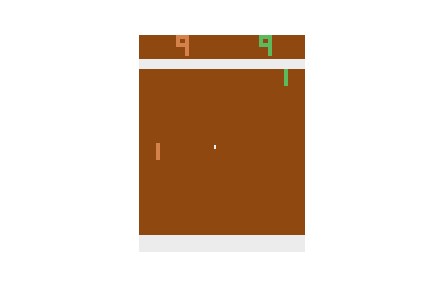
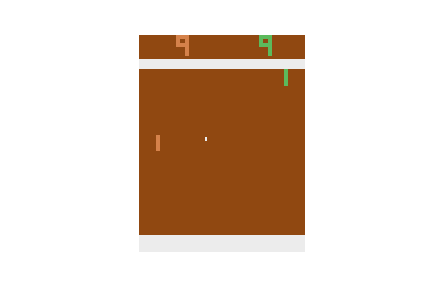
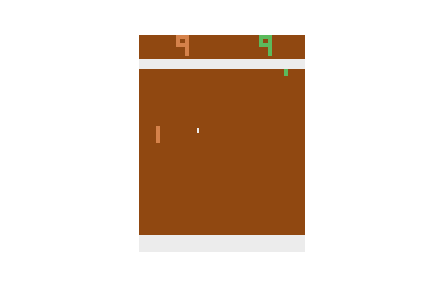
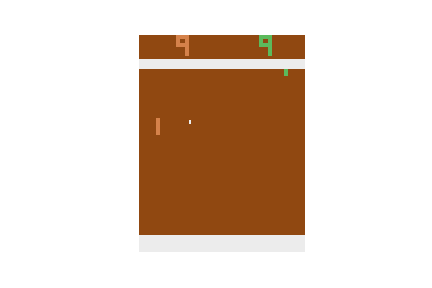
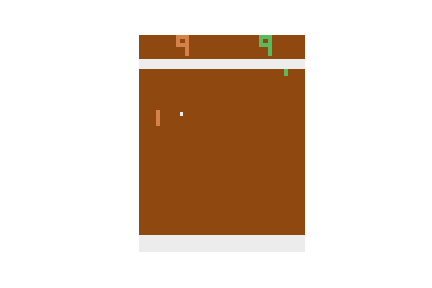
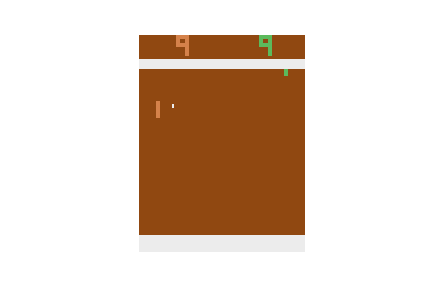
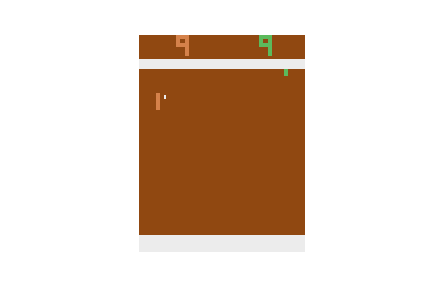
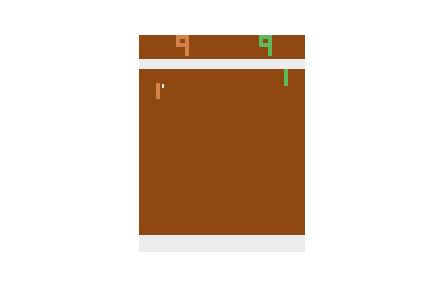
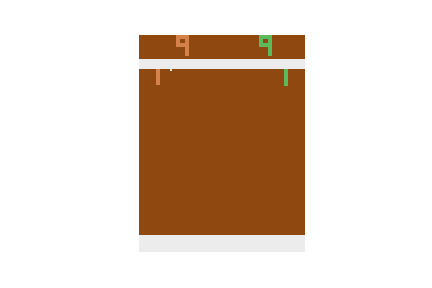
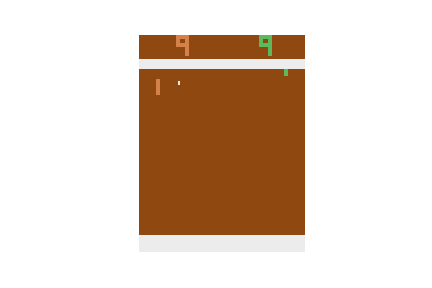
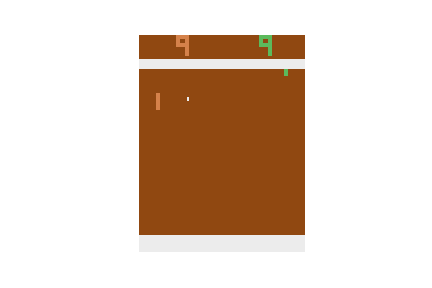
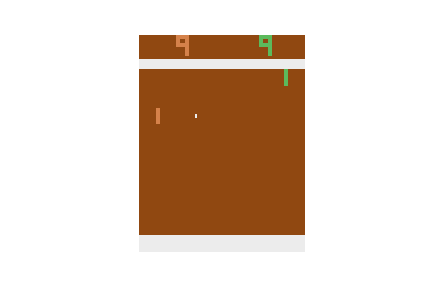
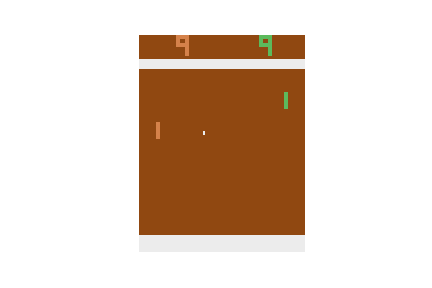
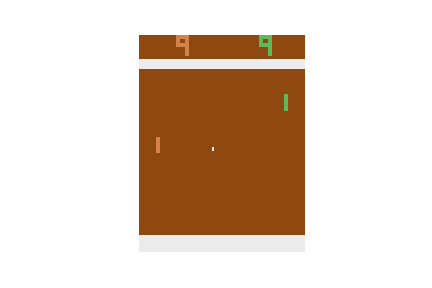
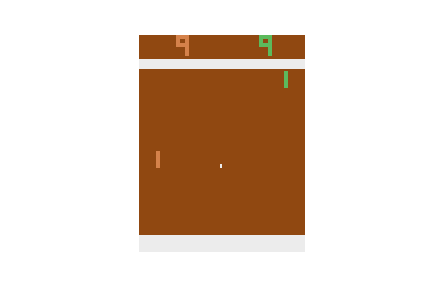
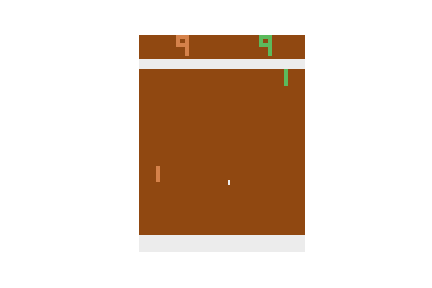
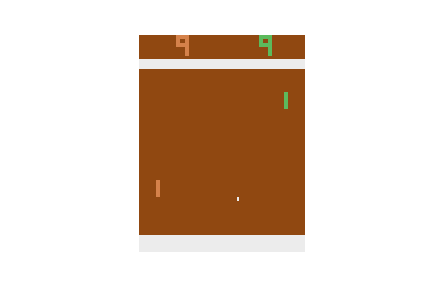
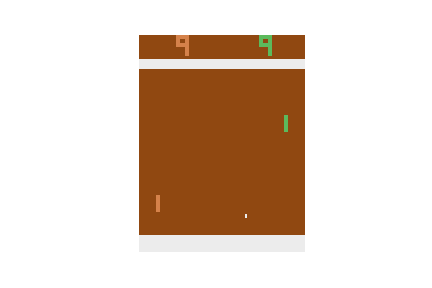
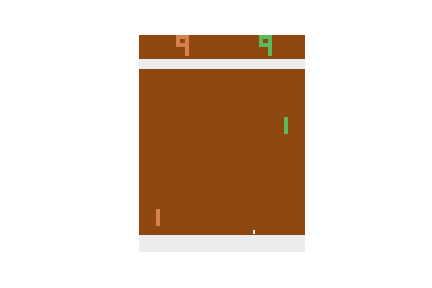
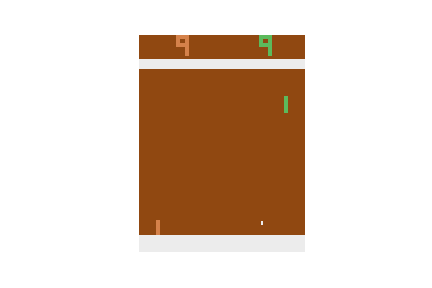
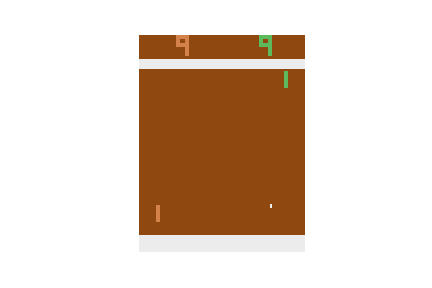
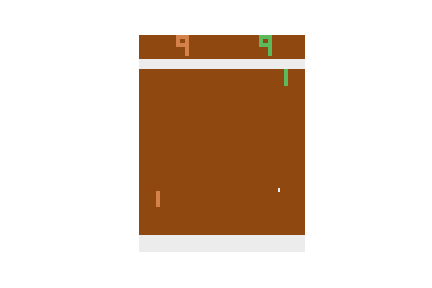
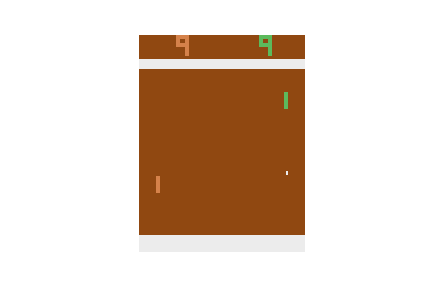
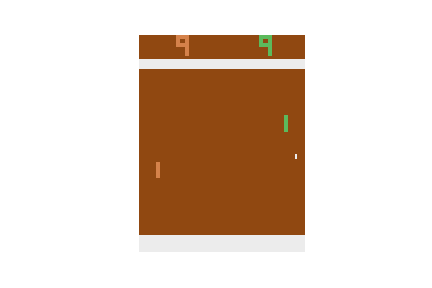
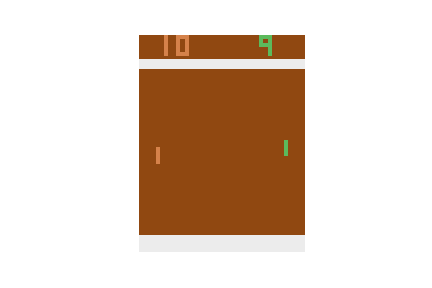
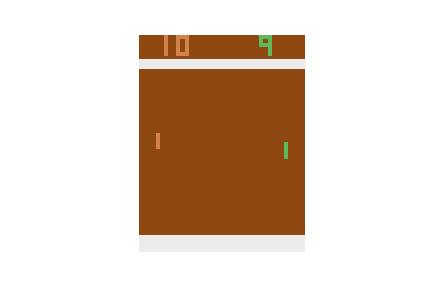
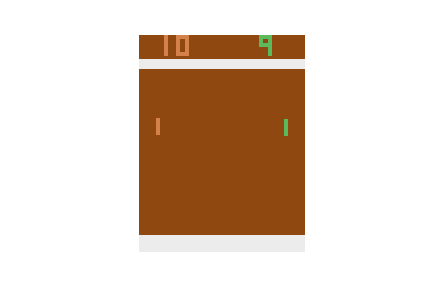
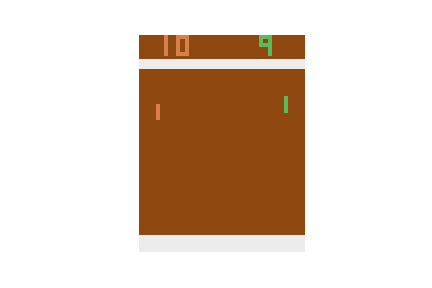
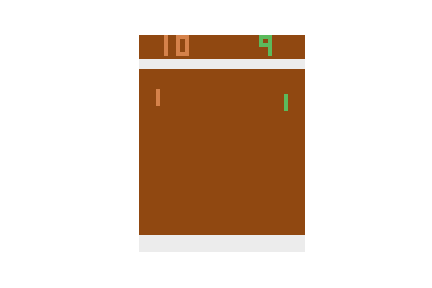
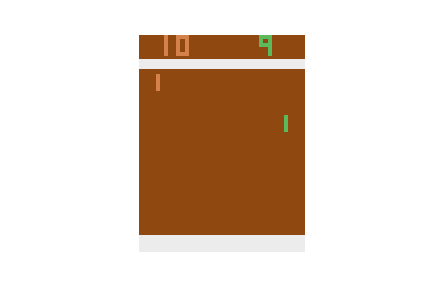
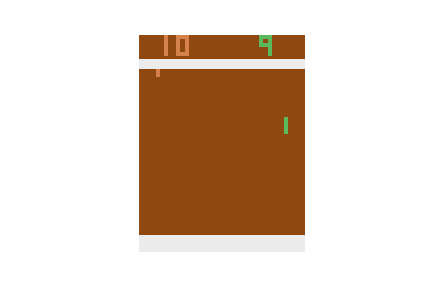
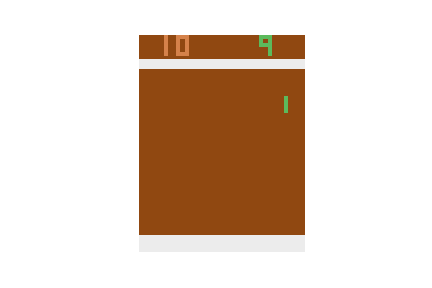
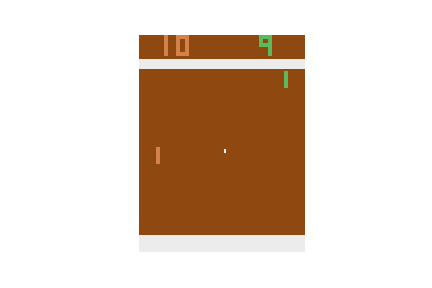
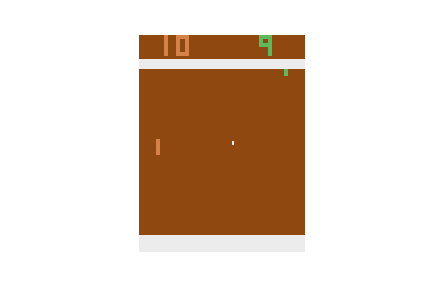
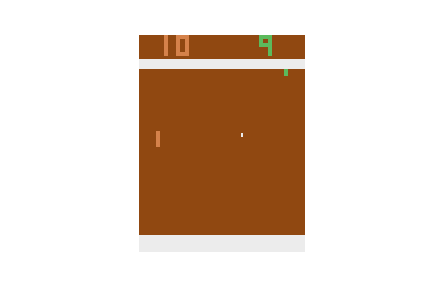
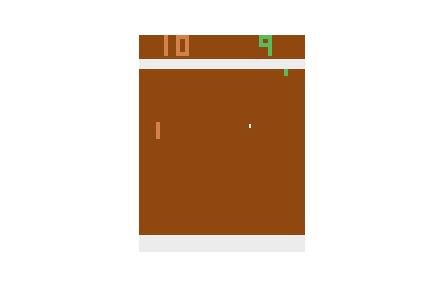
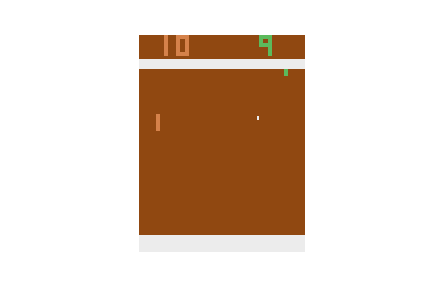
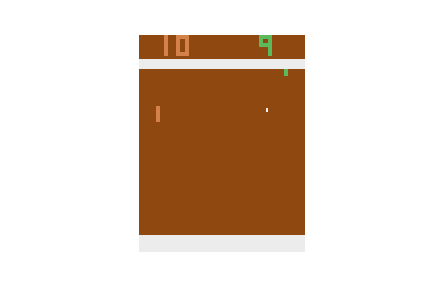
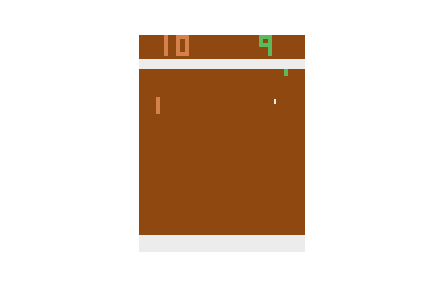
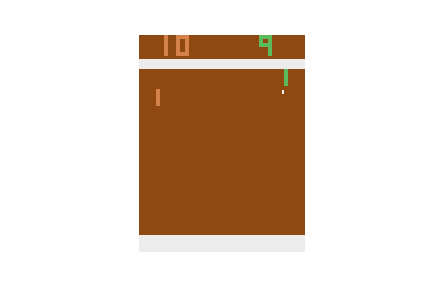
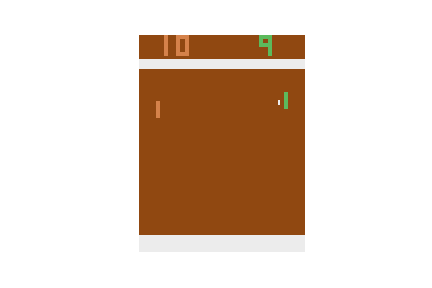
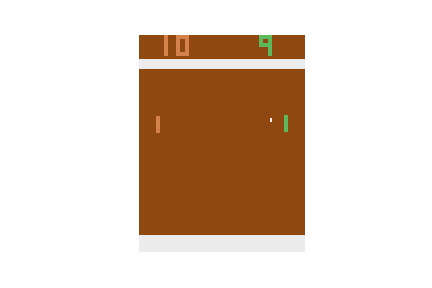
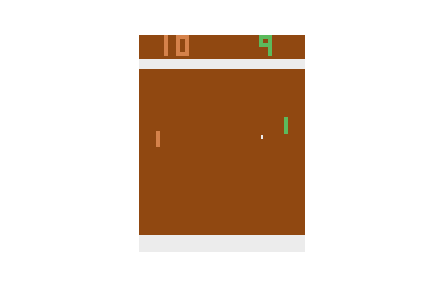
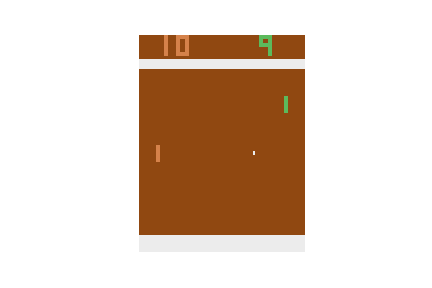
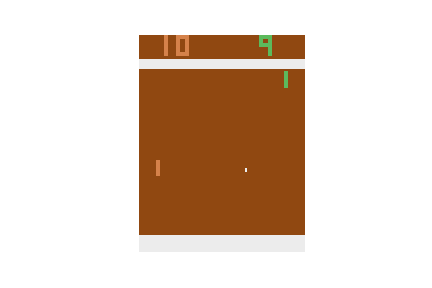
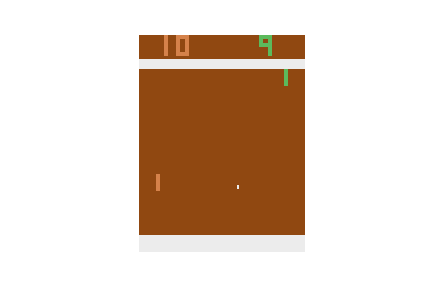
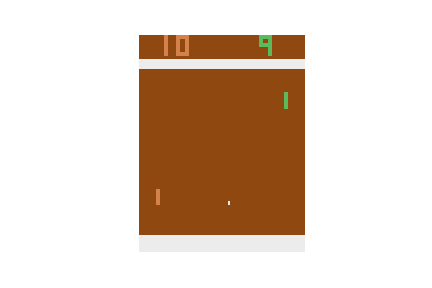
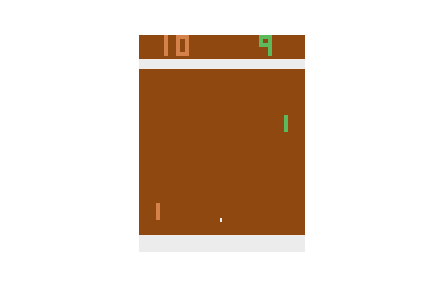
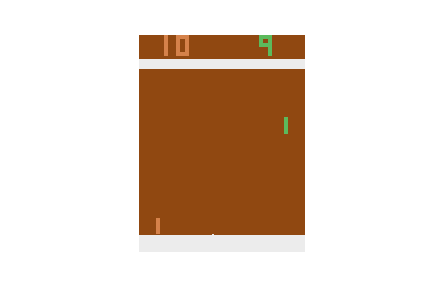
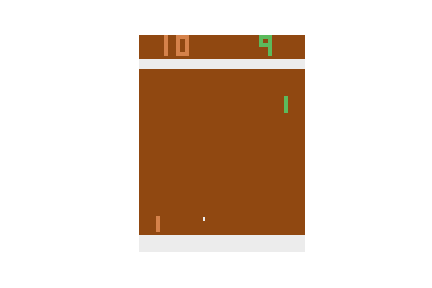
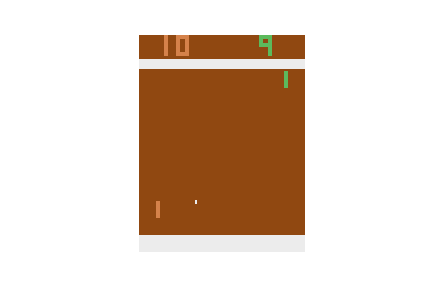
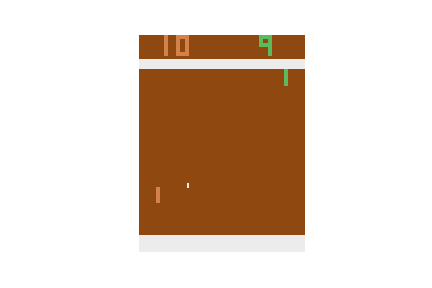
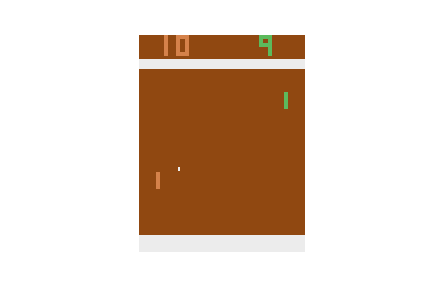
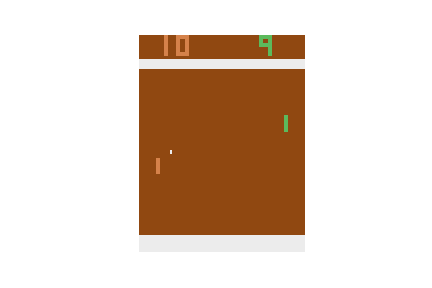
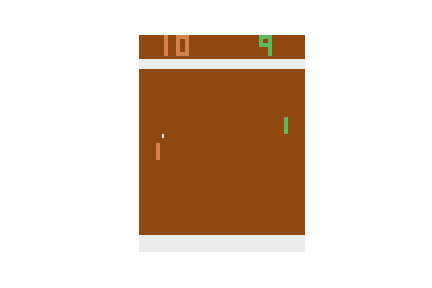
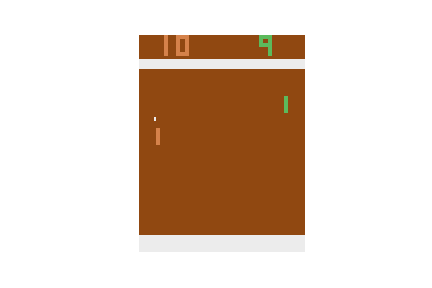
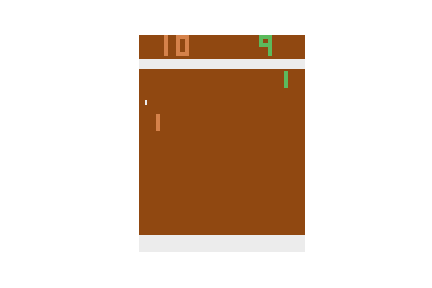
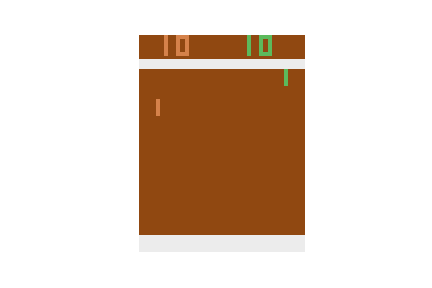
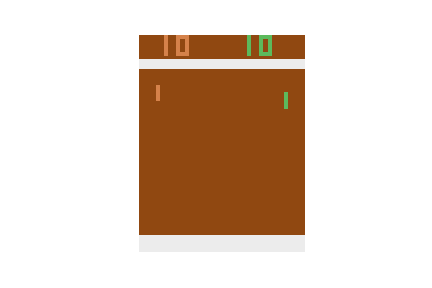
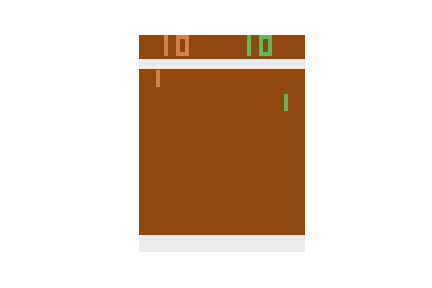
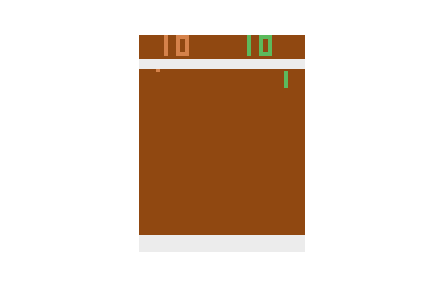
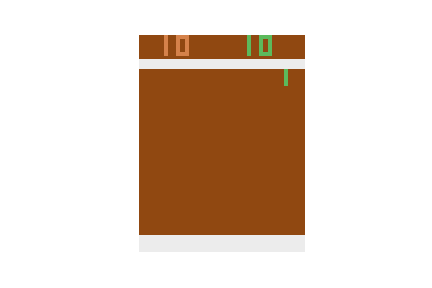
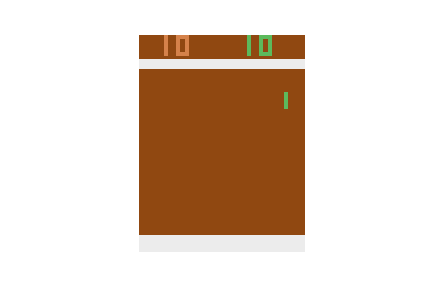
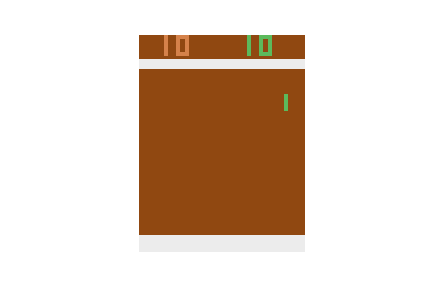
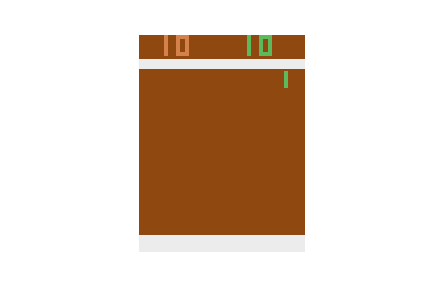
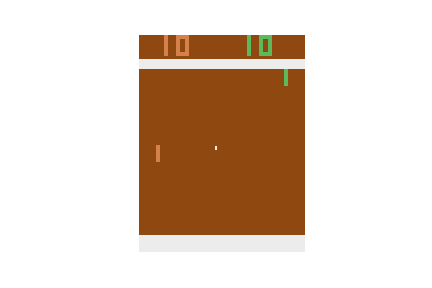
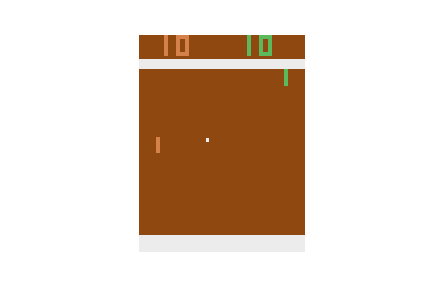
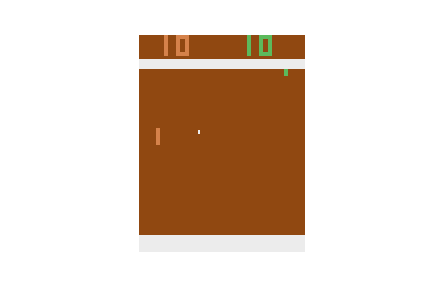
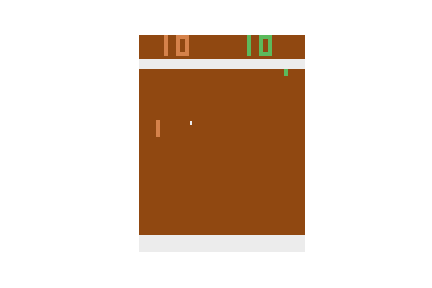
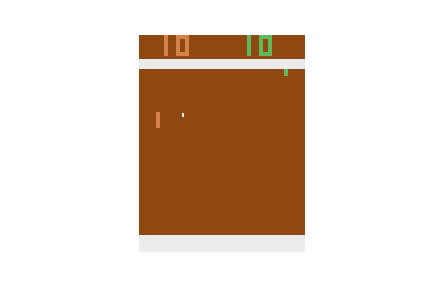
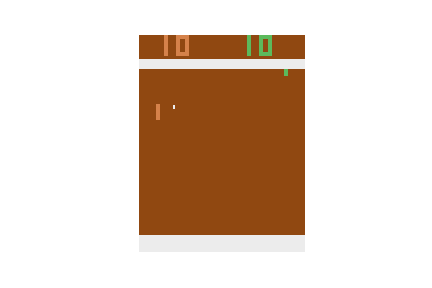
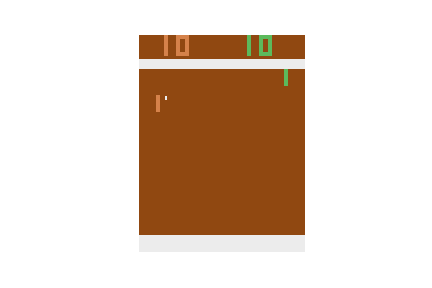
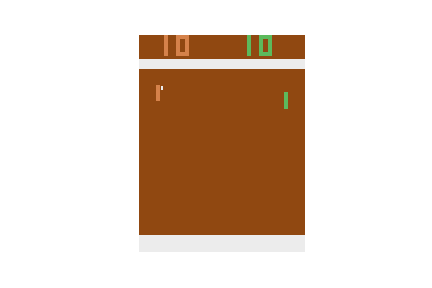
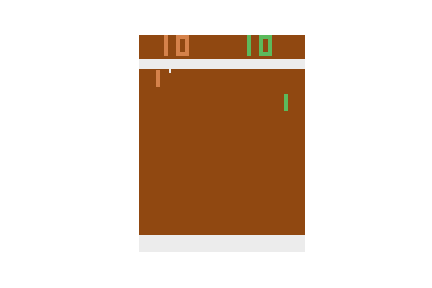
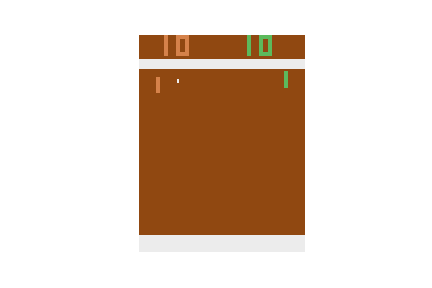
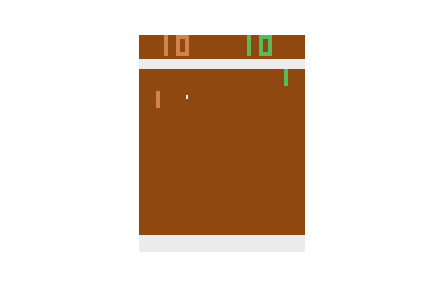
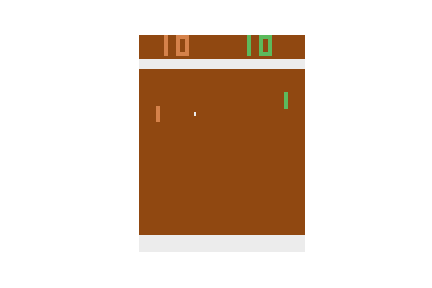
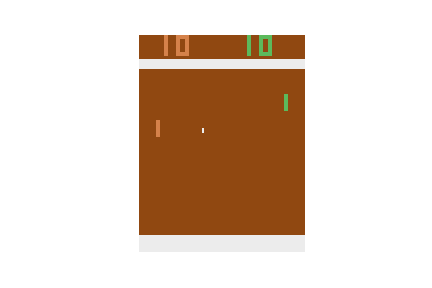
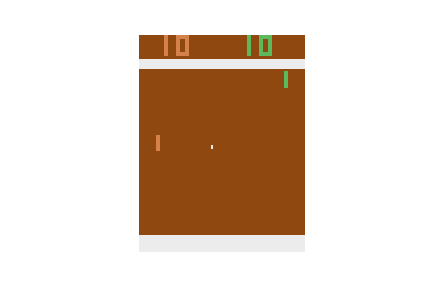
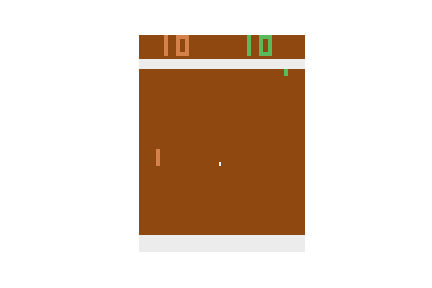
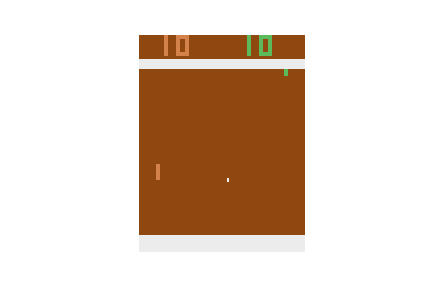
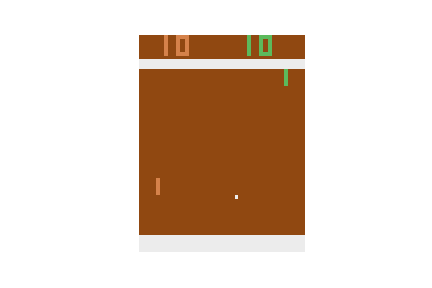
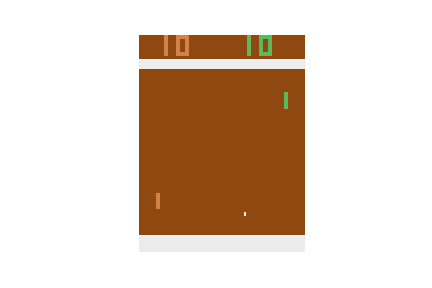
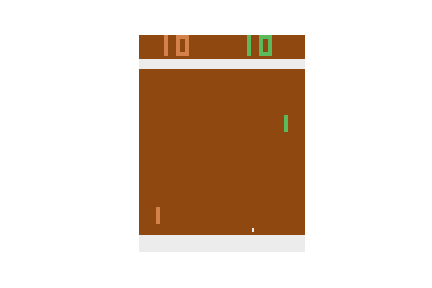
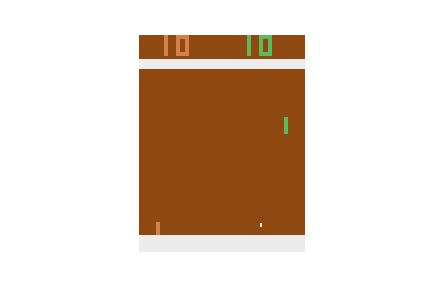
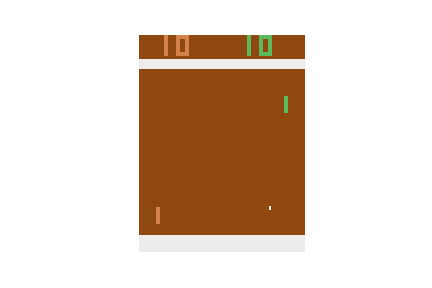
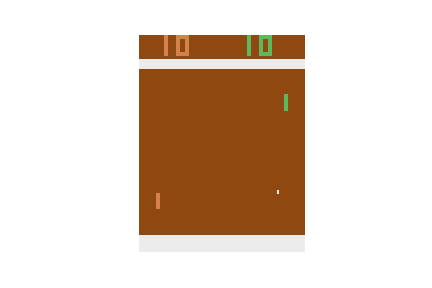
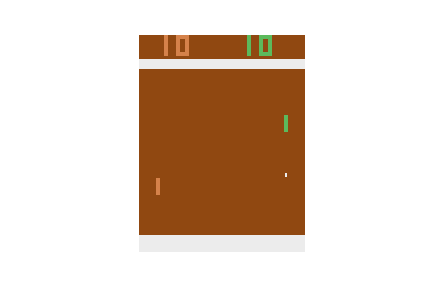
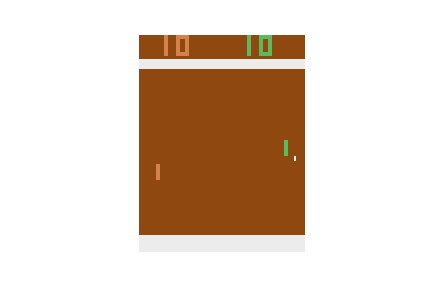
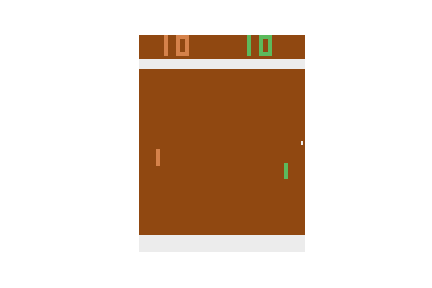
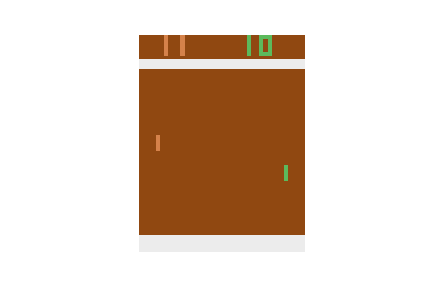
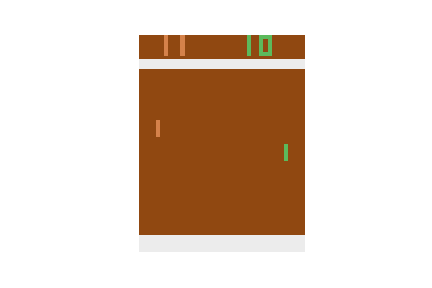
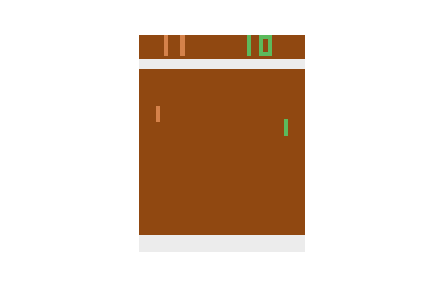
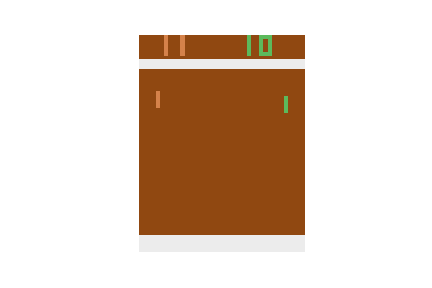
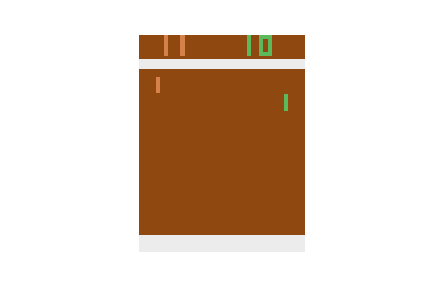
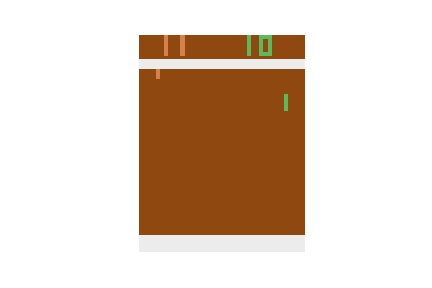
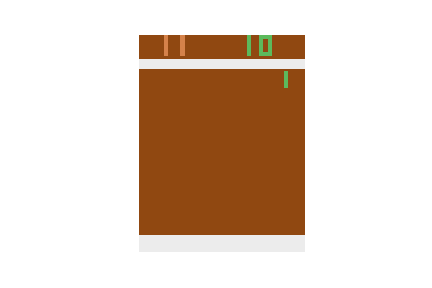
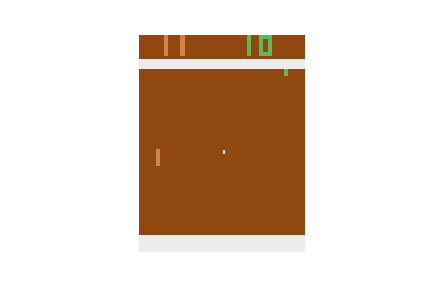
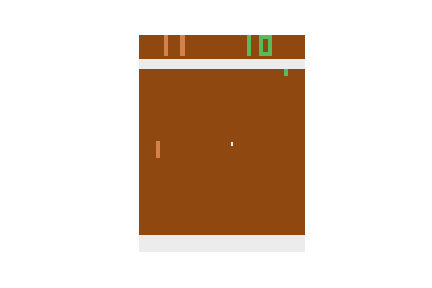
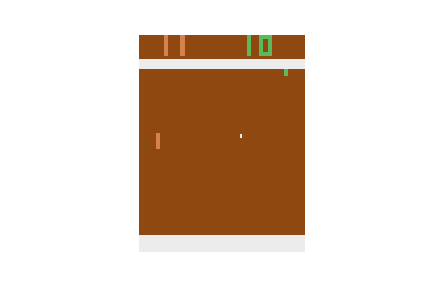
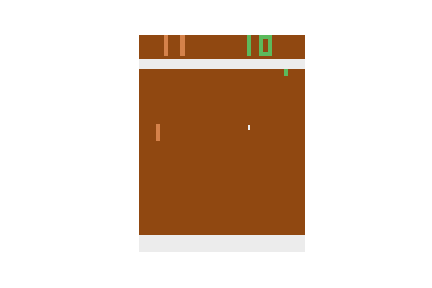
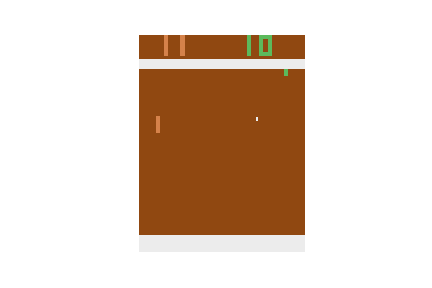
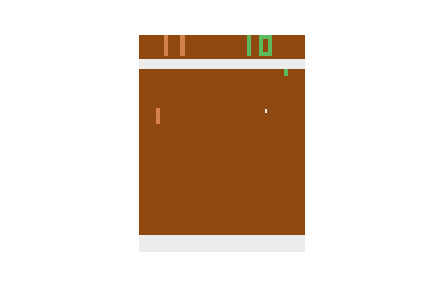
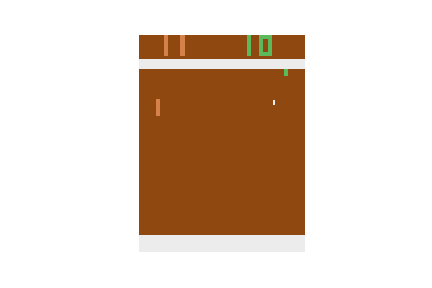
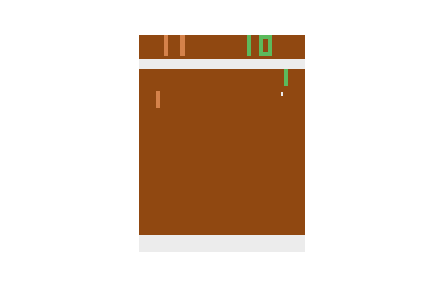
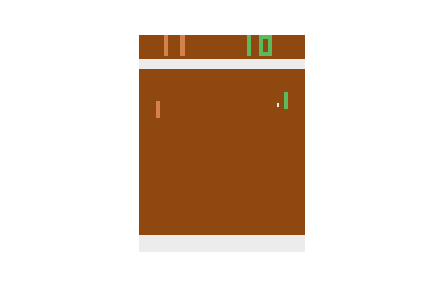
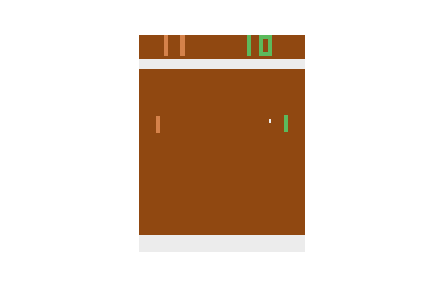
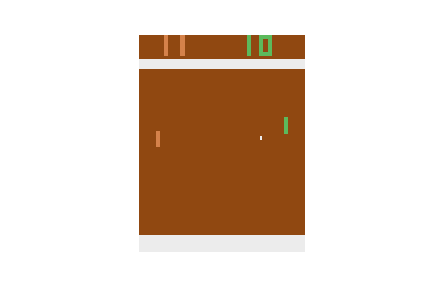
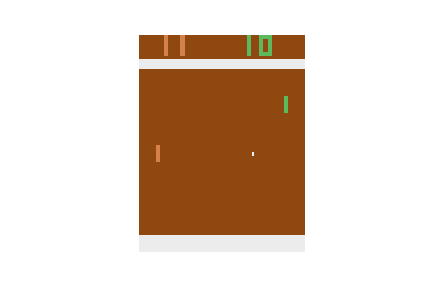
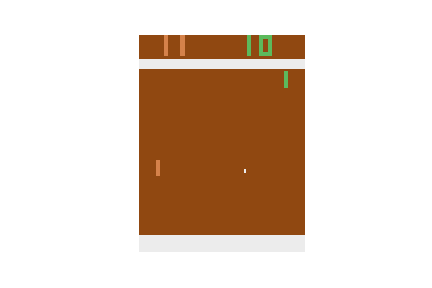
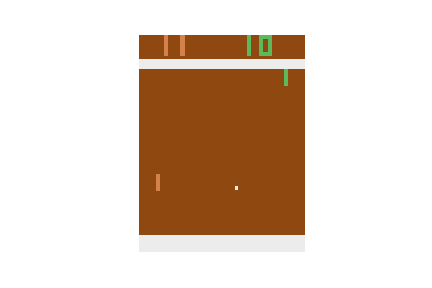
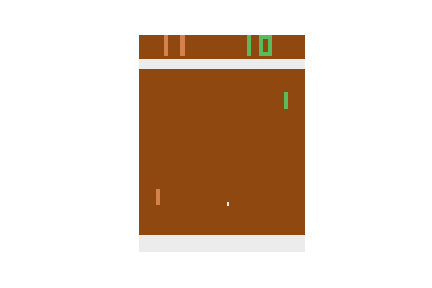
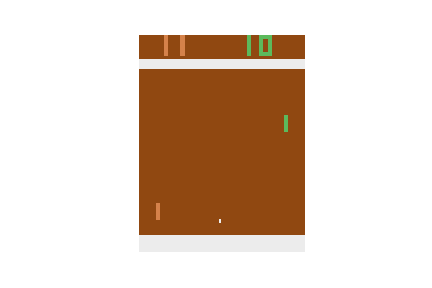
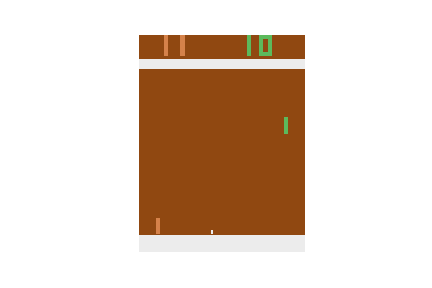
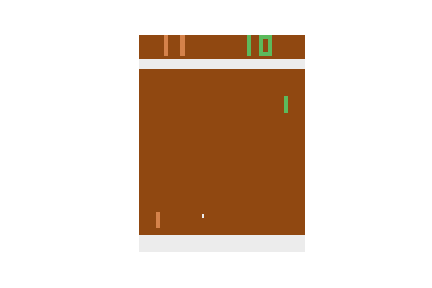
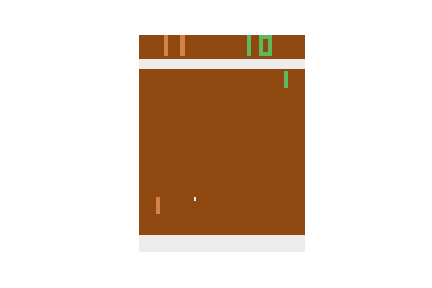
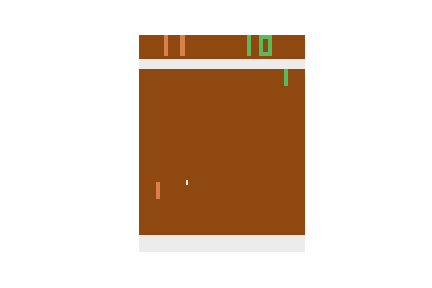
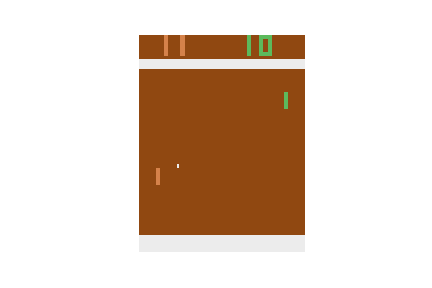
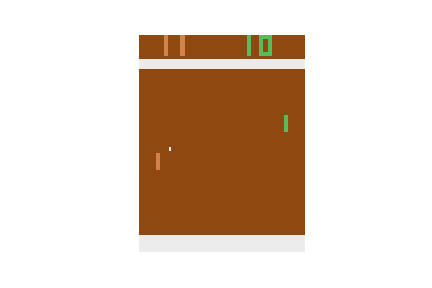
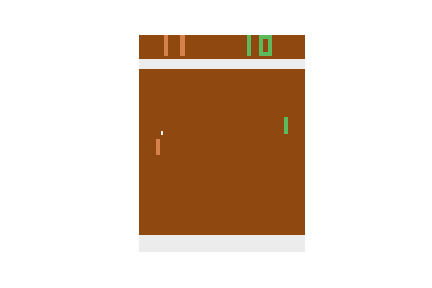
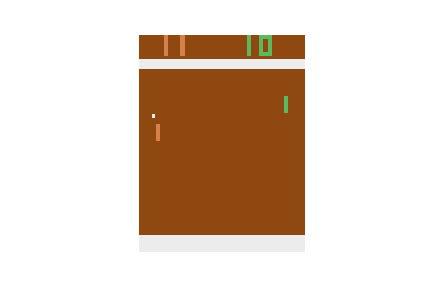
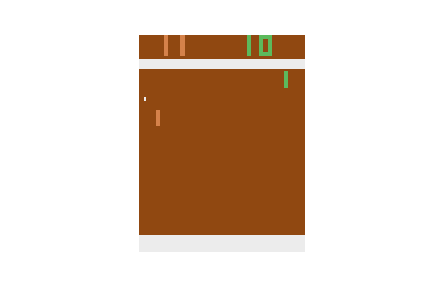
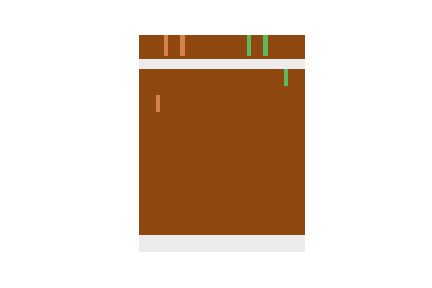
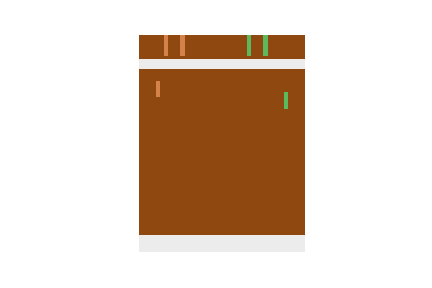
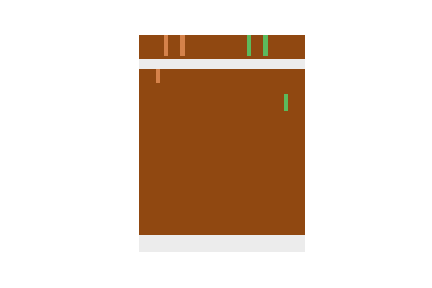
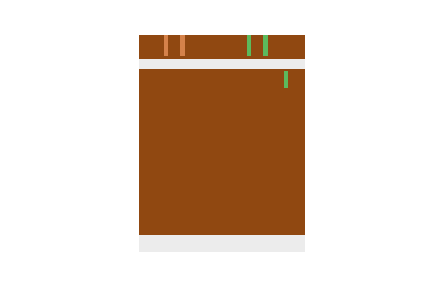
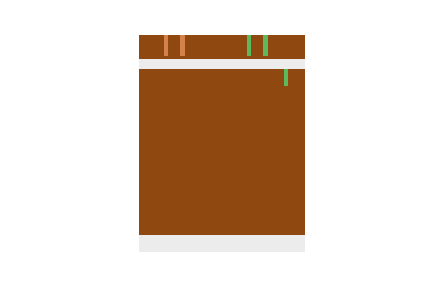
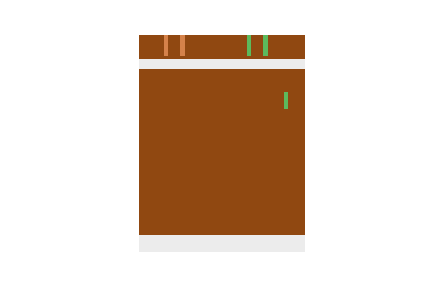
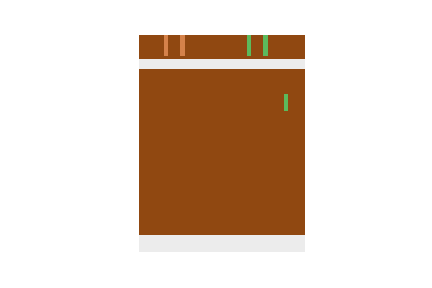
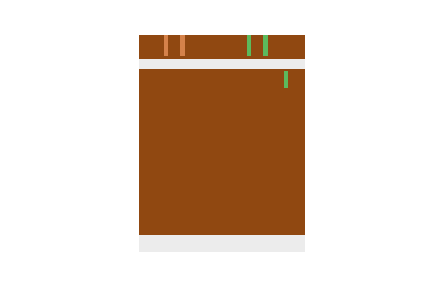
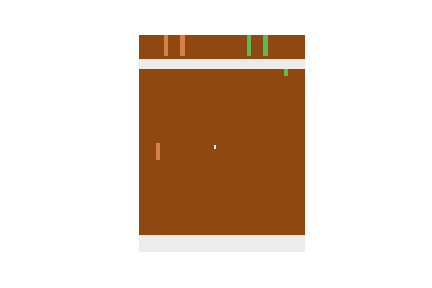
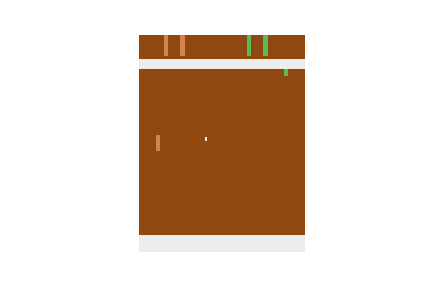
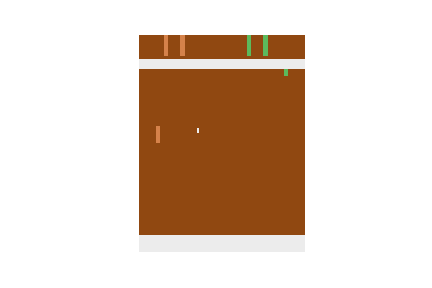
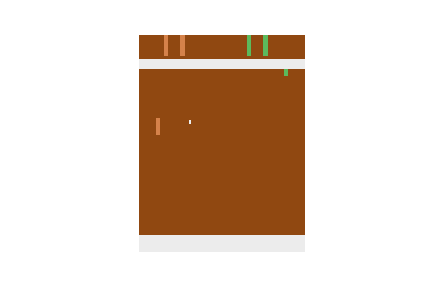
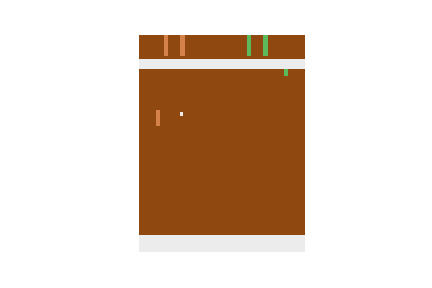
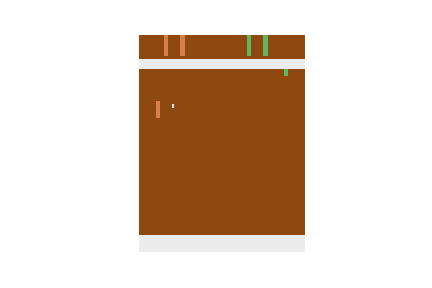
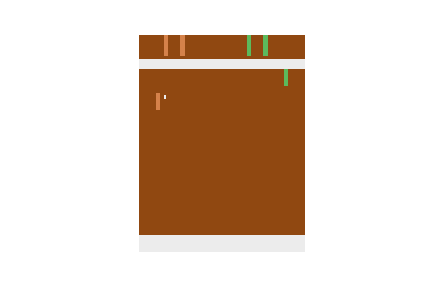
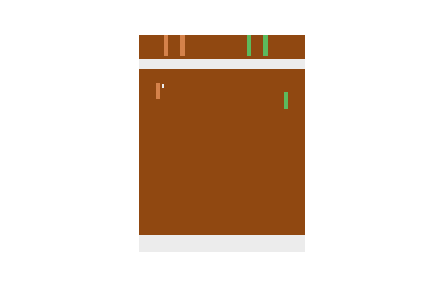
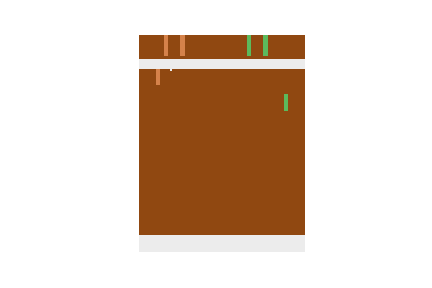
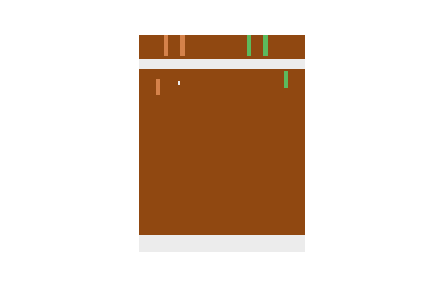
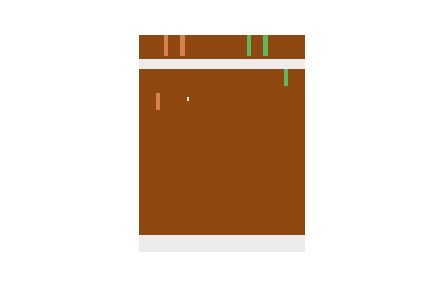
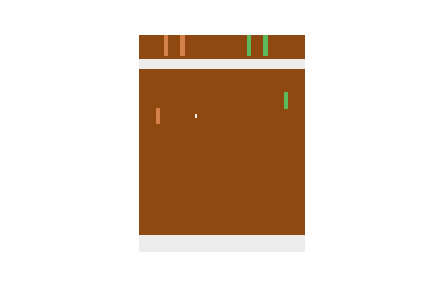
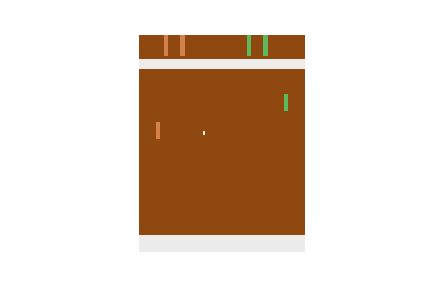
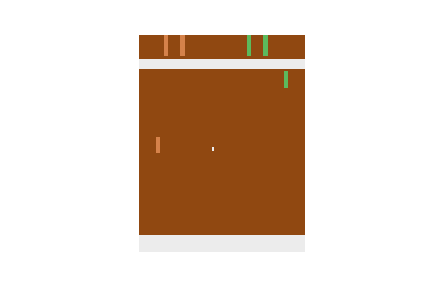
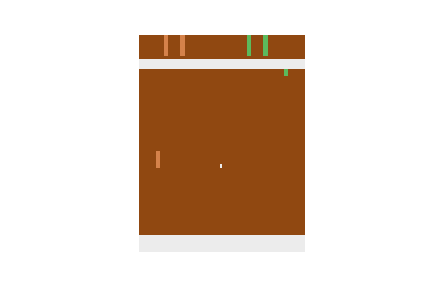
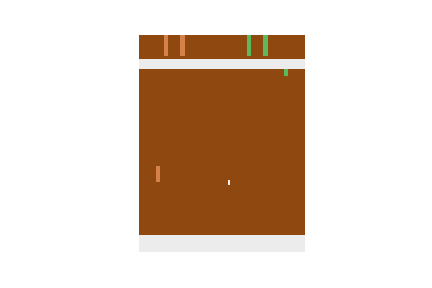
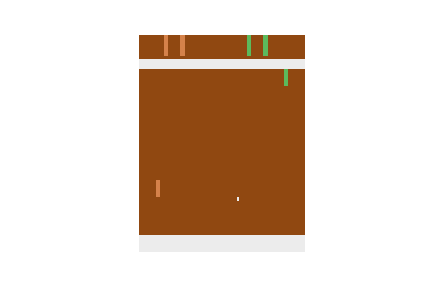
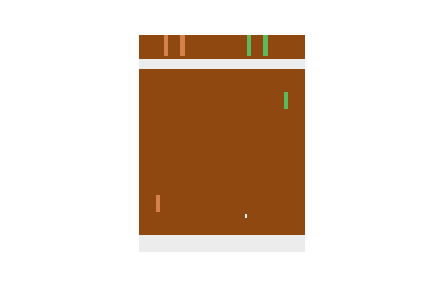
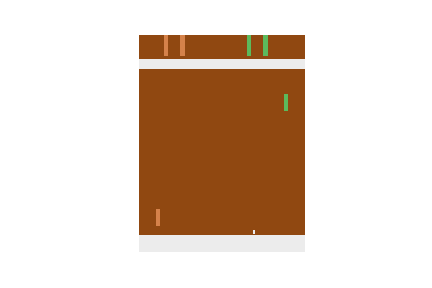
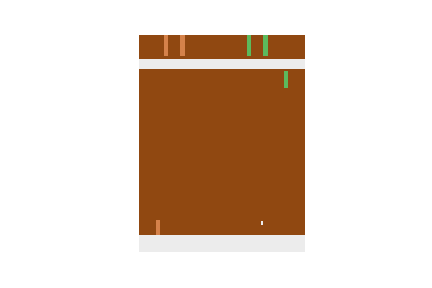
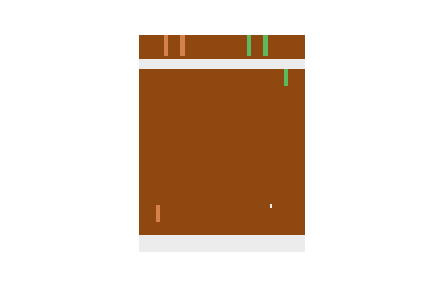
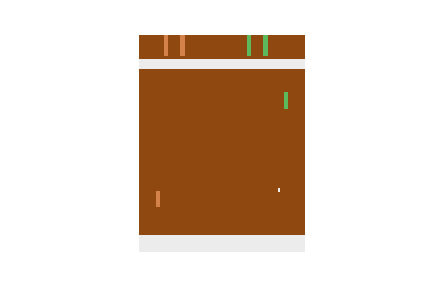
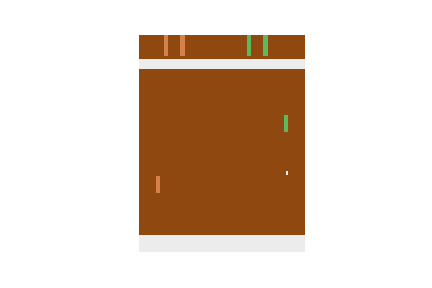
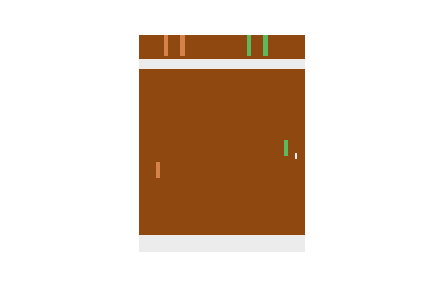
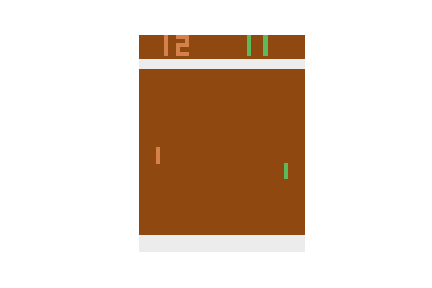
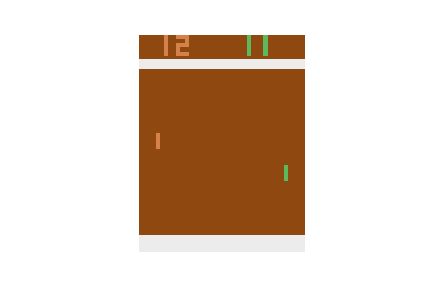
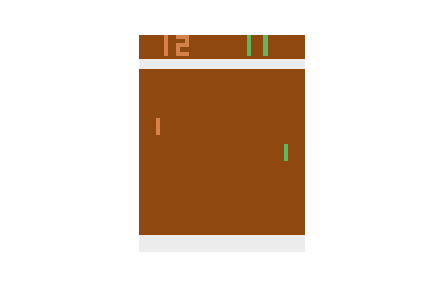
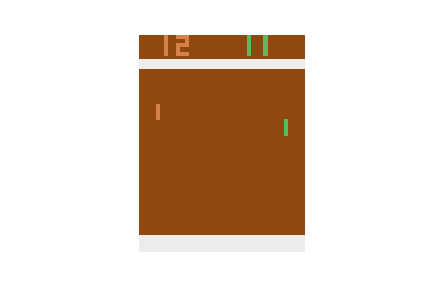
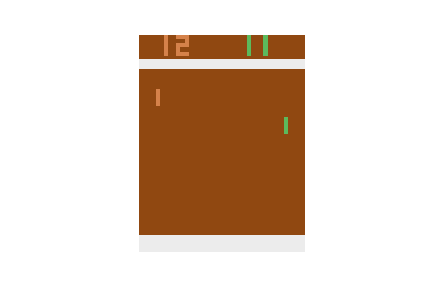
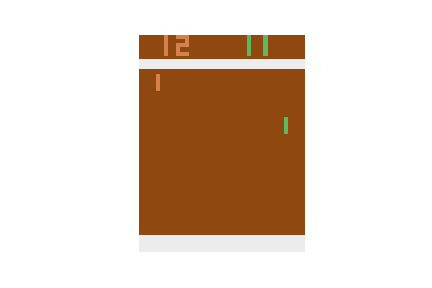
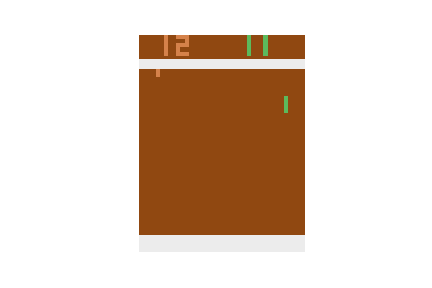
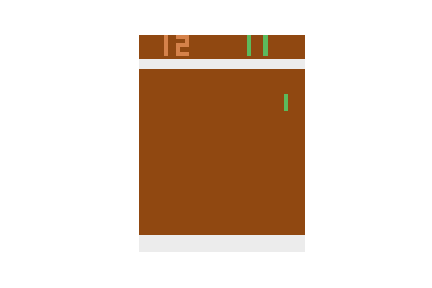
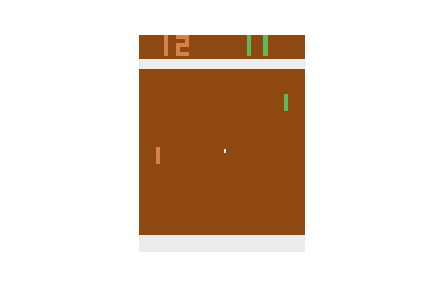
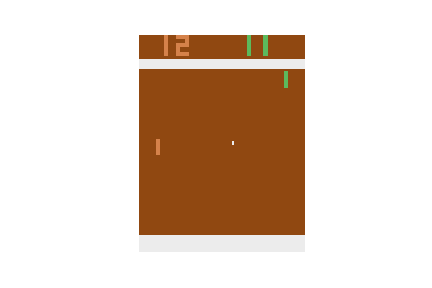
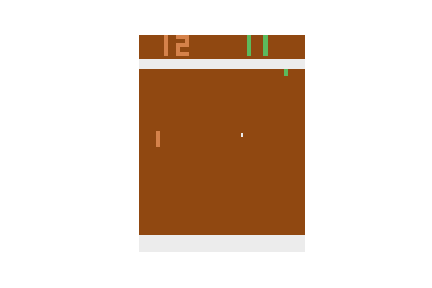
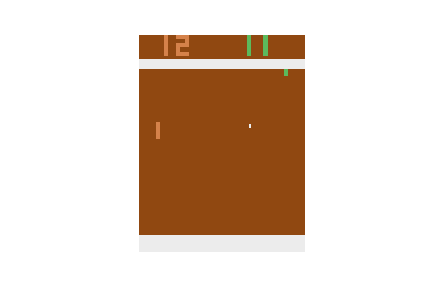
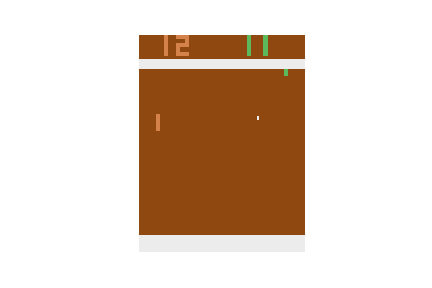
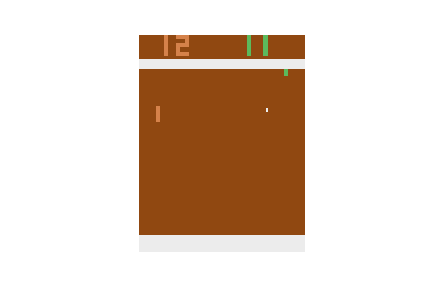
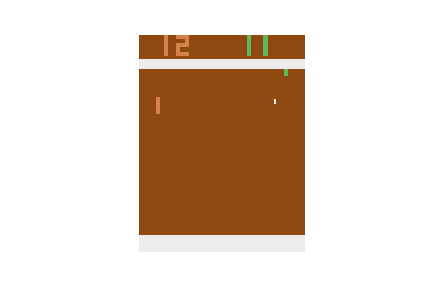
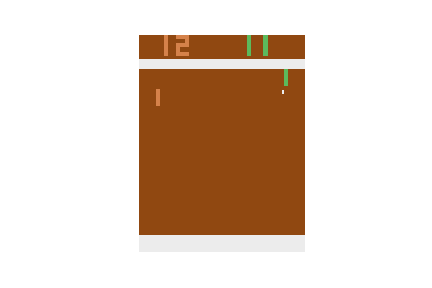
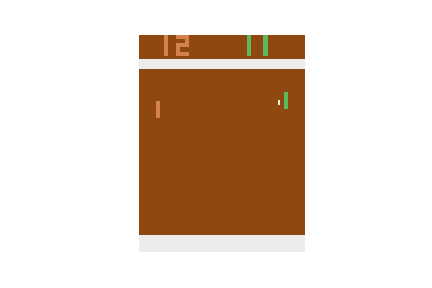
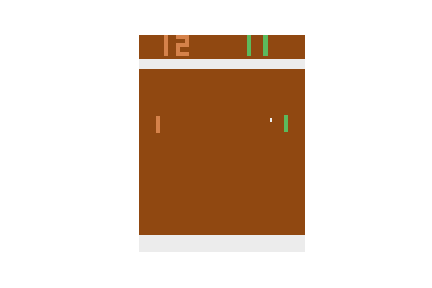
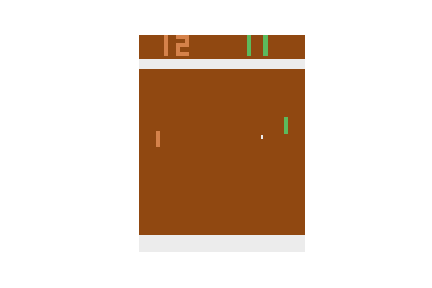
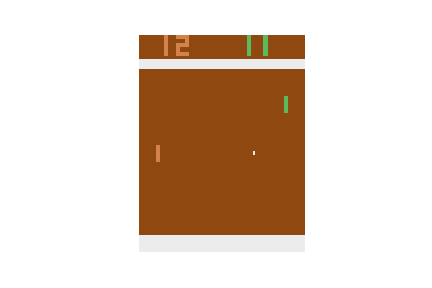
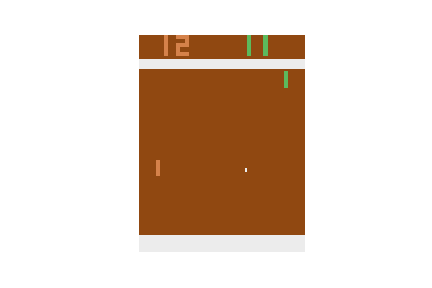
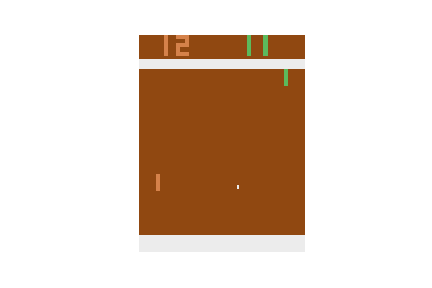
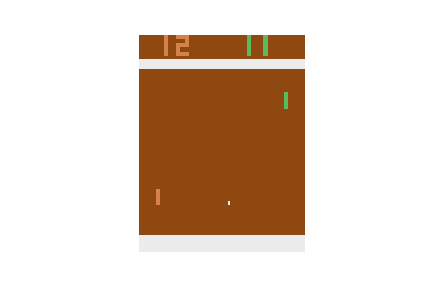
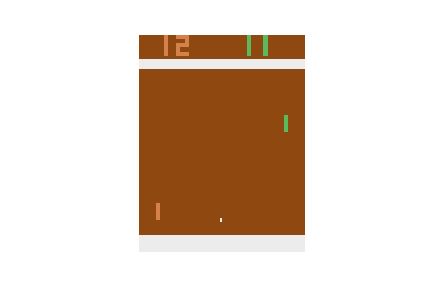
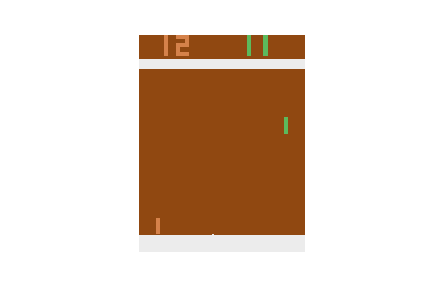
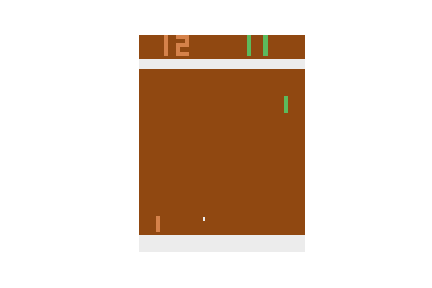
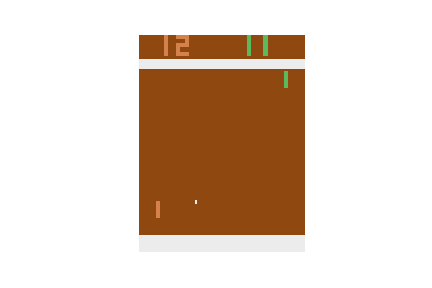
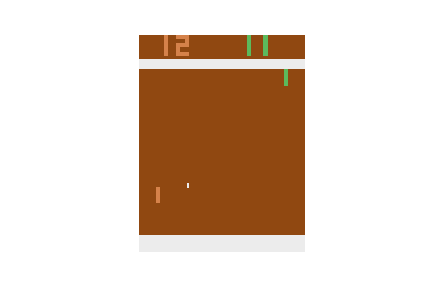
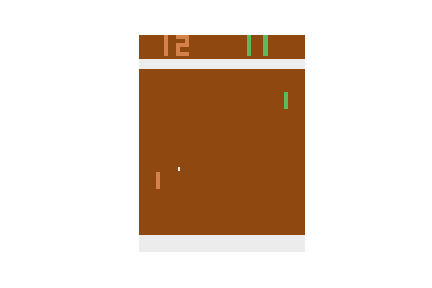
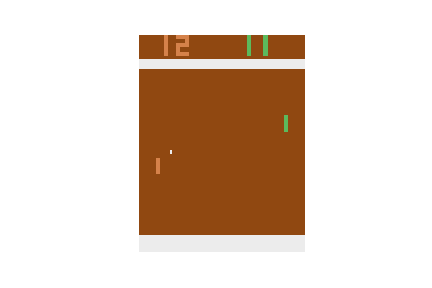
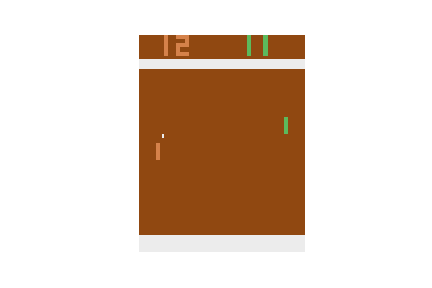
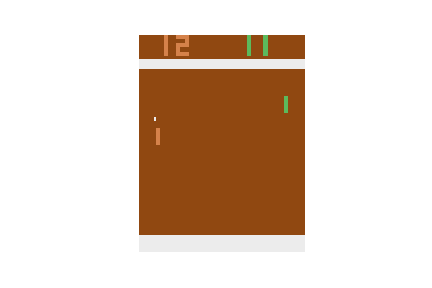
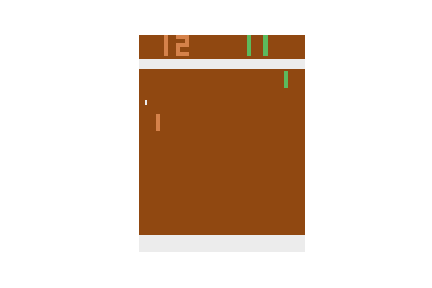
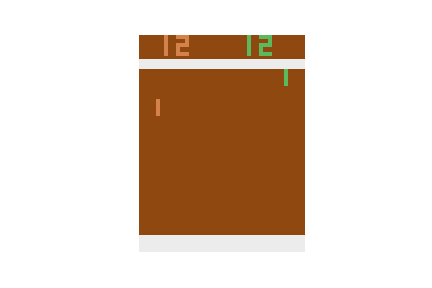
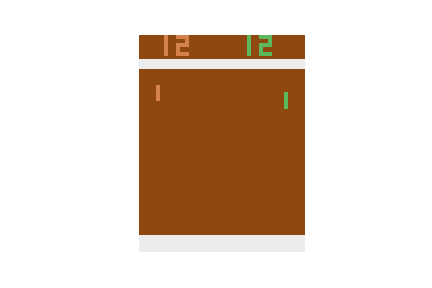
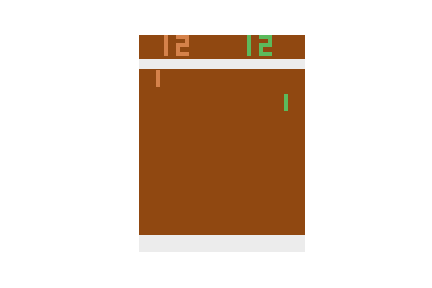
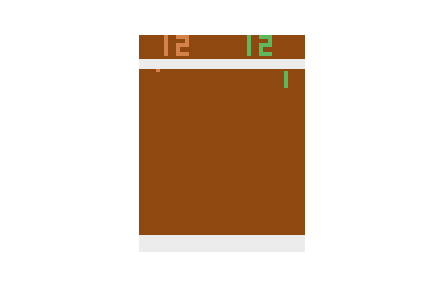
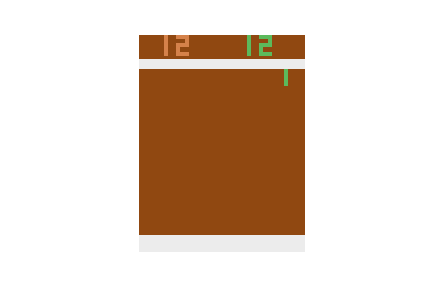
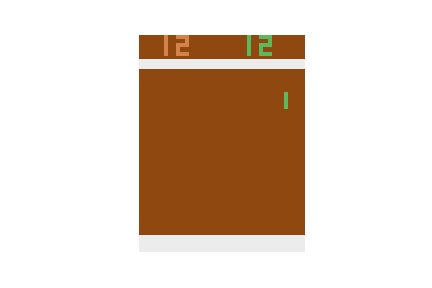
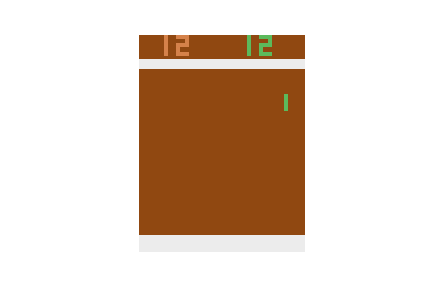
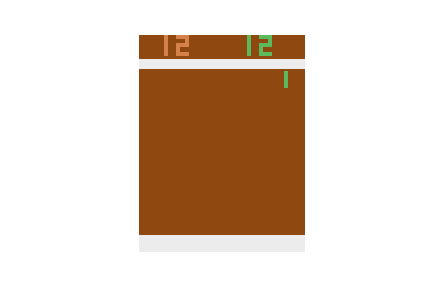
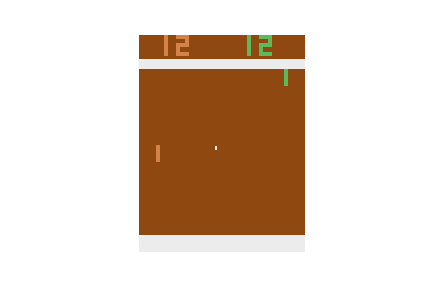
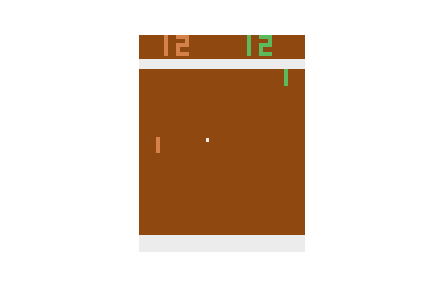
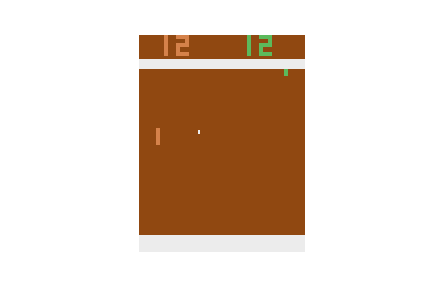
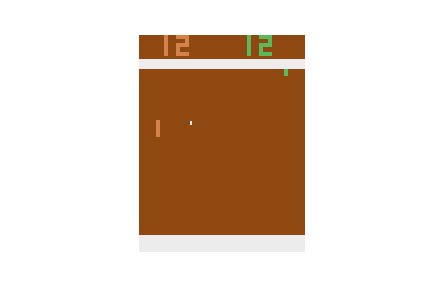
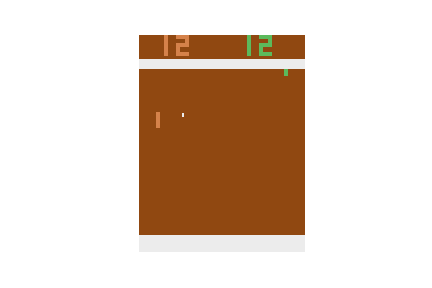
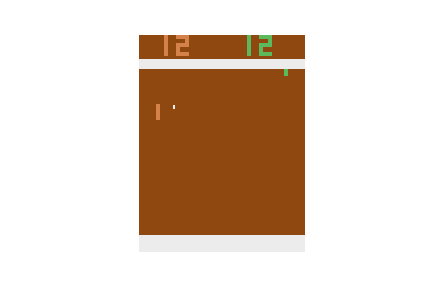
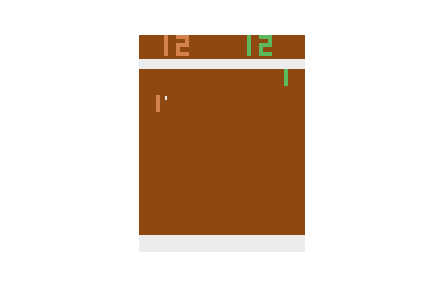
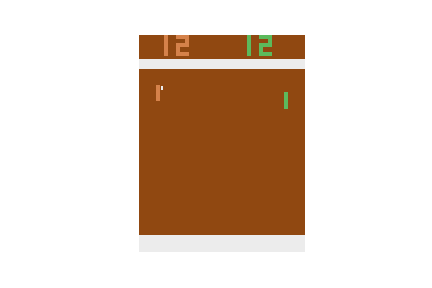
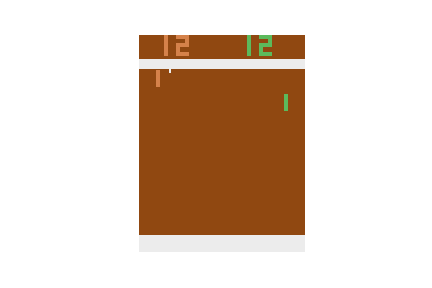
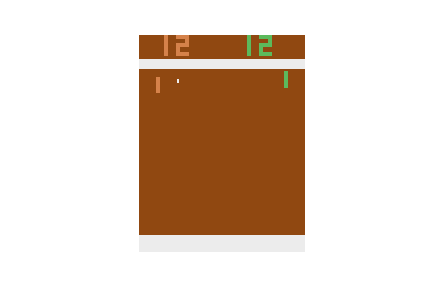
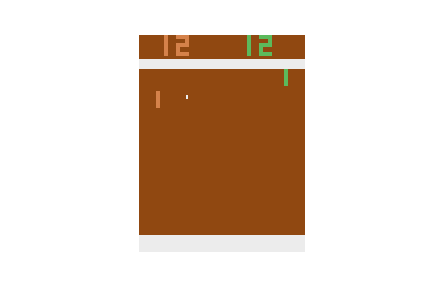
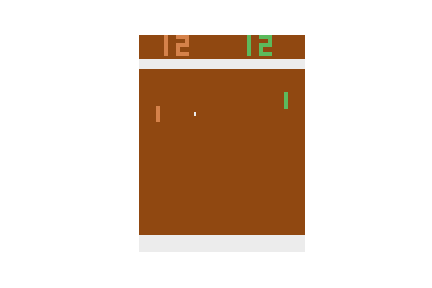
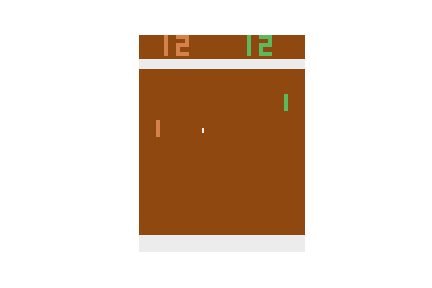
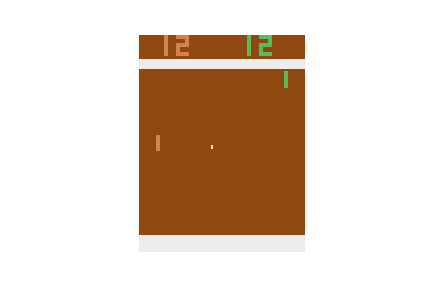
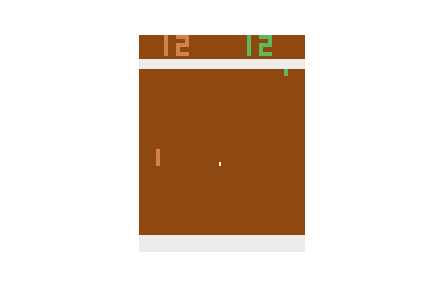
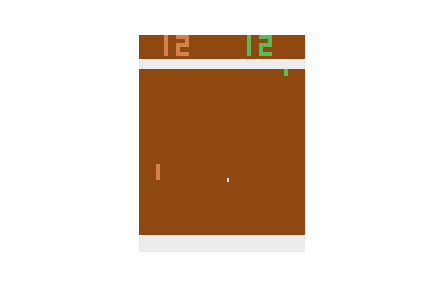
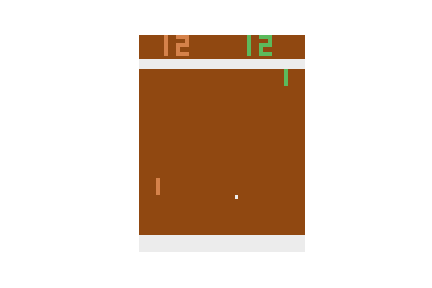
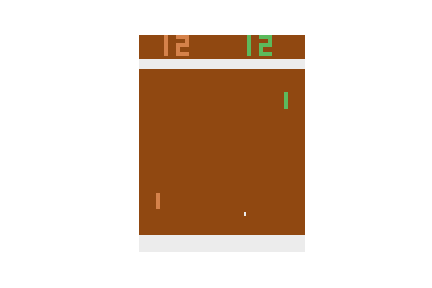
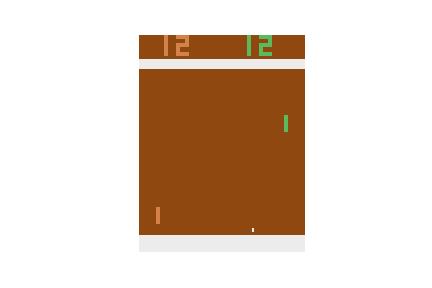
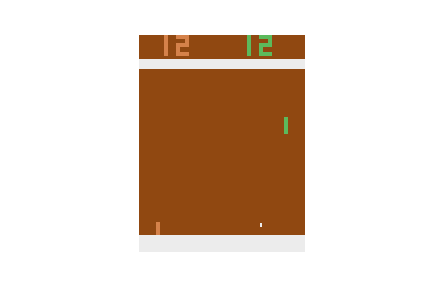
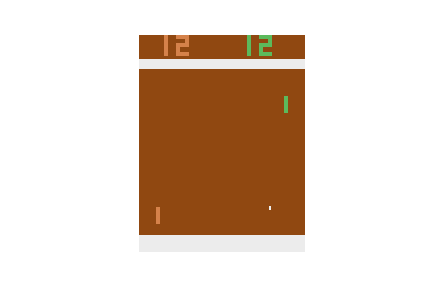
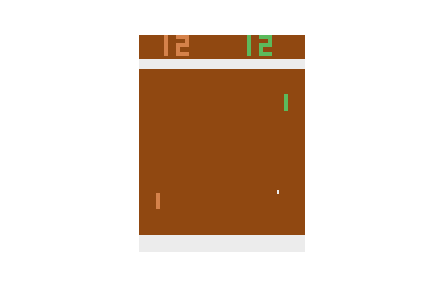
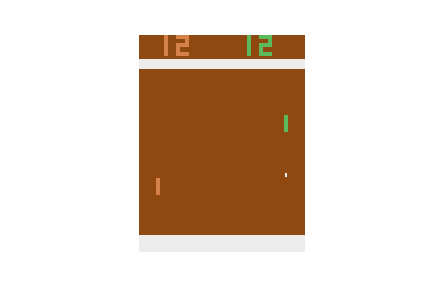
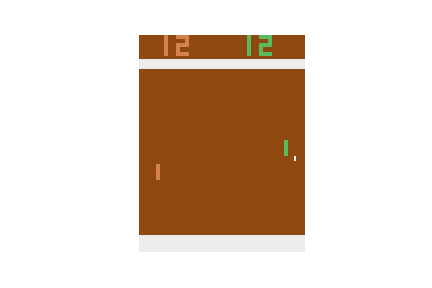
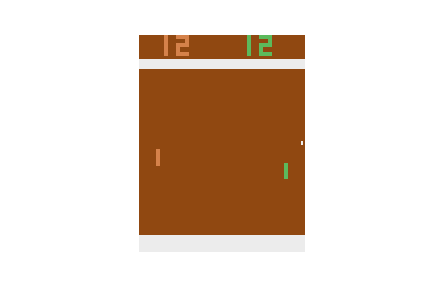
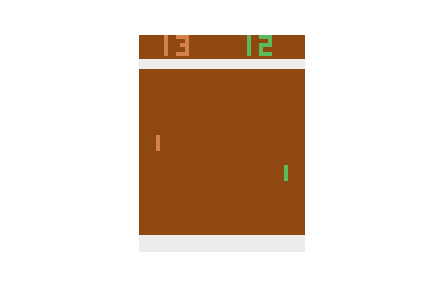
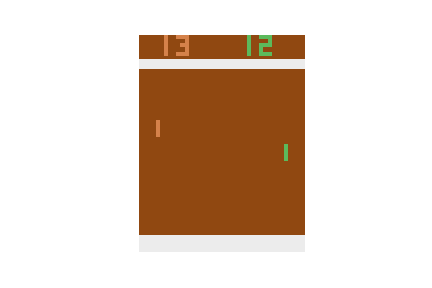
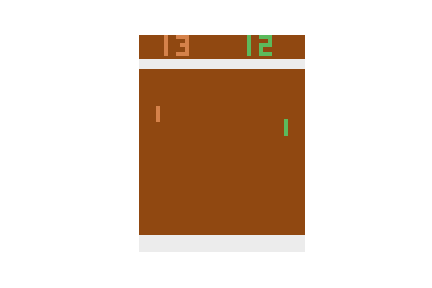
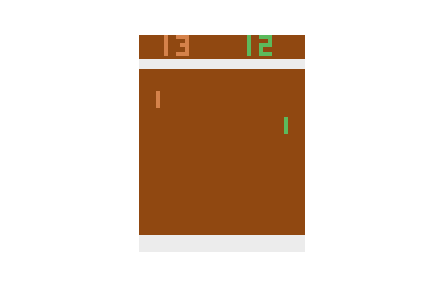
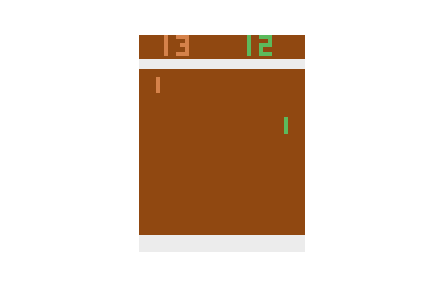
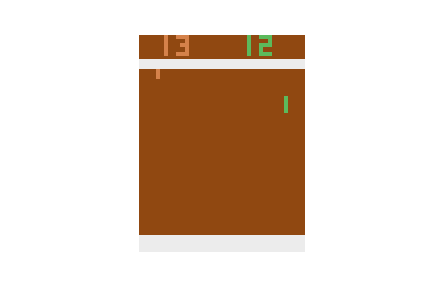
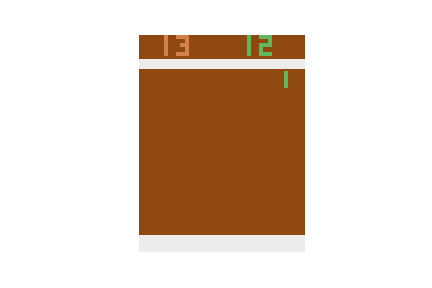
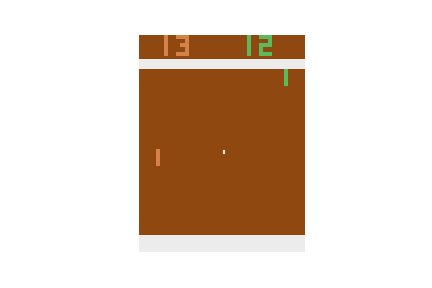
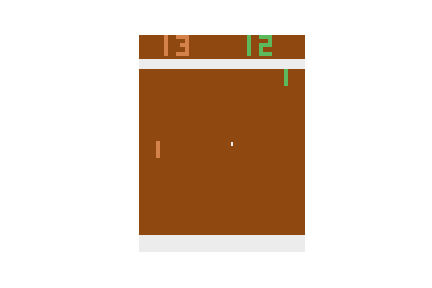
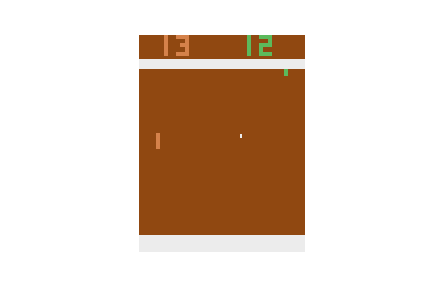
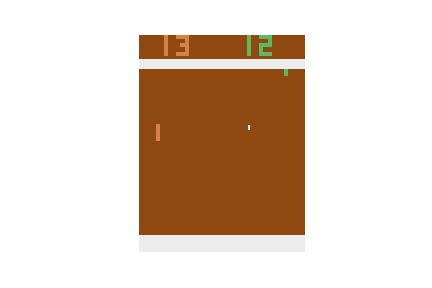
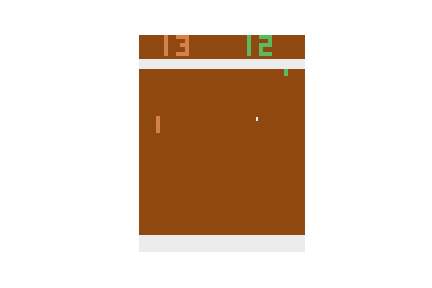
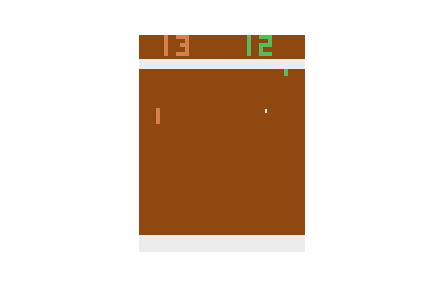
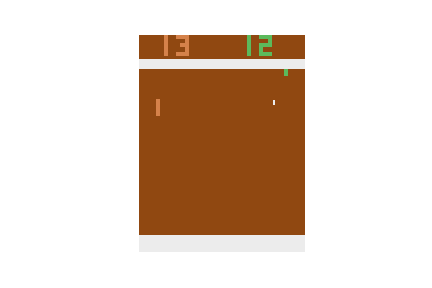
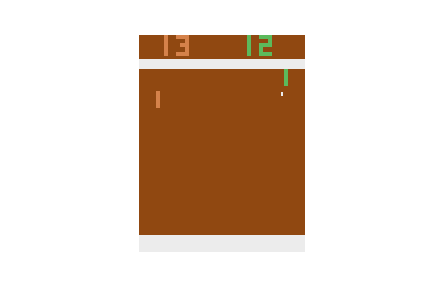
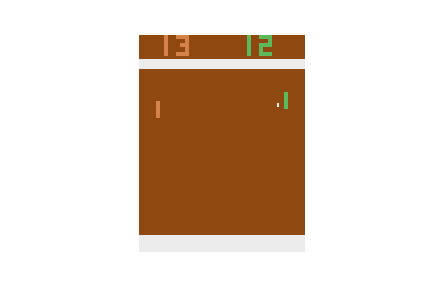
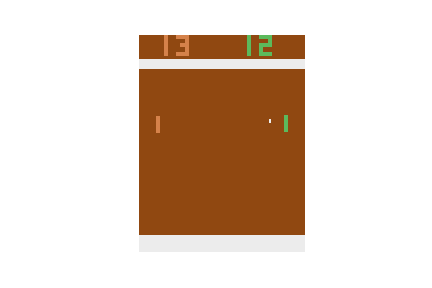
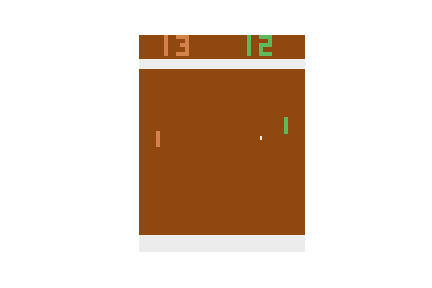
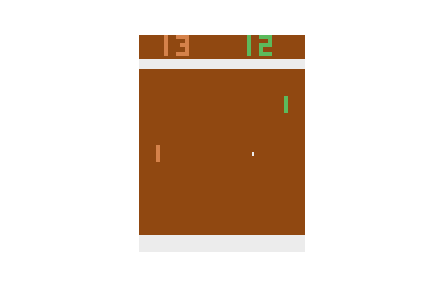
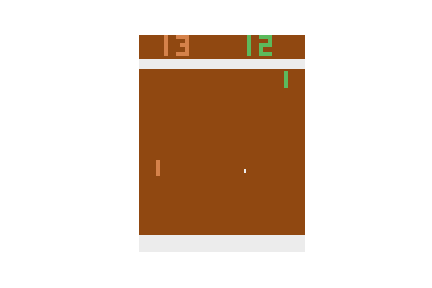
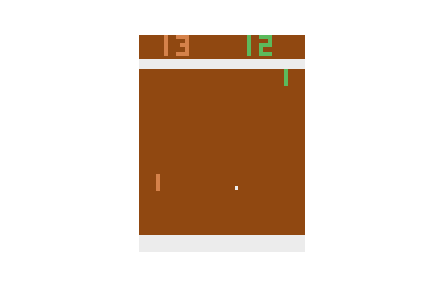
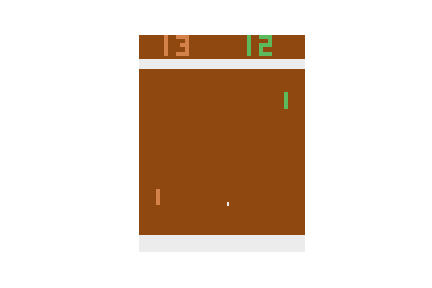
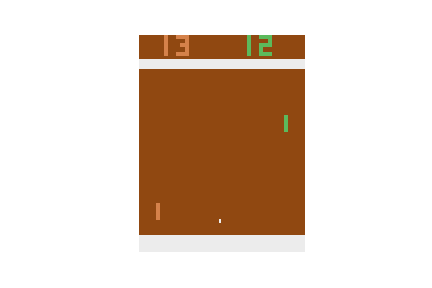
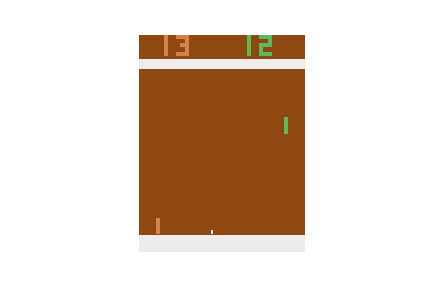
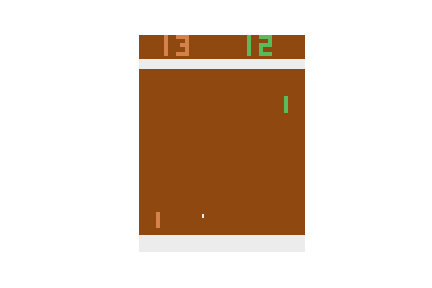
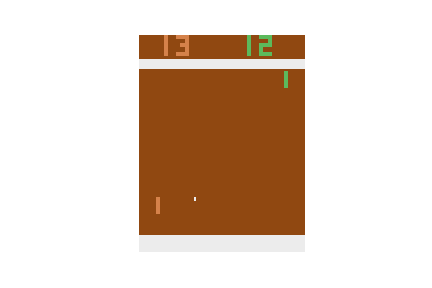
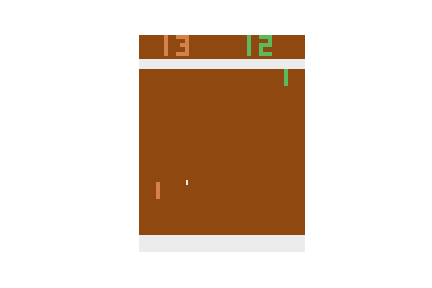
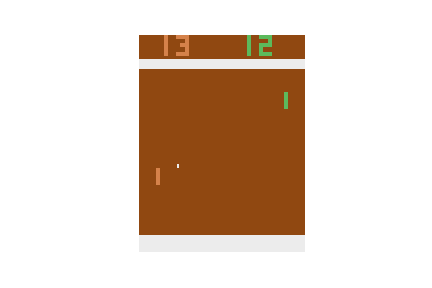
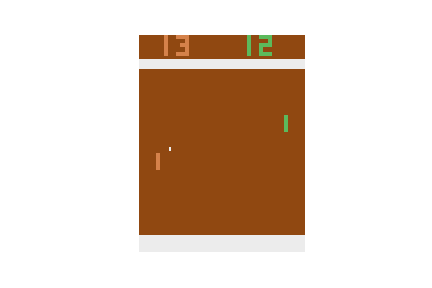
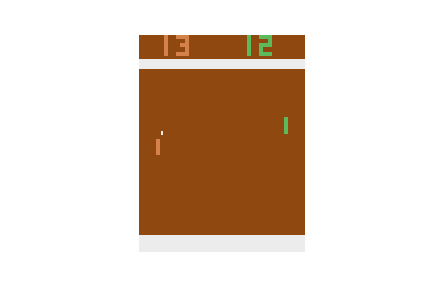
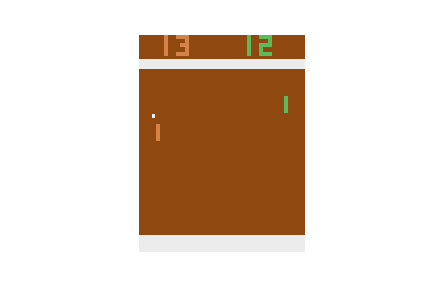
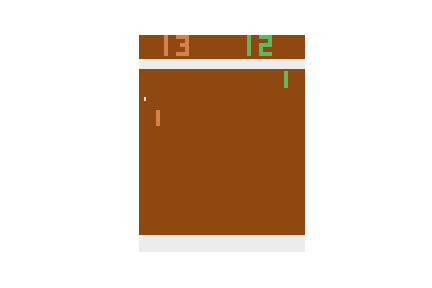
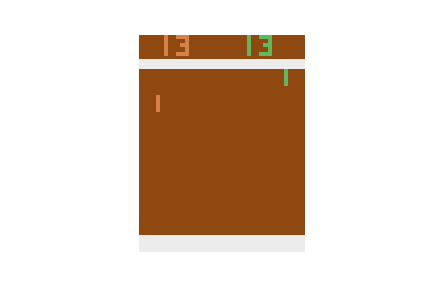
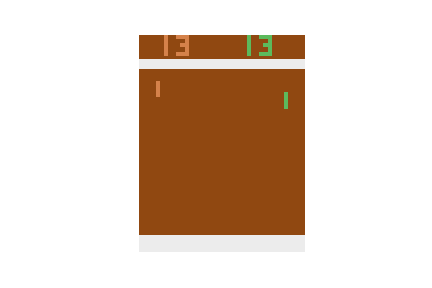
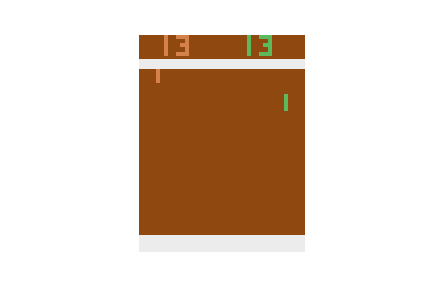
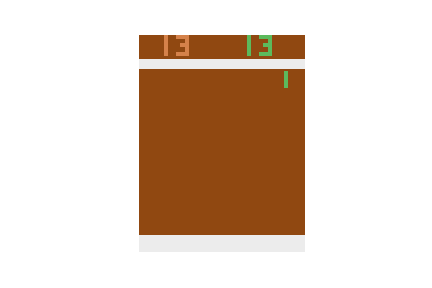
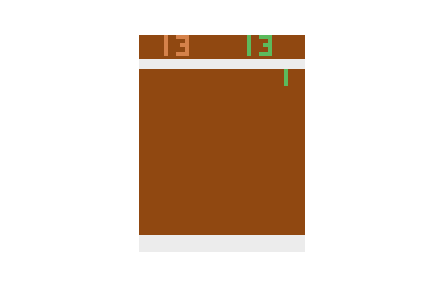
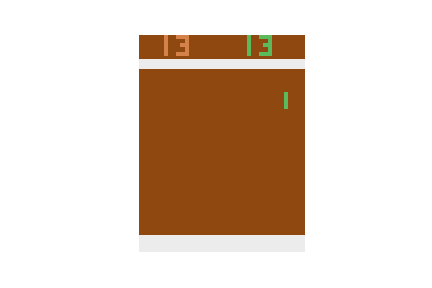
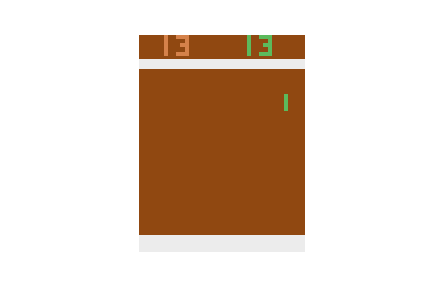
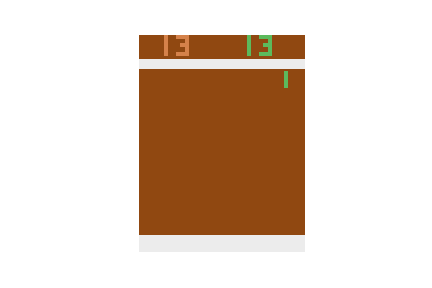
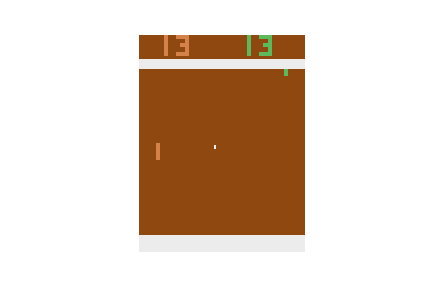
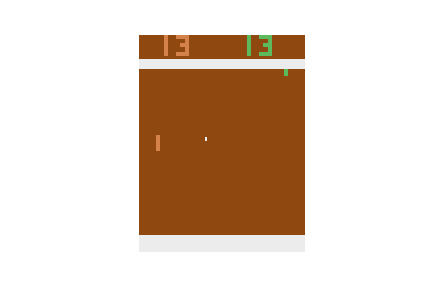
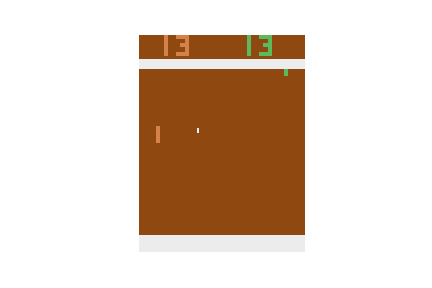
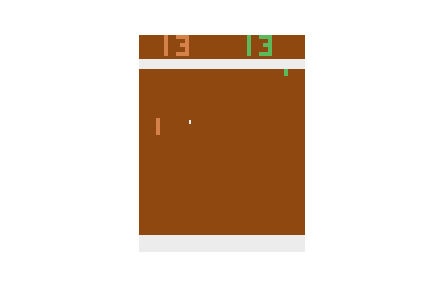
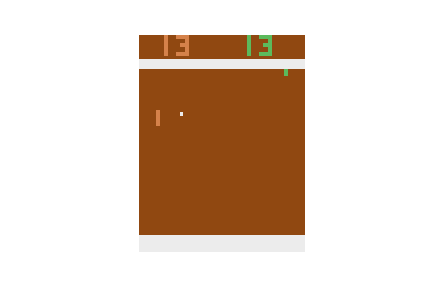
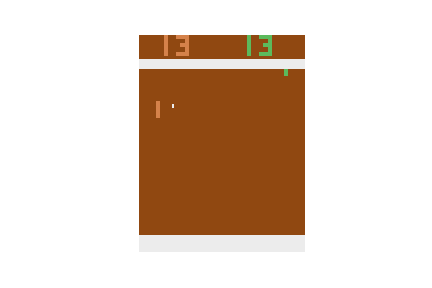
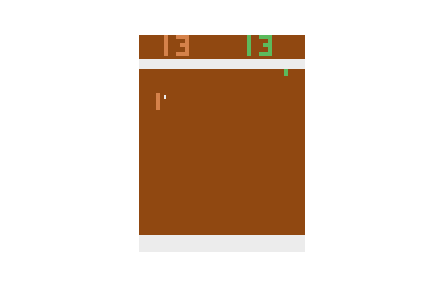
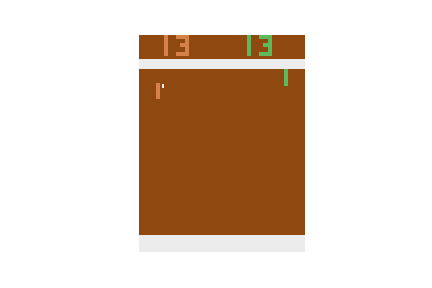
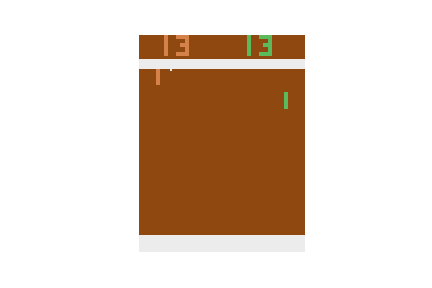
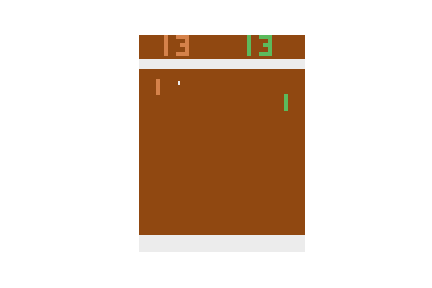
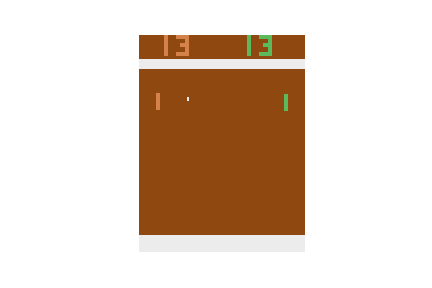
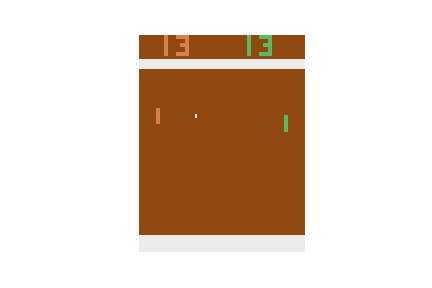
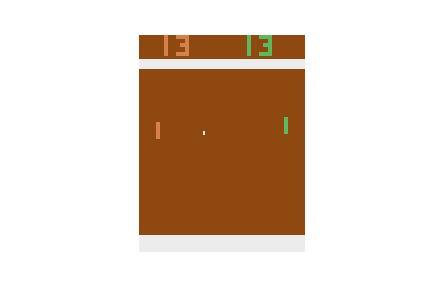
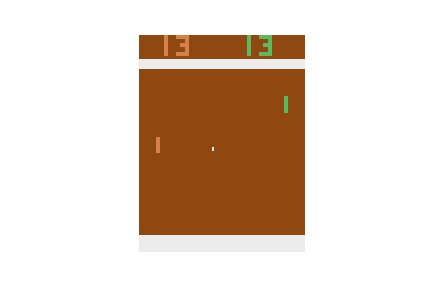
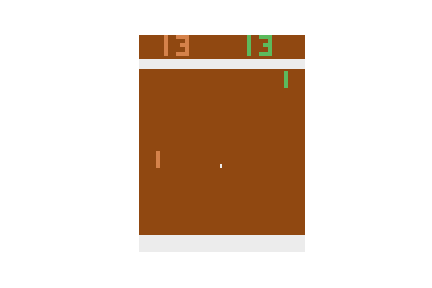
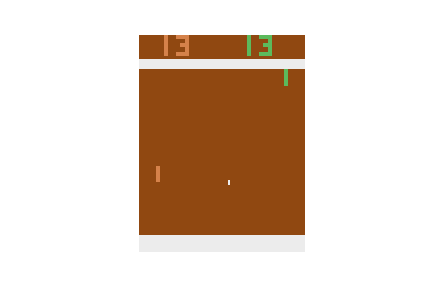
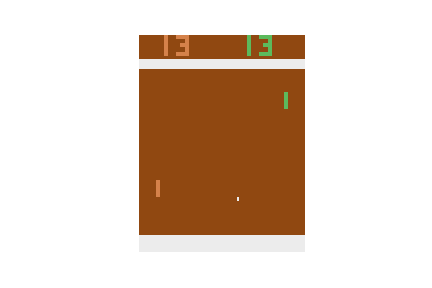
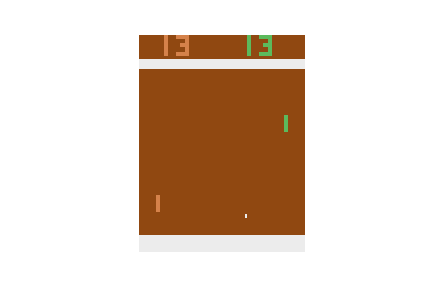
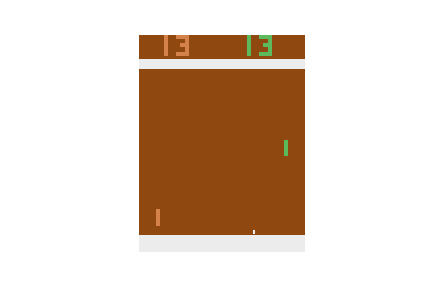
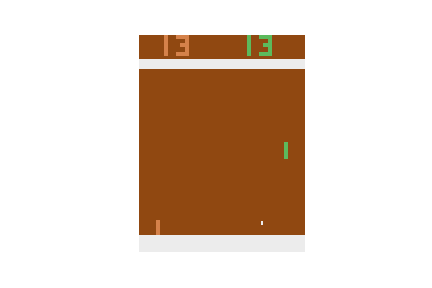
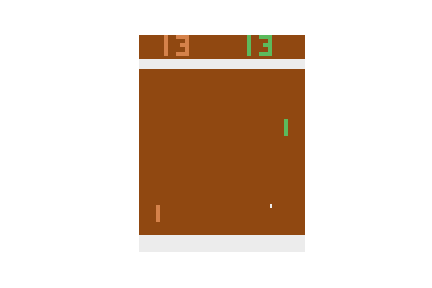
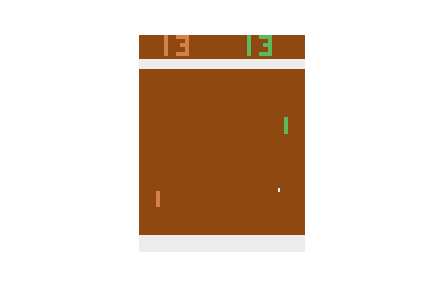
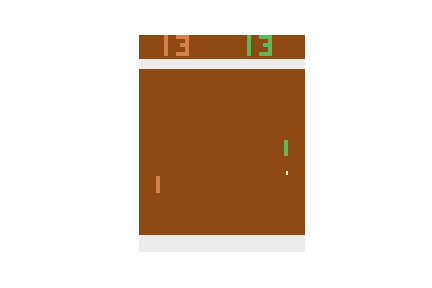
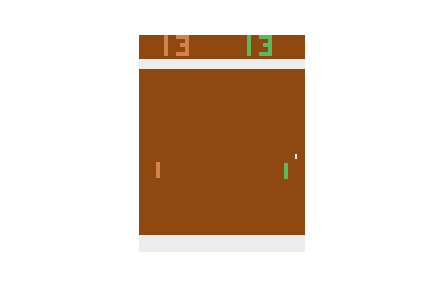
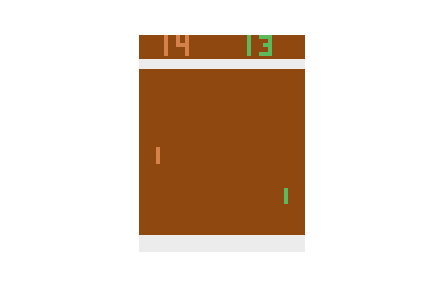
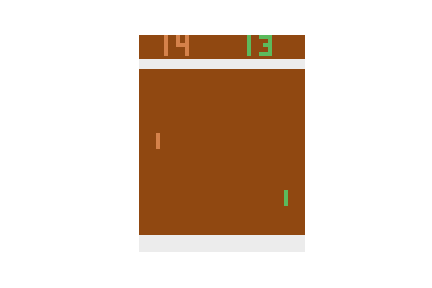
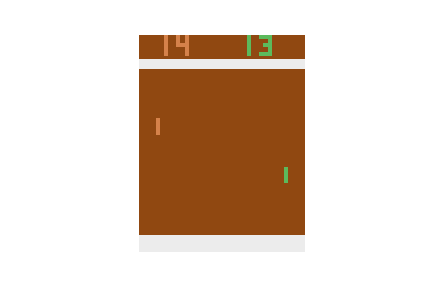
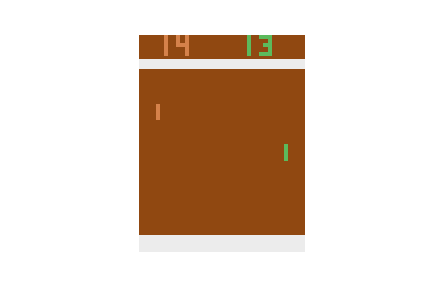
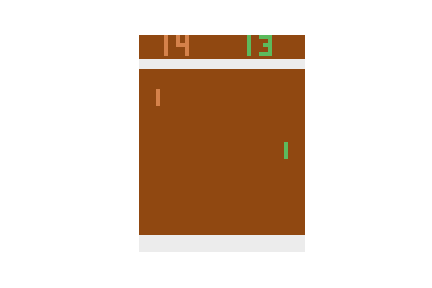
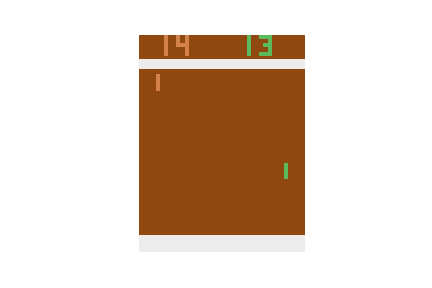
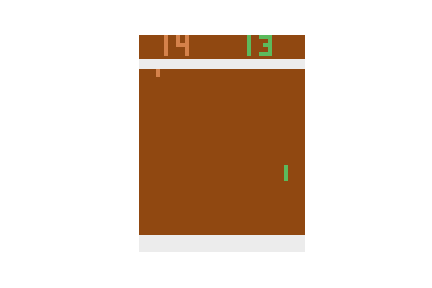
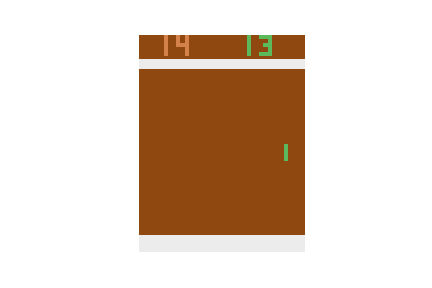
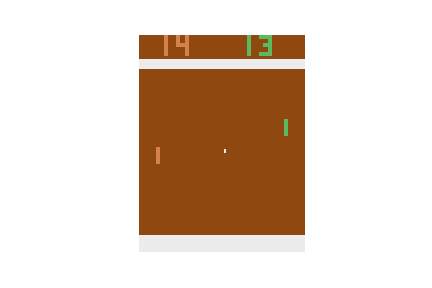
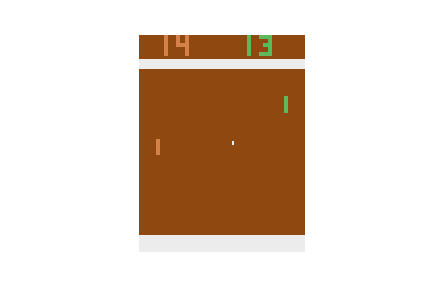
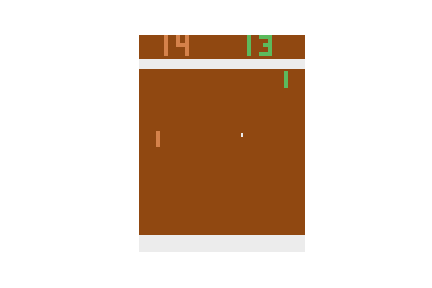
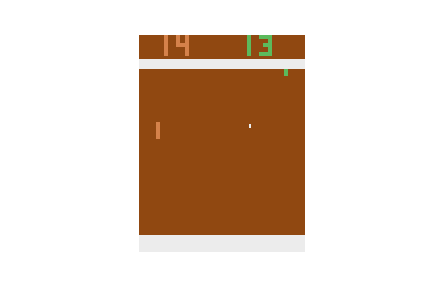
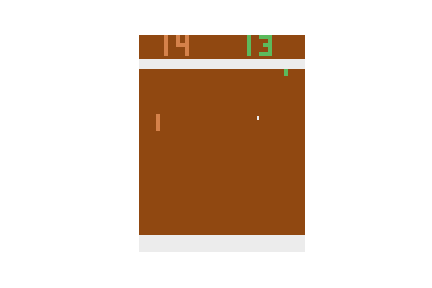
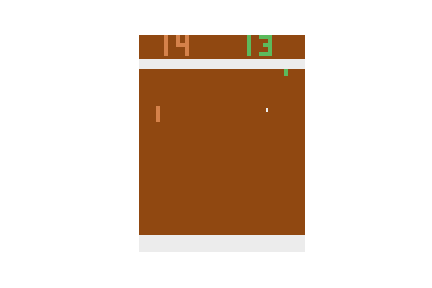
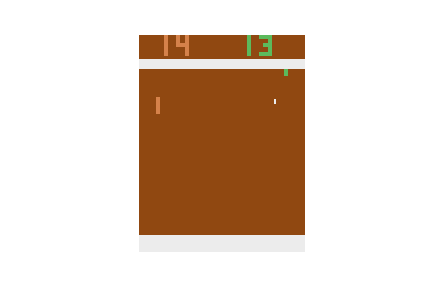
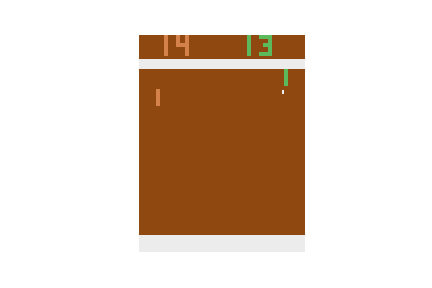
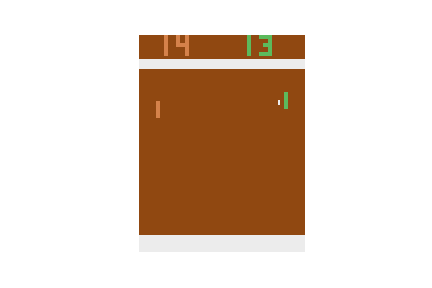
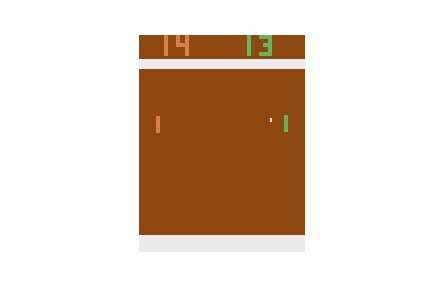
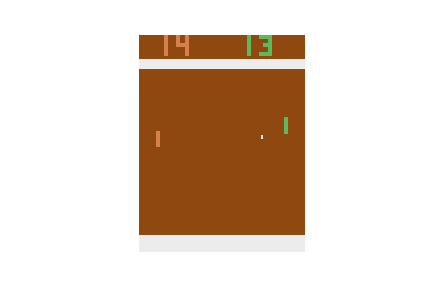
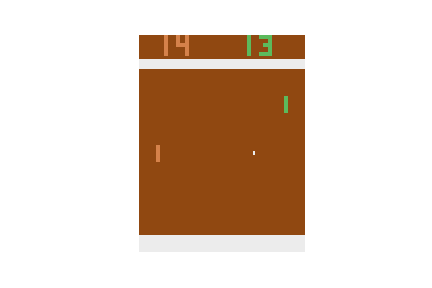
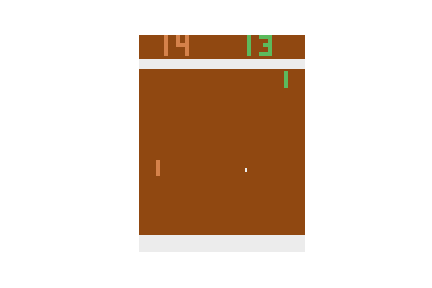
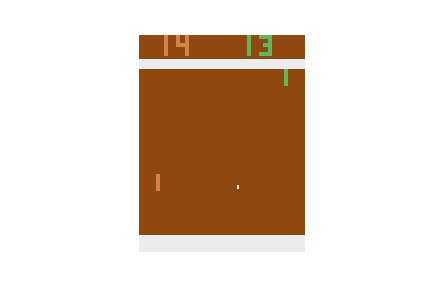
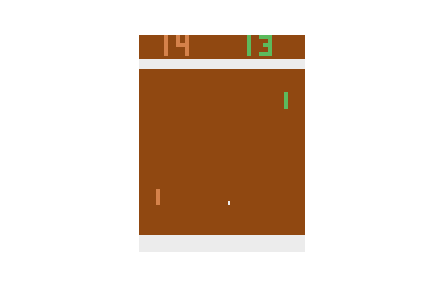
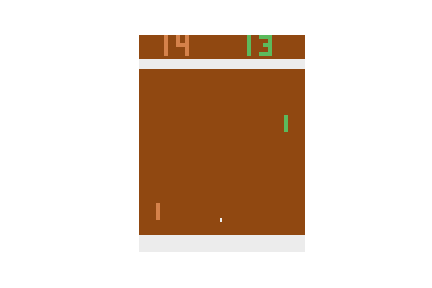
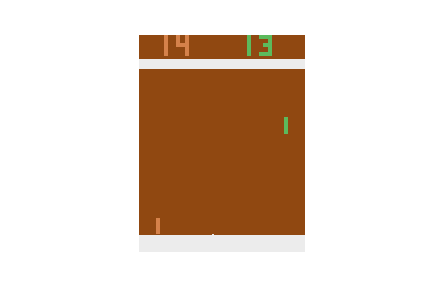
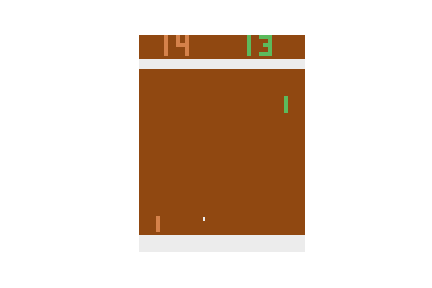
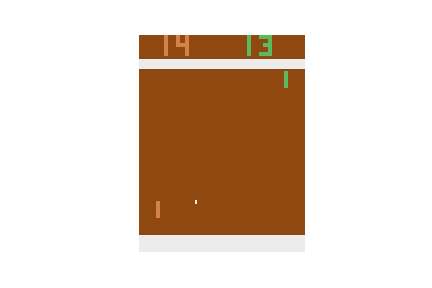
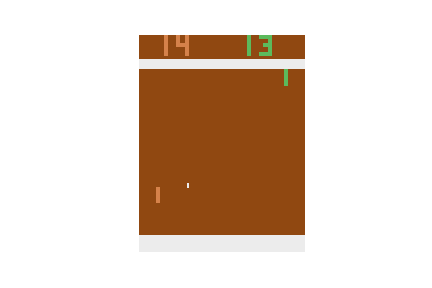
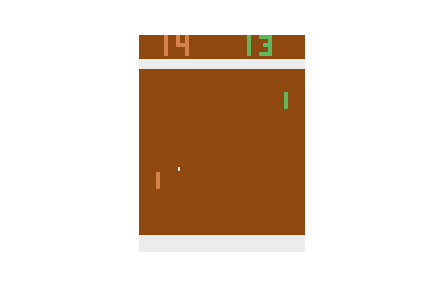
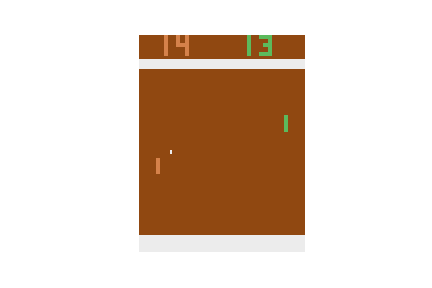
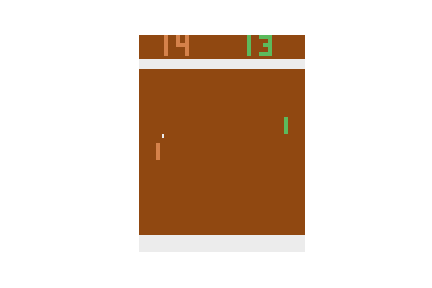
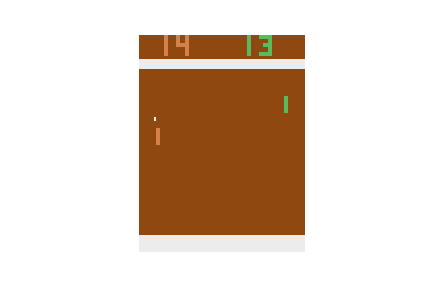
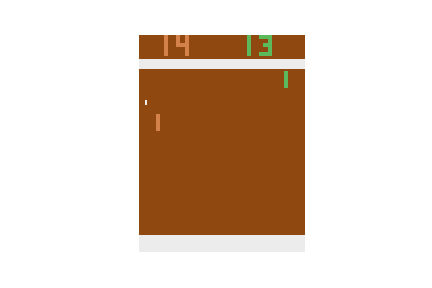
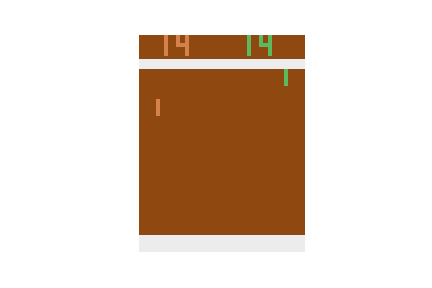
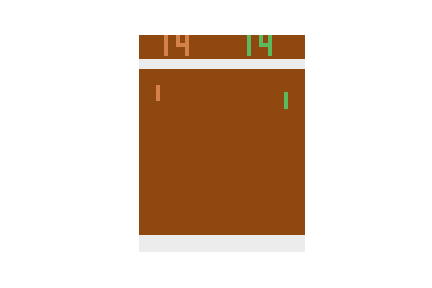
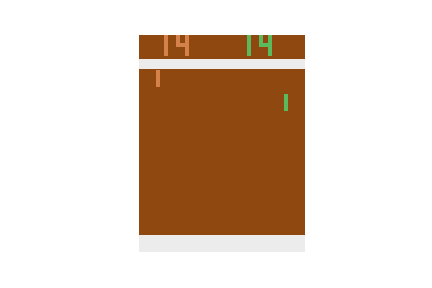
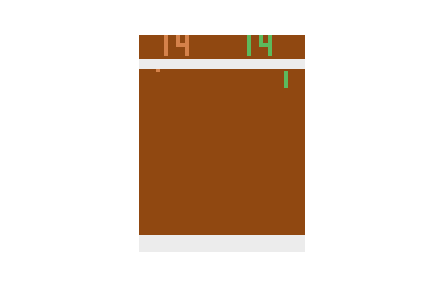
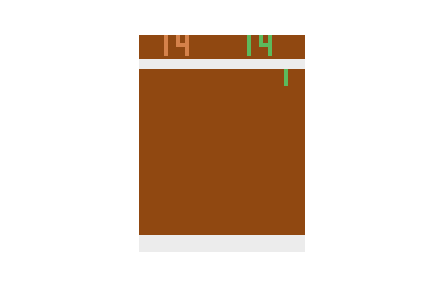
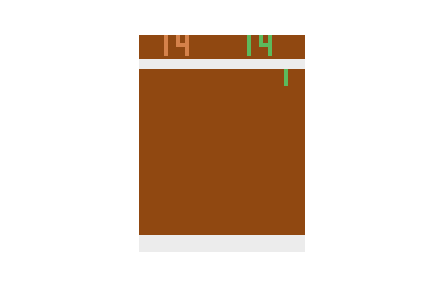
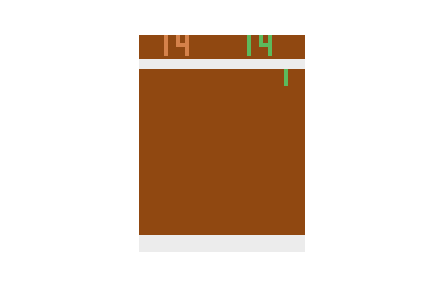
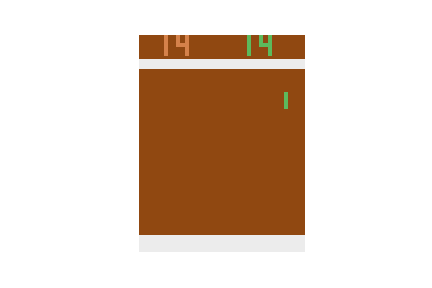
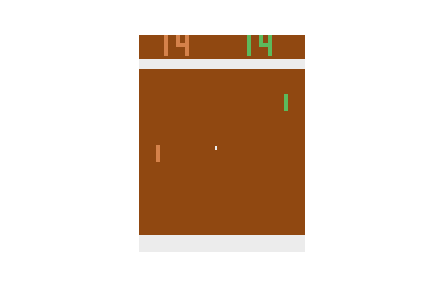
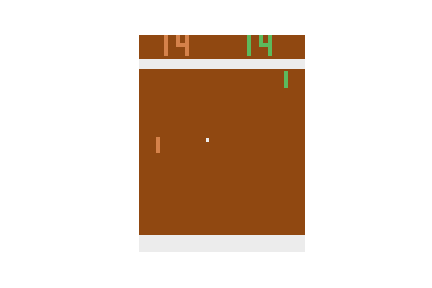
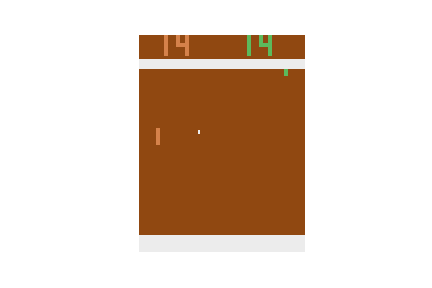
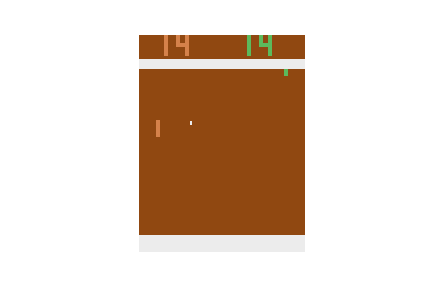
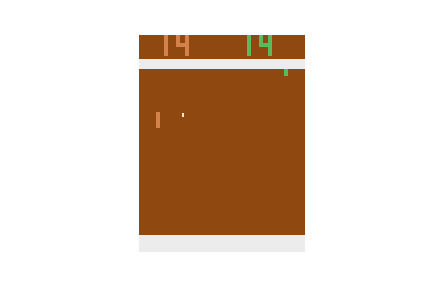
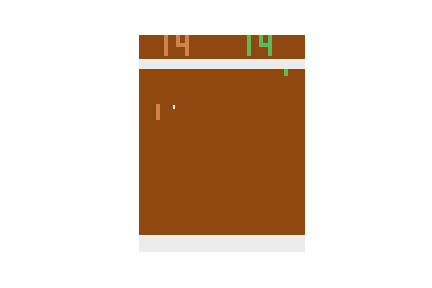
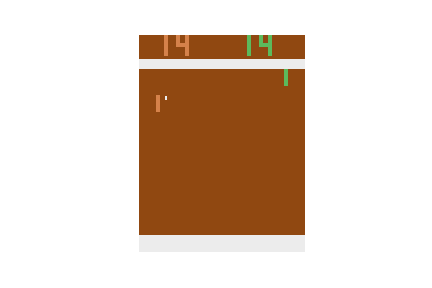
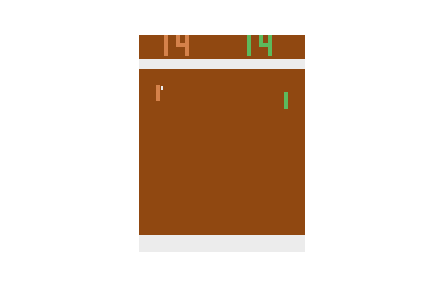
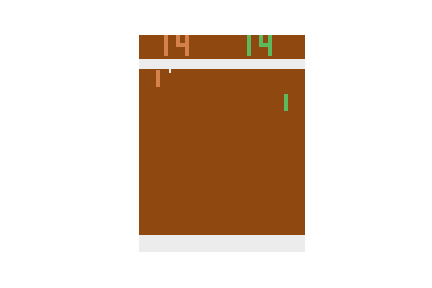
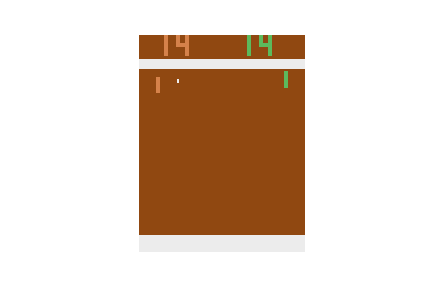
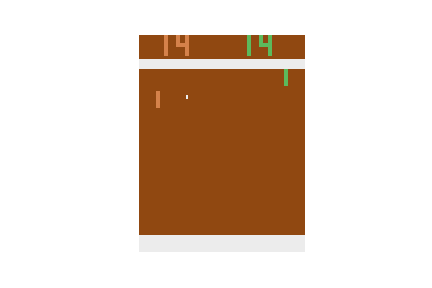
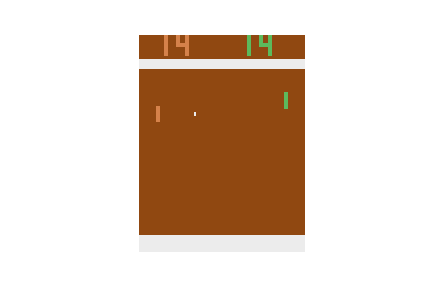
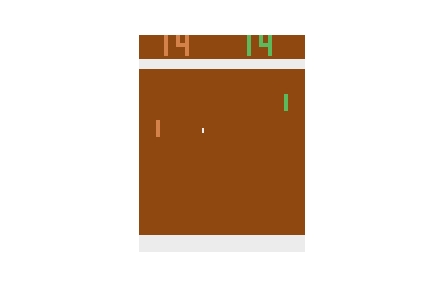
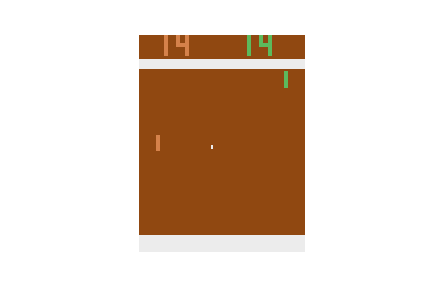
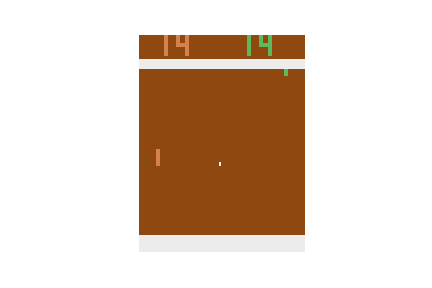
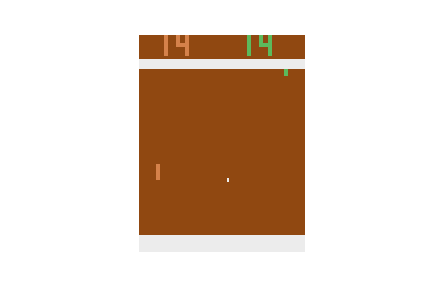
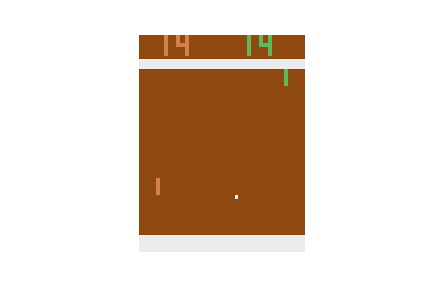
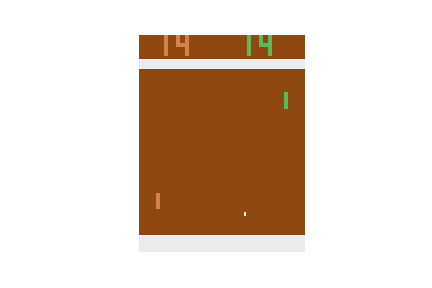
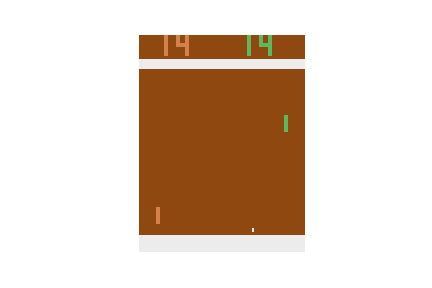
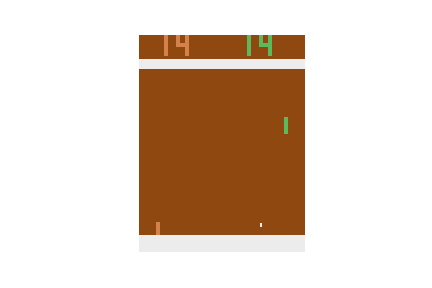
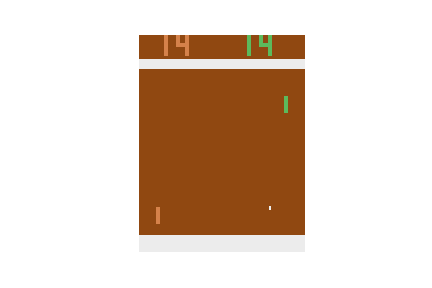
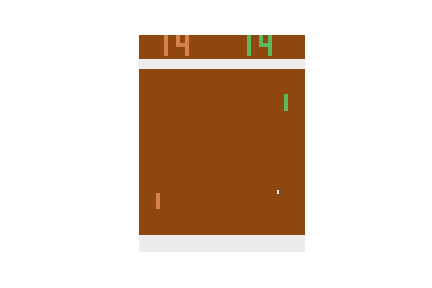
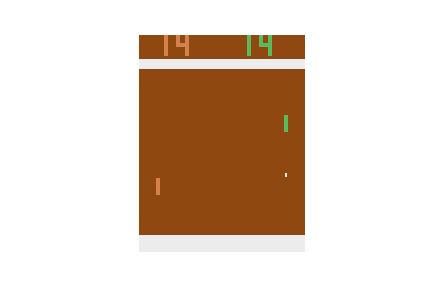
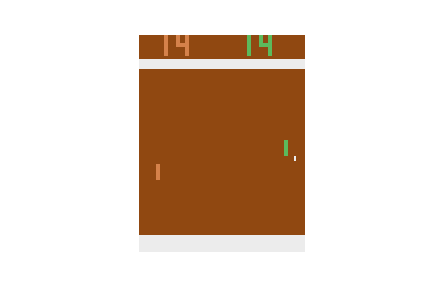
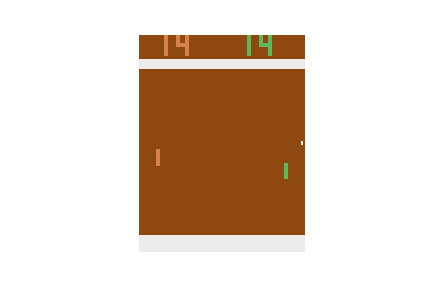
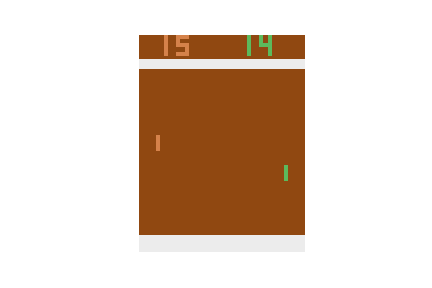
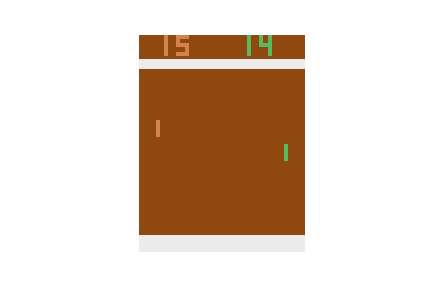
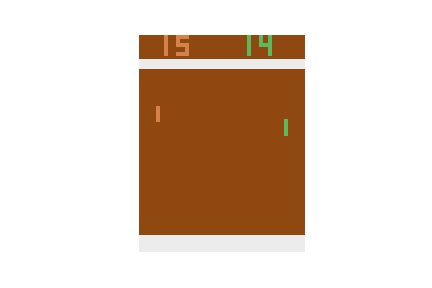
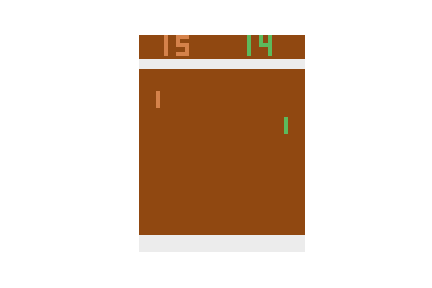
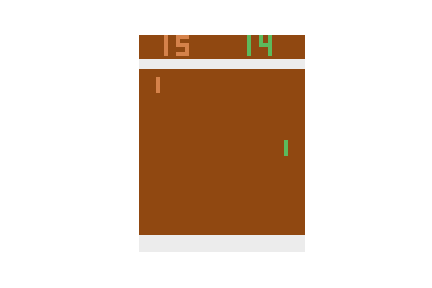
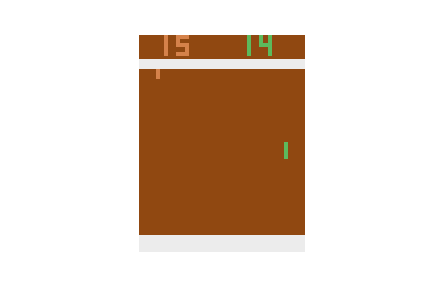
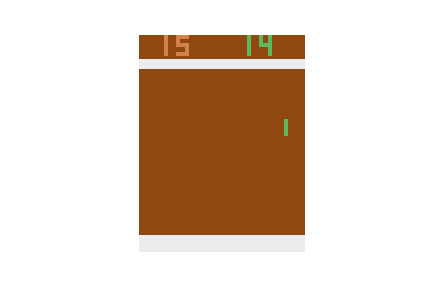
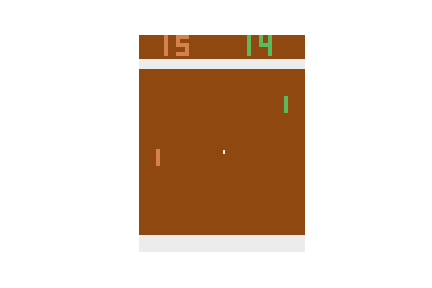
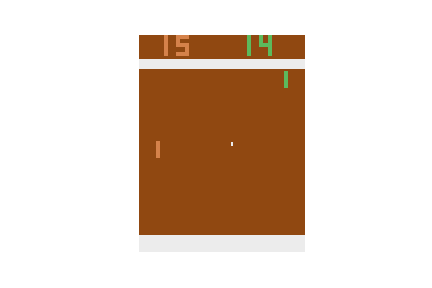
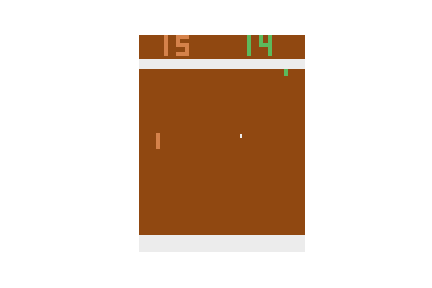
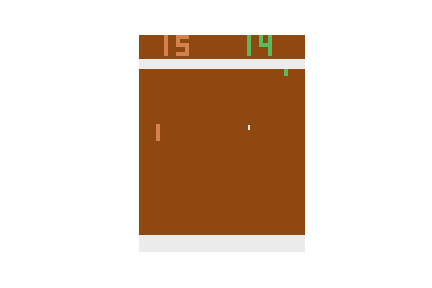
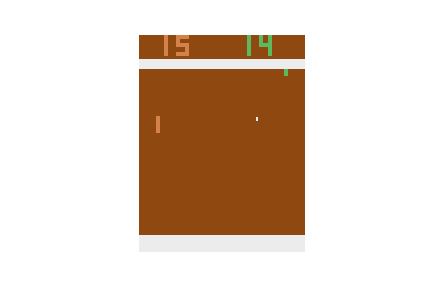
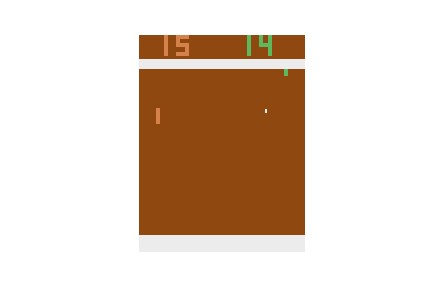
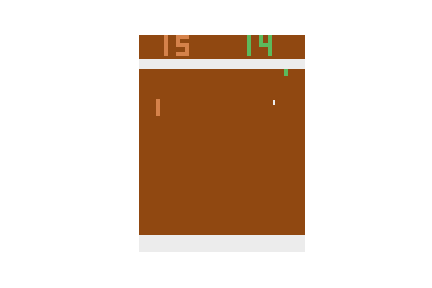
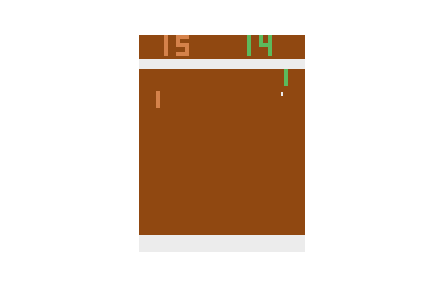
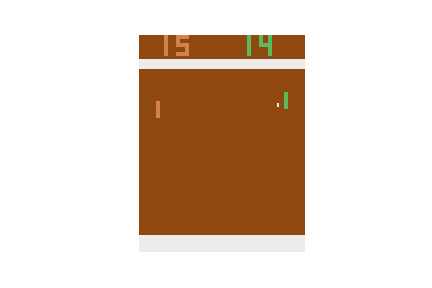
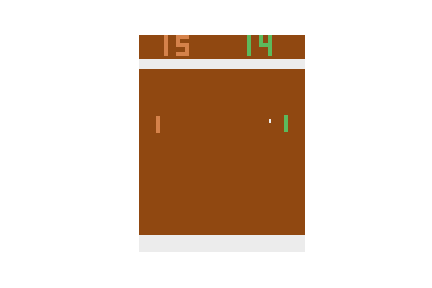
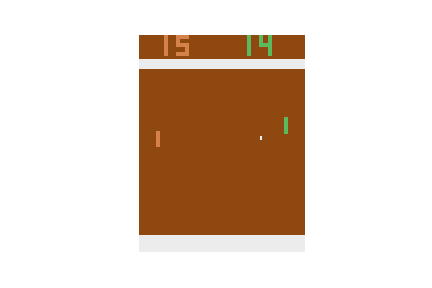
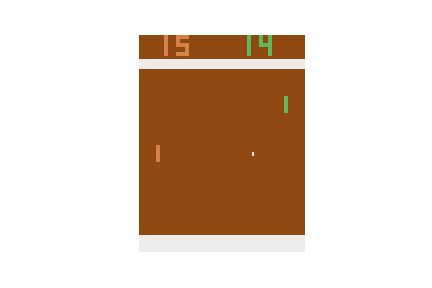
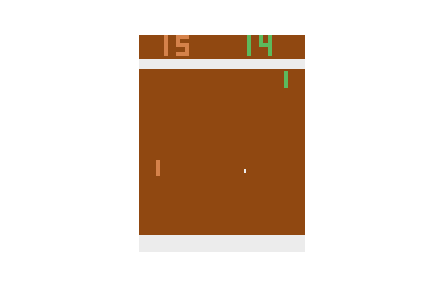
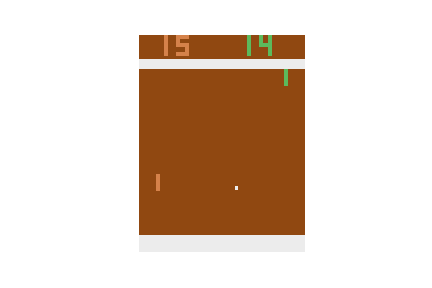
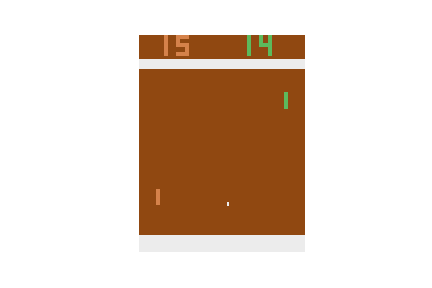
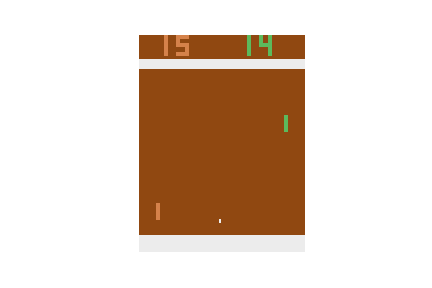
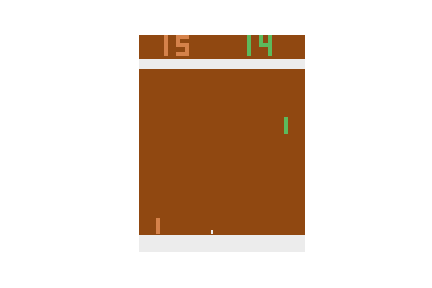
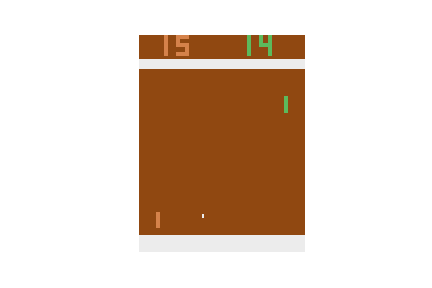
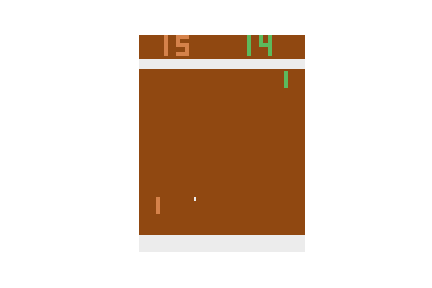
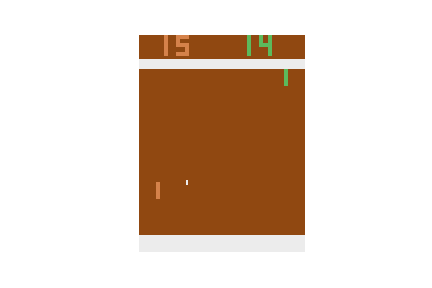
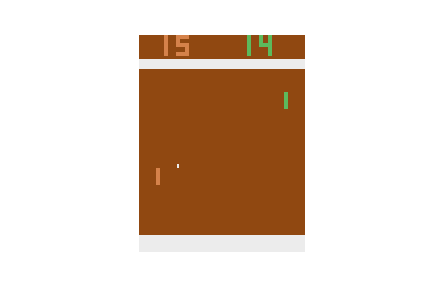
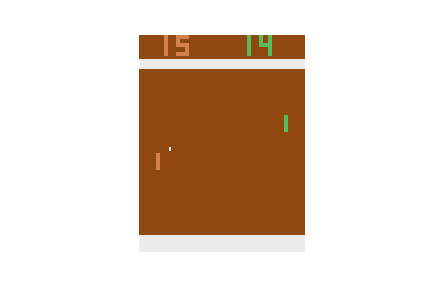
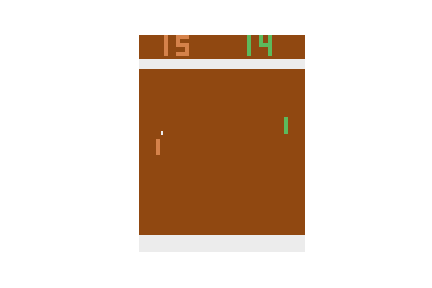
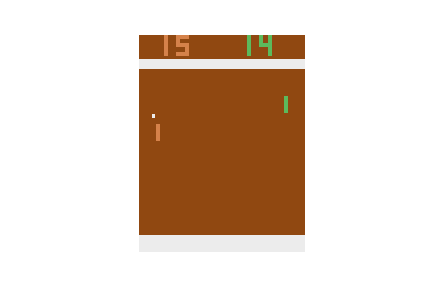
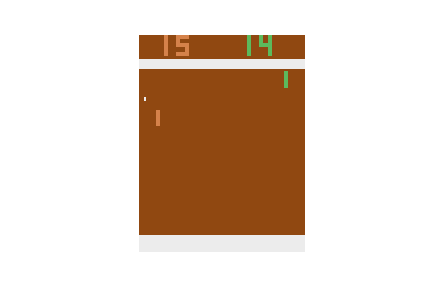
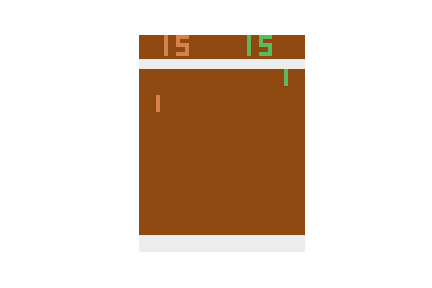
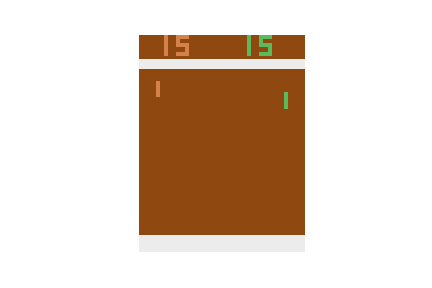
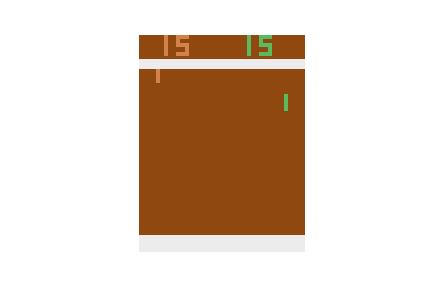
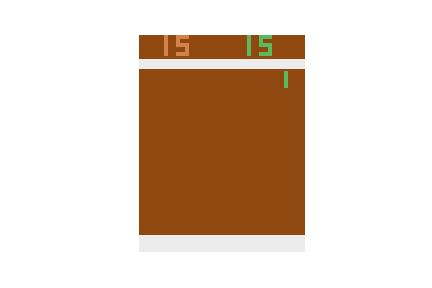
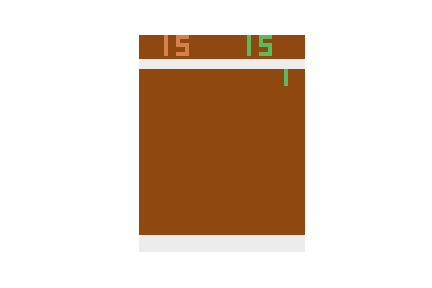
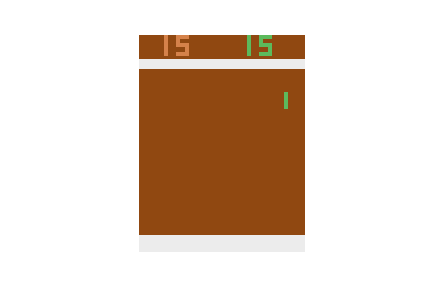
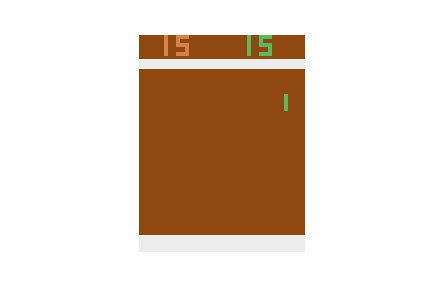
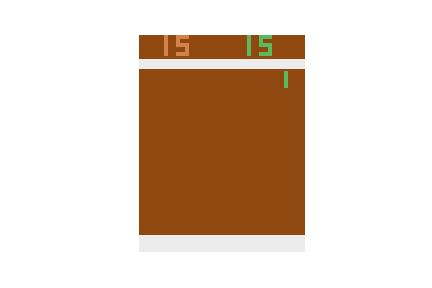
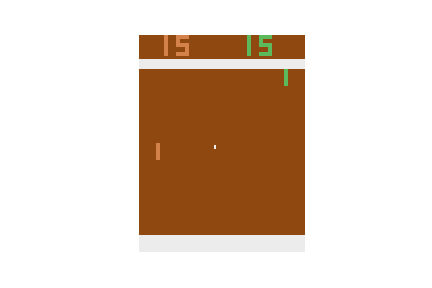
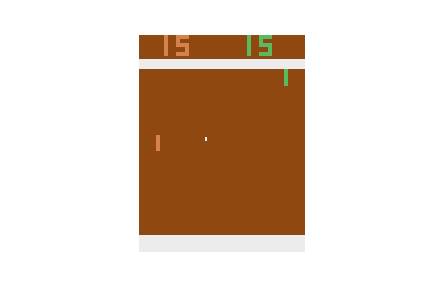
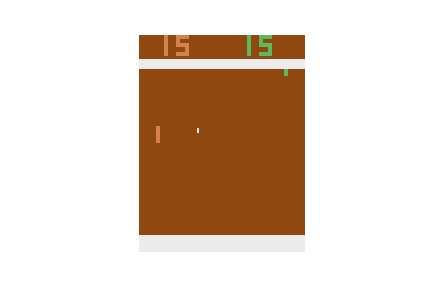
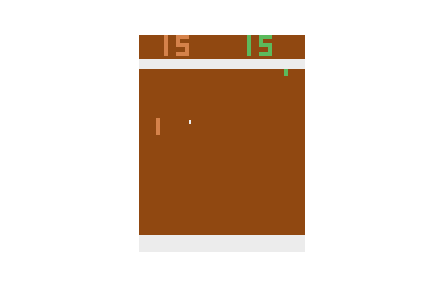
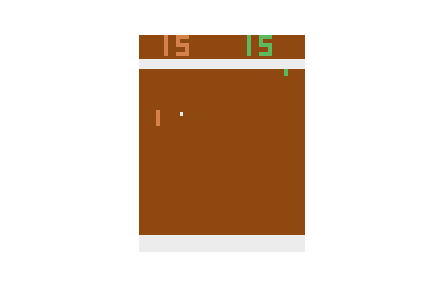
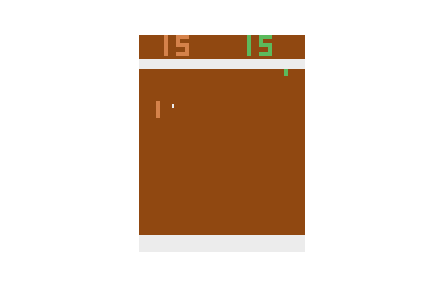
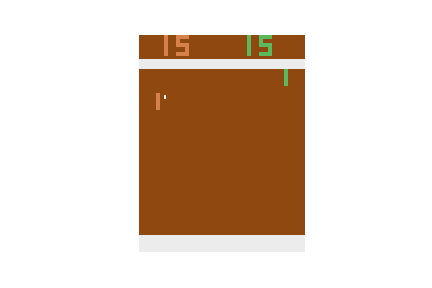
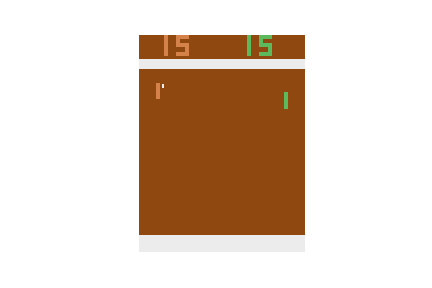
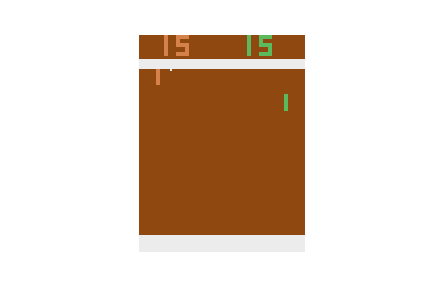
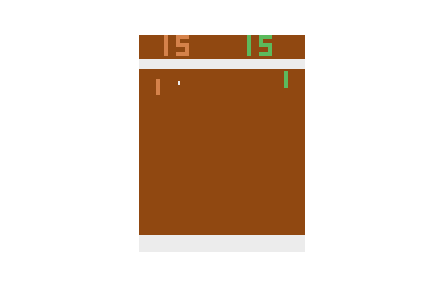
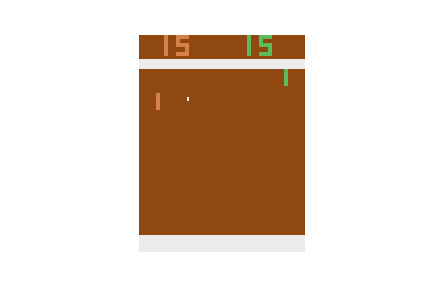
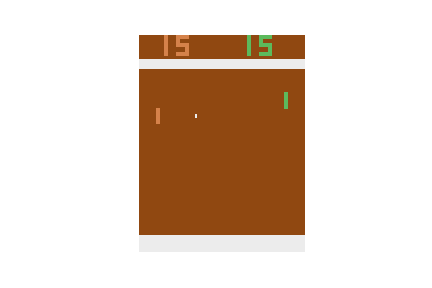
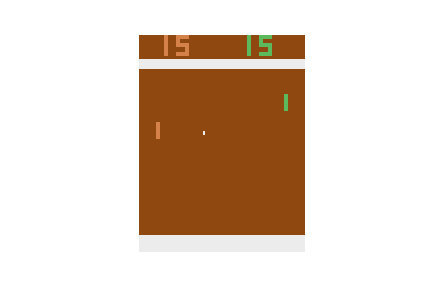
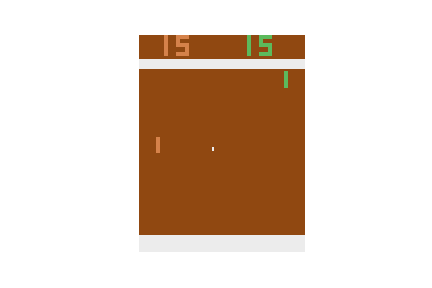
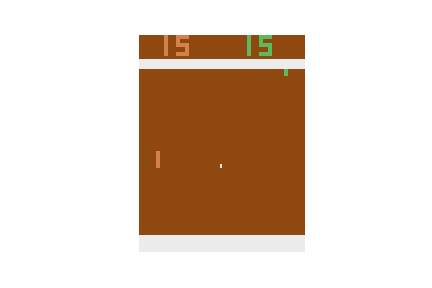
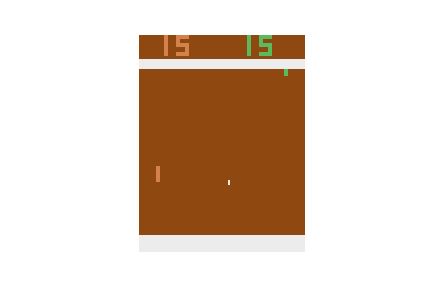
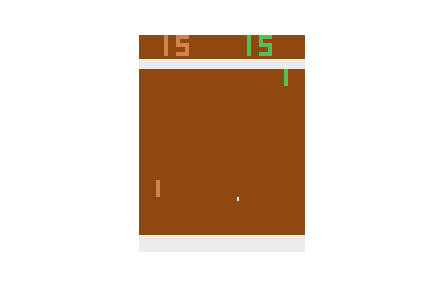
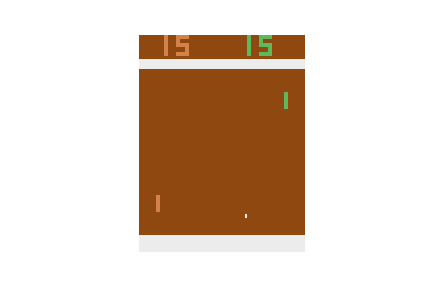
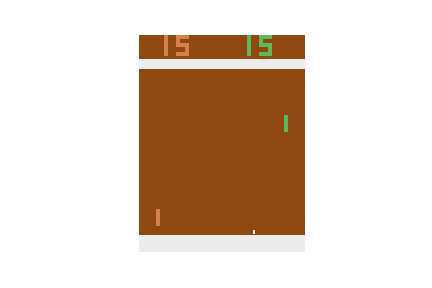
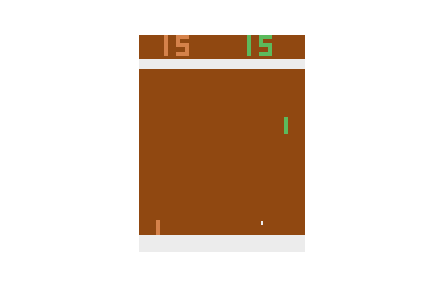
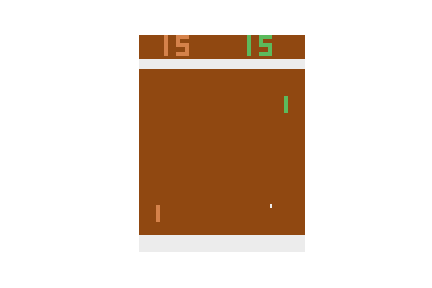
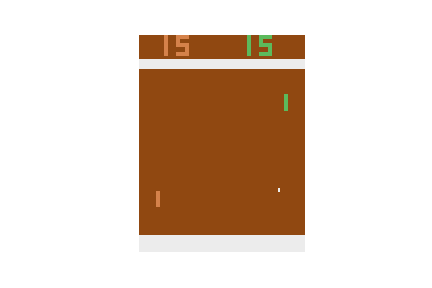
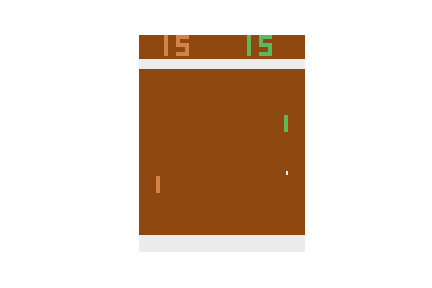
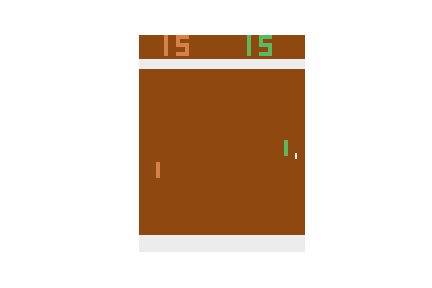
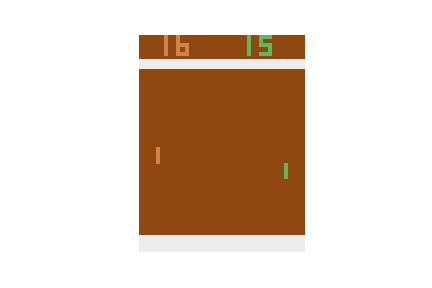
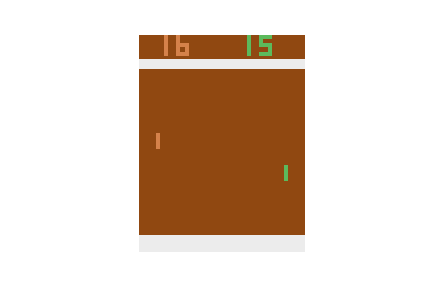
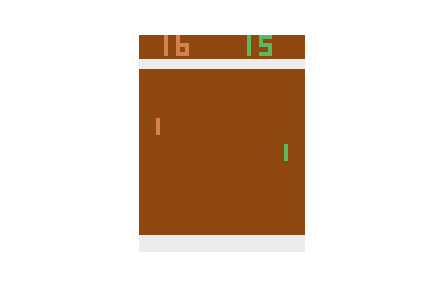
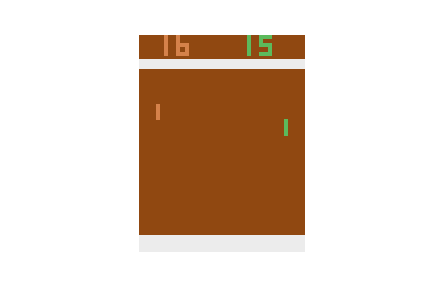
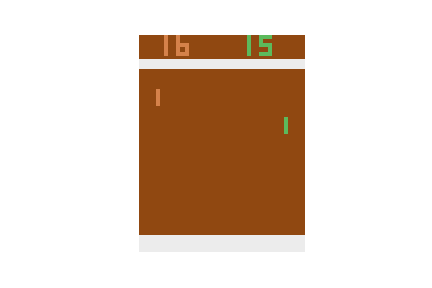
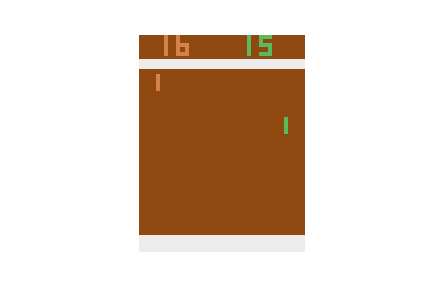
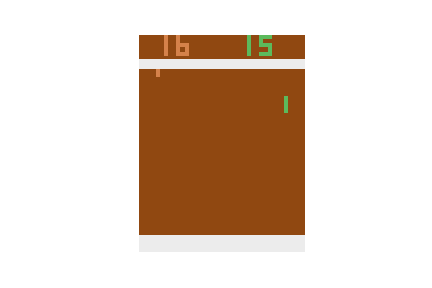
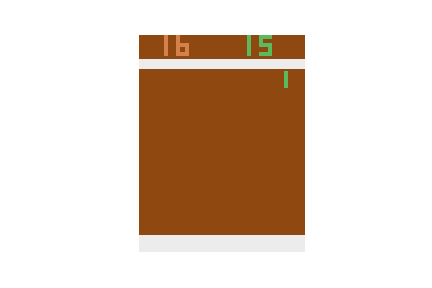
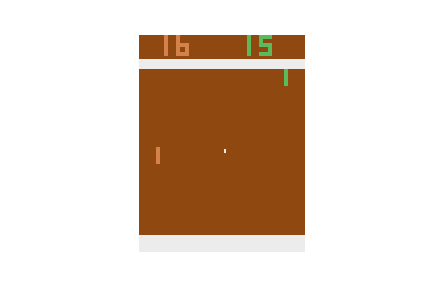
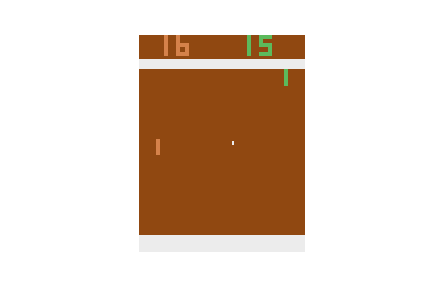
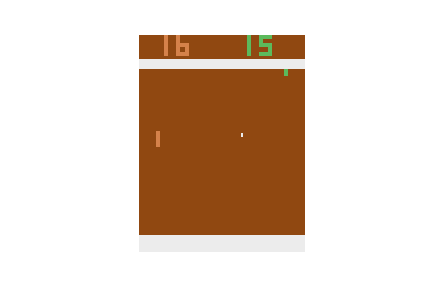
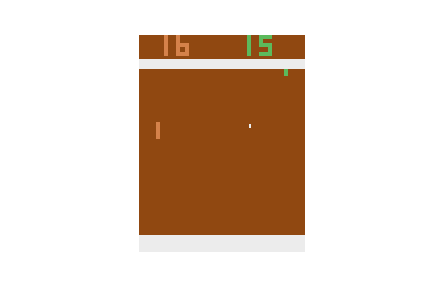
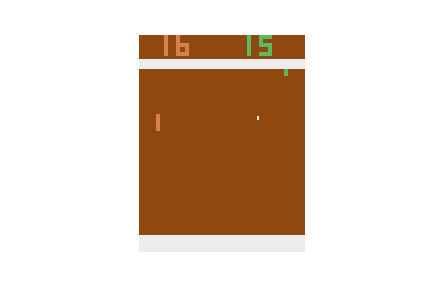
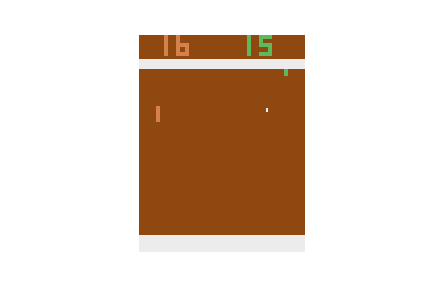
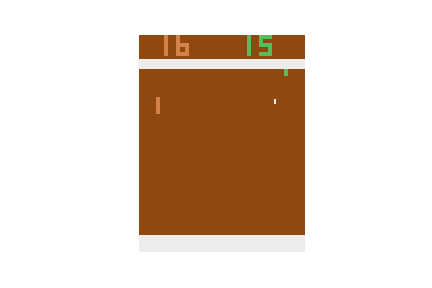
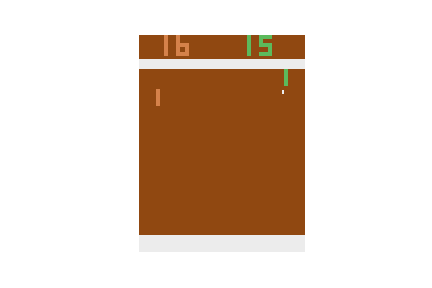
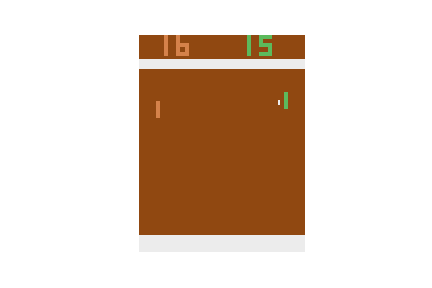
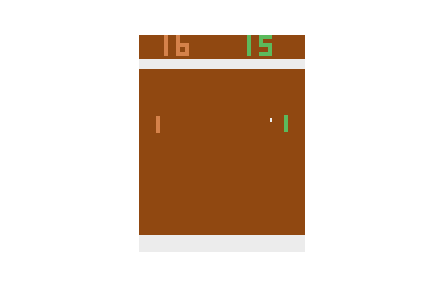
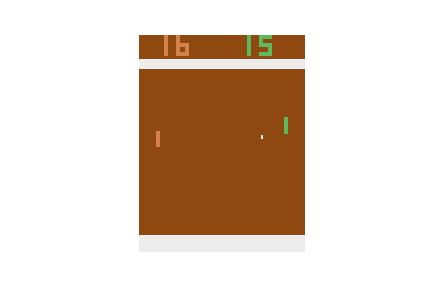
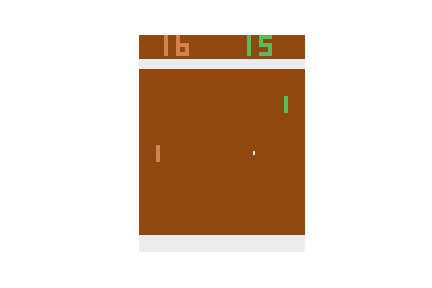
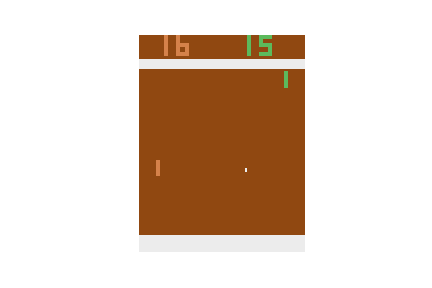
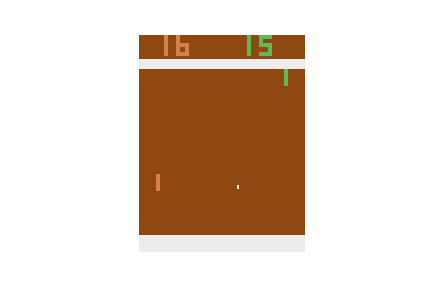
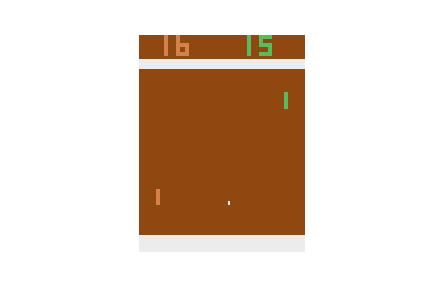
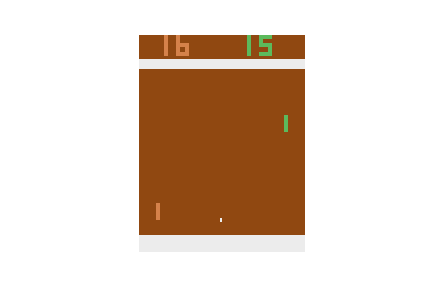
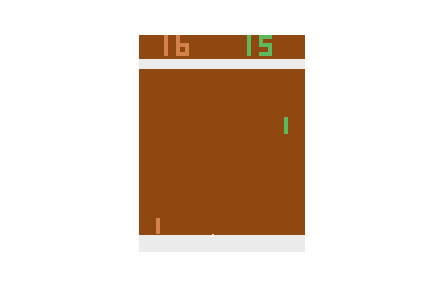
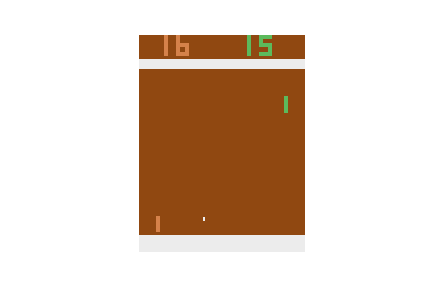
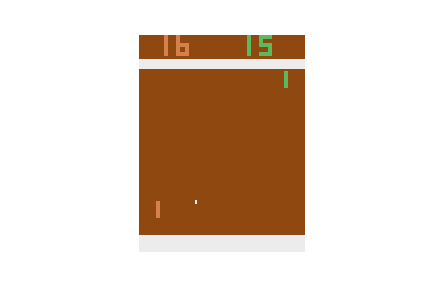
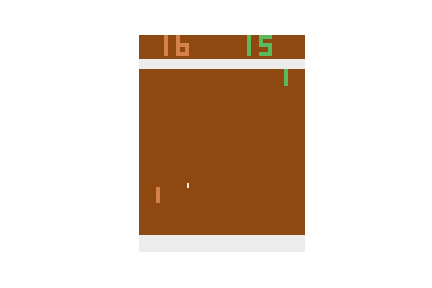
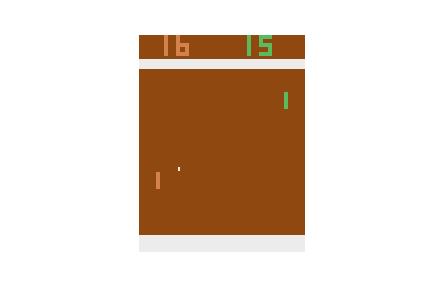
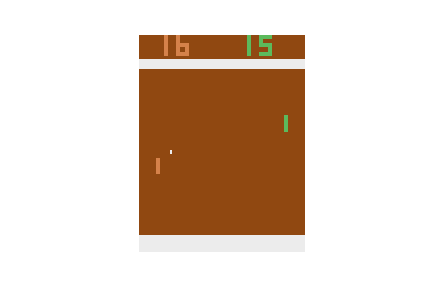
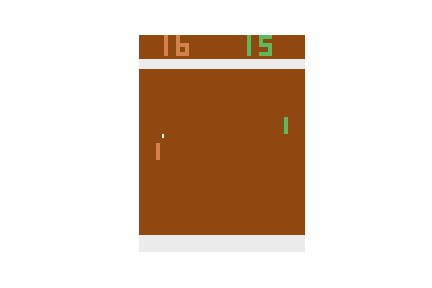
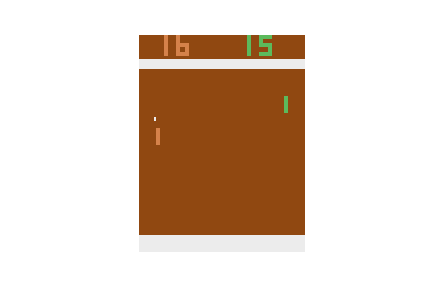
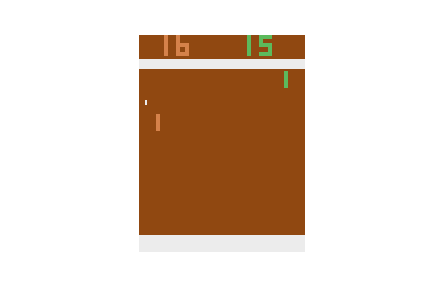
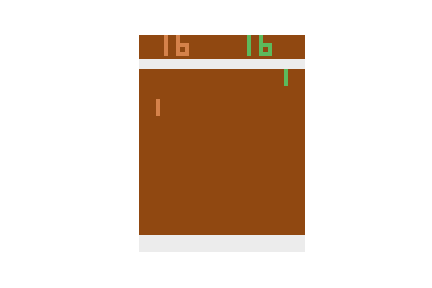
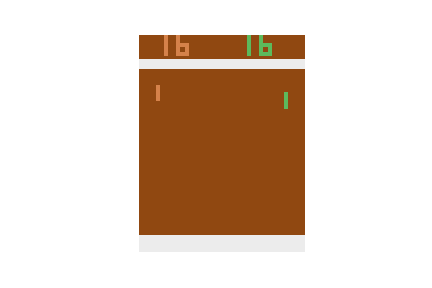
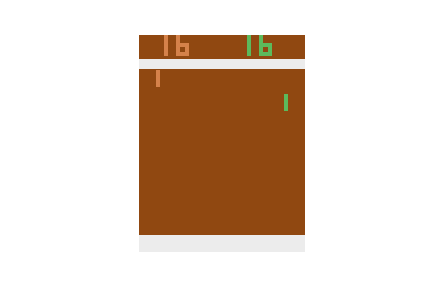
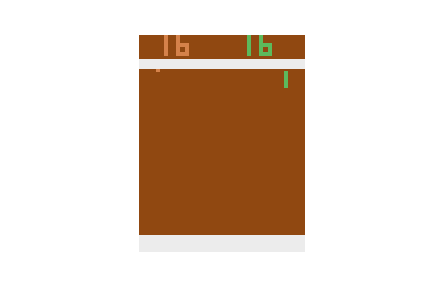
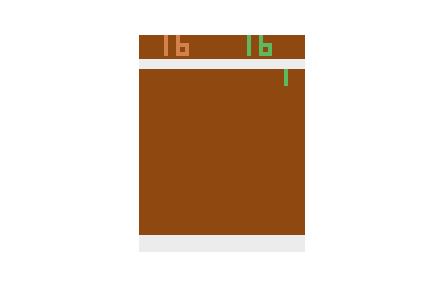
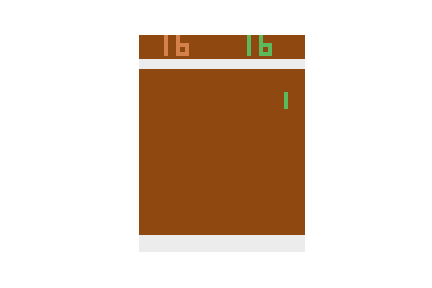
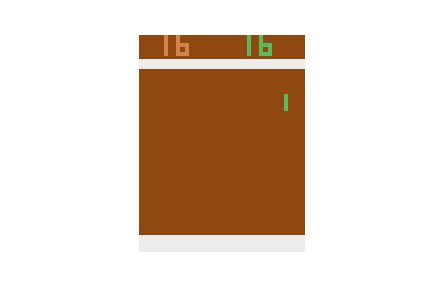
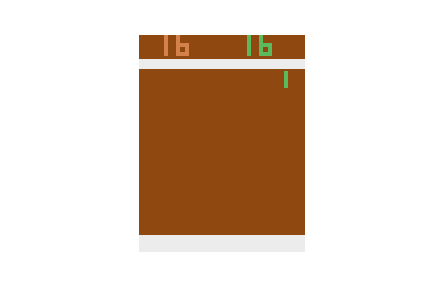
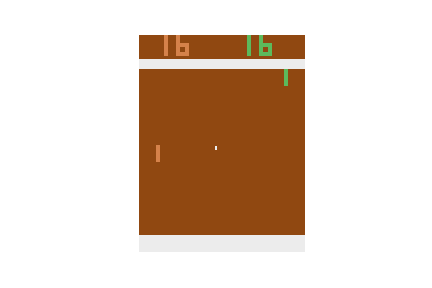
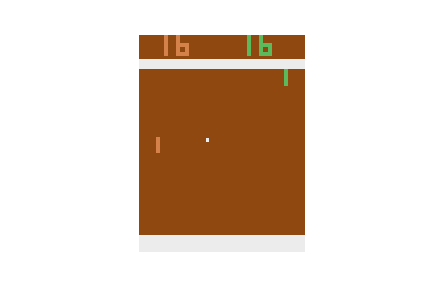
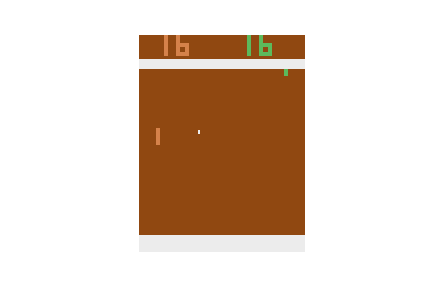
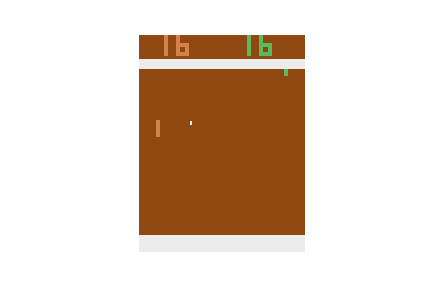
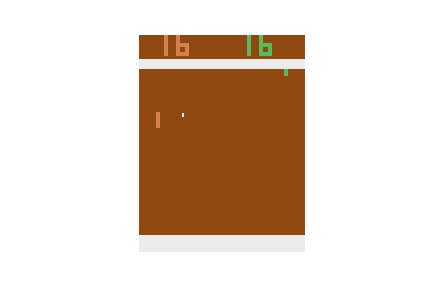
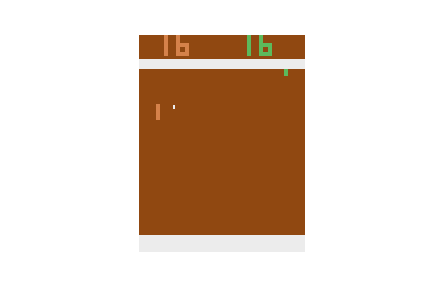
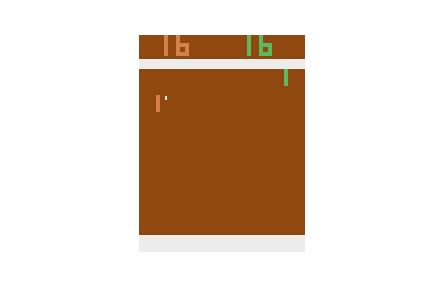
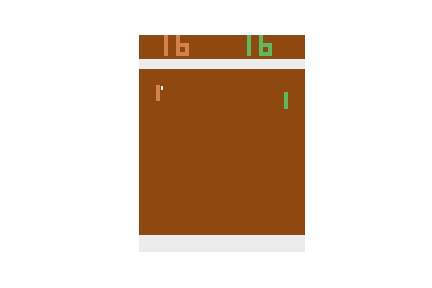
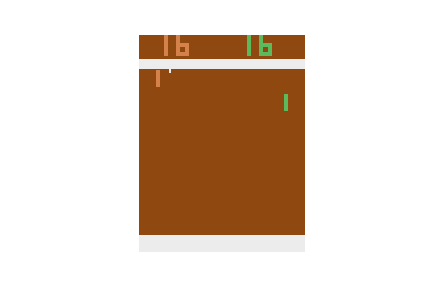
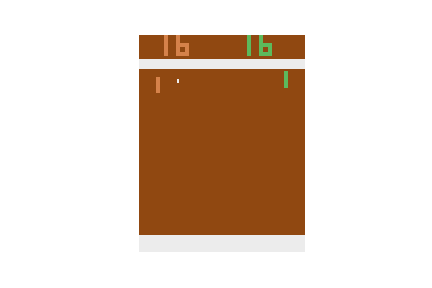
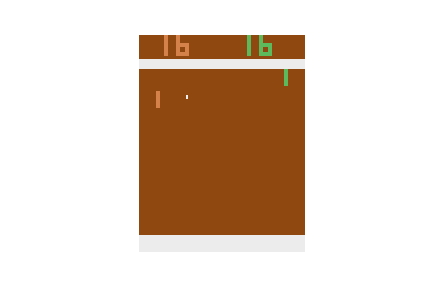
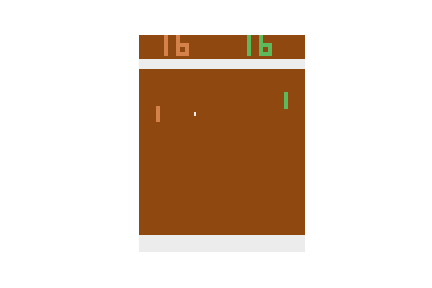
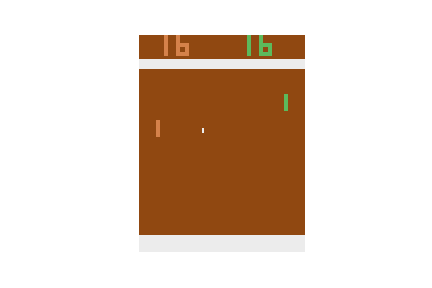
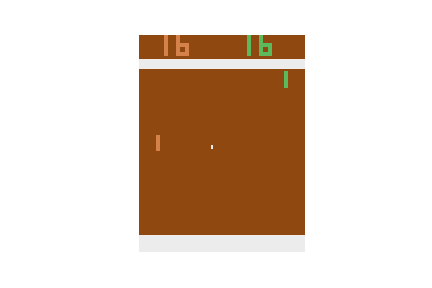
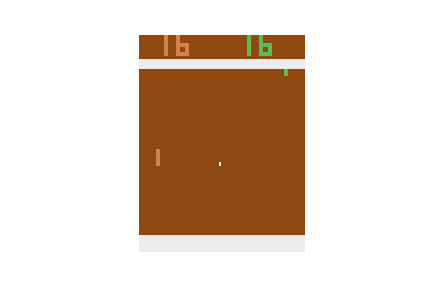
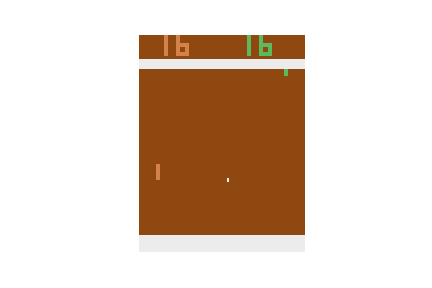
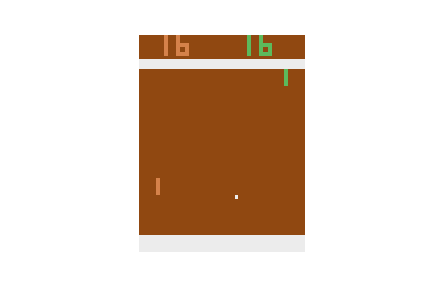
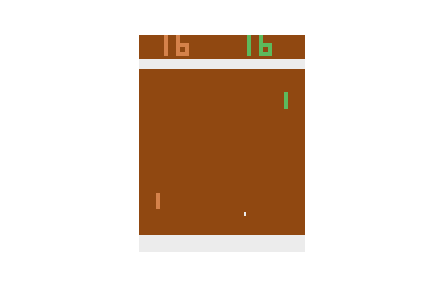
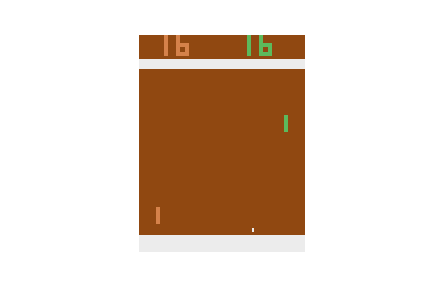
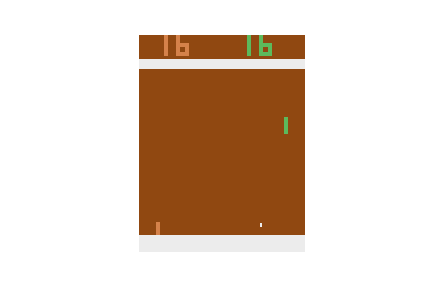
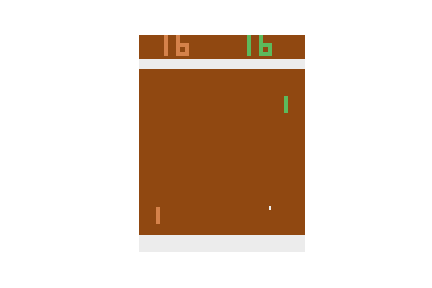
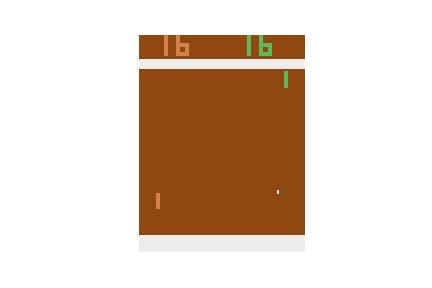
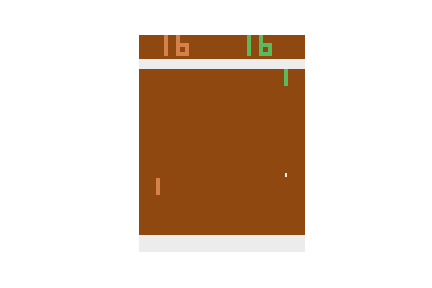
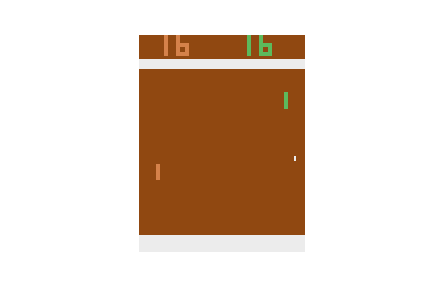
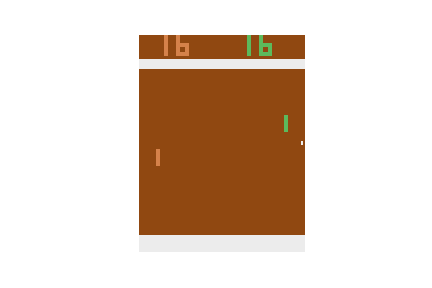
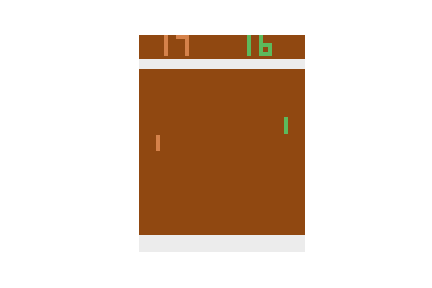
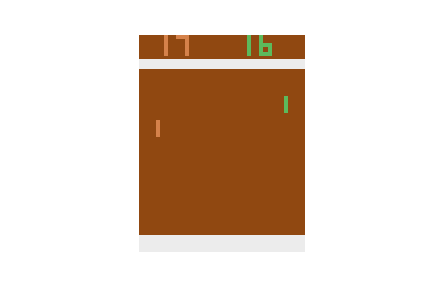
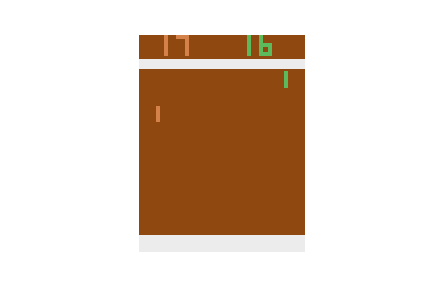
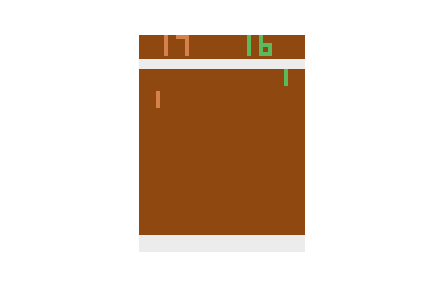
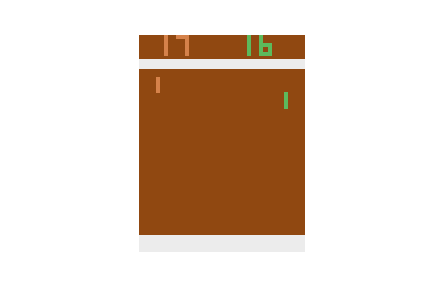
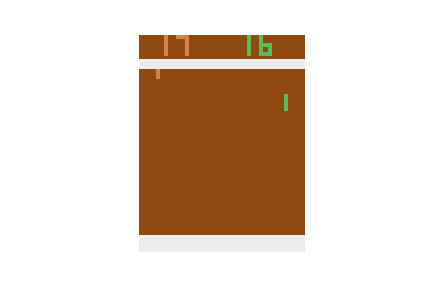
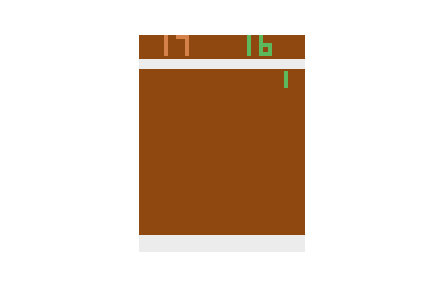
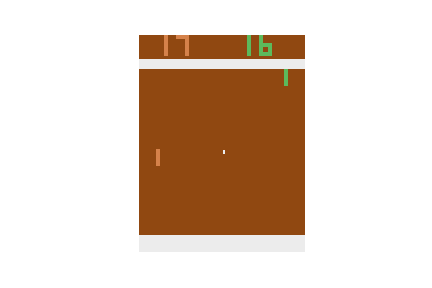
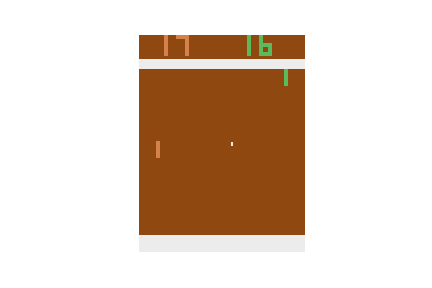
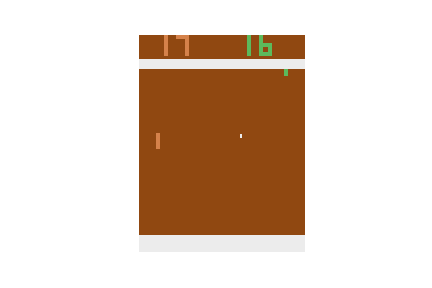
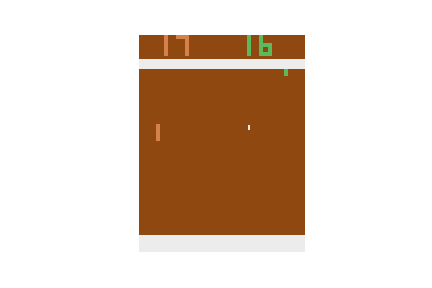
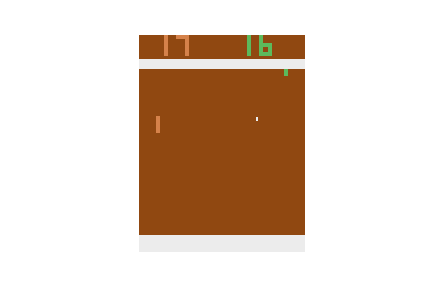
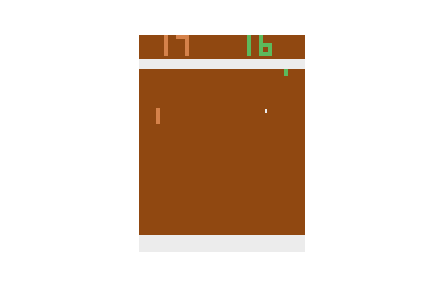
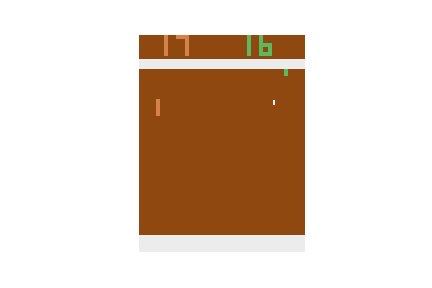
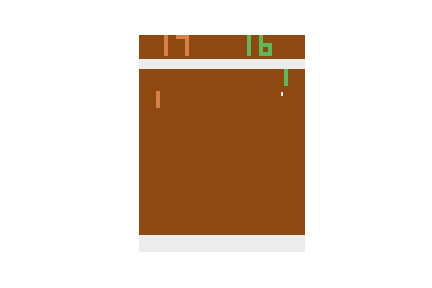
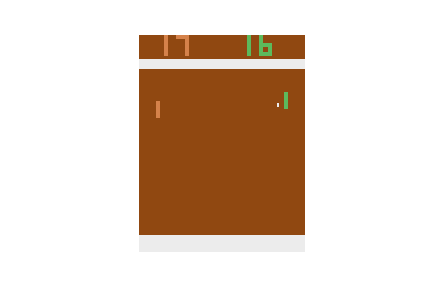
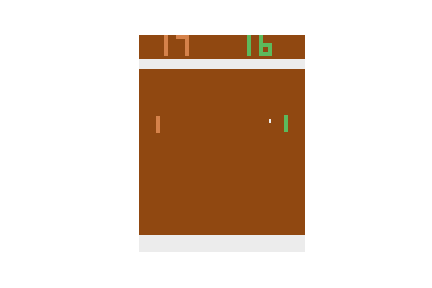
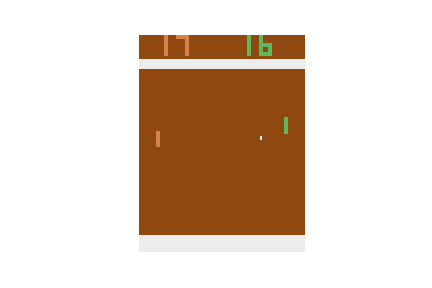
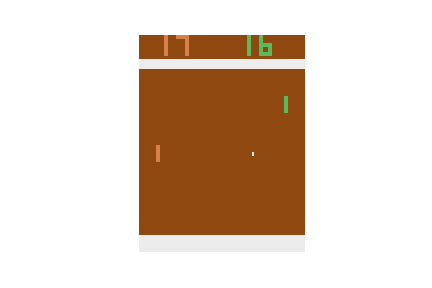
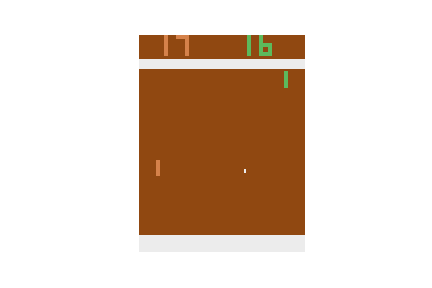
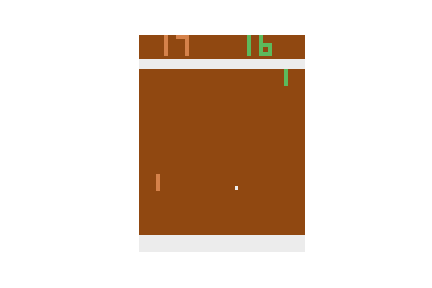
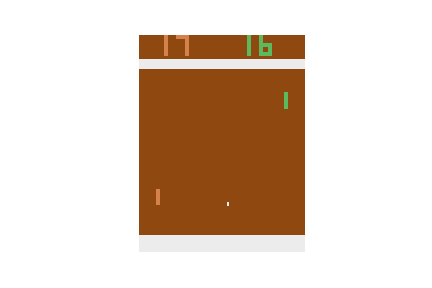
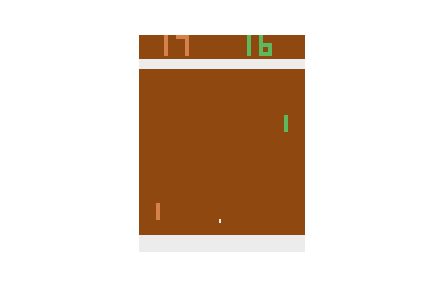
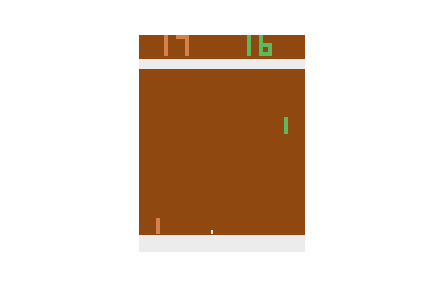
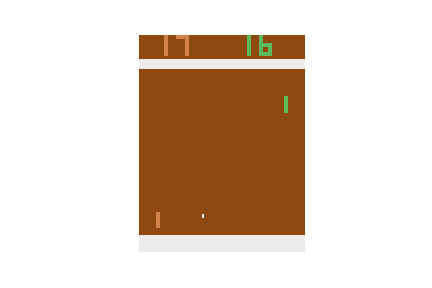
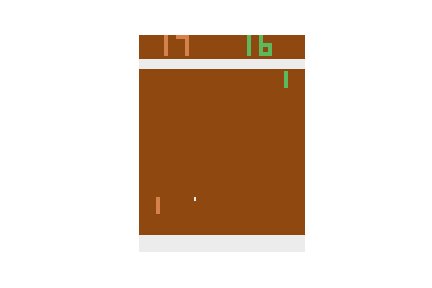
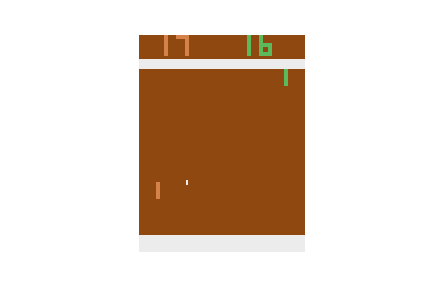
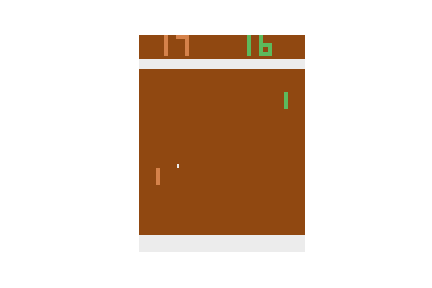
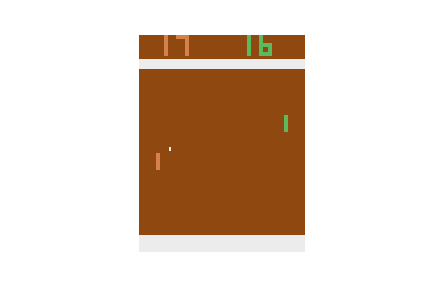
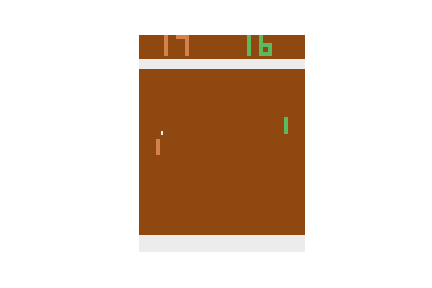
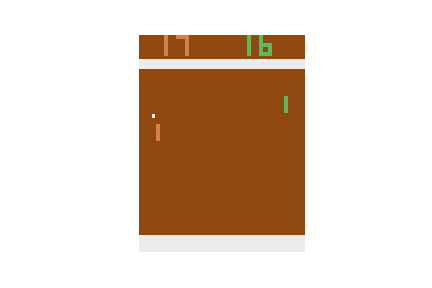
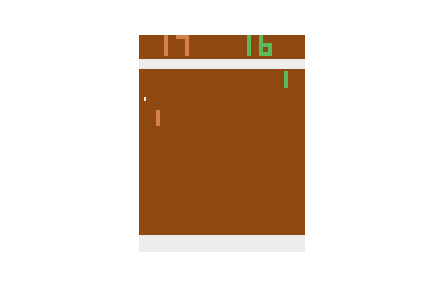
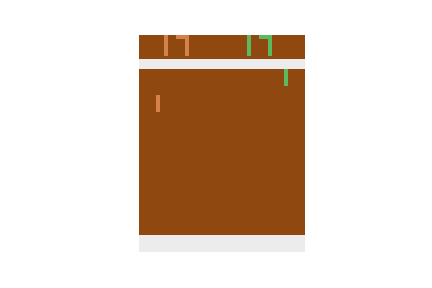
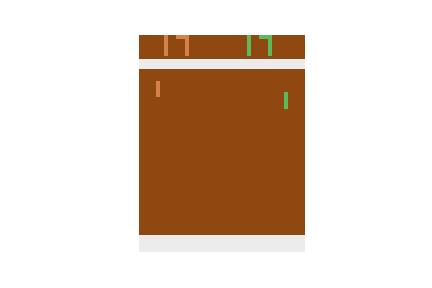
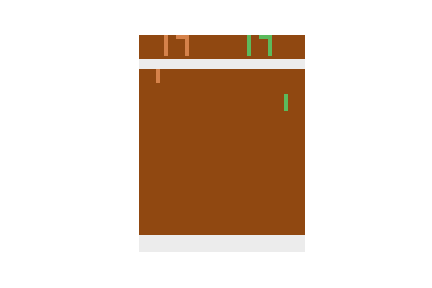
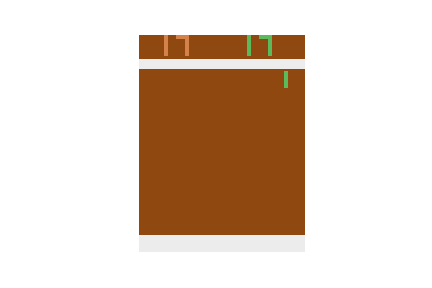
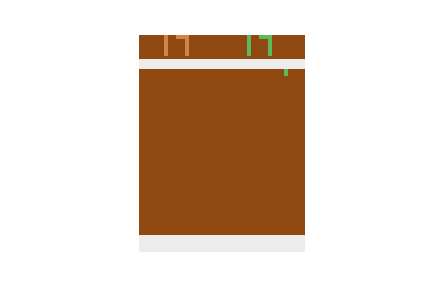
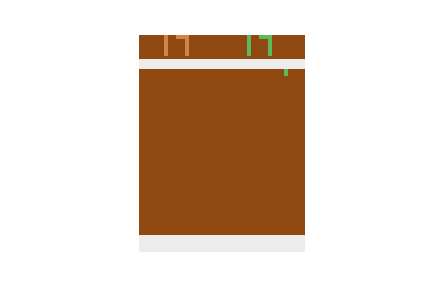
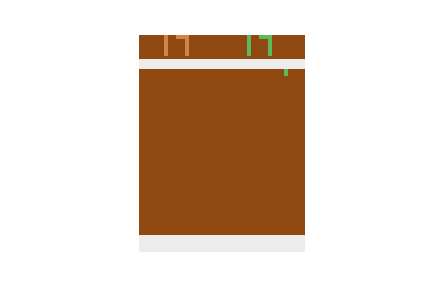
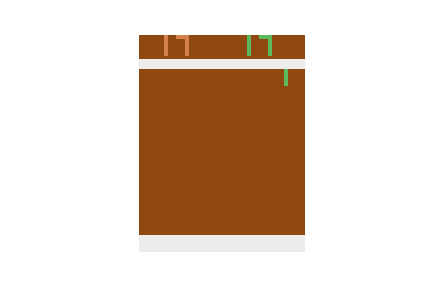
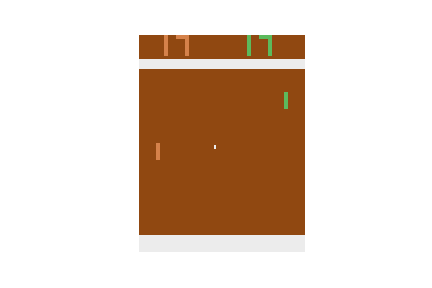
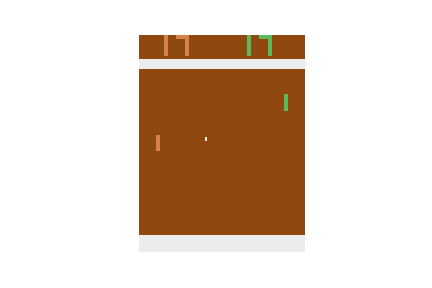
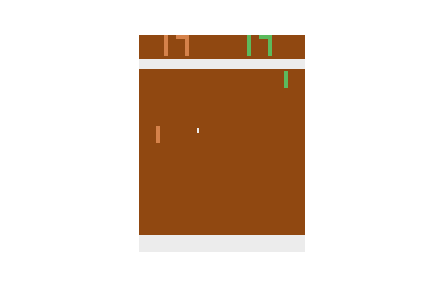
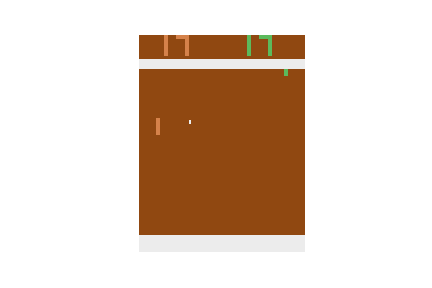
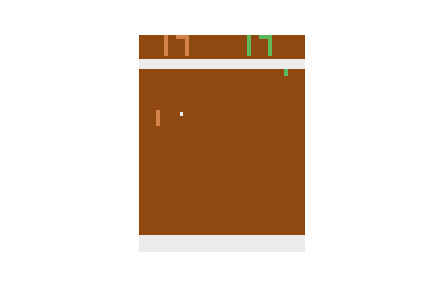
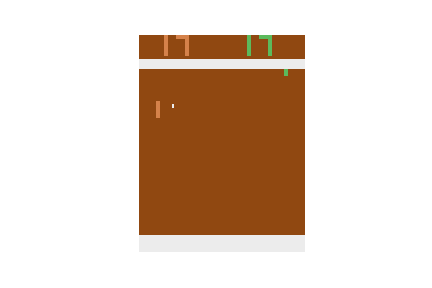
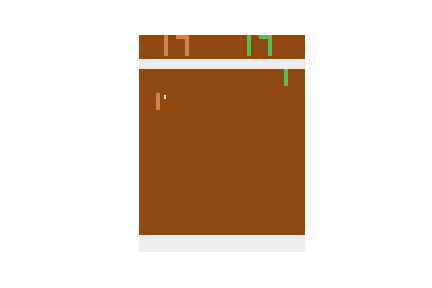
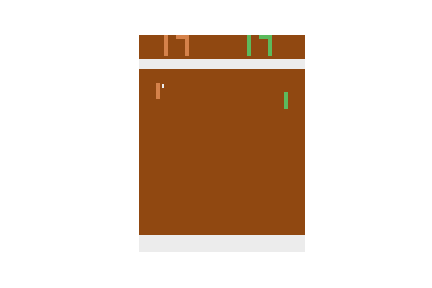
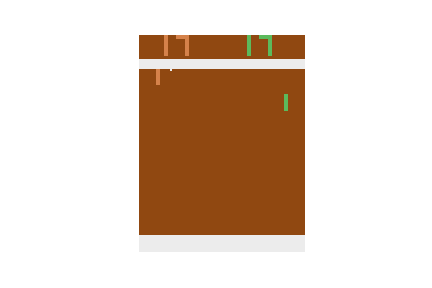
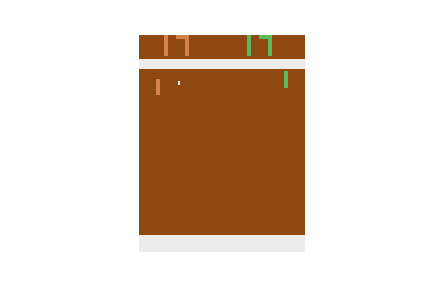
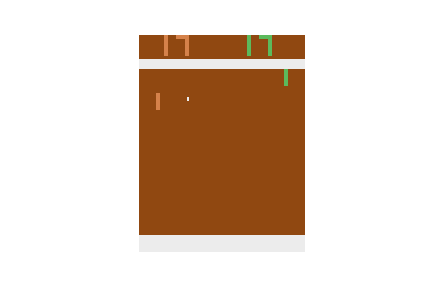
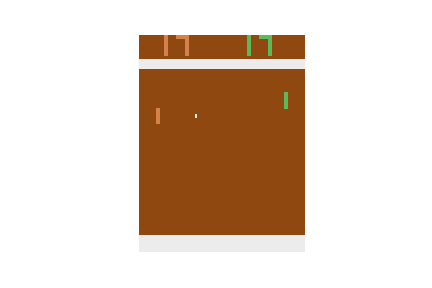
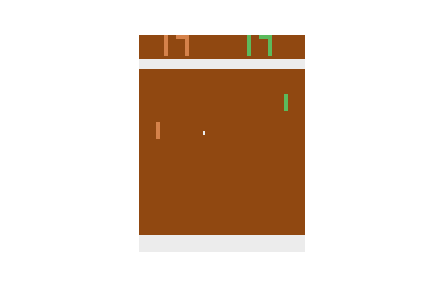
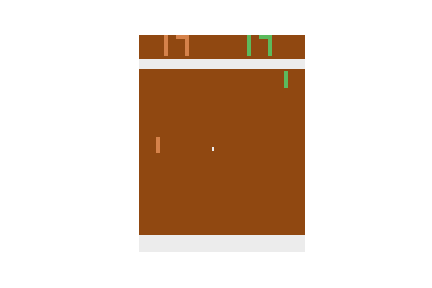
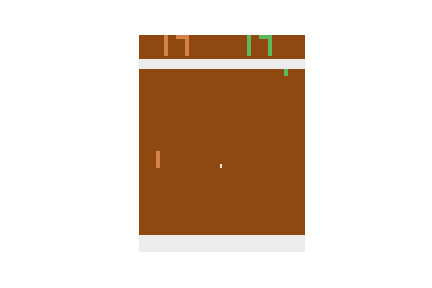
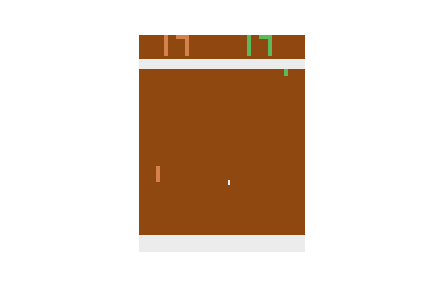
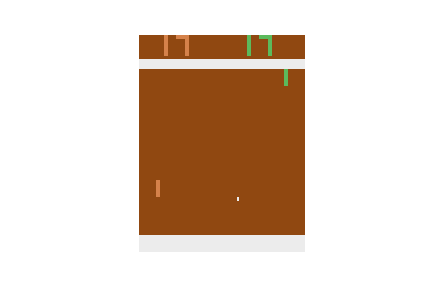
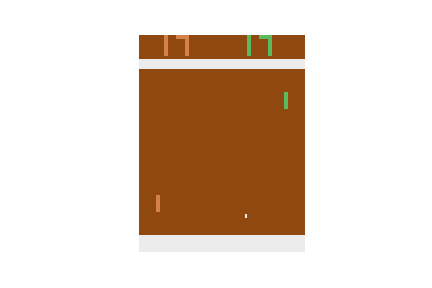
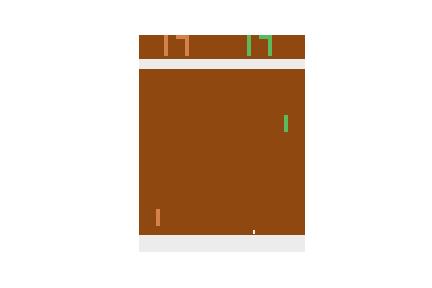
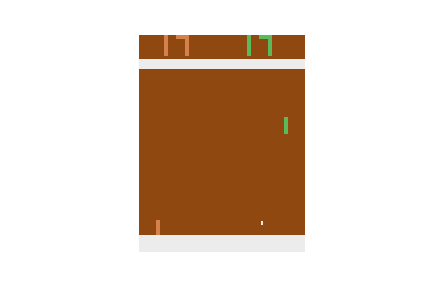
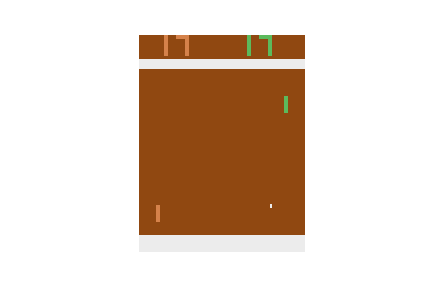
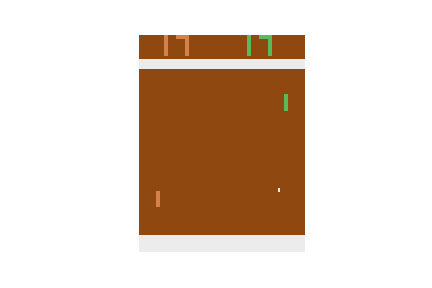
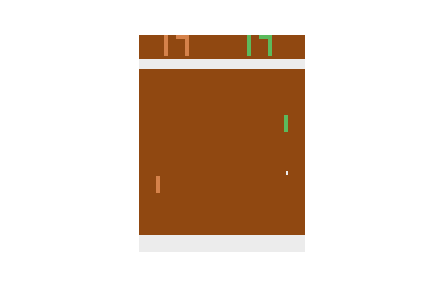
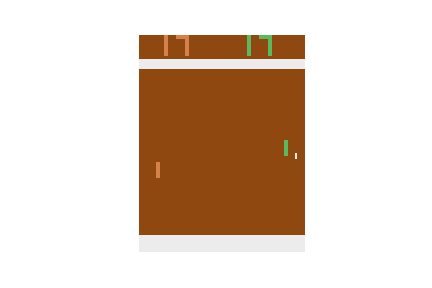
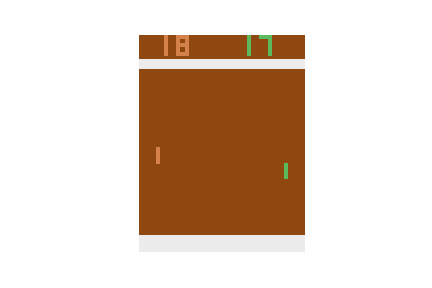
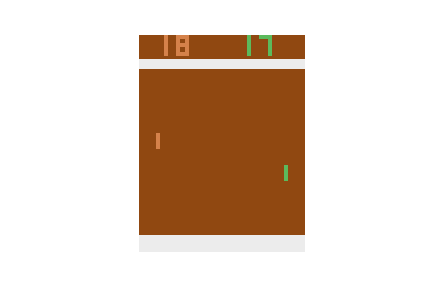
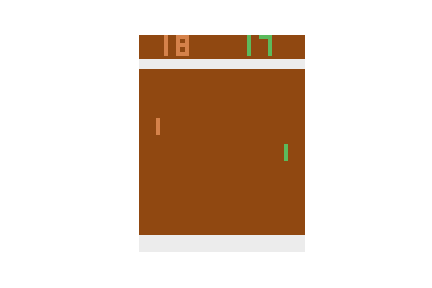
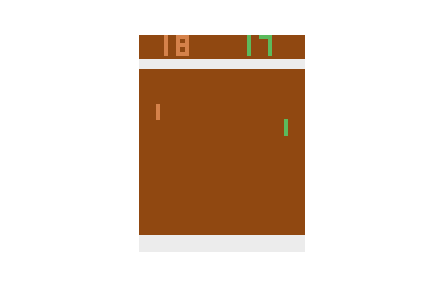
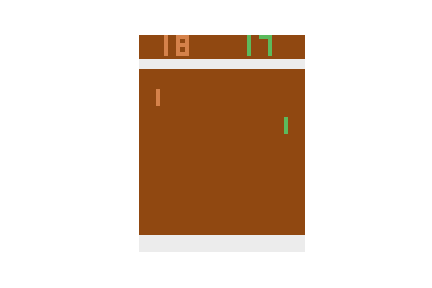
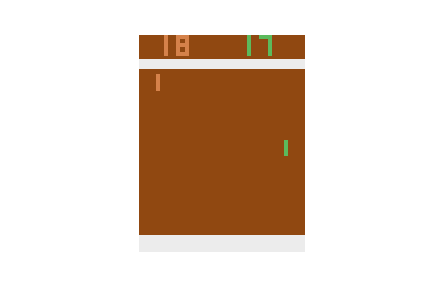
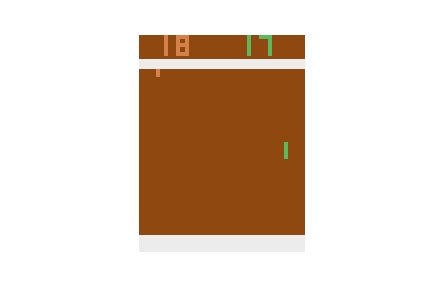
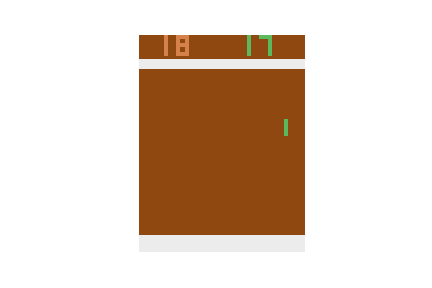
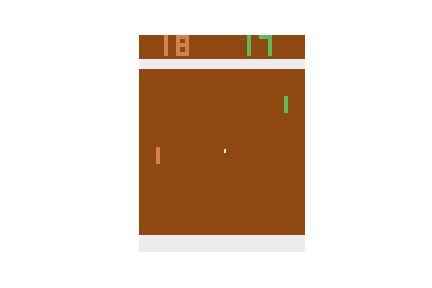
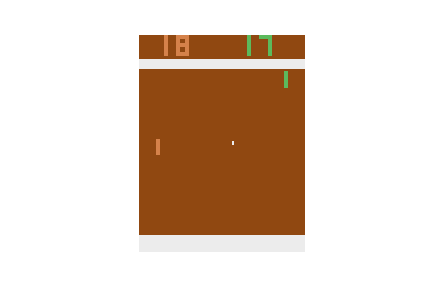
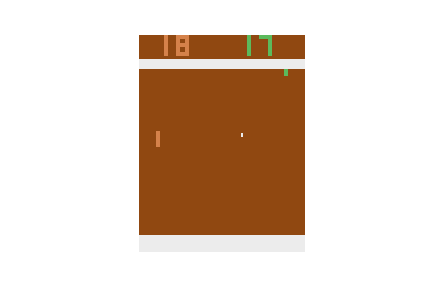
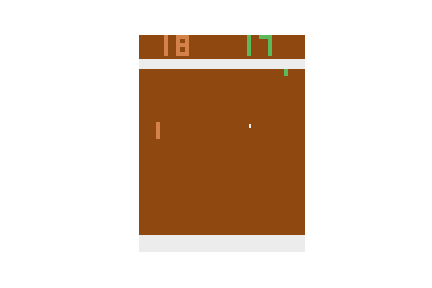
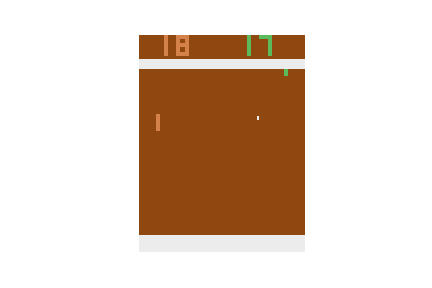
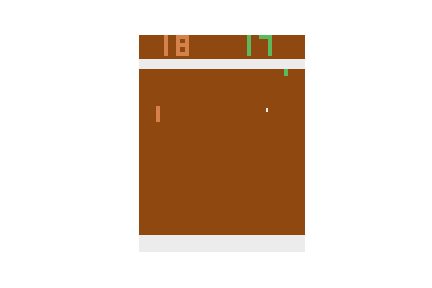
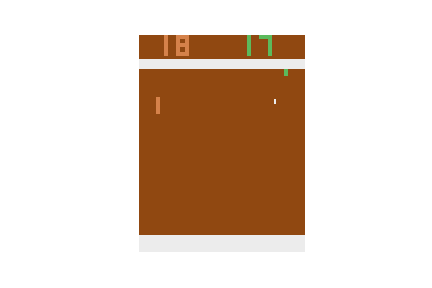
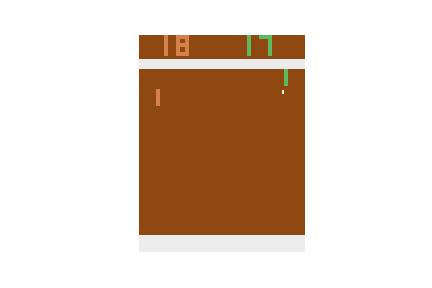
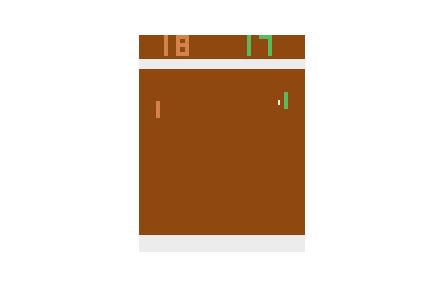
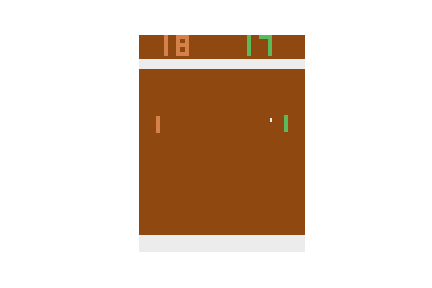
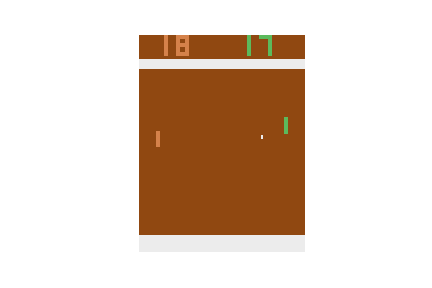
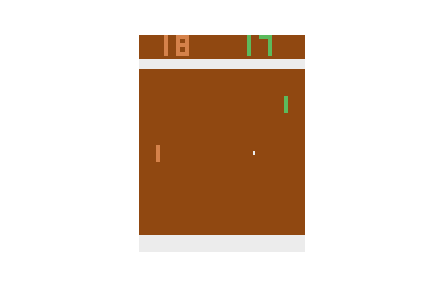
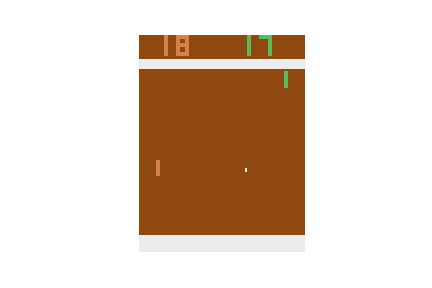
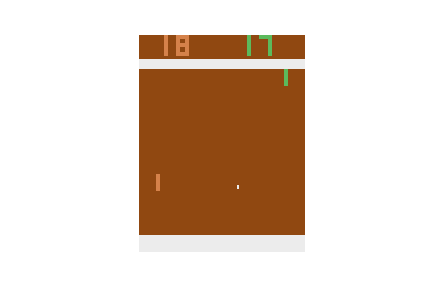
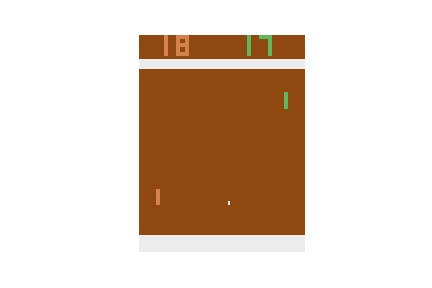
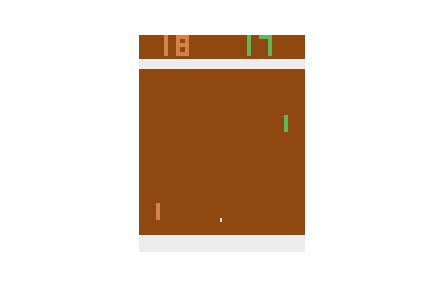
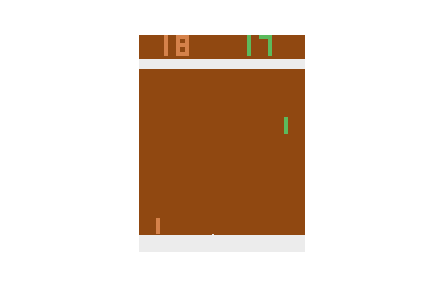
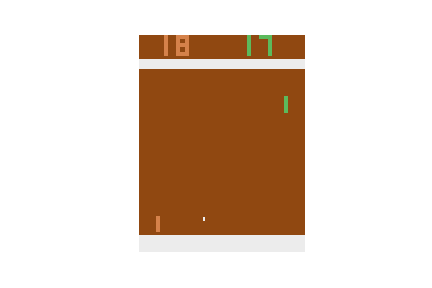
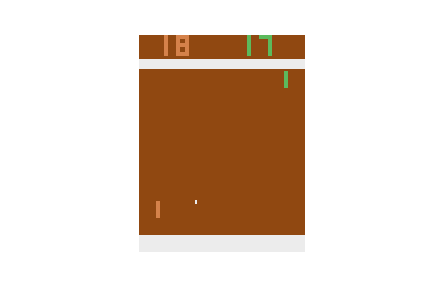
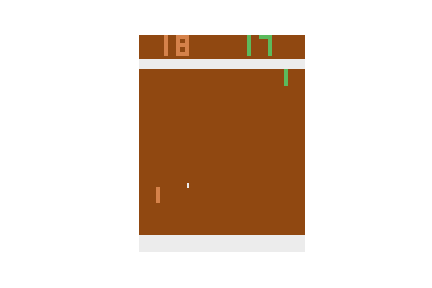
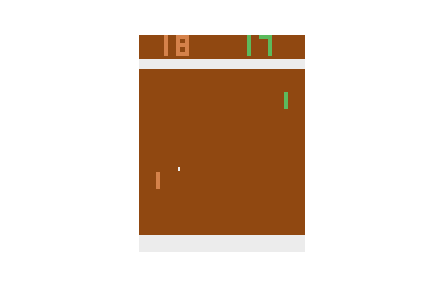
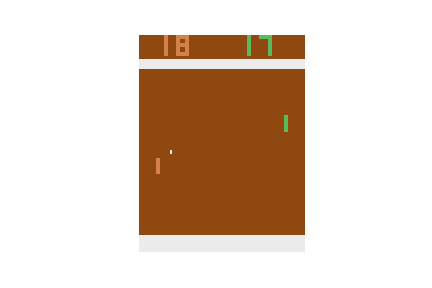
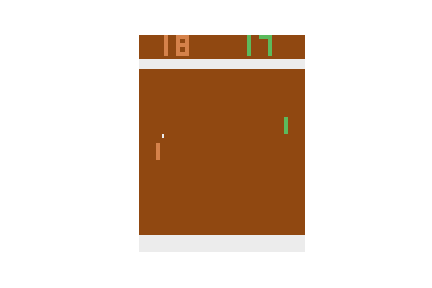
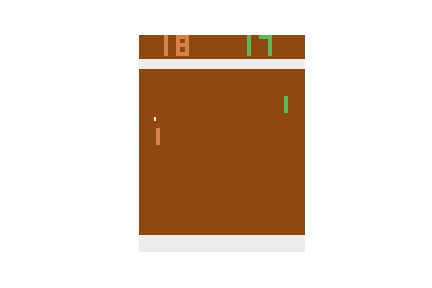
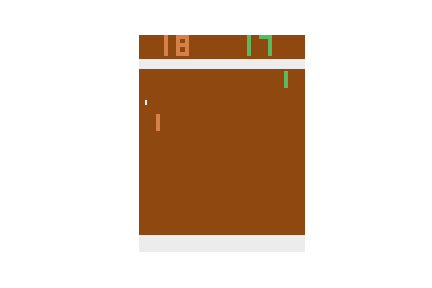
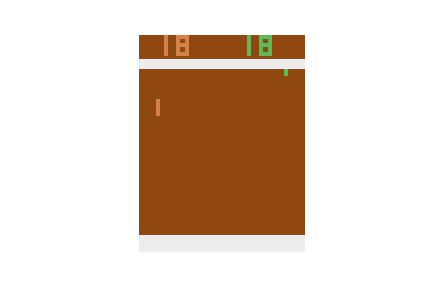
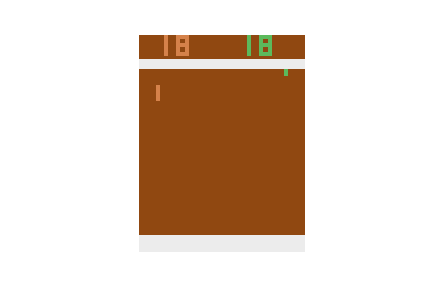
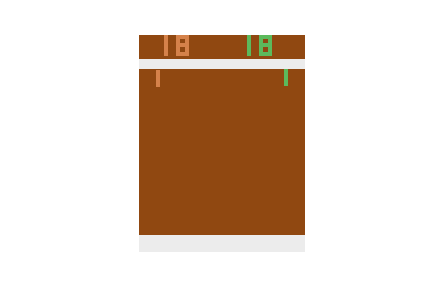
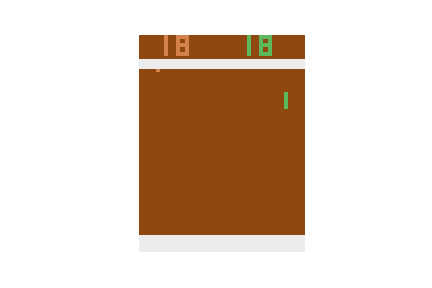
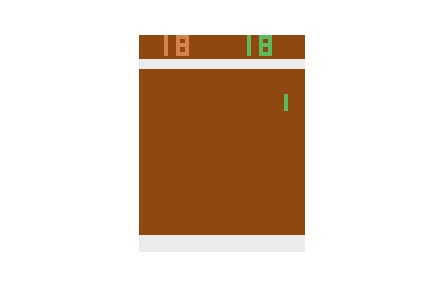
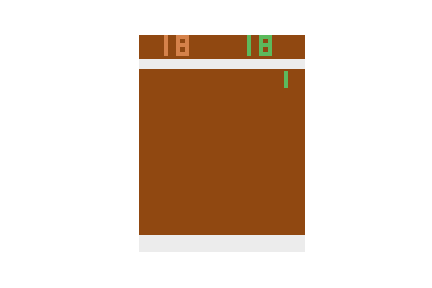
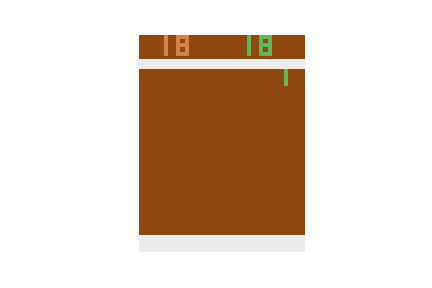
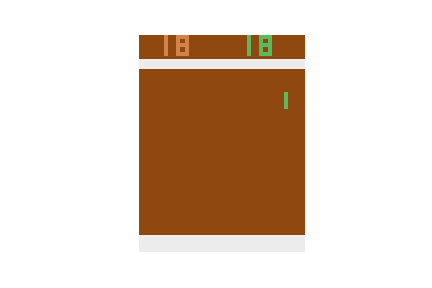
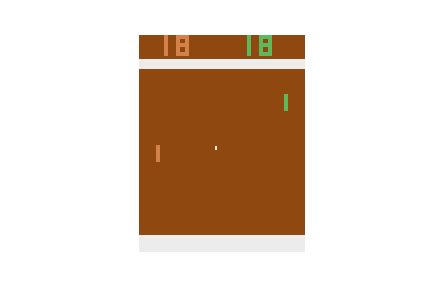
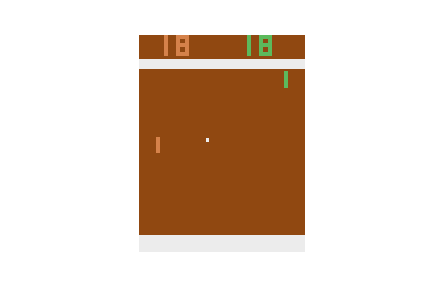
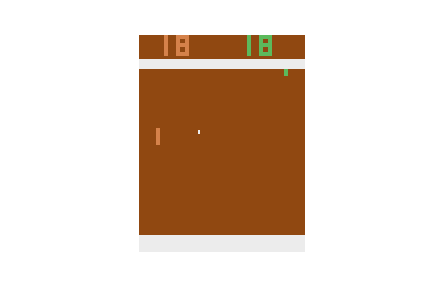
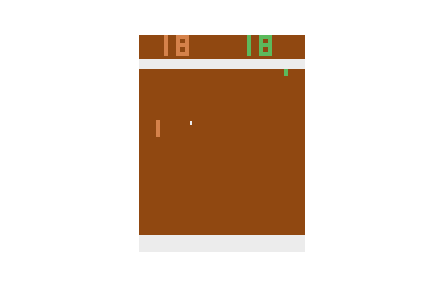
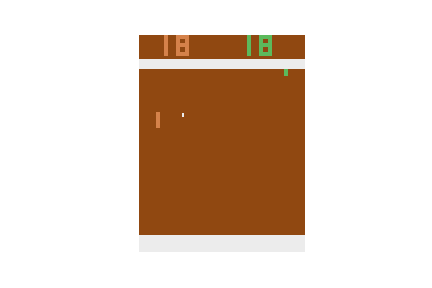
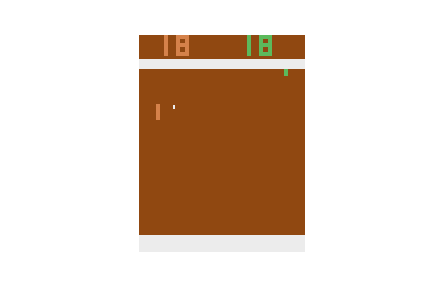
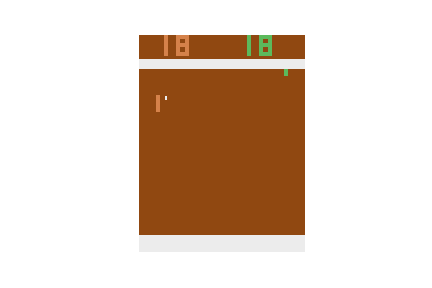
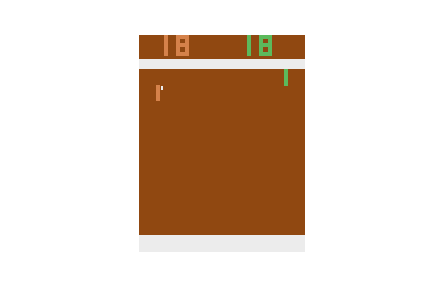
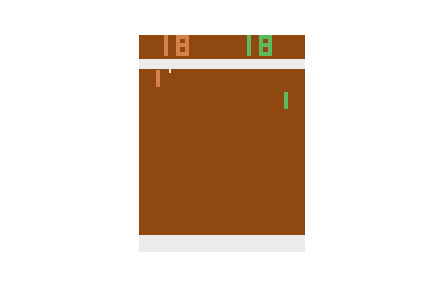
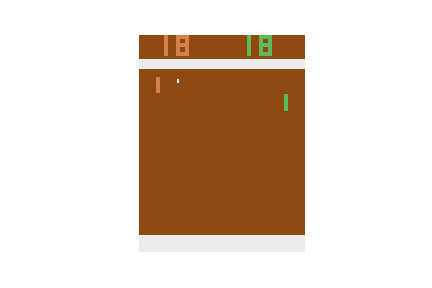
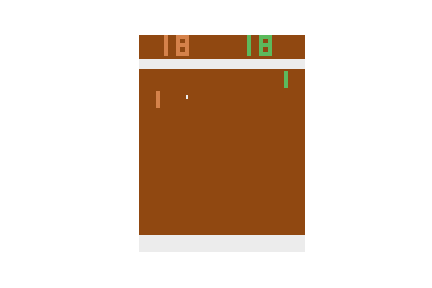
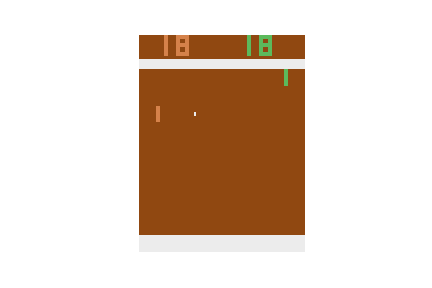
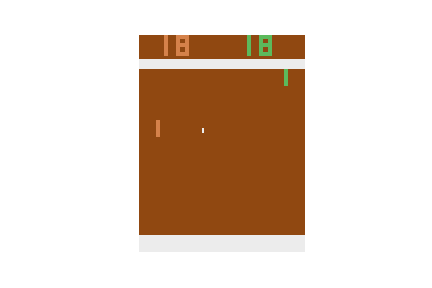
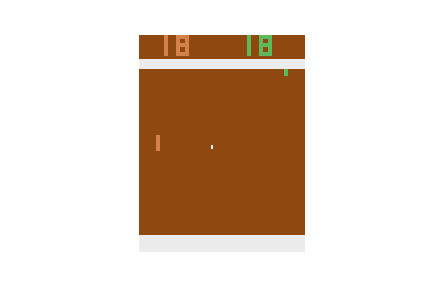
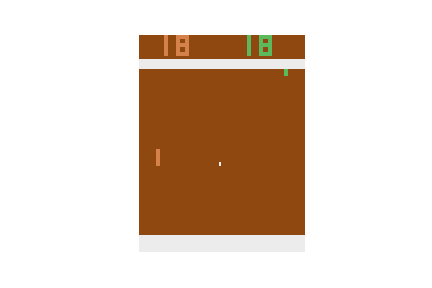
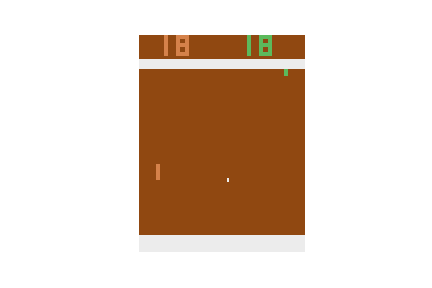
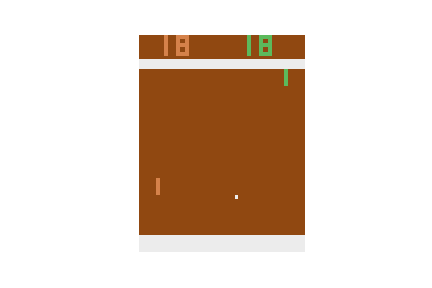
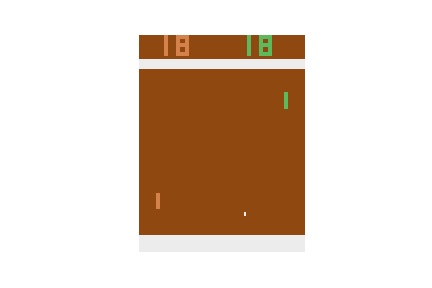
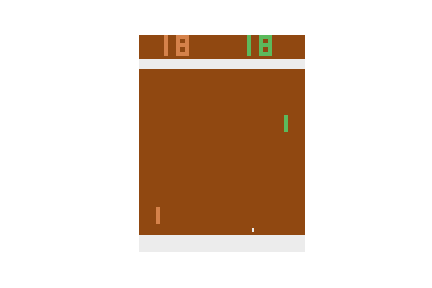
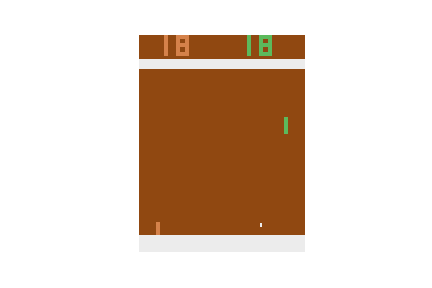
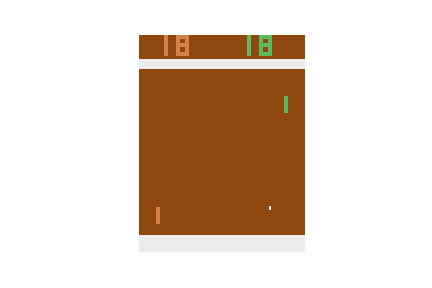
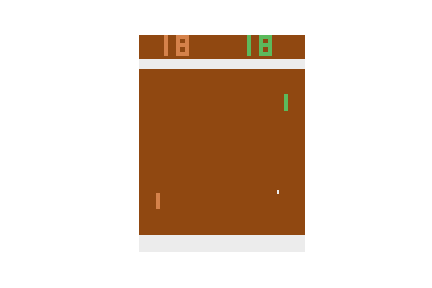
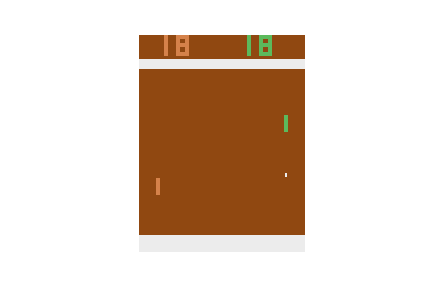
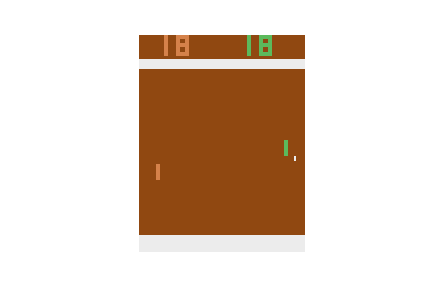
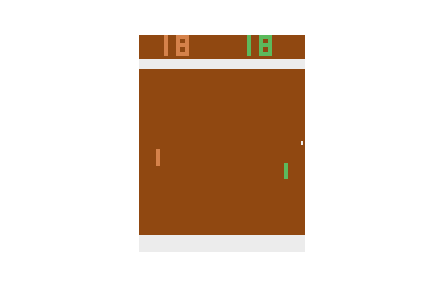
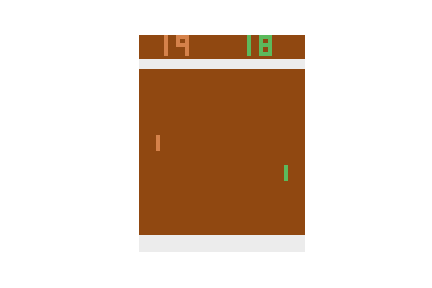
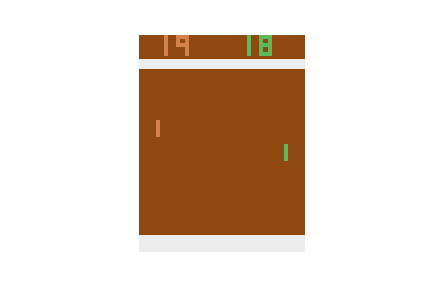
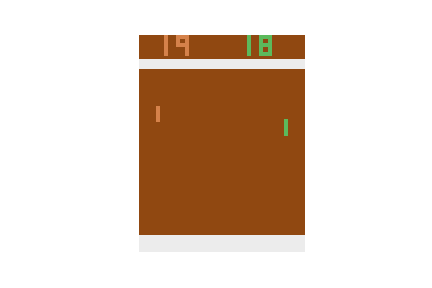
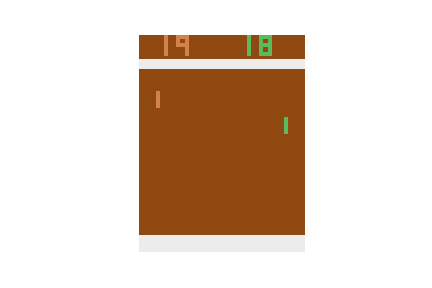
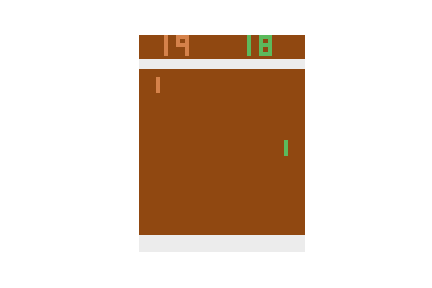
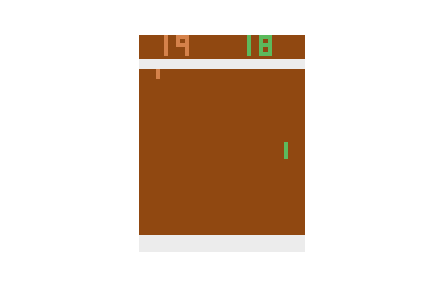
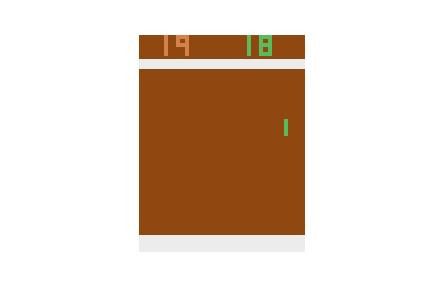
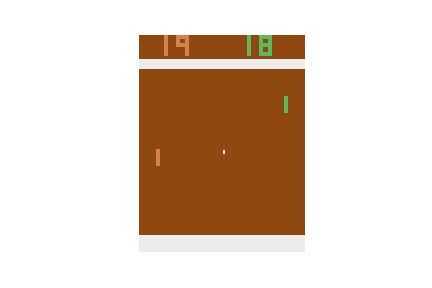
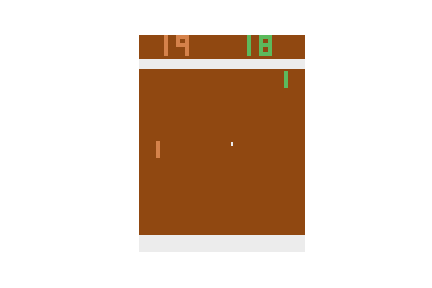
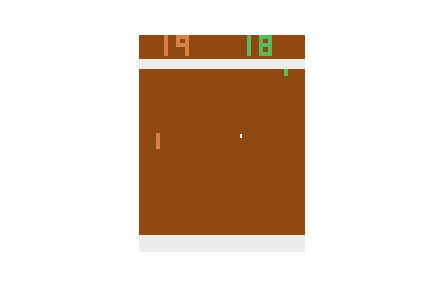
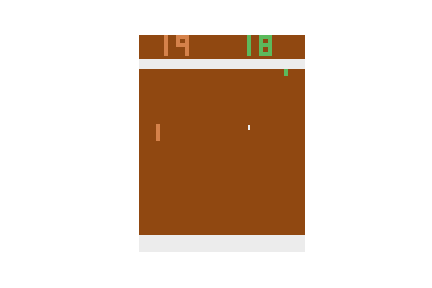
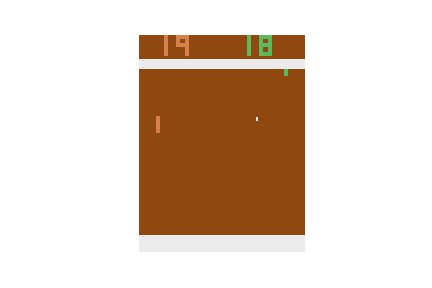
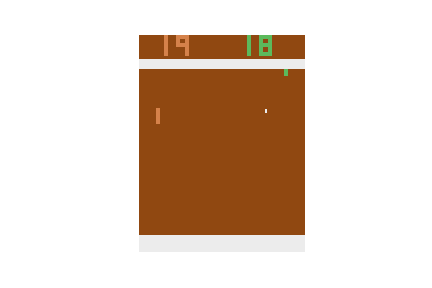
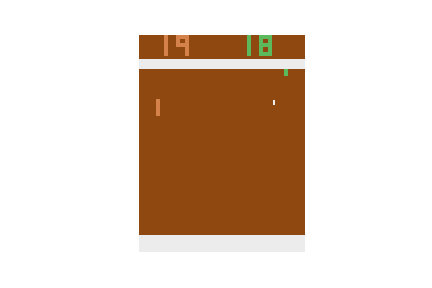
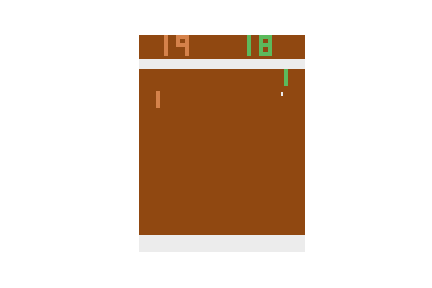
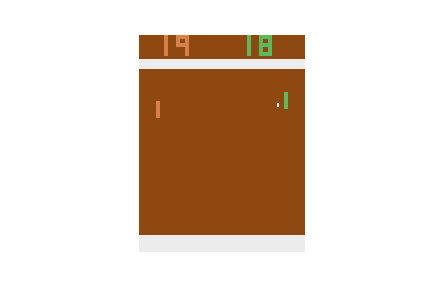
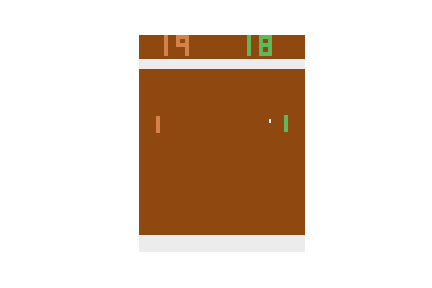
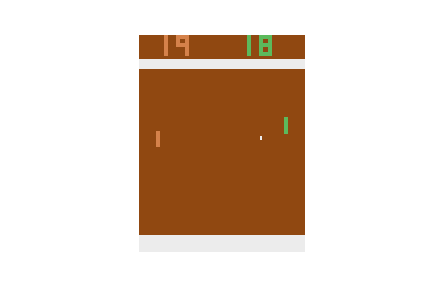
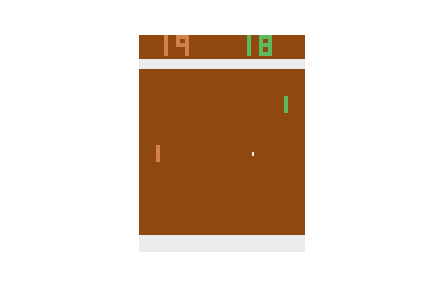
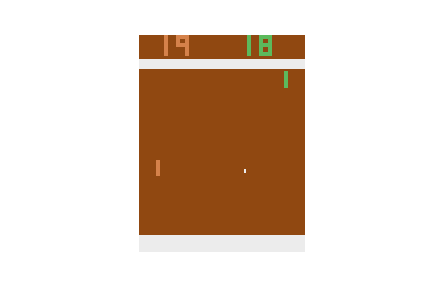
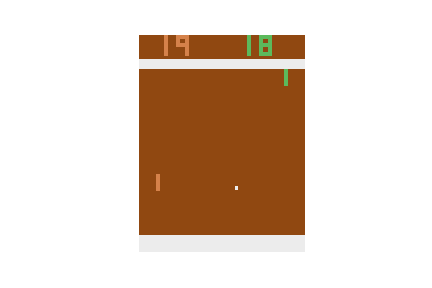
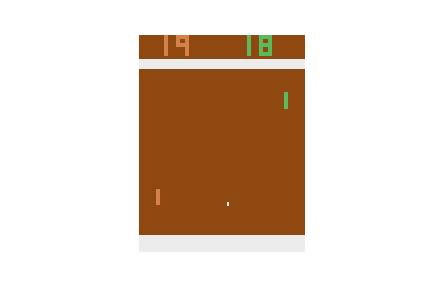
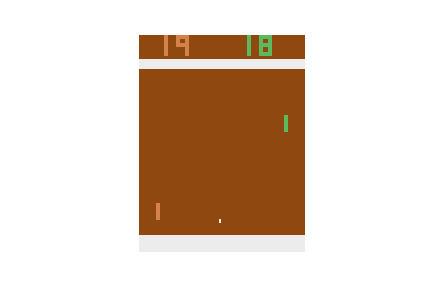
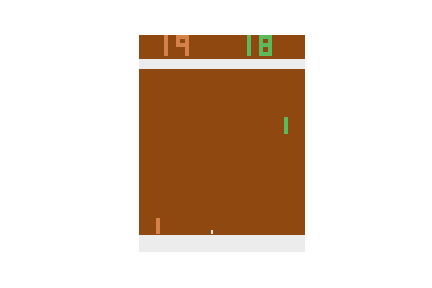
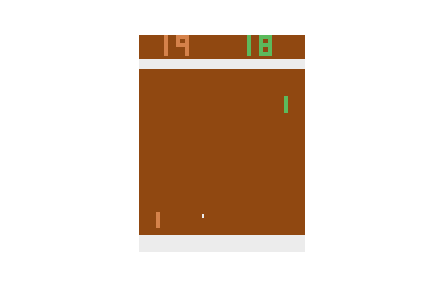
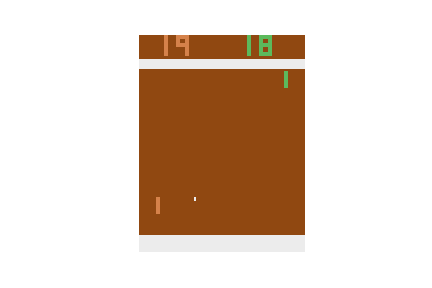
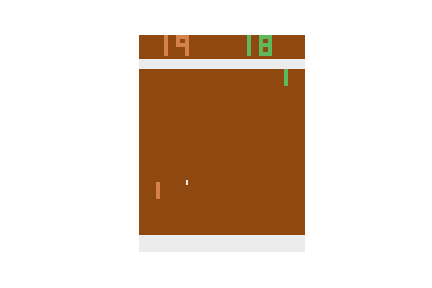
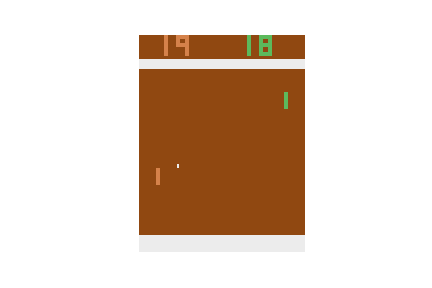
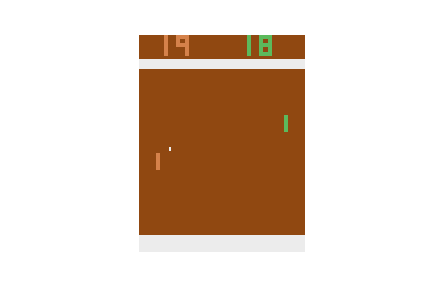
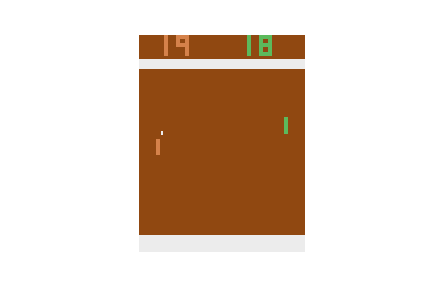
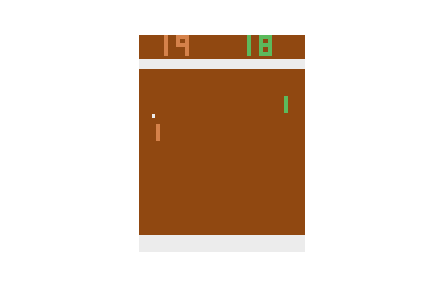
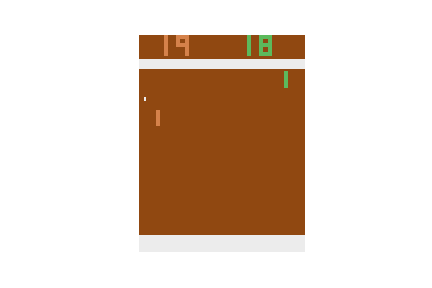
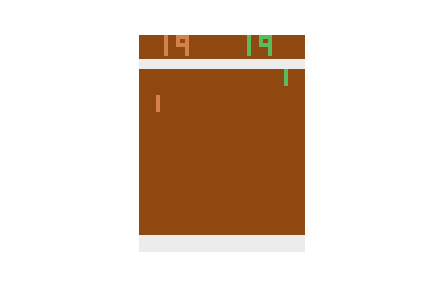
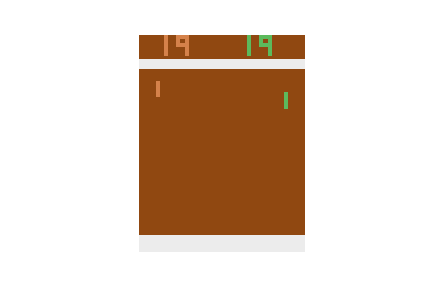
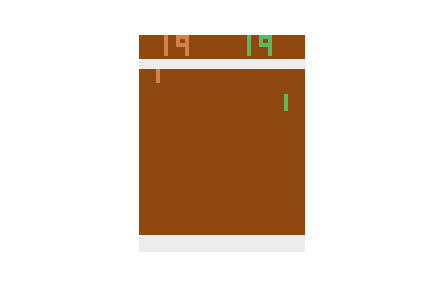
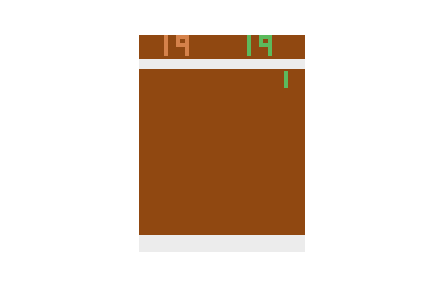
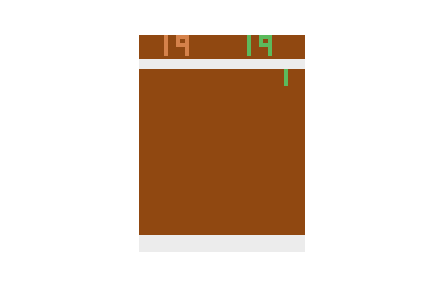
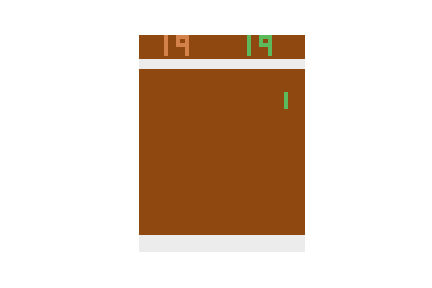
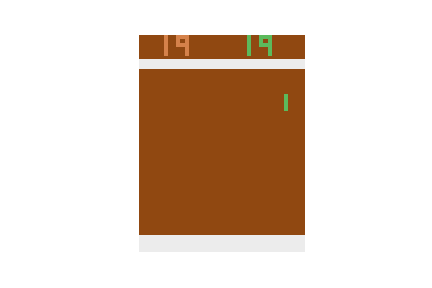
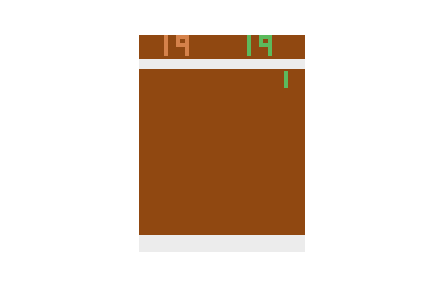
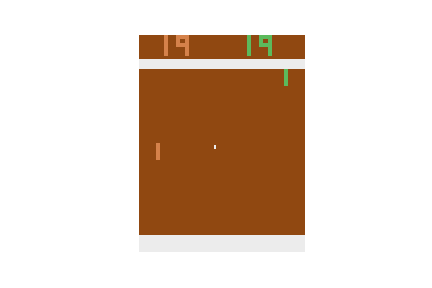
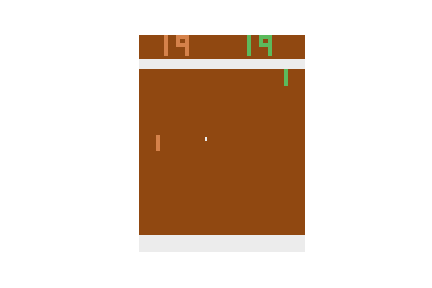
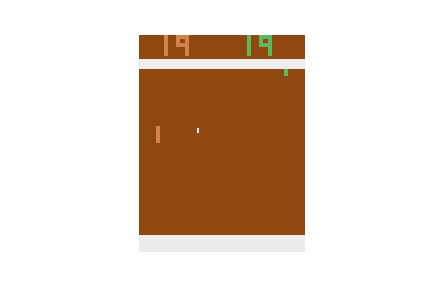
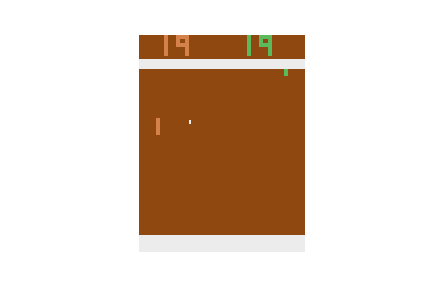
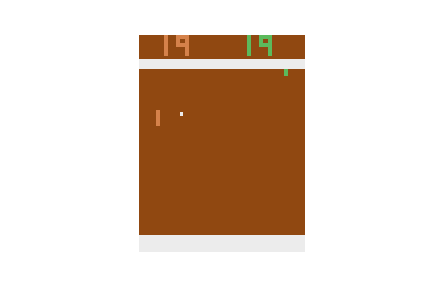
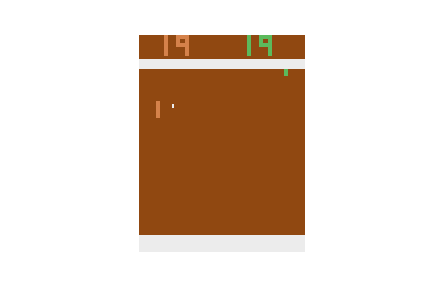
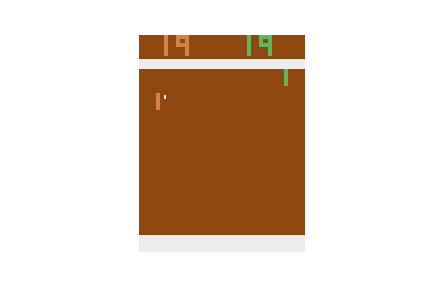
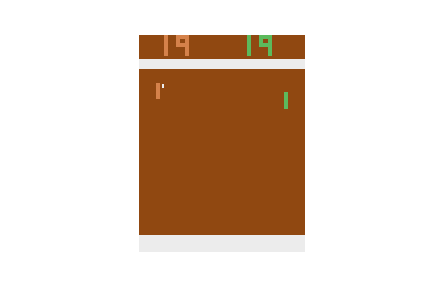
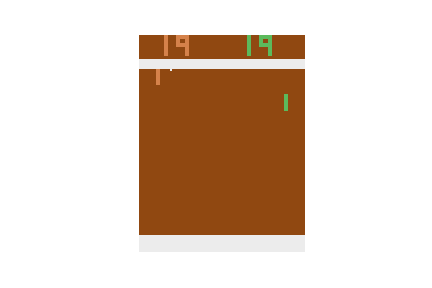
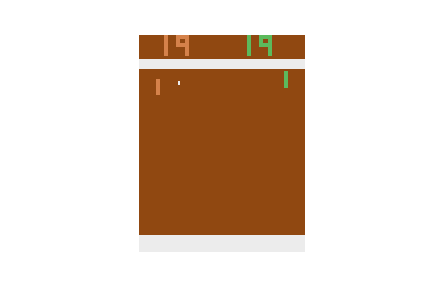
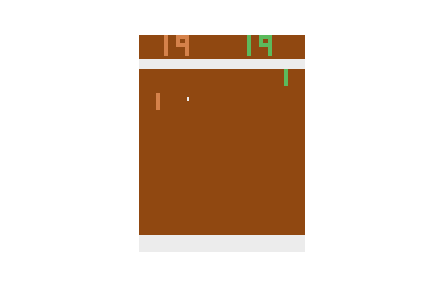
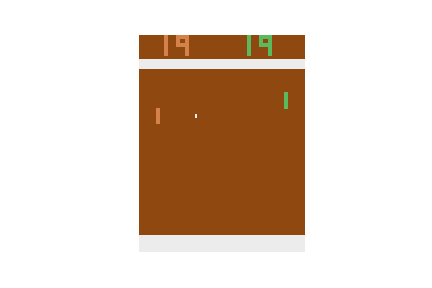
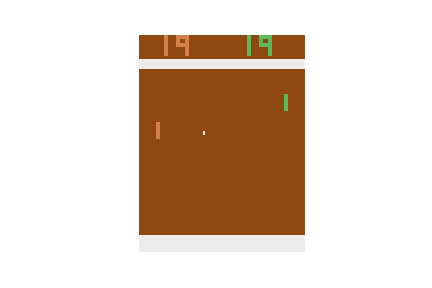
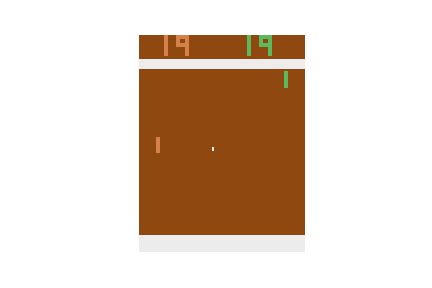
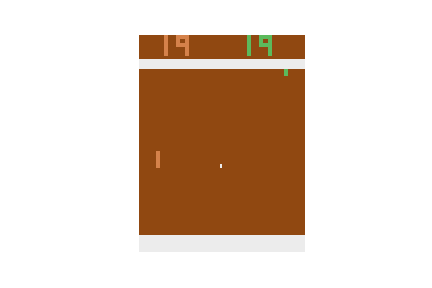
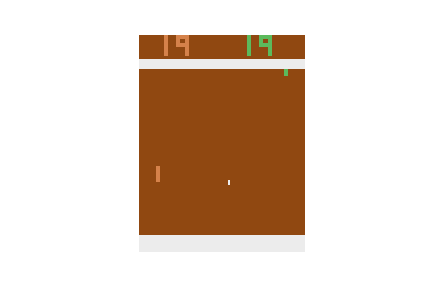
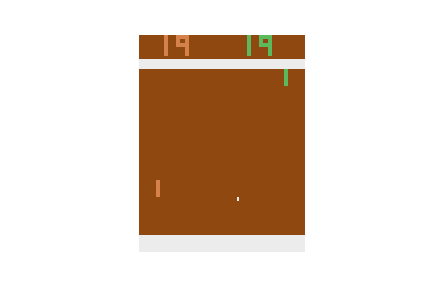
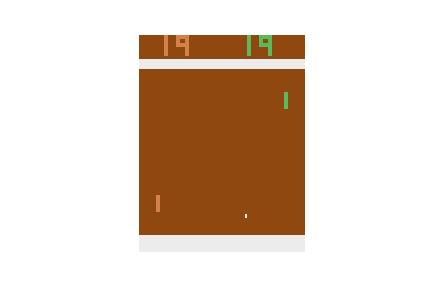
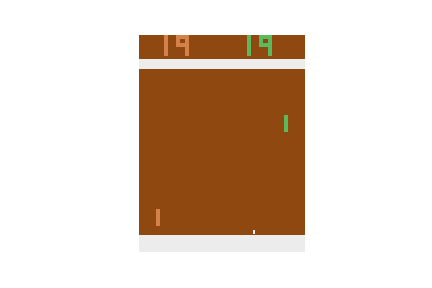
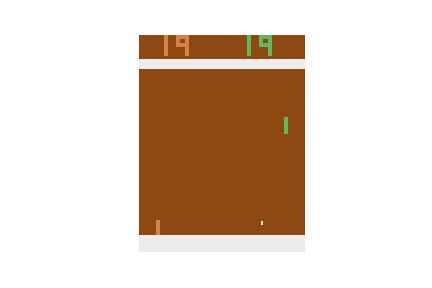
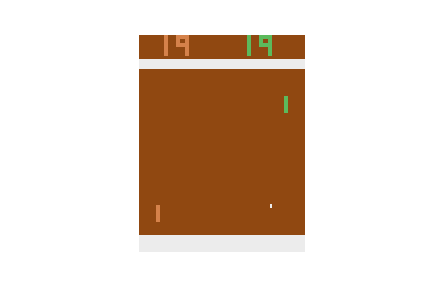
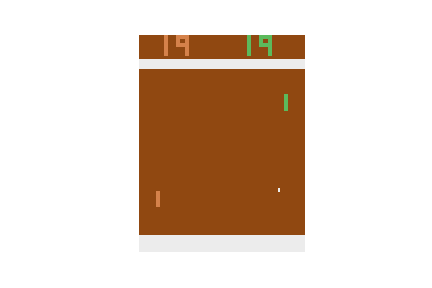
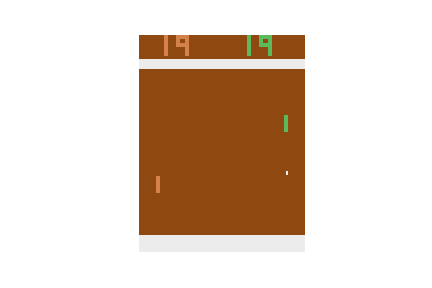
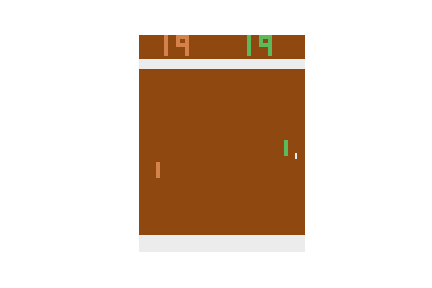
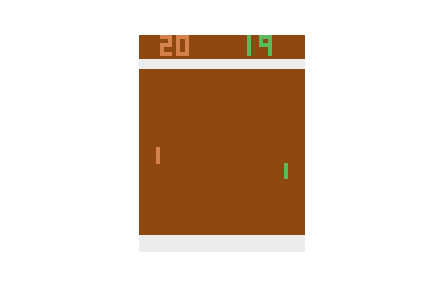
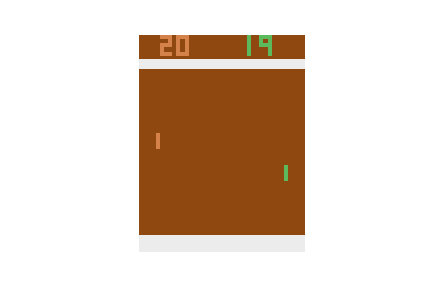
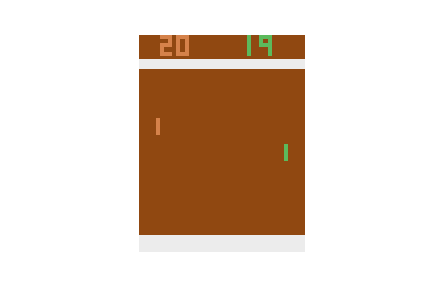
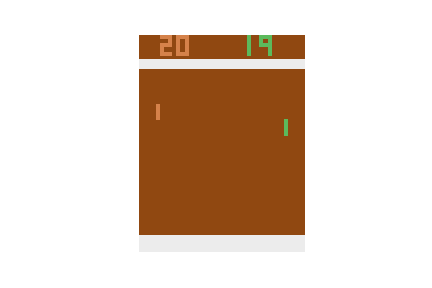
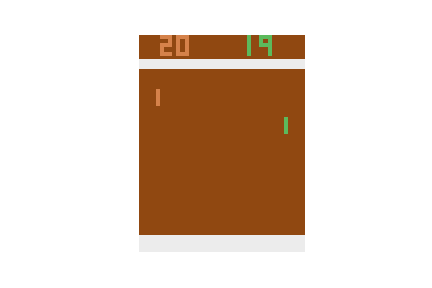
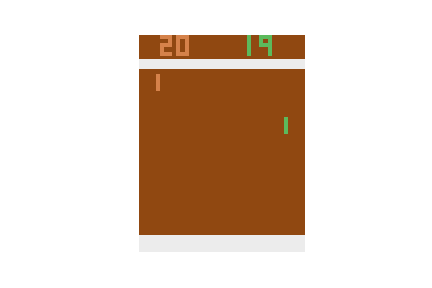
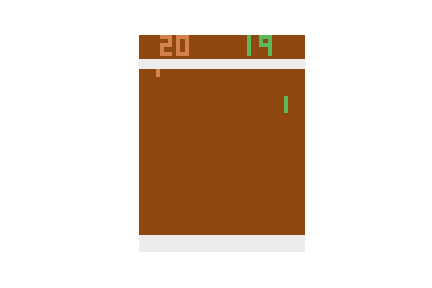
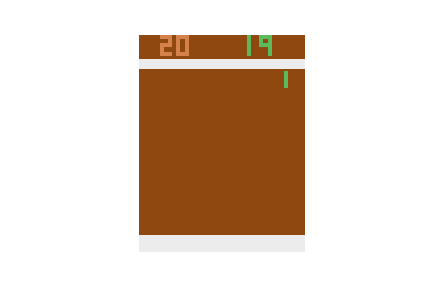
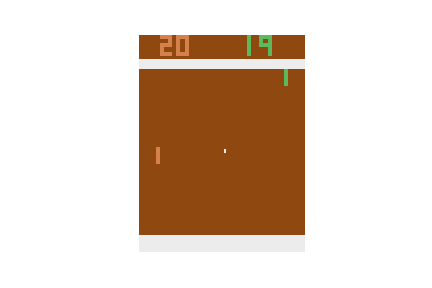
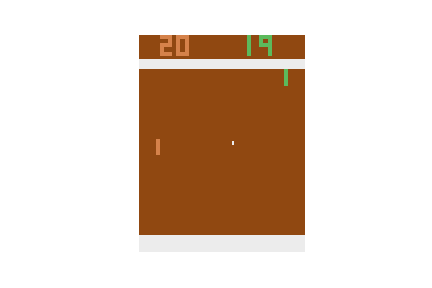
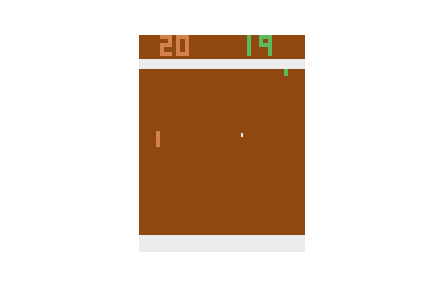
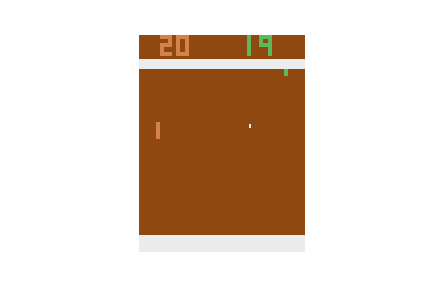
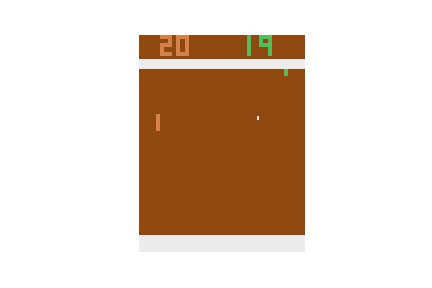
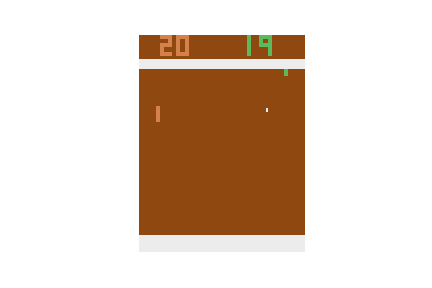
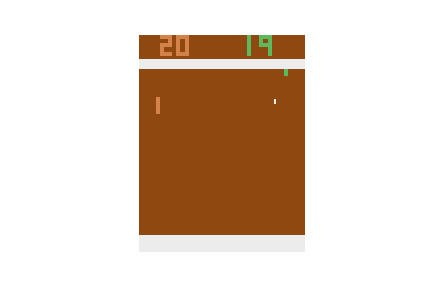
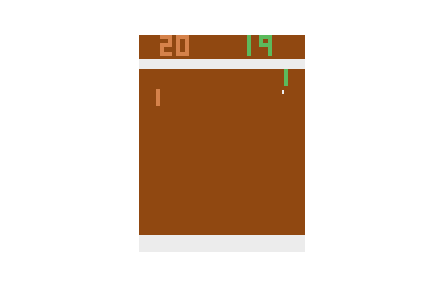
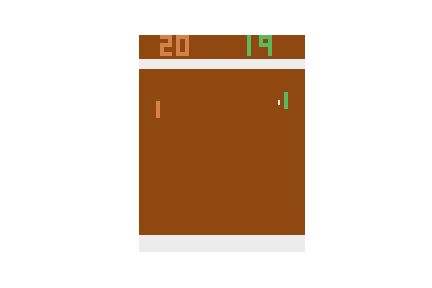
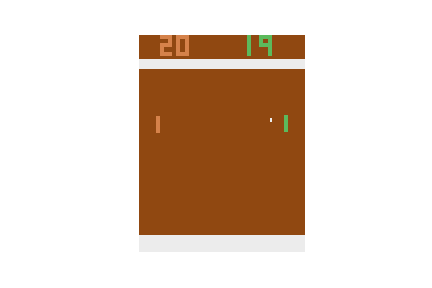
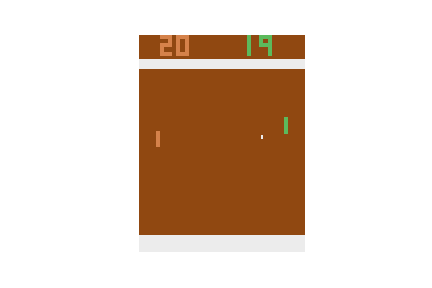
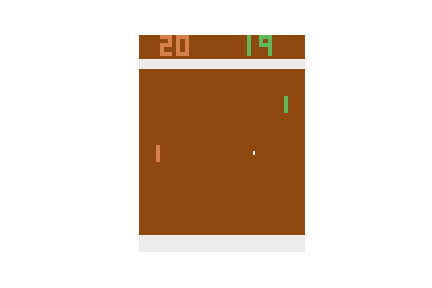
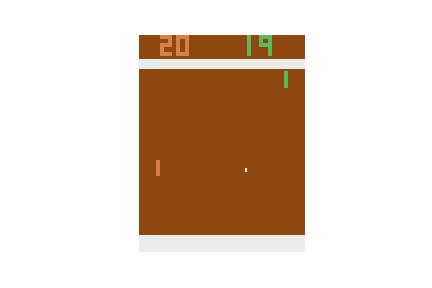
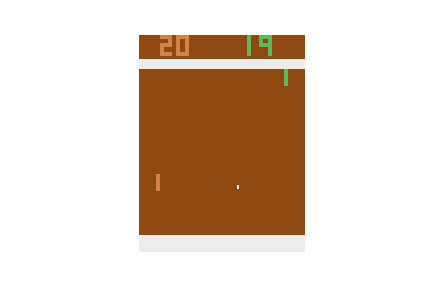
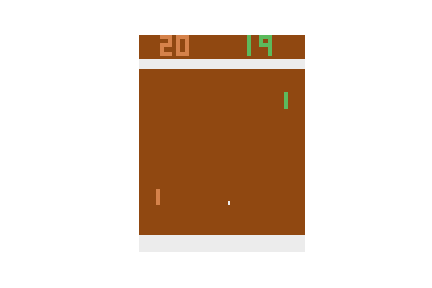
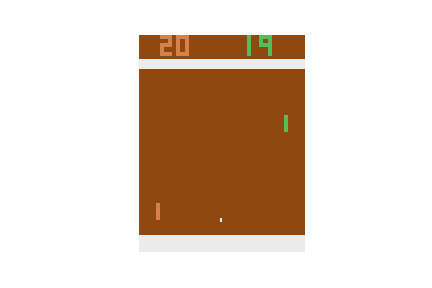
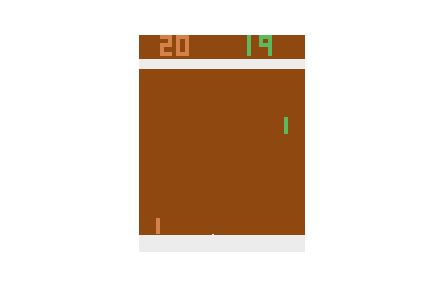
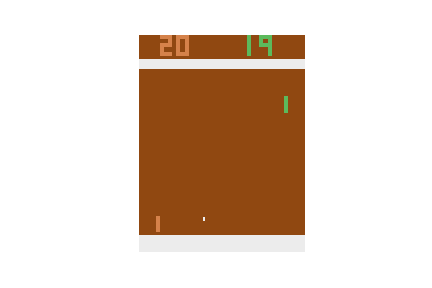
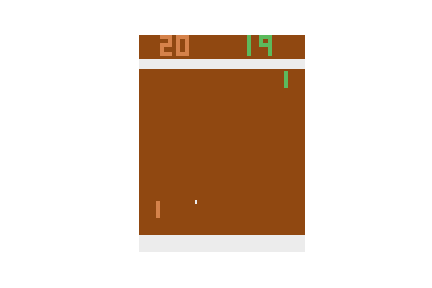
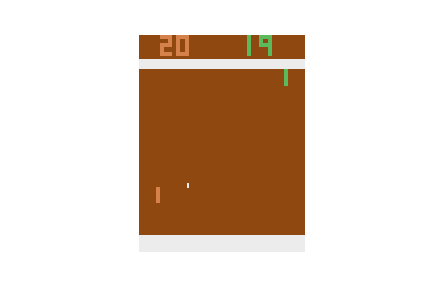
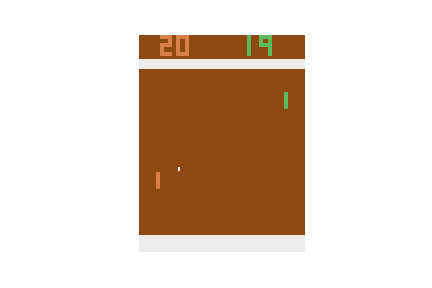
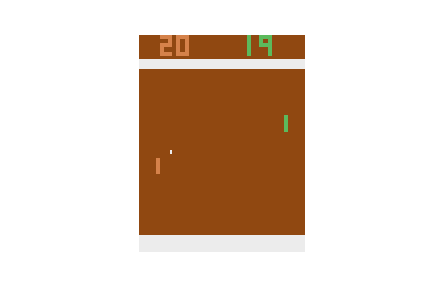
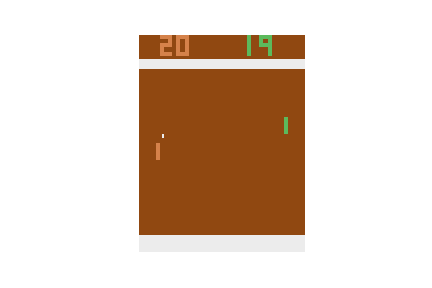
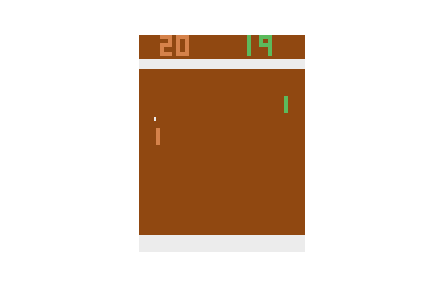
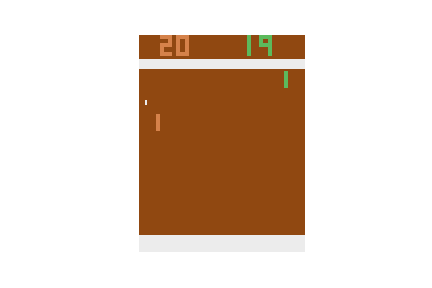
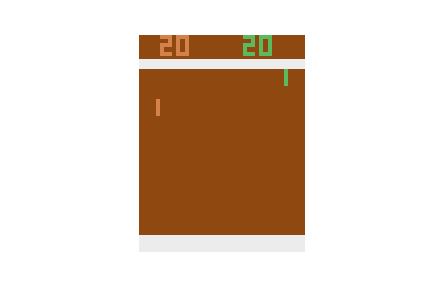
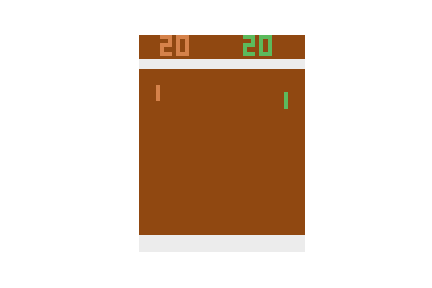
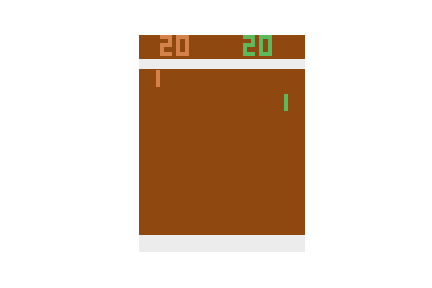
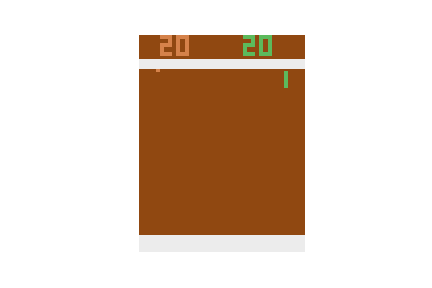
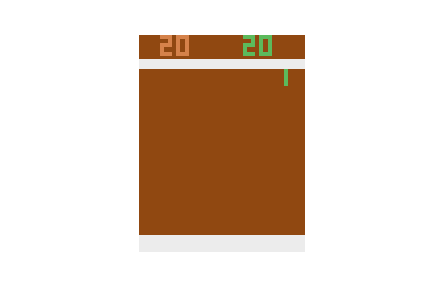
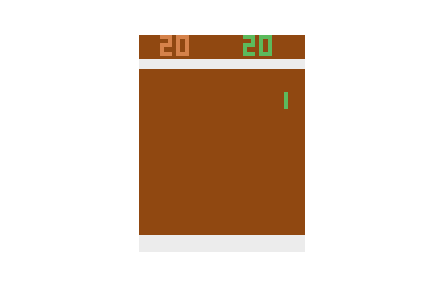
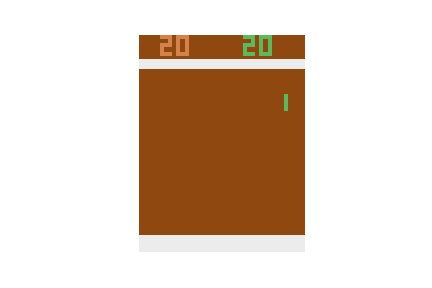
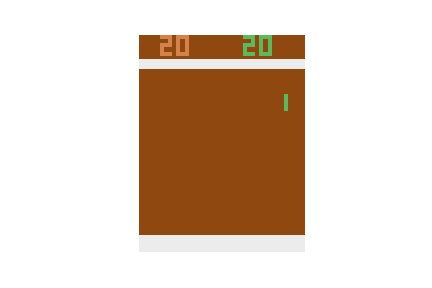
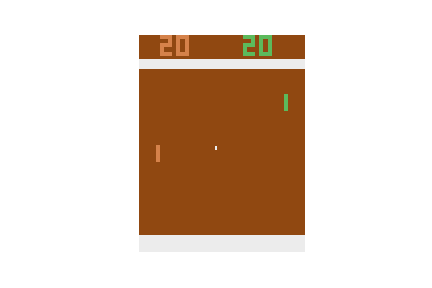
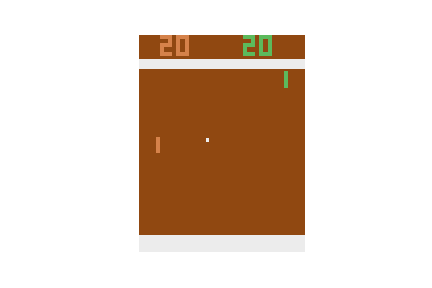
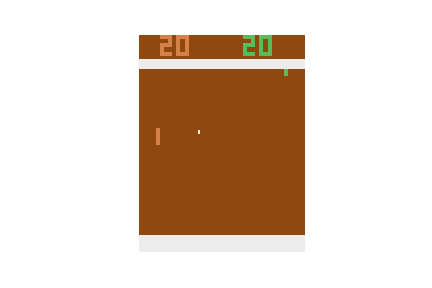
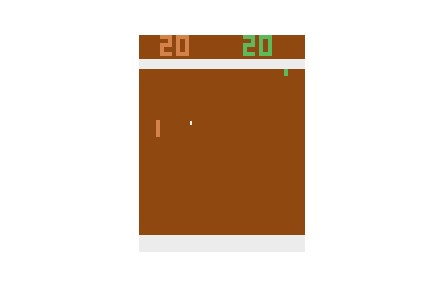
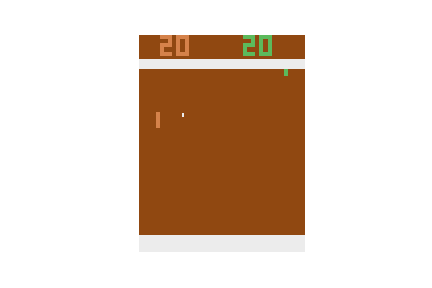
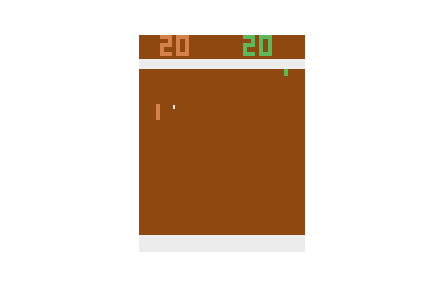
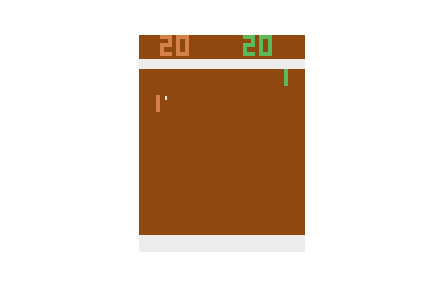
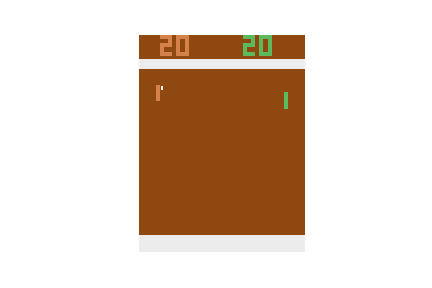
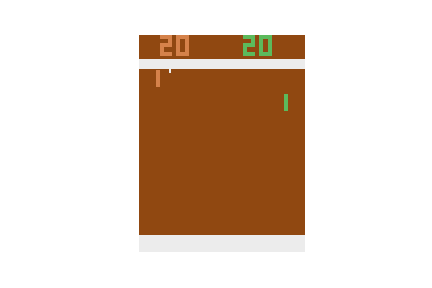
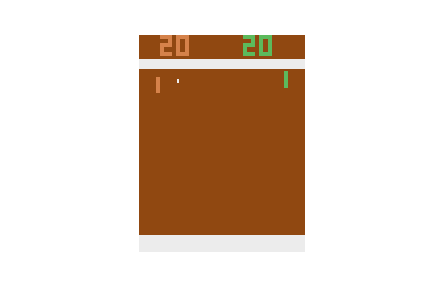
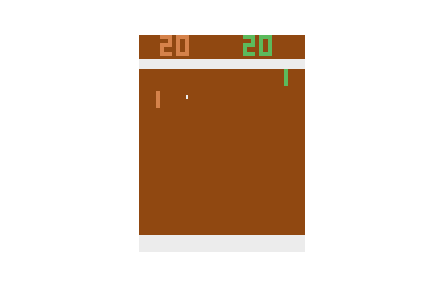
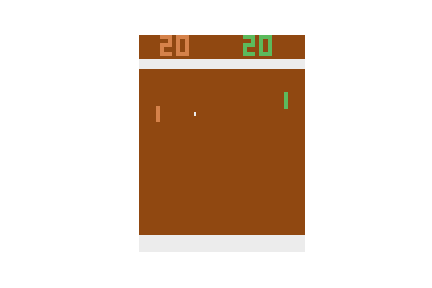
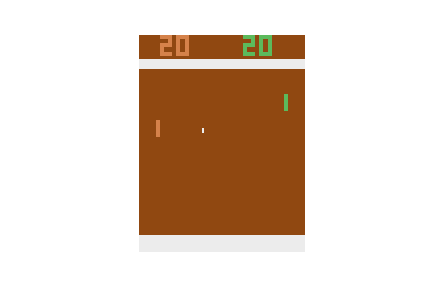
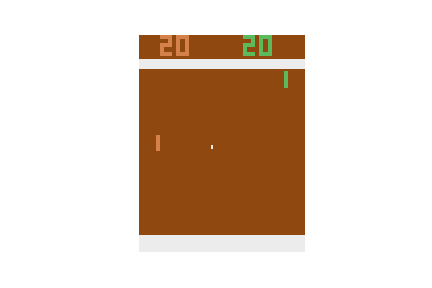
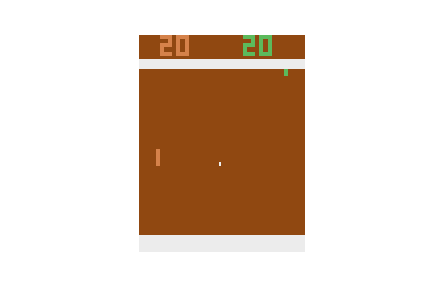
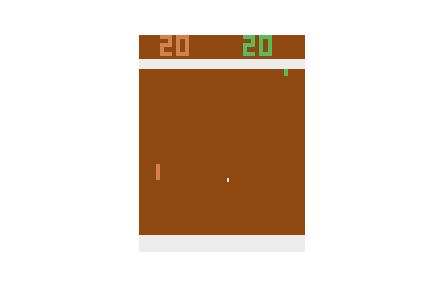
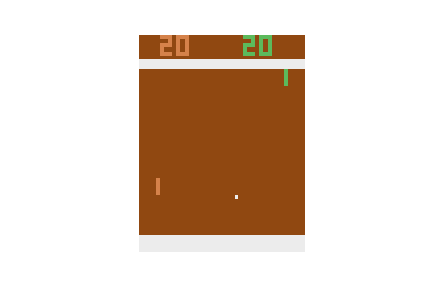
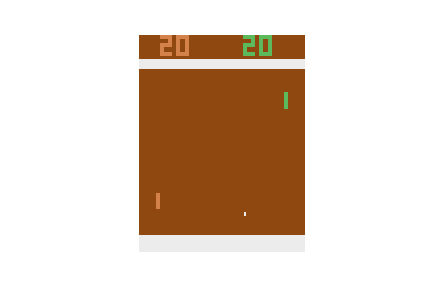
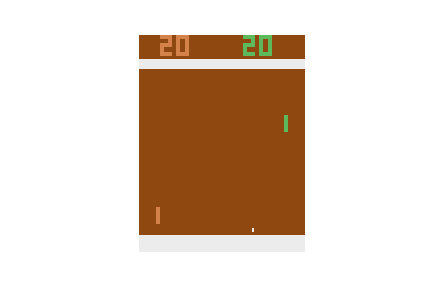
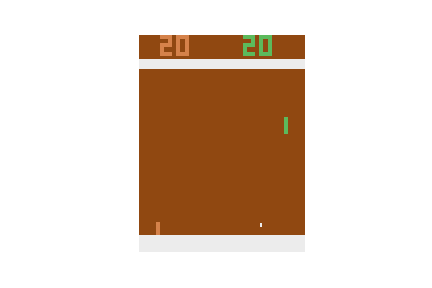
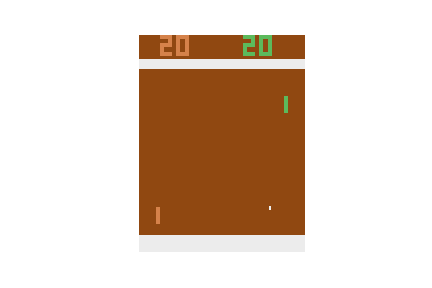
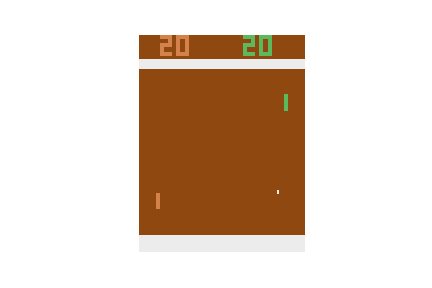
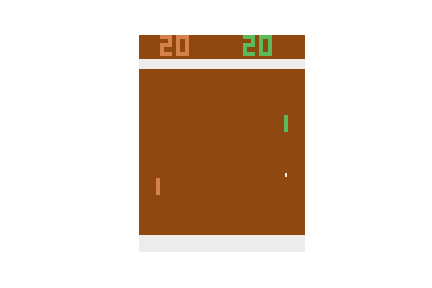
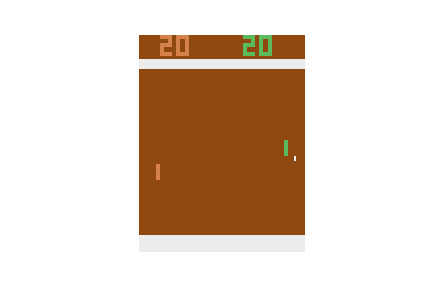
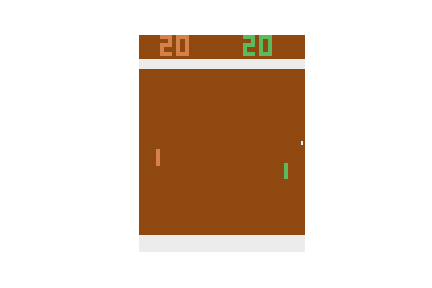

In [5]:
# FA: Load previously saved networks

# FA The network from my GPU training run did not load
# Thx 2: https://stackoverflow.com/a/55759312

if (time.time() - time_of_save_time) > 10: # More than 10 seconds need to pass between saving and loading attempts. 

    if torch.cuda.is_available():
        map_location=lambda storage, loc: storage.cuda()
        print('CUDA')
    else:
        map_location='cpu'
        print('CPU')

    # load your policy if needed
    policy = torch.load('PPO-20200725120549.policy', map_location = map_location)

    # try and test out the solution 
    # (the PPO verion can win more often than not)!
    #
    # policy = torch.load('PPO_solution.policy', map_location = map_location)
    pong_utils.play(env, policy, time=2000) 